In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as spstats
import statsmodels.api as sm
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
#import locale
#locale.setlocale(locale.LC_ALL, 'C')
from scipy import stats
from gprofiler import GProfiler
from matplotlib_venn import venn2, venn2_circles
import altair as alt
# Habilitar VegaFusion para lidar com grandes conjuntos de dados
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
def check_dir(dir: str):
    if os.path.exists(dir) and os.path.isdir(dir):
        pass
    else:
        os.makedirs(dir)

In [3]:
datadir = "data/"
shuffledir = datadir + "shuffle/"
check_dir(datadir)
check_dir(shuffledir)

In [4]:
networks = ["biogrid", "apid", "huri", "string", "omnipath"]

# Functions

In [5]:
def drivergroups(x):
    if x.n_dints == 0:
        return "non_sign"
    else:
        if x.neg_dints == 0:
            return "pos"
        elif x.pos_dints == 0:
            return "neg"
        else:
            if x.neg_dints > x.pos_dints:
                return "more_neg"
            elif x.pos_dints > x.neg_dints:
                return "more_pos"
            else:
                return "neutral"


def labeldrivers(
    df: pd.DataFrame,
    output=None
):
    if output is None:
        output = []

    if len(output) == len(df):
        return output
    else:
        x = df.iloc[len(output)]
        return labeldrivers(df, output=output+[drivergroups(x)])


def labelneighbours(df):
    labels = []
    for i in range(len(df)):
        x = df.iloc[i]
        if x.n_dints == 0:
            labels.append("non_sign")
        else:
            if x.neg_dints == 0:
                labels.append("pos")
            elif x.pos_dints == 0:
                labels.append("neg")
            else:
                labels.append("neutral")
    return labels

# Driver Neighbour analysis

## Load Datasets

In [6]:
mutationtab = pd.read_feather(datadir+"mutation.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(mutationtab.shape)
display(mutationtab.head(2))
neighbourtab = pd.read_feather(datadir+"neighbours.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(neighbourtab.shape)
display(neighbourtab.head(2))

(8404, 2570)


A1CF  A2ML1  ABCA10  ABCA13  ABCA7  ABCB1  ABCB5  \
patient      cancer_type                                                     
TCGA-02-0047 GBM             0      0       0       0      0      0      0   
TCGA-02-0055 GBM             0      0       0       0      0      0      0   

                          ABCC3  ABCC5  ABCC9  ...  ZPBP2  ZRANB3  ZRSR2  \
patient      cancer_type                       ...                         
TCGA-02-0047 GBM              0      0      0  ...      0       0      0   
TCGA-02-0055 GBM              0      0      0  ...      0       0      0   

                          ZSCAN31  ZSCAN4  ZSWIM3  ZSWIM6  ZWILCH  ZWINT  \
patient      cancer_type                                                   
TCGA-02-0047 GBM                0       0       0       0       0      0   
TCGA-02-0055 GBM                0       0       0       0       0      0   

                          ZZEF1  
patient      cancer_type         
TCGA-02-0047 GBM              0  
TCGA-02-0055 GBM              0  

[2 rows x 2570 columns]

(15206, 2570)


driver      A1CF  A2ML1  ABCA10  ABCA13  ABCA7  ABCB1  ABCB5  ABCC3  ABCC5  \
neighbour                                                                    
A1BG       False  False   False   False  False  False  False  False  False   
A1CF       False  False   False   False  False  False  False  False  False   

driver     ABCC9  ...  ZPBP2  ZRANB3  ZRSR2  ZSCAN31  ZSCAN4  ZSWIM3  ZSWIM6  \
neighbour         ...                                                          
A1BG       False  ...  False   False  False    False   False   False   False   
A1CF       False  ...  False   False  False    False   False   False   False   

driver     ZWILCH  ZWINT  ZZEF1  
neighbour                        
A1BG        False  False  False  
A1CF        False  False  False  

[2 rows x 2570 columns]

In [7]:
tumourexp = pd.read_feather(datadir+"tumour_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(tumourexp.shape)
display(tumourexp.head(2))
normalexp = pd.read_feather(datadir+"normal_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(normalexp.shape)
display(normalexp.head(2))

(8404, 15206)


A1BG  A1CF    A2M  A2ML1  A4GALT  A4GNT  AAAS  AACS  \
patient      cancer_type                                                        
TCGA-02-0047 GBM          6.98   0.0  15.05   5.40    5.22   1.16  8.87  8.92   
TCGA-02-0055 GBM          8.62   0.0  15.39   1.42    8.93   0.64  9.22  8.31   

                          AADAT  AAGAB  ...  ZWILCH  ZWINT  ZXDA  ZXDB   ZXDC  \
patient      cancer_type                ...                                     
TCGA-02-0047 GBM           7.87  10.01  ...    8.03   8.66  6.05  8.48  10.12   
TCGA-02-0055 GBM           6.66  10.41  ...    8.87   7.95  5.45  8.14   9.25   

                          ZYG11A  ZYG11B    ZYX  ZZEF1  ZZZ3  
patient      cancer_type                                      
TCGA-02-0047 GBM            0.69   10.24  11.92  10.45  9.24  
TCGA-02-0055 GBM            2.60    9.85  13.49   9.25  9.49  

[2 rows x 15206 columns]

(665, 15206)


A1BG  A1CF    A2M  A2ML1  A4GALT  A4GNT  AAAS  AACS  \
patient      cancer_type                                                        
TCGA-22-4593 LUSC         5.66   0.0  17.08   0.00    8.60   1.62  9.13  9.96   
TCGA-22-4609 LUSC         6.12   0.0  16.80   2.28    8.59   0.76  8.83  9.60   

                          AADAT  AAGAB  ...  ZWILCH  ZWINT  ZXDA  ZXDB   ZXDC  \
patient      cancer_type                ...                                     
TCGA-22-4593 LUSC          7.28   9.97  ...    7.60   7.19  5.22  8.32   9.63   
TCGA-22-4609 LUSC          6.89   9.41  ...    7.29   5.59  6.04  9.02  10.24   

                          ZYG11A  ZYG11B    ZYX  ZZEF1  ZZZ3  
patient      cancer_type                                      
TCGA-22-4593 LUSC           0.83    9.89  12.92  10.51  8.83  
TCGA-22-4609 LUSC           1.03    9.87  12.66  11.12  9.19  

[2 rows x 15206 columns]

# DINTs

In [8]:
results = pd.read_csv(datadir + "results.csv")
print("# of interactions in maingraph:", len(results))
print("# of drivers in maingraph:", results.driver.nunique())
print("# of neighbours in maingraph:", results.neighbour.nunique())
results.dropna(inplace=True)
print("# of interactions with results:", len(results))
print("# of drivers with results:", results.driver.nunique())
print("# of neighbours with results:", results.neighbour.nunique())

# of interactions in maingraph: 383337
# of drivers in maingraph: 2570
# of neighbours in maingraph: 15206
# of interactions with results: 361705
# of drivers with results: 2565
# of neighbours with results: 13064


In [9]:
dints = pd.read_csv(datadir + "DINTs.csv")
print(len(dints))  # Number of significant interactions after the initial filter

14197


In [10]:
dints

driver   neighbour       rho  rho_pval      coef     coef_pval  \
0      A2ML1        BAK1  0.616355  0.001340  0.099646  3.504463e-02   
1      A2ML1      CEP152  0.446281  0.028816  0.233134  3.717213e-04   
2      A2ML1       DOT1L  0.441061  0.030974  0.171850  5.434327e-04   
3      A2ML1        SRRT  0.550239  0.005338  0.084226  5.848238e-03   
4      A2ML1  ST6GALNAC6 -0.561549  0.004299 -0.135210  7.367989e-03   
...      ...         ...       ...       ...       ...           ...   
14192  ZZEF1       LMNB1  0.503740  0.007388  0.364413  1.103802e-08   
14193  ZZEF1       NCAPH  0.534575  0.004071  0.364111  4.172072e-06   
14194  ZZEF1        PRC1  0.437490  0.022484  0.336529  2.065484e-07   
14195  ZZEF1        TGS1  0.540986  0.003571  0.101634  7.494821e-03   
14196  ZZEF1       WNT9B -0.488170  0.009784 -0.164129  3.445393e-02   

       coef_diff  coef_diff_pval  
0      -0.025126        0.910538  
1       0.161886        0.546178  
2       0.139439        0.557473  
3      -0.069655        0.634963  
4       0.238886        0.367315  
...          ...             ...  
14192   0.364658        0.223499  
14193   0.205023        0.587014  
14194   0.306862        0.277754  
14195   0.179033        0.159378  
14196  -0.416582        0.294279  

[14197 rows x 8 columns]

In [11]:
results 

rho  rho_pval driver neighbour      coef  coef_pval  coef_diff  \
0      -0.242212  0.317756   A1CF      APOB -0.307001   0.117268  -1.013937   
2      -0.018429  0.940308   A1CF   APOBEC2  0.094182   0.501902   0.413046   
3       0.258886  0.284517   A1CF  APOBEC3A -0.043689   0.779266  -0.015337   
4       0.365950  0.123349   A1CF  APOBEC3B  0.041200   0.785462   0.535376   
5       0.270294  0.263059   A1CF  APOBEC3C -0.040641   0.701727   0.263150   
...          ...       ...    ...       ...       ...        ...        ...   
383329  0.340711  0.082020  ZZEF1     TOP3B  0.004586   0.909138   0.097823   
383330 -0.256144  0.197180  ZZEF1    TRIM67 -0.317035   0.001493  -0.065829   
383333 -0.488170  0.009784  ZZEF1     WNT9B -0.164129   0.034454  -0.416582   
383334  0.452450  0.017807  ZZEF1     XRCC5  0.037177   0.156104  -0.032418   
383336 -0.567852  0.002004  ZZEF1    ZRANB1 -0.026263   0.391077   0.026213   

        coef_diff_pval  
0             0.355157  
2             0.495099  
3             0.981601  
4             0.393236  
5             0.503508  
...                ...  
383329        0.476153  
383330        0.852978  
383333        0.294279  
383334        0.720573  
383336        0.801445  

[361705 rows x 8 columns]

In [12]:
n_neighbours = results.groupby(["driver"]).size().rename("n_neighbours")
alldints = dints[["driver", "neighbour"]].assign(significant=[1]*len(dints))
drivers = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="neighbour")
    # compute number of positive and negative DINTs by driver
    .groupby(["driver", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_neighbours, left_on="driver", right_index=True)
    # calculate percentage of positive and negative DINTs per driver
    .pivot(index=["driver", "n_neighbours"], columns="signal",
           values="significant")
    # fill 0 in drivers that have neighbours with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
        neg_pct=lambda x: x.neg_dints/x.n_neighbours,
        pos_pct=lambda x: x.pos_dints/x.n_neighbours,
    )
    .fillna(0)
)
drivers = drivers.assign(group=labeldrivers(drivers))

filt_drivers = drivers.copy()
filt_drivers.loc[(filt_drivers.n_dints == 1), "group"] = "non_sign"
filt_drivers

driver  n_neighbours  neg_dints  pos_dints  n_dints   neg_pct   pos_pct  \
0       A1CF            39          0          0        0  0.000000  0.000000   
1      A2ML1            91          3          4        7  0.032967  0.043956   
2     ABCA10             5          0          0        0  0.000000  0.000000   
3     ABCA13             9          1          3        4  0.111111  0.333333   
4      ABCA7            16          0          0        0  0.000000  0.000000   
...      ...           ...        ...        ...      ...       ...       ...   
2560  ZSWIM3             6          0          0        0  0.000000  0.000000   
2561  ZSWIM6            22          0          0        0  0.000000  0.000000   
2562  ZWILCH            22          0          1        1  0.000000  0.045455   
2563   ZWINT           136          0         22       22  0.000000  0.161765   
2564   ZZEF1            89          2          8       10  0.022472  0.089888   

         group  
0     non_sign  
1     more_pos  
2     non_sign  
3     more_pos  
4     non_sign  
...        ...  
2560  non_sign  
2561  non_sign  
2562  non_sign  
2563       pos  
2564  more_pos  

[2565 rows x 8 columns]

In [13]:
# Lista de drivers com group diferente de 'non_sign'
significant_drivers_filt = filt_drivers[filt_drivers['group'] != 'non_sign']['driver'].tolist()

# Lista de drivers com group igual a 'non_sign'
non_significant_drivers_filt = filt_drivers[filt_drivers['group'] == 'non_sign']['driver'].tolist()

# Exibindo as listas
print(f"Drivers com group diferente de 'non_sign': {len(significant_drivers_filt)}")
print(significant_drivers_filt)

print(f"Drivers com group igual a 'non_sign': {len(non_significant_drivers_filt)}")
print(non_significant_drivers_filt)


Drivers com group diferente de 'non_sign': 1271
['A2ML1', 'ABCA13', 'ABCB1', 'ABCC5', 'ABCC9', 'ABCD1', 'ABCF1', 'ABCG2', 'ABI1', 'ABL1', 'ABL2', 'ABLIM2', 'ACAN', 'ACO1', 'ACTB', 'ACTL6B', 'ACVR2A', 'ADAM22', 'ADAMTS12', 'ADAMTS18', 'ADCK1', 'ADCY3', 'ADCY5', 'ADD2', 'ADD3', 'ADNP', 'AFF2', 'AFF3', 'AFF4', 'AGO4', 'AHCTF1', 'AHI1', 'AHNAK', 'AHNAK2', 'AHSA1', 'AJUBA', 'AKAP11', 'AKAP13', 'AKAP6', 'AKAP9', 'AKT1', 'AKT2', 'ALB', 'ALDH5A1', 'ALK', 'ALMS1', 'ALOX12B', 'ALPK2', 'AMER1', 'AMOT', 'AMPH', 'ANK1', 'ANK2', 'ANK3', 'ANKLE2', 'ANKRD12', 'ANKRD17', 'ANKRD26', 'ANKRD36', 'ANKRD50', 'ANLN', 'ANPEP', 'AP1B1', 'AP2A1', 'AP3D1', 'APC', 'API5', 'APLNR', 'APOB', 'APOBEC3B', 'APOBR', 'AR', 'ARAF', 'ARHGAP32', 'ARHGAP35', 'ARHGAP5', 'ARHGEF10', 'ARHGEF10L', 'ARHGEF11', 'ARHGEF12', 'ARHGEF18', 'ARHGEF6', 'ARID1A', 'ARID1B', 'ARID3B', 'ARNT', 'ARNT2', 'ASAP2', 'ASCC2', 'ASCC3', 'ASH1L', 'ASPM', 'ASXL1', 'ASXL2', 'ASXL3', 'ATAD2', 'ATF7IP', 'ATG2A', 'ATM', 'ATP10A', 'ATP10D', 'ATP1A1', 'ATP2

In [14]:
significant_drivers = drivers[drivers['group'] != 'non_sign']['driver'].tolist()
non_significant_drivers = drivers[drivers['group'] == 'non_sign']['driver'].tolist()

print(f"Drivers com group diferente de 'non_sign': {len(significant_drivers)}")
print(significant_drivers)

print(f"Drivers com group igual a 'non_sign': {len(non_significant_drivers)}")
print(non_significant_drivers)

Drivers com group diferente de 'non_sign': 1655
['A2ML1', 'ABCA13', 'ABCB1', 'ABCC3', 'ABCC5', 'ABCC9', 'ABCD1', 'ABCF1', 'ABCG2', 'ABCG8', 'ABI1', 'ABL1', 'ABL2', 'ABLIM2', 'ACAN', 'ACKR3', 'ACO1', 'ACTB', 'ACTL6B', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ADAM10', 'ADAM22', 'ADAM7', 'ADAMTS12', 'ADAMTS18', 'ADAMTS5', 'ADAMTSL3', 'ADCK1', 'ADCY1', 'ADCY3', 'ADCY5', 'ADCY8', 'ADD2', 'ADD3', 'ADNP', 'AFF2', 'AFF3', 'AFF4', 'AGBL2', 'AGGF1', 'AGO4', 'AHCTF1', 'AHCYL2', 'AHI1', 'AHNAK', 'AHNAK2', 'AHSA1', 'AJUBA', 'AKAP11', 'AKAP13', 'AKAP6', 'AKAP9', 'AKT1', 'AKT2', 'ALB', 'ALDH5A1', 'ALDOA', 'ALK', 'ALMS1', 'ALOX12B', 'ALPK1', 'ALPK2', 'AMER1', 'AMOT', 'AMOTL1', 'AMPH', 'ANK1', 'ANK2', 'ANK3', 'ANKLE2', 'ANKRD12', 'ANKRD13A', 'ANKRD17', 'ANKRD26', 'ANKRD36', 'ANKRD50', 'ANLN', 'ANPEP', 'AP1B1', 'AP2A1', 'AP3D1', 'APC', 'API5', 'APLNR', 'APMAP', 'APOB', 'APOBEC3B', 'APOBR', 'AR', 'ARAF', 'ARHGAP26', 'ARHGAP32', 'ARHGAP35', 'ARHGAP5', 'ARHGEF10', 'ARHGEF10L', 'ARHGEF11', 'ARHGEF12', 'ARHGEF18', 'ARH

In [15]:
# stats
for label, df in zip(["Unfiltered stats", "Filtered stats"], [drivers, filt_drivers]):
    print(label)
    print("----------------")
    print(f"{'':^11}# DINTs: {df.n_dints.sum()}")
    print(f"{'':^4}# sign drivers: {(df.group != 'non_sign').sum()}")
    print(f"{'':^5}# pos drivers: {(df.group == 'pos').sum()}")
    print(f"{'':^5}# neg drivers: {(df.group == 'neg').sum()}")
    print(f"{'':^0}# more pos drivers: {(df.group == 'more_pos').sum()}")
    print(f"{'':^0}# more neg drivers: {(df.group == 'more_neg').sum()}")
    print(f"{'':^1}# neutral drivers: {(df.group == 'neutral').sum()}")
    print(f"{'':^1}# nonsign drivers: {(df.group == 'non_sign').sum()}")
    print()


Unfiltered stats
----------------
           # DINTs: 14197
    # sign drivers: 1655
     # pos drivers: 489
     # neg drivers: 254
# more pos drivers: 576
# more neg drivers: 185
 # neutral drivers: 151
 # nonsign drivers: 910

Filtered stats
----------------
           # DINTs: 14197
    # sign drivers: 1271
     # pos drivers: 274
     # neg drivers: 85
# more pos drivers: 576
# more neg drivers: 185
 # neutral drivers: 151
 # nonsign drivers: 1294



In [16]:
meanexp = tumourexp.reset_index(drop=True).median().rename("expression")
meanexp.head()

A1BG       6.25
A1CF       0.00
A2M       13.21
A2ML1      2.39
A4GALT     8.67
Name: expression, dtype: float64

In [17]:
n_inters = results.groupby(["neighbour"]).size().rename("n_inters")
alldints = dints[["driver", "neighbour"]].assign(significant=[1]*len(dints))
neighbours = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="driver")
    # compute number of positive and negative DINTs by neighbour
    .groupby(["neighbour", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_inters, left_on="neighbour", right_index=True)
    # calculate percentage of positive and negative DINTs per neighbour
    .pivot(index=["neighbour", "n_inters"], columns="signal",
           values="significant")
    # fill 0 in neighbours that have DINTs with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
    )
)

neighbours = (
    neighbours
    .assign(group=labelneighbours(neighbours))
    .merge(meanexp, how="left", left_on="neighbour", right_index=True)
)

filt_neighbours = neighbours.copy()
filt_neighbours.loc[(filt_neighbours.n_dints == 1), "group"] = "non_sign"
filt_neighbours

neighbour  n_inters  neg_dints  pos_dints  n_dints     group  expression
0          A1BG        13          0          0        0  non_sign        6.25
1           A2M        51          1          0        1  non_sign       13.21
2         A2ML1        18          0          0        0  non_sign        2.39
3        A4GALT         3          0          0        0  non_sign        8.67
4          AAAS        49          0          0        0  non_sign        9.63
...         ...       ...        ...        ...      ...       ...         ...
13059    ZYG11A         3          0          0        0  non_sign        3.75
13060    ZYG11B        14          0          0        0  non_sign        9.69
13061       ZYX       109          0          0        0  non_sign       11.93
13062     ZZEF1        15          0          0        0  non_sign       10.19
13063      ZZZ3        36          0          0        0  non_sign        9.46

[13064 rows x 7 columns]

In [18]:
mean_n_dints_sig = neighbours[neighbours['group'] != 'non_sign']['n_dints'].mean()
mean_n_dints_sig

4.550320512820512

In [19]:
mean_n_dints_sig = filt_neighbours[filt_neighbours['group'] != 'non_sign']['n_dints'].mean()
mean_n_dints_sig

7.863073110285006

In [20]:
mean_n_inters = filt_neighbours['n_inters'].mean()
print(f"Média de interações por vizinho: {mean_n_inters}")
mean_n_dints = filt_neighbours['n_dints'].mean()
print(f"Média de interações significativas por vizinho: {mean_n_dints}")

Média de interações por vizinho: 27.687155541947337
Média de interações significativas por vizinho: 1.0867268830373547


In [21]:
#valores diferentes que há em group 
filt_neighbours.group.unique()


array(['non_sign', 'pos', 'neg', 'neutral'], dtype=object)

In [22]:
# Lista de vizinhos com group diferente de 'non_sign'
significant_neighbours = neighbours[neighbours['group'] != 'non_sign']['neighbour'].tolist()

# Lista de vizinhos com group igual a 'non_sign'
non_significant_neighbours = neighbours[neighbours['group'] == 'non_sign']['neighbour'].tolist()

# Exibindo as listas
print(f"Vizinhos com group diferente de 'non_sign': {len(significant_neighbours)}")
print(significant_neighbours)

print(f"Vizinhos com group igual a 'non_sign': {len(non_significant_neighbours)}")
print(non_significant_neighbours)


Vizinhos com group diferente de 'non_sign': 3120
['A2M', 'AAGAB', 'AAK1', 'AASS', 'ABCA1', 'ABCA2', 'ABCD1', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCG2', 'ABHD12', 'ABI2', 'ABL2', 'ABLIM3', 'ABT1', 'ACACA', 'ACACB', 'ACAD10', 'ACAD11', 'ACBD3', 'ACCS', 'ACOT7', 'ACP1', 'ACSS3', 'ACTB', 'ACTG1', 'ACTL6A', 'ACTN2', 'ACTN4', 'ACTR10', 'ACTR2', 'ACTR3', 'ACTR5', 'ADAM9', 'ADAMTS1', 'ADAMTS10', 'ADAMTS13', 'ADARB1', 'ADCY2', 'ADCY9', 'ADD1', 'ADD2', 'ADRA1D', 'ADRB2', 'AEN', 'AFF3', 'AGAP11', 'AGAP3', 'AGBL4', 'AGMAT', 'AGR2', 'AGT', 'AGTR1', 'AHCTF1', 'AHCY', 'AHNAK', 'AHR', 'AHSA1', 'AIF1', 'AIM2', 'AIMP1', 'AIMP2', 'AK2', 'AKAP11', 'AKAP9', 'AKR7A3', 'AKT3', 'AKTIP', 'ALAS1', 'ALB', 'ALDH18A1', 'ALDH1L1', 'ALDH9A1', 'ALDOA', 'ALG11', 'ALKBH3', 'AMIGO1', 'AMOT', 'AMOTL1', 'AMOTL2', 'AMPH', 'AMY2B', 'ANAPC1', 'ANAPC10', 'ANK2', 'ANK3', 'ANKAR', 'ANKFY1', 'ANKH', 'ANKRA2', 'ANKRD13A', 'ANKRD39', 'ANKRD52', 'ANKRD6', 'ANKS1B', 'ANKS6', 'ANLN', 'ANO5', 'ANP32A', 'ANP32B', 'ANP32E', 'ANXA1', 'ANXA2', '

In [23]:
# Lista de vizinhos com group diferente de 'non_sign'
significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] != 'non_sign']['neighbour'].tolist()

# Lista de vizinhos com group igual a 'non_sign'
non_significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] == 'non_sign']['neighbour'].tolist()

# Exibindo as listas
print(f"Vizinhos com group diferente de 'non_sign': {len(significant_neighbours_filt)}")
print(significant_neighbours_filt)

print(f"Vizinhos com group igual a 'non_sign': {len(non_significant_neighbours_filt)}")
print(non_significant_neighbours_filt)


Vizinhos com group diferente de 'non_sign': 1614
['ABCE1', 'ABCF2', 'ABCG2', 'ABLIM3', 'ABT1', 'ACACB', 'ACAD11', 'ACOT7', 'ACTB', 'ACTG1', 'ACTL6A', 'ACTN2', 'ACTR2', 'ACTR3', 'ACTR5', 'ADAMTS1', 'ADAMTS13', 'ADARB1', 'ADCY9', 'ADD1', 'ADRB2', 'AGAP11', 'AGBL4', 'AGR2', 'AGT', 'AGTR1', 'AHCTF1', 'AHSA1', 'AIM2', 'AIMP2', 'AKT3', 'ALAS1', 'ALB', 'ALDH18A1', 'AMOT', 'AMOTL1', 'ANAPC1', 'ANK2', 'ANK3', 'ANKRD6', 'ANKS1B', 'ANLN', 'ANP32B', 'ANXA1', 'ANXA2', 'AP2A2', 'AP3B2', 'APBA1', 'APBB1', 'APH1B', 'APLP2', 'APOB', 'APP', 'AQP1', 'AQP4', 'AR', 'ARHGAP11A', 'ARHGAP11B', 'ARHGAP24', 'ARHGEF17', 'ARHGEF9', 'ARID3A', 'ARMC7', 'ARPC3', 'ARPC5L', 'ARSG', 'ASAP3', 'ASF1B', 'ASNS', 'ASPM', 'ATAD3A', 'ATAD3B', 'ATG2B', 'ATG5', 'ATIC', 'ATL1', 'ATM', 'ATP1A2', 'ATP1B2', 'ATP1B3', 'ATP2B2', 'ATP8A2', 'ATXN1', 'AURKA', 'AURKAIP1', 'AURKB', 'AXL', 'BACE1', 'BAIAP2L1', 'BAK1', 'BBS1', 'BCAS3', 'BCL2', 'BCL6', 'BECN1', 'BEND3', 'BEX1', 'BIN1', 'BIRC5', 'BLM', 'BMI1', 'BMPR2', 'BMS1', 'BRCA1', 'BRCA2

In [24]:
# stats
for label, df in zip(["Unfiltered stats", "Filtered stats"], [neighbours, filt_neighbours]):
    print(label)
    print("----------------")
    print(f"{'':^13}# DINTs: {df.n_dints.sum()}")
    print(f"{'':^3}# sign neighbours: {(df.group != 'non_sign').sum()}")
    print(f"{'':^4}# pos neighbours: {(df.group == 'pos').sum()}")
    print(f"{'':^4}# neg neighbours: {(df.group == 'neg').sum()}")
    print(f"{'':^0}# neutral neighbours: {(df.group == 'neutral').sum()}")
    print(f"{'':^0}# nonsign neighbours: {(df.group == 'non_sign').sum()}")
    print()


Unfiltered stats
----------------
             # DINTs: 14197
   # sign neighbours: 3120
    # pos neighbours: 1727
    # neg neighbours: 1378
# neutral neighbours: 15
# nonsign neighbours: 9944

Filtered stats
----------------
             # DINTs: 14197
   # sign neighbours: 1614
    # pos neighbours: 1013
    # neg neighbours: 586
# neutral neighbours: 15
# nonsign neighbours: 11450



In [28]:
def count_significant_interactions(df):
    significant = df[(df['rho_pval'] < 0.05) & (df['coef_pval'] < 0.05)]
    positive = significant[significant['rho'] > 0]
    negative = significant[significant['rho'] < 0]
    return len(significant), len(positive), len(negative)

# Count for interactions in `results`
total_sig, total_pos, total_neg = count_significant_interactions(results)
print(total_sig, total_pos, total_neg)  # Total count, positive and negative

filtered_sig, filtered_pos, filtered_neg = count_significant_interactions(dints)
print(filtered_sig, filtered_pos, filtered_neg)  # Count after filtering, positive and negative

19609 14075 5534
14197 10226 3971


In [38]:
# Ordenar o DataFrame pelo valor da coluna 'rho_pval' do menor para o maior
sorted_combined_results = dints.sort_values(by='rho_pval', ascending=True)

# Exibir o DataFrame ordenado
print(sorted_combined_results)


        driver neighbour       rho      rho_pval      coef     coef_pval  \
5398     FBXW7     SNRPF  0.896104  3.953026e-08  0.114823  1.160621e-03   
658        APC    RNF146 -0.836386  5.518993e-08 -0.069335  7.244011e-03   
1519     BRCA1      TUBB  0.890909  6.153862e-08  0.103933  7.919195e-03   
9581   PDE4DIP       TK1  0.827228  1.034358e-07  0.256100  7.517461e-06   
12750     TP53      CDK8  0.785081  1.701264e-07  0.203701  4.808826e-17   
...        ...       ...       ...           ...       ...           ...   
10526     PTEN      TP53  0.396154  4.994695e-02  0.155076  6.161770e-04   
117     ACVR2A      RHOQ -0.443776  4.999279e-02 -0.174597  1.557901e-04   
3353     CUL4B     CDCA8  0.443776  4.999279e-02  0.221758  1.806704e-02   
7971      MCM5      CDT1  0.443776  4.999279e-02  0.316692  1.277641e-02   
3420      CUL7     PSMD6  0.443776  4.999279e-02  0.104138  1.707417e-03   

       coef_diff  coef_diff_pval  
5398   -0.343596        0.048057  
658     0.008945 

In [39]:
# Filtrar para manter apenas as linhas onde o driver é PIK3CA
pik3ca_results = dints[dints['driver'] == 'FBXW7']

# Limitar (clipping) os coef_pval para um mínimo de 1e-16
pik3ca_results['coef_pval_clipped'] = pik3ca_results['coef_pval'].clip(lower=1e-16)

# Filtrar para coef > 0 e ordenar pelo coef_pval_clipped do menor para o maior
filtered_pik3ca_results = pik3ca_results[pik3ca_results['coef'] > 0]
sorted_pik3ca_results = filtered_pik3ca_results.sort_values(by='coef_pval_clipped', ascending=True)

# Exibir o DataFrame ordenado
print(sorted_pik3ca_results)



     driver neighbour       rho      rho_pval      coef     coef_pval  \
5307  FBXW7      LYAR  0.867532  3.540621e-07  0.266905  6.709741e-16   
5325  FBXW7       NCL  0.709091  3.195131e-04  0.188853  4.259419e-15   
5235  FBXW7      CCT8  0.687013  5.809898e-04  0.173762  1.055589e-12   
5275  FBXW7      GART  0.712987  2.859228e-04  0.187983  9.288954e-12   
5338  FBXW7     PGAM5  0.755844  7.403635e-05  0.221524  3.671999e-11   
...     ...       ...       ...           ...       ...           ...   
5268  FBXW7    FBXO45  0.590909  4.791421e-03  0.062038  4.641101e-02   
5413  FBXW7     TUBG1  0.453247  3.906675e-02  0.060904  4.673968e-02   
5372  FBXW7     RPLP2  0.641558  1.720068e-03  0.082567  4.812059e-02   
5343  FBXW7     PRKDC  0.650649  1.403863e-03  0.081673  4.908808e-02   
5397  FBXW7    SNRPD3  0.749351  9.239645e-05  0.051459  4.995179e-02   

      coef_diff  coef_diff_pval  coef_pval_clipped  
5307   0.064701        0.740731       6.709741e-16  
5325   0.132945  

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_34174/3292602747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pik3ca_results['coef_pval_clipped'] = pik3ca_results['coef_pval'].clip(lower=1e-16)


In [40]:
import matplotlib.font_manager
for f in matplotlib.font_manager.fontManager.ttflist:
    if f.name in ['Times New Roman']:
        print(f.name)

Times New Roman
Times New Roman
Times New Roman
Times New Roman


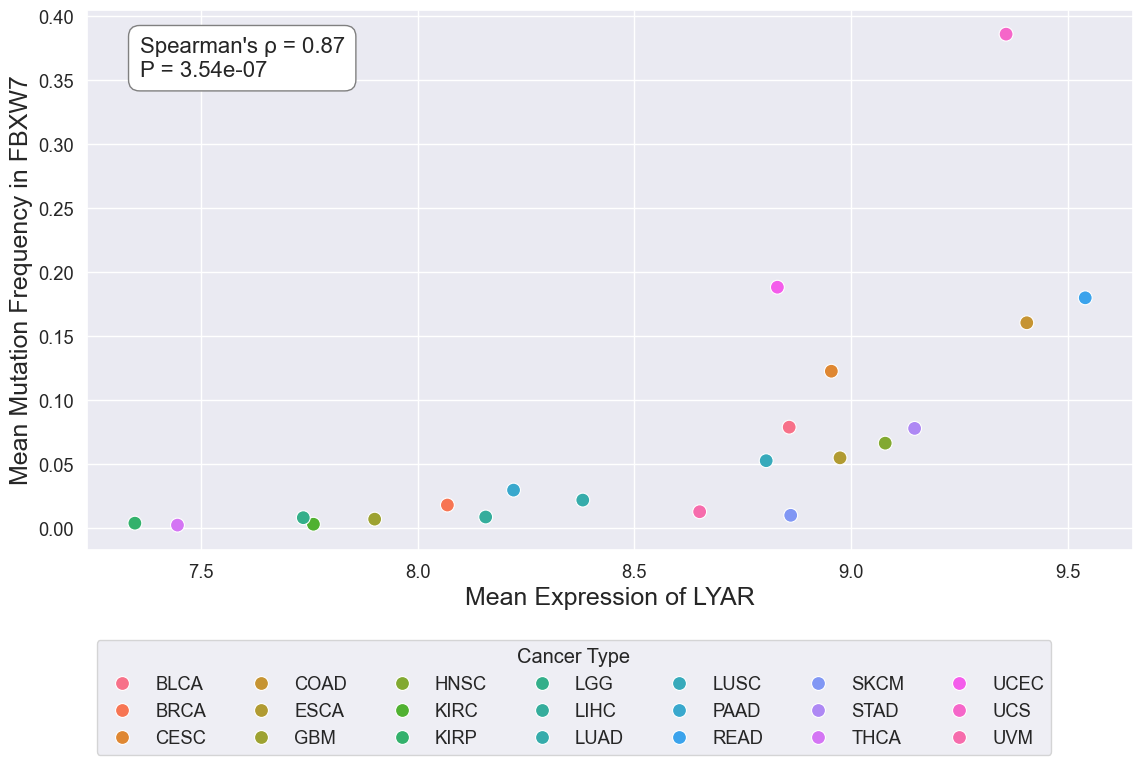

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr

def create_spearman_plot(driver, neighbor_gene, mutationtab, tumourexp):
    # Filtrar por cancer_type que tenha pelo menos uma mutação no driver
    mutationtab_filtered = mutationtab.groupby('cancer_type').filter(lambda x: x[driver].sum() > 0)
    tumourexp_filtered = tumourexp.loc[mutationtab_filtered.index]

    # Obter as médias das mutações e expressão por tipo de câncer
    grouped_data_mut = mutationtab_filtered.groupby('cancer_type')[driver].mean()
    grouped_data_exp = tumourexp_filtered.groupby('cancer_type')[neighbor_gene].mean()

    # Combinar os dados em um DataFrame
    grouped_data = pd.DataFrame({
        'mean_mutation': grouped_data_mut,
        'mean_expression': grouped_data_exp
    }).reset_index()

    # Calcular a correlação de Spearman
    correlation, p_value = spearmanr(grouped_data['mean_expression'], grouped_data['mean_mutation'])

    # Formatar o p-value como valor exato, em notação científica
    p_value_annotation = f"P = {p_value:.2e}"  # Exibe sempre o valor exato do p-value em notação científica

    # Plotar os dados
    plt.figure(figsize=(12, 8))
    sns.set(font_scale=1.2)

    sns.scatterplot(x='mean_expression', y='mean_mutation', data=grouped_data, hue='cancer_type', s=100)
    #plt.title(f'Expression of {neighbor_gene} vs. Mutation Frequency in {driver}', fontsize=20)
    plt.xlabel(f'Mean Expression of {neighbor_gene}', fontsize=18)
    plt.ylabel(f'Mean Mutation Frequency in {driver}', fontsize=18)

    plt.legend(title='Cancer Type', bbox_to_anchor=(0, -0.15), loc='upper left', ncol=7)

    # Adicionar anotação com o formato correto de ρ e p-value exato
    plt.annotate(f"Spearman's ρ = {correlation:.2f}\n{p_value_annotation}", 
                 xy=(0.05, 0.95),  # canto superior esquerdo
                 xycoords='axes fraction', 
                 ha='left', 
                 va='top', 
                 fontsize=16, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', lw=1))

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
create_spearman_plot('FBXW7', 'LYAR', mutationtab, tumourexp)


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_ols_boxplots(driver, neighbor_gene, coef, p_value, mutationtab, tumourexp):
    # Verificar se as colunas driver e neighbor_gene estão nos DataFrames
    if driver not in mutationtab.columns or neighbor_gene not in tumourexp.columns:
        print(f"Erro: {driver} ou {neighbor_gene} não encontrados nos dados.")
        return
    
    # Extrair a coluna de status de mutação do gene driver e a expressão do gene vizinho
    mutation_status = mutationtab[driver]
    gene_expression = tumourexp[neighbor_gene]
    
    # Criar um DataFrame combinando a expressão, status de mutação, e tipo de câncer
    combined_data = pd.DataFrame({
        'cancer_type': mutationtab.index.get_level_values('cancer_type'),
        'expression': gene_expression,
        'mutated': mutation_status
    })

    # Plotar os dados
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e']
    
    sns.boxplot(x='cancer_type', y='expression', hue='mutated', data=combined_data, palette=colors, fliersize=2, ax=ax)
    
    # Removendo o título
    # ax.set_title(f'{neighbor_gene} Expression vs {driver} Mutation Status by Cancer Type', fontsize=20)

    ax.set_xlabel('Cancer Type', fontsize=18)
    ax.set_ylabel(f'{neighbor_gene} Expression', fontsize=18)
    plt.xticks(rotation=45, ha='right')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['No', 'Yes'], title='Mutated', loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    
    # Adicionar a anotação com o coeficiente e o p-valor fornecidos
    ax.annotate(f'Coef = {coef:.2f}\nP = {p_value:.2e}', 
                xy=(0.98, 0.98), 
                xycoords='axes fraction',
                ha='right', 
                va='top', 
                fontsize=16, 
                bbox=dict(boxstyle='round', fc='white', ec='gray'))
    
    plt.show()

# Exemplo de uso:
# Assumindo que você tem um DataFrame `results` com os valores calculados
# E que você quer filtrar os resultados para obter coeficiente e p-valor para 'FBXW7' e 'LYAR'

# Filtrando o DataFrame `results`
filtered_result = dints[(dints['driver'] == 'FBXW7') & (dints['neighbour'] == 'LYAR')]

# Extraindo o coeficiente e o p-valor
coef = filtered_result['coef'].values[0]
p_value = filtered_result['coef_pval'].values[0]

# Usar a função com os dados filtrados
create_ols_boxplots('FBXW7', 'LYAR', coef, p_value, mutationtab, tumourexp)


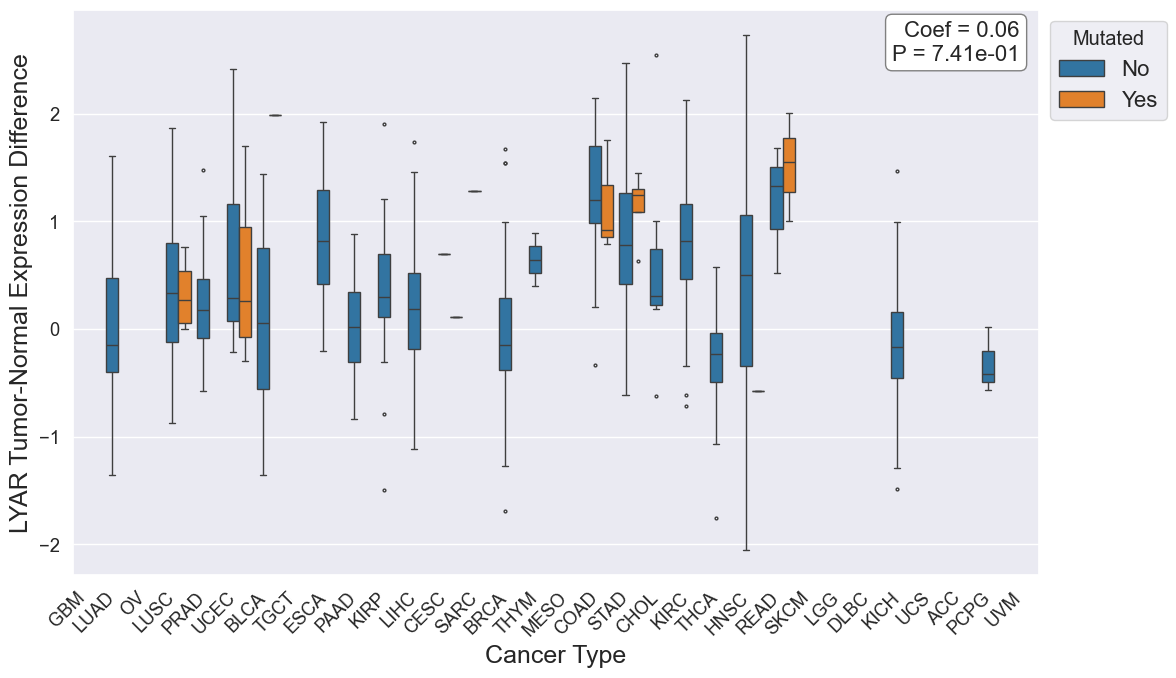

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_ols_boxplots_tumor_normal(driver, neighbor_gene, coef, p_value, mutationtab, tumourexp, normalexp):
    # Verificar se as colunas driver e neighbor_gene estão nos DataFrames
    if driver not in mutationtab.columns or neighbor_gene not in tumourexp.columns or neighbor_gene not in normalexp.columns:
        print(f"Erro: {driver} ou {neighbor_gene} não encontrados nos dados.")
        return
    
    # Extrair a coluna de status de mutação do gene driver e calcular a diferença de expressão tumor-normal
    mutation_status = mutationtab[driver]
    tumournormaldiff = tumourexp[neighbor_gene] - normalexp[neighbor_gene]
    
    # Criar um DataFrame combinando a diferença de expressão, status de mutação, e tipo de câncer
    combined_data = pd.DataFrame({
        'cancer_type': mutationtab.index.get_level_values('cancer_type'),
        'expression_diff': tumournormaldiff,
        'mutated': mutation_status
    })
    
    # Plotar os dados
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e']
    
    sns.boxplot(x='cancer_type', y='expression_diff', hue='mutated', data=combined_data, palette=colors, fliersize=2, ax=ax)
    
    #ax.set_title(f'{neighbor_gene} Tumor-Normal Expression Difference vs {driver} Mutation Status by Cancer Type', fontsize=20)
    ax.set_xlabel('Cancer Type', fontsize=18)
    ax.set_ylabel(f'{neighbor_gene} Tumor-Normal Expression Difference', fontsize=18)
    plt.xticks(rotation=45, ha='right')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['No', 'Yes'], title='Mutated', loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    
    # Adicionar a anotação com o coeficiente e o p-valor fornecidos
    ax.annotate(f'Coef = {coef:.2f}\nP = {p_value:.2e}', 
                xy=(0.98, 0.98), 
                xycoords='axes fraction',
                ha='right', 
                va='top', 
                fontsize=16, 
                bbox=dict(boxstyle='round', fc='white', ec='gray'))
    
    plt.show()

# Exemplo de uso:
# Assumindo que você tem um DataFrame `results` com os valores calculados
# E que você quer filtrar os resultados para obter coeficiente e p-valor para 'FBXW7' e 'LYAR'

# Filtrando o DataFrame `results`
filtered_result = dints[(dints['driver'] == 'FBXW7') & (dints['neighbour'] == 'LYAR')]

# Extraindo o coeficiente e o p-valor
coef_diff = filtered_result['coef_diff'].values[0]
p_value_diff = filtered_result['coef_diff_pval'].values[0]

# Usar a função com os dados filtrados
create_ols_boxplots_tumor_normal('FBXW7', 'LYAR', coef_diff, p_value_diff, mutationtab, tumourexp, normalexp)

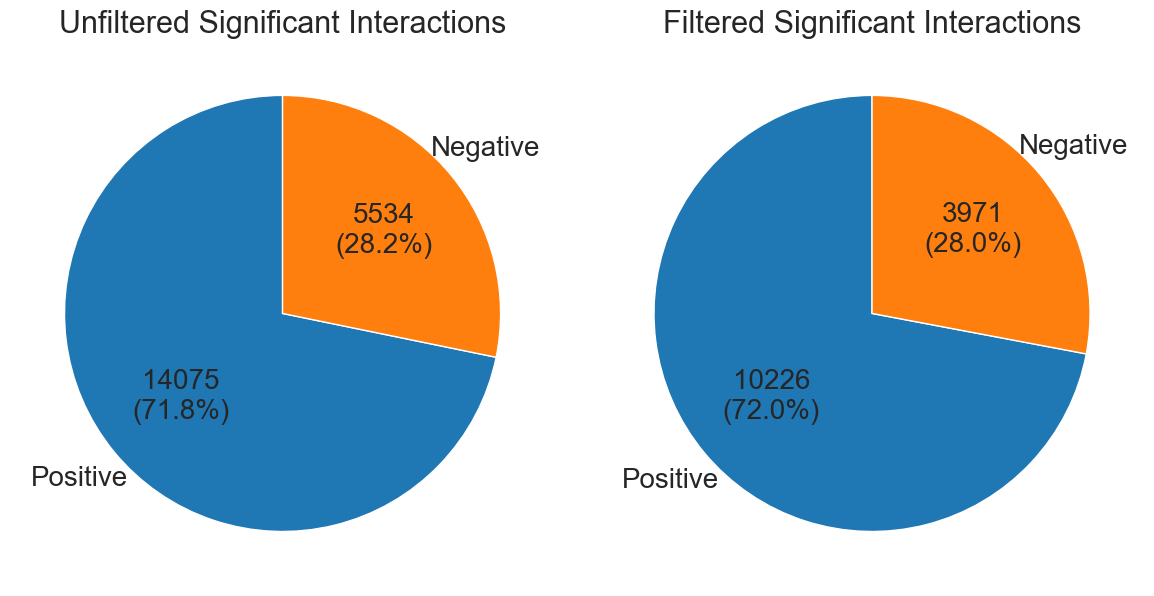

In [45]:
import matplotlib.pyplot as plt

# Data for pie charts
labels = ['Positive', 'Negative']
sizes_unfiltered = [total_pos, total_neg]
sizes_filtered = [filtered_pos, filtered_neg]

# Colors from your boxplot
colors = ['#1f77b4', '#ff7f0e'] 

# Custom autopct function to show both numbers and percentages
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}\n({pct:.1f}%)'  # Adding newline for better alignment
    return my_format

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Increase font size using textprops, but without bold
textprops = {"fontsize": 20, "ha": "center", "va": "center"}

# Unfiltered significant interactions pie chart
ax1.pie(sizes_unfiltered, labels=labels, autopct=autopct_format(sizes_unfiltered), startangle=90, 
        colors=colors, textprops=textprops, labeldistance=1.20)  # labeldistance increases space between chart and labels
ax1.set_title('Unfiltered Significant Interactions', fontsize=22)

# Filtered significant interactions pie chart
ax2.pie(sizes_filtered, labels=labels, autopct=autopct_format(sizes_filtered), startangle=90, 
        colors=colors, textprops=textprops, labeldistance=1.20)  # Adjust the label distance
ax2.set_title('Filtered Significant Interactions', fontsize=22)

plt.tight_layout()
plt.show()


## Significant DINTs

In [48]:
hallmarks_df = pd.read_excel('hallmarks_to_goterms.xlsx')
hallmarks_df['Hallmarks'] = hallmarks_df['Hallmarks'].str.strip()
hallmarks_df['GO terms'] = hallmarks_df['GO terms'].str.strip()
hallmarks_df['Term name'] = hallmarks_df['Term name'].str.strip()

In [49]:
#procurar em hallmarks_df na coluna GO terms o valor 'GO:0045786'
hallmarks_df[hallmarks_df['GO terms'] == 'GO:0045786']

Hallmarks    GO terms  \
4  Sustaining Proliferative Signaling  GO:0045786   
8           Evading Growth Suppressor  GO:0045786   

                           Term name  \
4  Negative regulation of cell cycle   
8  Negative regulation of cell cycle   

   Frequency of selection without pathway mapping method  \
4                                                  2       
8                                                  2       

   Frequency of selection with pathway mapping method  
4                                                  3   
8                                                  3

In [50]:
background = []
for net in networks:
    ppi = pd.read_csv(datadir + f"{net}_graph.csv")
    # Extract unique proteins from both columns of the PPI network
    gene_names = pd.concat([ppi.iloc[:, 0], ppi.iloc[:, 1]]).drop_duplicates().tolist()
    background.extend(gene_names)

# Remove duplicates to get the final background set
background = list(set(background))

print(f'Total number of unique proteins in background: {len(background)}')

Total number of unique proteins in background: 20142


## Expression Analysis

### POS VS NEG

In [52]:
# Contar o número único de drivers para cada vizinho
vizinho_contagem = dints.groupby('neighbour')['driver'].nunique()

# Identificar vizinhos significativos (aqueles com pelo menos um DINT)
vizinhos_significativos = filt_neighbours[filt_neighbours['n_dints'] > 1]['neighbour']

# Filtrar apenas os vizinhos significativos
vizinho_contagem_filtrado = vizinho_contagem[vizinho_contagem.index.isin(vizinhos_significativos)]

# Calcular a média de vezes que os vizinhos significativos são vizinhos de drivers
media_vizinho_drivers = vizinho_contagem_filtrado.mean()

print(f"A média de vezes que os vizinhos significativos são vizinhos de drivers é: {media_vizinho_drivers:.2f}")


A média de vezes que os vizinhos significativos são vizinhos de drivers é: 7.86


In [53]:
# Contar o número único de drivers para cada vizinho
vizinho_contagem = dints.groupby('neighbour')['driver'].nunique()

# Identificar vizinhos significativos (aqueles com pelo menos um DINT)
vizinhos_significativos = filt_neighbours[filt_neighbours['n_dints'] > 0]['neighbour']

# Filtrar apenas os vizinhos significativos
vizinho_contagem_filtrado = vizinho_contagem[vizinho_contagem.index.isin(vizinhos_significativos)]

# Calcular a média de vezes que os vizinhos significativos são vizinhos de drivers
media_vizinho_drivers = vizinho_contagem_filtrado.mean()

print(f"A média de vezes que os vizinhos significativos são vizinhos de drivers é: {media_vizinho_drivers:.2f}")

A média de vezes que os vizinhos significativos são vizinhos de drivers é: 4.55


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_34174/224933699.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neighbour_consistency = dints.groupby('neighbour').apply(check_sign_consistency)


1727
1378
Shapiro-Wilk Test: Statistics=0.7582512205459512, p-value=1.0641557582338755e-44
Shapiro-Wilk Test: Statistics=0.9307081353097414, p-value=9.164445418586214e-25
Levene's Test: Statistics=72.54611114413035, p-value=2.505923404728892e-17

P-value for normality for positive neighbours: 1.0641557582338755e-44
P-value for normality for negative neighbours: 9.164445418586214e-25
P-value for homoscedasticity: 2.505923404728892e-17


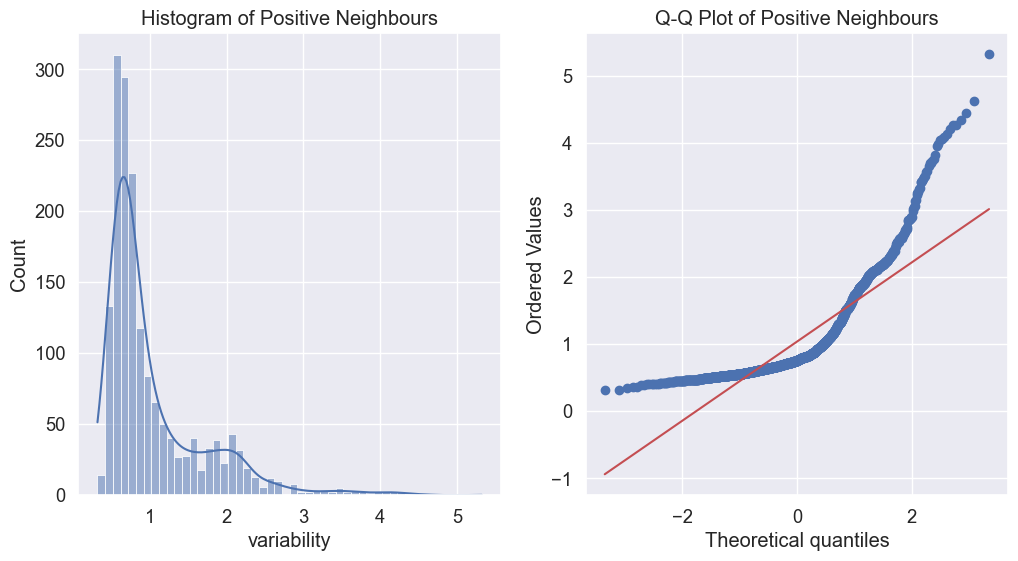

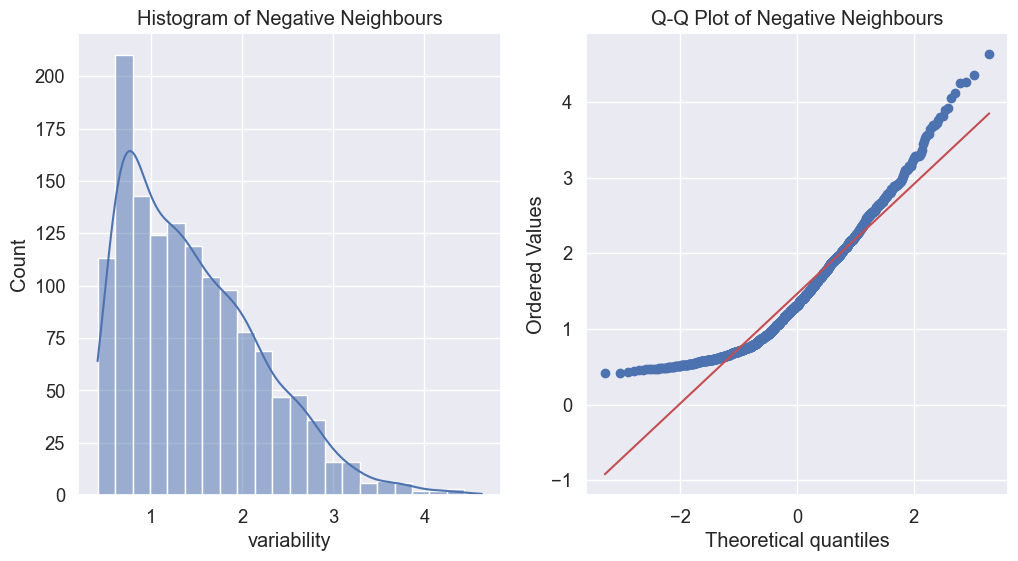


Using the Mann-Whitney U test:
U Statistic: 716592.0
P-value: 4.428553246089881e-81

Correlation between gene expression variability and number of associated drivers for positive neighbours: 0.07798067503135232
Correlation between gene expression variability and number of associated drivers for negative neighbours: 0.06576893239751627


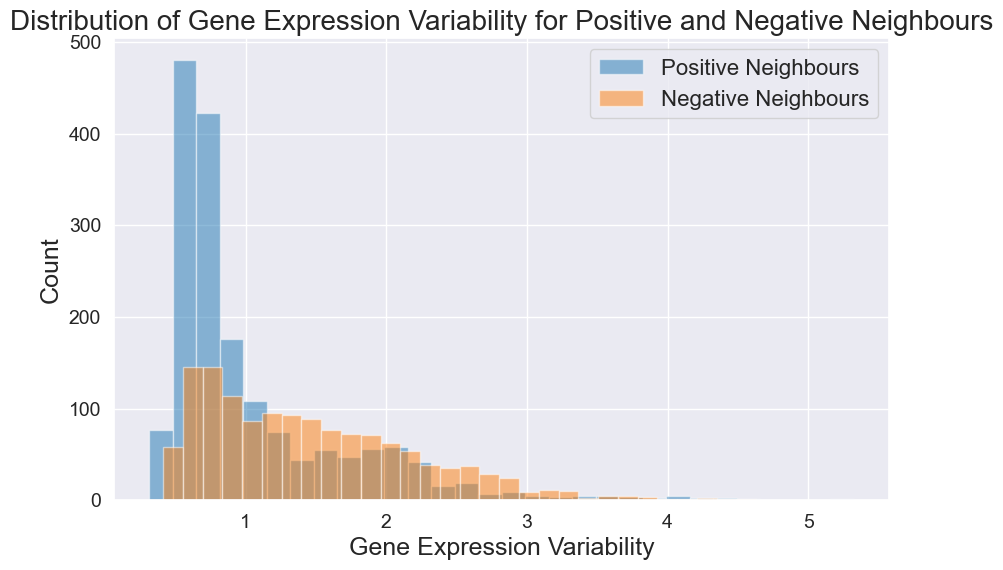

In [54]:
# Auxiliary Functions
def check_sign_consistency(group):
    signs = np.sign(group['coef'])
    return (signs == signs.iloc[0]).all()

def calculate_variability(df, neighbour):
    return df[neighbour].std()

def get_association_type(neighbour, filtered_results):
    coef = filtered_results[filtered_results['neighbour'] == neighbour]['coef'].iloc[0]
    return 'Positive' if coef > 0 else 'Negative'

def check_normality(data):
    stat, p_value = stats.shapiro(data)
    print(f"Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}")
    return p_value

def check_homogeneity_of_variances(group1, group2):
    stat, p_value = stats.levene(group1, group2)
    print(f"Levene's Test: Statistics={stat}, p-value={p_value}")
    return p_value

def plot_normality(data, label):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {label}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {label}')
    plt.show()

# Analysis of Consistent Neighbours
neighbour_consistency = dints.groupby('neighbour').apply(check_sign_consistency)
driver_counts = dints.groupby('neighbour')['driver'].nunique()

neighbour_analysis = pd.DataFrame({
    'num_associated_drivers': driver_counts,
    'is_consistent': neighbour_consistency
})

consistent_neighbours = neighbour_analysis[neighbour_analysis['is_consistent']].copy()
consistent_neighbours['association_type'] = consistent_neighbours.index.map(lambda x: get_association_type(x, dints))
consistent_neighbours = consistent_neighbours.reset_index()

# Calculation of Variability
variability_list = [calculate_variability(tumourexp, neighbour) for neighbour in consistent_neighbours['neighbour']]
variability_df = pd.DataFrame(variability_list, index=consistent_neighbours['neighbour'], columns=['variability'])

variability_df['association_type'] = variability_df.index.map(lambda x: get_association_type(x, dints))
variability_df['num_associated_drivers'] = consistent_neighbours.set_index('neighbour')['num_associated_drivers']

only_pos_variability = variability_df[variability_df['association_type'] == 'Positive']
print(len(only_pos_variability))
only_neg_variability = variability_df[variability_df['association_type'] == 'Negative']
print(len(only_neg_variability))

# Statistical Tests
p_value_pos_normality = check_normality(only_pos_variability['variability'])
p_value_neg_normality = check_normality(only_neg_variability['variability'])
p_value_pos_variance = check_homogeneity_of_variances(only_pos_variability['variability'], only_neg_variability['variability'])

print(f"\nP-value for normality for positive neighbours: {p_value_pos_normality}")
print(f"P-value for normality for negative neighbours: {p_value_neg_normality}")
print(f"P-value for homoscedasticity: {p_value_pos_variance}")

plot_normality(only_pos_variability['variability'], 'Positive Neighbours')
plot_normality(only_neg_variability['variability'], 'Negative Neighbours')

# Use Mann-Whitney U if normality is not met or variances are different
if p_value_pos_normality < 0.05 or p_value_neg_normality < 0.05 or p_value_pos_variance < 0.05:
    u_stat, u_p_value = stats.mannwhitneyu(only_pos_variability['variability'], only_neg_variability['variability'])
    print(f"\nUsing the Mann-Whitney U test:")
    print(f"U Statistic: {u_stat}")
    print(f"P-value: {u_p_value}")
else:
    t_stat, t_p_value = stats.ttest_ind(only_pos_variability['variability'], only_neg_variability['variability'])
    print(f"\nUsing the t-test:")
    print(f"t Statistic: {t_stat}")
    print(f"P-value: {t_p_value}")

# Correlation between variability and number of associated drivers
correlation_pos = only_pos_variability['variability'].corr(only_pos_variability['num_associated_drivers'])
correlation_neg = only_neg_variability['variability'].corr(only_neg_variability['num_associated_drivers'])

print(f"\nCorrelation between gene expression variability and number of associated drivers for positive neighbours: {correlation_pos}")
print(f"Correlation between gene expression variability and number of associated drivers for negative neighbours: {correlation_neg}")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Define the colors for positive and negative neighbours
colors = {'Positive': '#1f77b4', 'Negative': '#ff7f0e'}



plt.figure(figsize=(10, 6))
plt.hist(only_pos_variability['variability'], bins=30, alpha=0.5, label='Positive Neighbours', color=colors['Positive'])
plt.hist(only_neg_variability['variability'], bins=30, alpha=0.5, label='Negative Neighbours', color=colors['Negative'])
plt.xlabel('Gene Expression Variability', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of Gene Expression Variability for Positive and Negative Neighbours', fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Visualisation of correlation with consistent colors and larger font size
plt.figure(figsize=(10, 6))
sns.scatterplot(x=only_pos_variability['num_associated_drivers'], y=only_pos_variability['variability'], 
                label='Positive Neighbours', color=colors['Positive'])
sns.scatterplot(x=only_neg_variability['num_associated_drivers'], y=only_neg_variability['variability'], 
                label='Negative Neighbours', color=colors['Negative'])
plt.xlabel('Number of Associated Drivers', fontsize=18)
plt.ylabel('Gene Expression Variability', fontsize=18)
#plt.title('Correlation between Gene Expression Variability and Number of Associated Drivers', fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


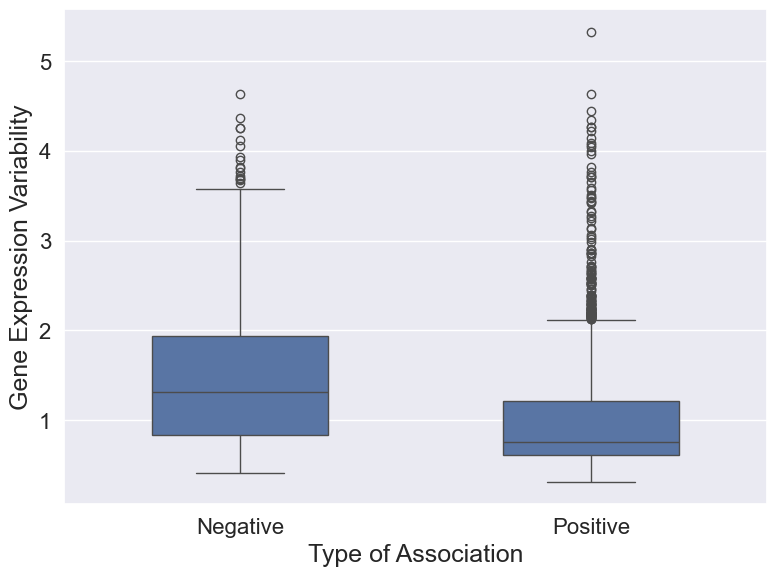

In [55]:
# Plot box plot for variability with larger font sizes
plt.figure(figsize=(8, 6))  # Adjust width to make the plot narrower

# Boxplot for association types (Positive and Negative) with narrower boxes
sns.boxplot(x='association_type', y='variability', data=variability_df, width=0.5)

# Increase font sizes
plt.xlabel('Type of Association', fontsize=18)   # X-axis label size
plt.ylabel('Gene Expression Variability', fontsize=18)   # Y-axis label size
#plt.title('Gene Expression Variability for Positive and Negative Neighbours', fontsize=20)   # Title size

# Increase font size for ticks
plt.xticks(fontsize=16)   # X-axis ticks size
plt.yticks(fontsize=16)   # Y-axis ticks size

# Show the plot
plt.tight_layout()
plt.show()


In [56]:
# Calculando as expressões médias e medianas para os vizinhos positivos e negativos
mean_expression_positive = tumourexp[only_pos_variability.index].mean(axis=0)
mean_expression_negative = tumourexp[only_neg_variability.index].mean(axis=0)

mean_pos_exp = np.mean(mean_expression_positive)
mean_neg_exp = np.mean(mean_expression_negative)
median_pos_exp = np.median(mean_expression_positive)
median_neg_exp = np.median(mean_expression_negative)

print(f"\nMean gene expression (Positive Neighbours): {mean_pos_exp:.4f}")
print(f"Mean gene expression (Negative Neighbours): {mean_neg_exp:.4f}")
print(f"Median gene expression (Positive Neighbours): {median_pos_exp:.4f}")
print(f"Median gene expression (Negative Neighbours): {median_neg_exp:.4f}")

""" # Teste estatístico para comparar as expressões génicas entre positivos e negativos
u_stat_exp, p_value_exp = stats.mannwhitneyu(mean_expression_positive, mean_expression_negative)
print(f"\nU-statistic for gene expression comparison: {u_stat_exp}")
print(f"P-value for gene expression comparison: {p_value_exp}")
if p_value_exp < 0.05:
    print("There is a statistically significant difference in mean gene expression levels between positive and negative neighbours.")
else:
    print("No statistically significant difference in mean gene expression levels between positive and negative neighbours.") """


Mean gene expression (Positive Neighbours): 9.4254
Mean gene expression (Negative Neighbours): 8.1843
Median gene expression (Positive Neighbours): 9.6891
Median gene expression (Negative Neighbours): 8.5619


' # Teste estatístico para comparar as expressões génicas entre positivos e negativos\nu_stat_exp, p_value_exp = stats.mannwhitneyu(mean_expression_positive, mean_expression_negative)\nprint(f"\nU-statistic for gene expression comparison: {u_stat_exp}")\nprint(f"P-value for gene expression comparison: {p_value_exp}")\nif p_value_exp < 0.05:\n    print("There is a statistically significant difference in mean gene expression levels between positive and negative neighbours.")\nelse:\n    print("No statistically significant difference in mean gene expression levels between positive and negative neighbours.") '

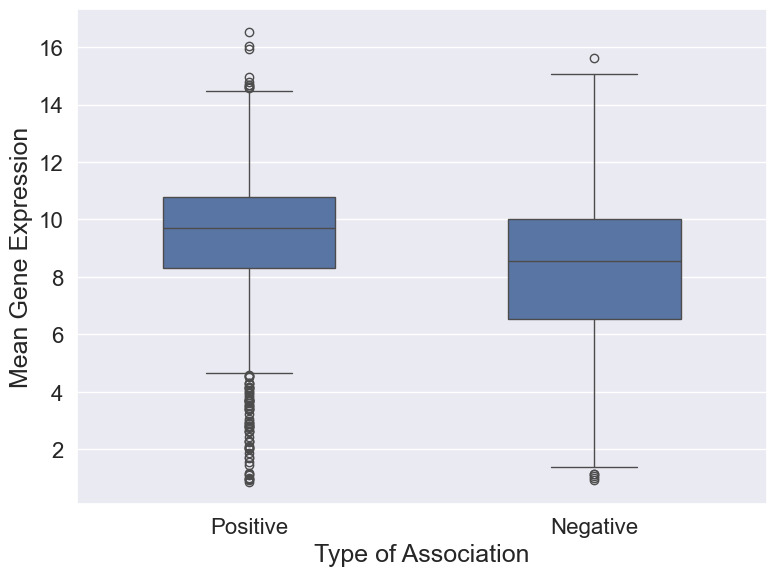


U-statistic for gene expression comparison: 1530654.0
P-value for gene expression comparison: 6.757185720072671e-43
There is a statistically significant difference in mean gene expression levels between positive and negative neighbours.


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Assuming you have the actual data in the following dataframes:
# tumourexp: DataFrame with expression values
# only_pos_variability: DataFrame with 'neighbour' index for positive neighbours
# only_neg_variability: DataFrame with 'neighbour' index for negative neighbours

# Calculate mean expression for positive and negative neighbors
mean_expression_positive = tumourexp[only_pos_variability.index].mean(axis=0)
mean_expression_negative = tumourexp[only_neg_variability.index].mean(axis=0)

# Create a DataFrame for visualization
df_expression = pd.DataFrame({
    'Mean Expression': np.concatenate([mean_expression_positive, mean_expression_negative]),
    'Association Type': ['Positive'] * len(mean_expression_positive) + ['Negative'] * len(mean_expression_negative)
})

# Plot boxplot comparing mean expression levels between positive and negative neighbors
plt.figure(figsize=(8, 6))  # Ajuste o figsize para um gráfico mais estreito

sns.boxplot(x='Association Type', y='Mean Expression', data=df_expression, width=0.5)

# Increase font sizes for the plot
plt.xlabel('Type of Association', fontsize=18)  # X-axis label size
plt.ylabel('Mean Gene Expression', fontsize=18)  # Y-axis label size
#plt.title('Distribution of Mean Gene Expression for Positive and Negative Neighbours', fontsize=20)  # Title size

# Increase font size for ticks
plt.xticks(fontsize=16)  # X-axis ticks size
plt.yticks(fontsize=16)  # Y-axis ticks size

# Show the plot
plt.tight_layout()
plt.show()

# Statistical test to compare gene expression levels between positive and negative neighbors
u_stat_exp, p_value_exp = stats.mannwhitneyu(mean_expression_positive, mean_expression_negative)
print(f"\nU-statistic for gene expression comparison: {u_stat_exp}")
print(f"P-value for gene expression comparison: {p_value_exp}")
if p_value_exp < 0.05:
    print("There is a statistically significant difference in mean gene expression levels between positive and negative neighbours.")
else:
    print("No statistically significant difference in mean gene expression levels between positive and negative neighbours.")

### SIG VS NON SIG

#### Filtered

P-value for homoscedasticity: 1.0140250614527672e-05


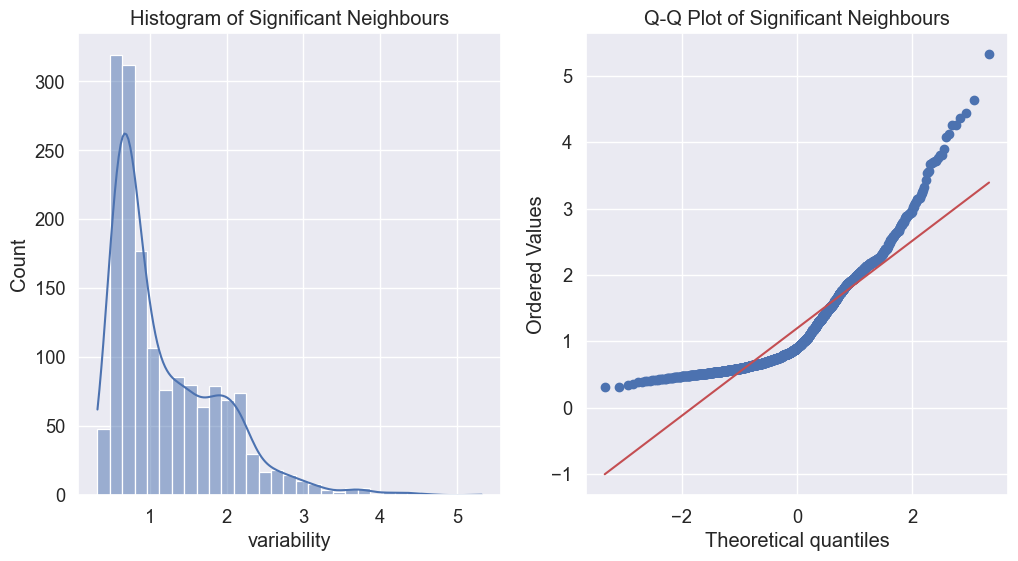

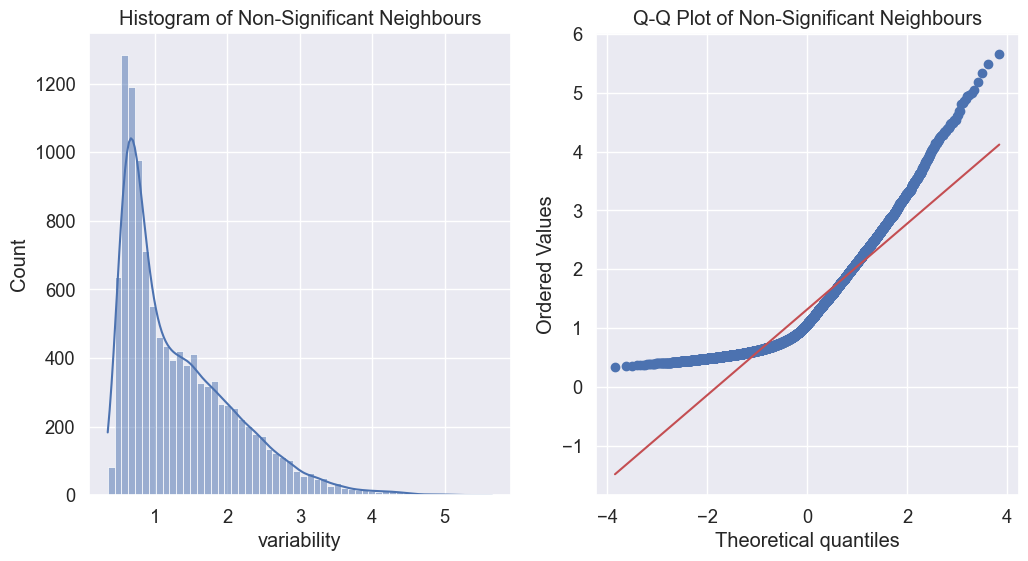

P-value for KS test (Significant): 0.0
P-value for KS test (Non-Significant): 0.0
Using Mann-Whitney U test:
U Statistic: 8308267.0
P-value: 5.043197301954638e-11


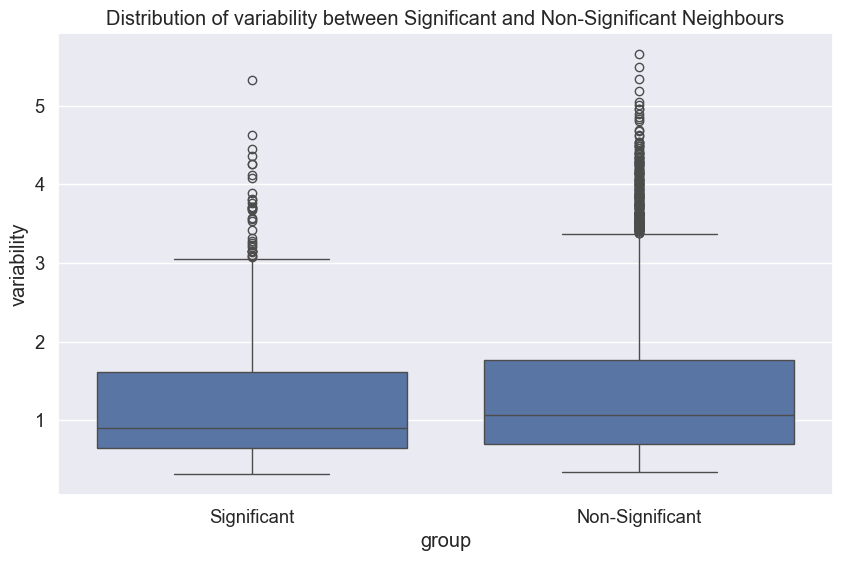

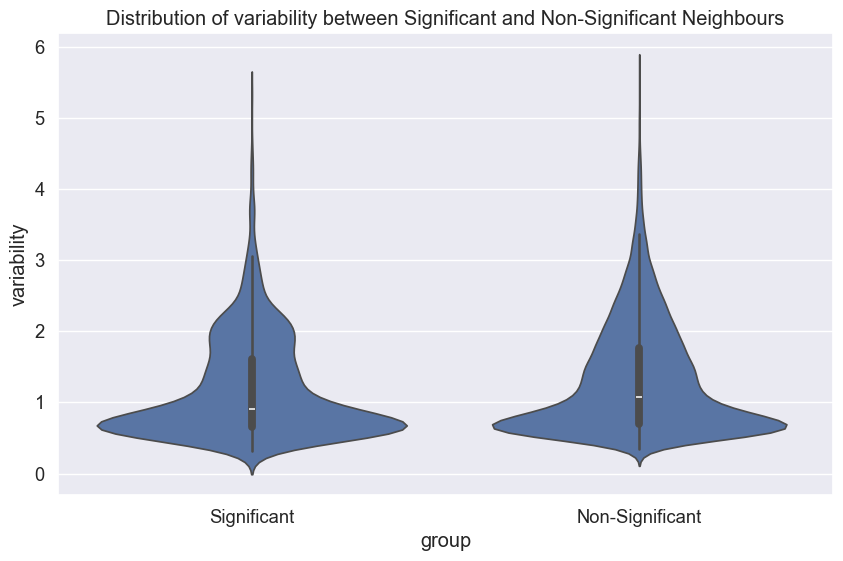

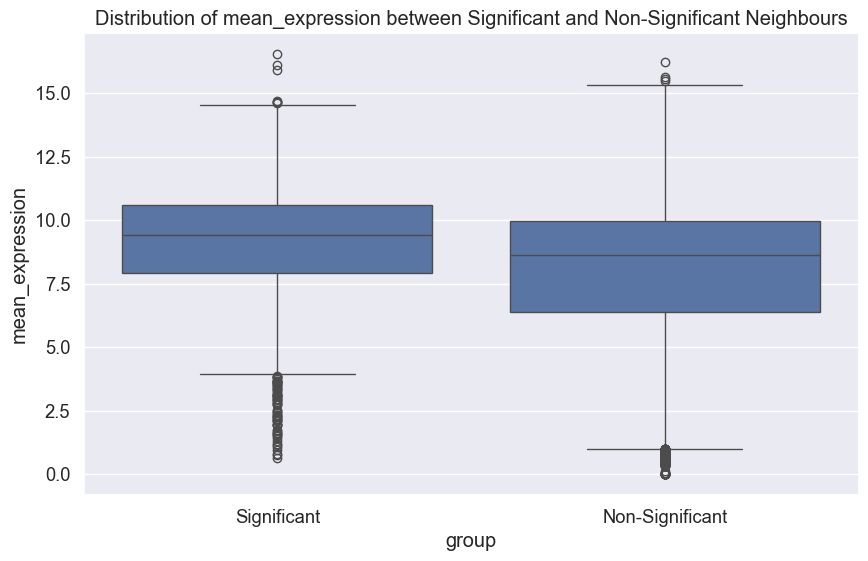

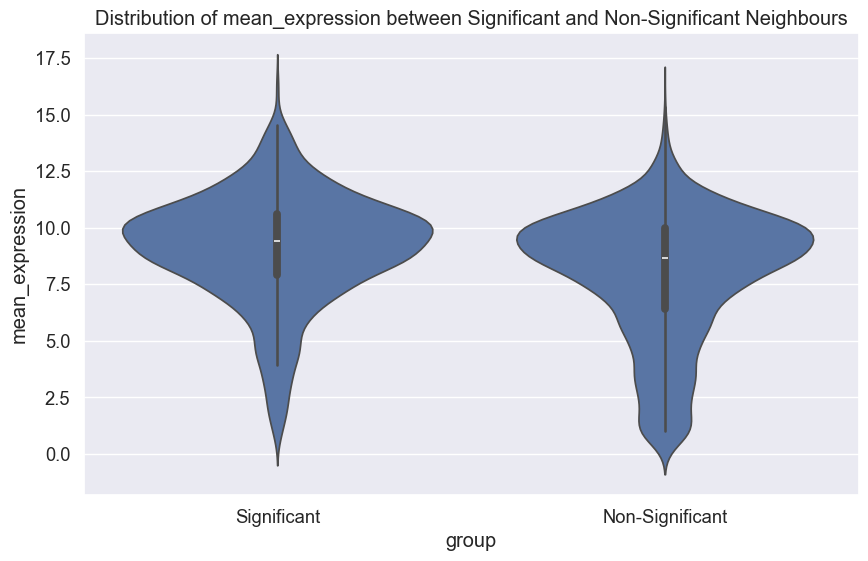

Mean gene expression (Significant): 9.0901
Mean gene expression (Non-Significant): 7.9389
Median gene expression (Significant): 9.4150
Median gene expression (Non-Significant): 8.6500
U-statistic: 11273338.0
P-value: 1.3471231752589784e-46
There is a statistically significant difference in mean expression levels.
Cohen's d: 0.4247
Rank Biserial Correlation: -0.2200


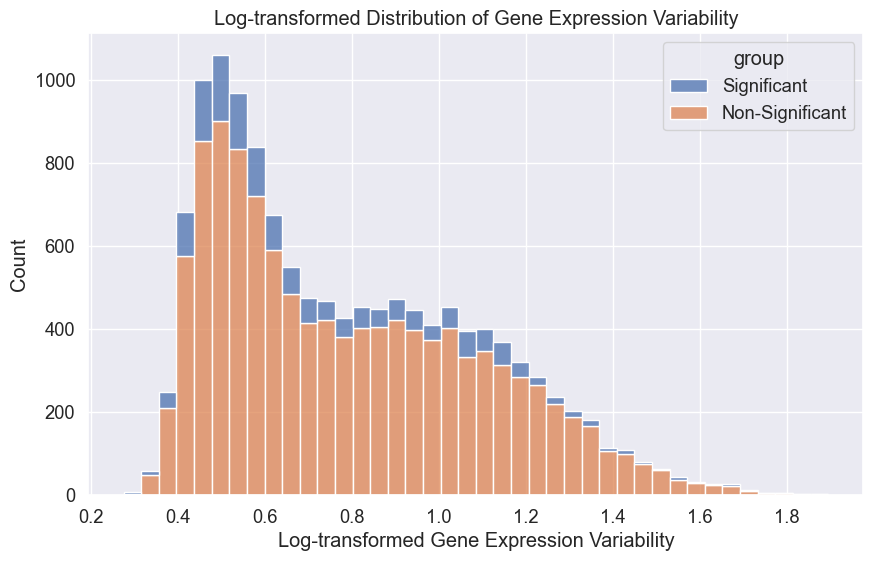

P-value for KS test after log transformation (Significant): 0.0
P-value for KS test after log transformation (Non-Significant): 0.0
P-value for homoscedasticity after log transformation: 0.00027268378183552863
Using Mann-Whitney U test after log transformation:
U Statistic: 8308267.0
P-value: 5.043197301954638e-11


In [58]:
#### RETIRAR DOCUMENTAÇÃO DAQUI PARA BAIXO ####

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Auxiliary Functions
def calculate_variability(df, neighbour):
    """Calculate standard deviation across all patients for a given gene (neighbour)."""
    if neighbour not in df.columns:
        raise ValueError(f"Neighbour '{neighbour}' not found in the dataframe.")
    return df[neighbour].std()

def check_homogeneity_of_variances(group1, group2):
    """Check homogeneity of variances using Levene's test."""
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    stat, p_value = stats.levene(group1, group2)
    return p_value

def test_ks(data):
    """Kolmogorov-Smirnov test for checking normality."""
    if len(data) == 0:
        raise ValueError("Data is empty.")
    stat, p_value = stats.kstest(data, 'norm')
    return p_value

def plot_distribution(data, label):
    """Plot histogram and Q-Q plot for a dataset."""
    if len(data) == 0:
        raise ValueError("Data is empty.")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {label}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {label}')
    plt.show()

def compare_groups(variability_df, group_col='group', value_col='variability'):
    """Perform statistical tests and plot distributions between significant and non-significant groups."""
    if group_col not in variability_df.columns or value_col not in variability_df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    # Variance check
    p_value_variance = check_homogeneity_of_variances(
        variability_df[variability_df[group_col] == 'Significant'][value_col],
        variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
    )
    
    print(f"P-value for homoscedasticity: {p_value_variance}")
    
    # Plot distributions
    plot_distribution(variability_df[variability_df[group_col] == 'Significant'][value_col], 'Significant Neighbours')
    plot_distribution(variability_df[variability_df[group_col] == 'Non-Significant'][value_col], 'Non-Significant Neighbours')
    
    # Kolmogorov-Smirnov Test
    ks_p_value_sig = test_ks(variability_df[variability_df[group_col] == 'Significant'][value_col])
    ks_p_value_non_sig = test_ks(variability_df[variability_df[group_col] == 'Non-Significant'][value_col])
    print(f"P-value for KS test (Significant): {ks_p_value_sig}")
    print(f"P-value for KS test (Non-Significant): {ks_p_value_non_sig}")
    
    # Choose appropriate test (Mann-Whitney U or t-test)
    if ks_p_value_sig < 0.05 or ks_p_value_non_sig < 0.05 or p_value_variance < 0.05:
        # If data is not normal or variances are not homogeneous, use Mann-Whitney U test
        u_stat, u_p_value = stats.mannwhitneyu(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using Mann-Whitney U test:\nU Statistic: {u_stat}\nP-value: {u_p_value}")
    else:
        # If data is normal and variances are homogeneous, use t-test
        t_stat, t_p_value = stats.ttest_ind(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using t-test:\nt Statistic: {t_stat}\nP-value: {t_p_value}")

def plot_group_comparison(df, value_col, group_col='group'):
    """Plot boxplot and violin plot for group comparison."""
    if group_col not in df.columns or value_col not in df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_col, y=value_col, data=df)
    plt.title(f'Distribution of {value_col} between Significant and Non-Significant Neighbours')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=group_col, y=value_col, data=df)
    plt.title(f'Distribution of {value_col} between Significant and Non-Significant Neighbours')
    plt.show()

def calculate_effect_size(group1, group2):
    """Calculate Cohen's d for effect size."""
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
    return diff / pooled_std

def calculate_rank_biserial_correlation(group1, group2):
    """Calculate rank biserial correlation."""
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    u_stat, _ = stats.mannwhitneyu(group1, group2)
    n1 = len(group1)
    n2 = len(group2)
    return 1 - (2 * u_stat / (n1 * n2))

# Main Analysis
def main():
    # Load data
    # Note: These lines assume that 'resultsfiltered', 'nonsignificant', and 'tumourexp' are loaded from somewhere
    # You might need to add code to load these dataframes from files
    # Calculate variability and mean expression
    try:
        variability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighbours_filt]
        variability_non_significant = [calculate_variability(tumourexp, neighbour) for neighbour in non_significant_neighbours_filt]
        mean_expression_significant = filt_neighbours[filt_neighbours['neighbour'].isin(significant_neighbours_filt)]['expression'].tolist()
        mean_expression_non_significant = filt_neighbours[filt_neighbours['neighbour'].isin(non_significant_neighbours_filt)]['expression'].tolist()
    except ValueError as e:
        print(f"Error in calculating variability or mean expression: {e}")
        return

    # Create DataFrame for analysis
    variability_df = pd.DataFrame({
        'neighbour': np.concatenate([significant_neighbours_filt, non_significant_neighbours_filt]),
        'variability': variability_significant + variability_non_significant,
        'group': ['Significant'] * len(variability_significant) + ['Non-Significant'] * len(variability_non_significant),
        'mean_expression': mean_expression_significant + mean_expression_non_significant
    })

    # Perform group comparison
    compare_groups(variability_df)
    plot_group_comparison(variability_df, 'variability')
    plot_group_comparison(variability_df, 'mean_expression')

    # Mean Gene Expression Analysis
    mean_sig = np.mean(mean_expression_significant)
    mean_non_sig = np.mean(mean_expression_non_significant)
    median_sig = np.median(mean_expression_significant)
    median_non_sig = np.median(mean_expression_non_significant)

    print(f"Mean gene expression (Significant): {mean_sig:.4f}")
    print(f"Mean gene expression (Non-Significant): {mean_non_sig:.4f}")
    print(f"Median gene expression (Significant): {median_sig:.4f}")
    print(f"Median gene expression (Non-Significant): {median_non_sig:.4f}")

    # Statistical comparison of mean gene expression
    sig_exp_levels = tumourexp[significant_neighbours_filt].mean(axis=0)
    non_sig_exp_levels = tumourexp[non_significant_neighbours_filt].mean(axis=0)

    u_stat, p_value = stats.mannwhitneyu(sig_exp_levels, non_sig_exp_levels, alternative='two-sided')
    print(f"U-statistic: {u_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("There is a statistically significant difference in mean expression levels.")
    else:
        print("No statistically significant difference in mean expression levels.")

    # Calculate effect size and rank biserial correlation
    cohen_d_value = calculate_effect_size(sig_exp_levels, non_sig_exp_levels)
    rank_biserial_corr = calculate_rank_biserial_correlation(sig_exp_levels, non_sig_exp_levels)

    print(f"Cohen's d: {cohen_d_value:.4f}")
    print(f"Rank Biserial Correlation: {rank_biserial_corr:.4f}")

    # Log transformation
    variability_df['log_variability'] = np.log1p(variability_df['variability'])

    # Plot log-transformed distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=variability_df, x='log_variability', hue='group', multiple='stack')
    plt.xlabel('Log-transformed Gene Expression Variability')
    plt.ylabel('Count')
    plt.title('Log-transformed Distribution of Gene Expression Variability')
    plt.show()

    # Re-run normality and variance tests after log transformation
    ks_p_value_sig_log = test_ks(variability_df[variability_df['group'] == 'Significant']['log_variability'])
    ks_p_value_non_sig_log = test_ks(variability_df[variability_df['group'] == 'Non-Significant']['log_variability'])

    print(f"P-value for KS test after log transformation (Significant): {ks_p_value_sig_log}")
    print(f"P-value for KS test after log transformation (Non-Significant): {ks_p_value_non_sig_log}")

    # Check homogeneity of variances using Levene's test after log transformation
    p_value_variance_log = check_homogeneity_of_variances(
        variability_df[variability_df['group'] == 'Significant']['log_variability'],
        variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
    )
    print(f"P-value for homoscedasticity after log transformation: {p_value_variance_log}")

    # Perform appropriate statistical test after log transformation
    if ks_p_value_sig_log < 0.05 or ks_p_value_non_sig_log < 0.05 or p_value_variance_log < 0.05:
        u_stat_log, u_p_value_log = stats.mannwhitneyu(
            variability_df[variability_df['group'] == 'Significant']['log_variability'],
            variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
        )
        print(f"Using Mann-Whitney U test after log transformation:\nU Statistic: {u_stat_log}\nP-value: {u_p_value_log}")
    else:
        t_stat_log, t_p_value_log = stats.ttest_ind(
            variability_df[variability_df['group'] == 'Significant']['log_variability'],
            variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
        )
        print(f"Using t-test after log transformation:\nt Statistic: {t_stat_log}\nP-value: {t_p_value_log}")

if __name__ == "__main__":
    main()

P-value for homoscedasticity: 1.0140250614527672e-05


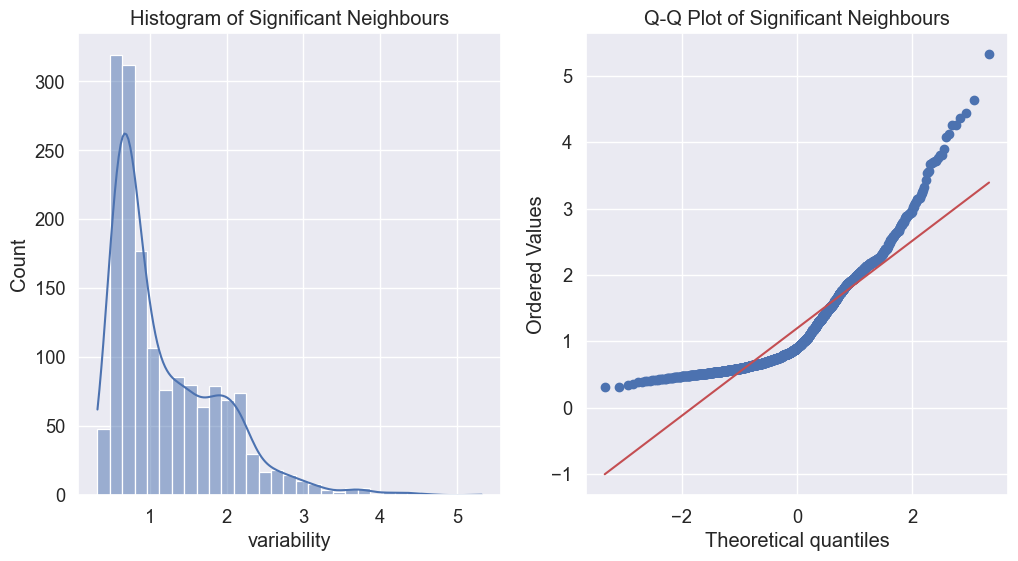

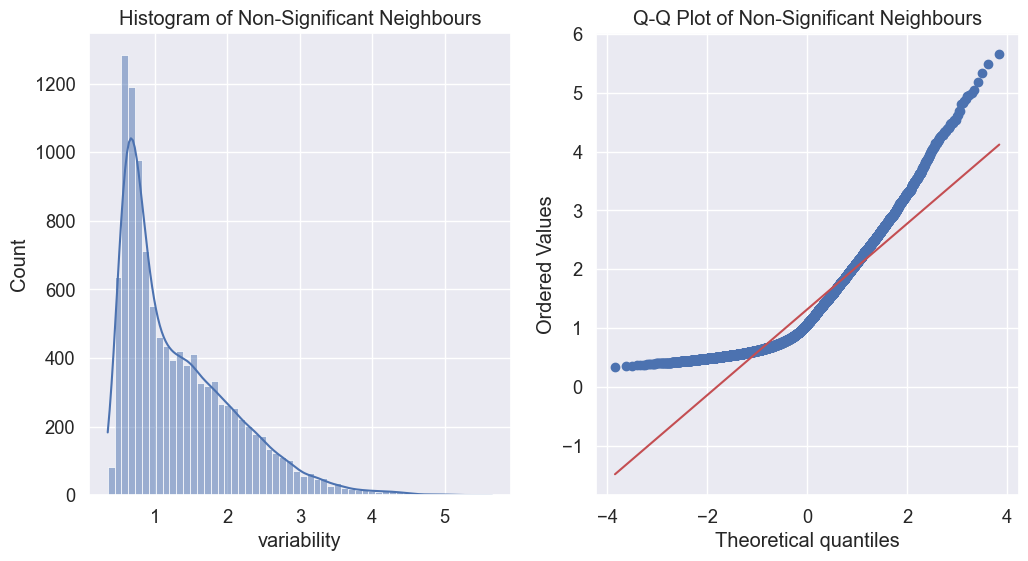

P-value for KS test (Significant): 0.0
P-value for KS test (Non-Significant): 0.0
Using Mann-Whitney U test:
U Statistic: 8308267.0
P-value: 5.043197301954638e-11


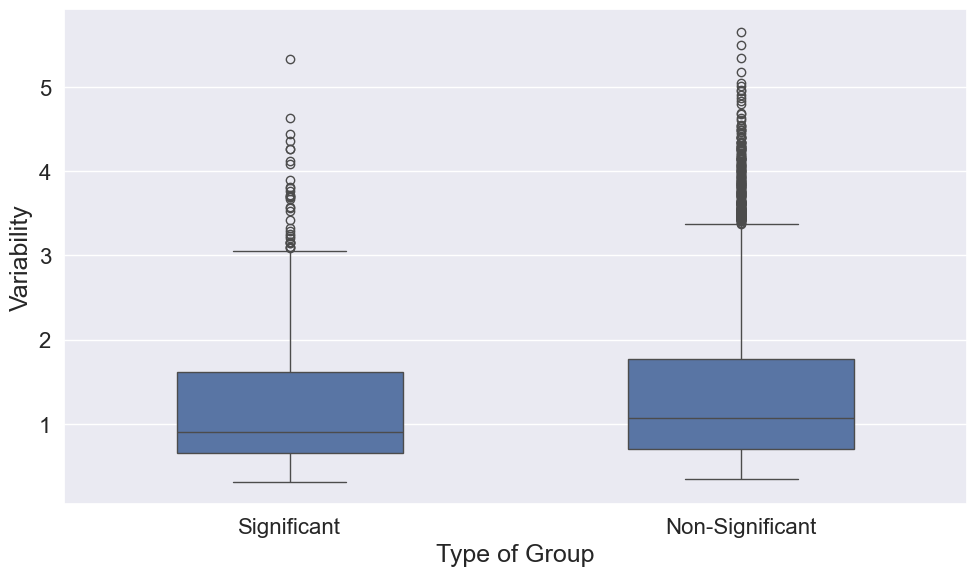

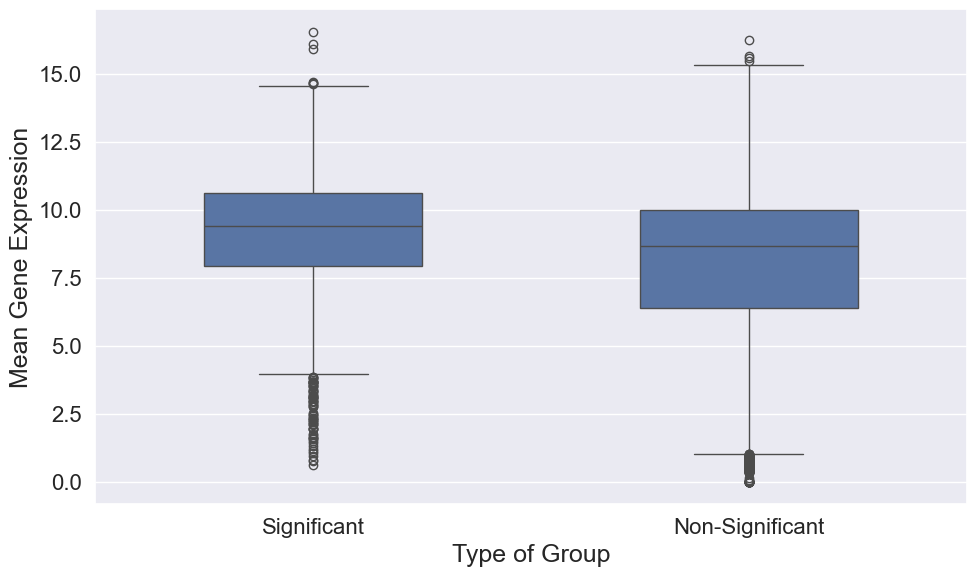

Mean gene expression (Significant): 9.0901
Mean gene expression (Non-Significant): 7.9389
Median gene expression (Significant): 9.4150
Median gene expression (Non-Significant): 8.6500
U-statistic: 11273338.0
P-value: 1.3471231752589784e-46
There is a statistically significant difference in mean expression levels.
Cohen's d: 0.4247
Rank Biserial Correlation: -0.2200


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Auxiliary Functions
def calculate_variability(df, neighbour):
    if neighbour not in df.columns:
        raise ValueError(f"Neighbour '{neighbour}' not found in the dataframe.")
    return df[neighbour].std()

def check_homogeneity_of_variances(group1, group2):
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    stat, p_value = stats.levene(group1, group2)
    return p_value

def test_ks(data):
    if len(data) == 0:
        raise ValueError("Data is empty.")
    stat, p_value = stats.kstest(data, 'norm')
    return p_value

def plot_distribution(data, label):
    if len(data) == 0:
        raise ValueError("Data is empty.")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {label}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {label}')
    plt.show()

def compare_groups(variability_df, group_col='group', value_col='variability'):
    if group_col not in variability_df.columns or value_col not in variability_df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    p_value_variance = check_homogeneity_of_variances(
        variability_df[variability_df[group_col] == 'Significant'][value_col],
        variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
    )
    
    print(f"P-value for homoscedasticity: {p_value_variance}")
    
    plot_distribution(variability_df[variability_df[group_col] == 'Significant'][value_col], 'Significant Neighbours')
    plot_distribution(variability_df[variability_df[group_col] == 'Non-Significant'][value_col], 'Non-Significant Neighbours')
    
    ks_p_value_sig = test_ks(variability_df[variability_df[group_col] == 'Significant'][value_col])
    ks_p_value_non_sig = test_ks(variability_df[variability_df[group_col] == 'Non-Significant'][value_col])
    print(f"P-value for KS test (Significant): {ks_p_value_sig}")
    print(f"P-value for KS test (Non-Significant): {ks_p_value_non_sig}")
    
    if ks_p_value_sig < 0.05 or ks_p_value_non_sig < 0.05 or p_value_variance < 0.05:
        u_stat, u_p_value = stats.mannwhitneyu(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using Mann-Whitney U test:\nU Statistic: {u_stat}\nP-value: {u_p_value}")
    else:
        t_stat, t_p_value = stats.ttest_ind(
            variability_df[variability_df[group_col] == 'Significant'][value_col],
            variability_df[variability_df[group_col] == 'Non-Significant'][value_col]
        )
        print(f"Using t-test:\nt Statistic: {t_stat}\nP-value: {t_p_value}")

def plot_group_comparison(df, value_col, group_col='group', y_label='', boxplot_width=0.4):
    if group_col not in df.columns or value_col not in df.columns:
        raise ValueError(f"Columns {group_col} or {value_col} not found in the dataframe.")
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_col, y=value_col, data=df, width=boxplot_width)  # Define boxplot width
    plt.ylabel(y_label, fontsize=18)
    plt.xlabel('Type of Group', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

def calculate_effect_size(group1, group2):
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
    return diff / pooled_std

def calculate_rank_biserial_correlation(group1, group2):
    if len(group1) == 0 or len(group2) == 0:
        raise ValueError("One or both groups are empty.")
    u_stat, _ = stats.mannwhitneyu(group1, group2)
    n1 = len(group1)
    n2 = len(group2)
    return 1 - (2 * u_stat / (n1 * n2))

def main():
    try:
        variability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighbours_filt]
        variability_non_significant = [calculate_variability(tumourexp, neighbour) for neighbour in non_significant_neighbours_filt]
        mean_expression_significant = filt_neighbours[filt_neighbours['neighbour'].isin(significant_neighbours_filt)]['expression'].tolist()
        mean_expression_non_significant = filt_neighbours[filt_neighbours['neighbour'].isin(non_significant_neighbours_filt)]['expression'].tolist()
    except ValueError as e:
        print(f"Error in calculating variability or mean expression: {e}")
        return

    variability_df = pd.DataFrame({
        'neighbour': np.concatenate([significant_neighbours_filt, non_significant_neighbours_filt]),
        'variability': variability_significant + variability_non_significant,
        'group': ['Significant'] * len(variability_significant) + ['Non-Significant'] * len(variability_non_significant),
        'mean_expression': mean_expression_significant + mean_expression_non_significant
    })

    compare_groups(variability_df)
    
    # Plotting Variability with y-axis label and no title, narrower boxplot
    plot_group_comparison(variability_df, 'variability', y_label='Variability', boxplot_width=0.5)

    # Plotting Mean Expression with y-axis label and no title, narrower boxplot
    plot_group_comparison(variability_df, 'mean_expression', y_label='Mean Gene Expression', boxplot_width=0.5)

    mean_sig = np.mean(mean_expression_significant)
    mean_non_sig = np.mean(mean_expression_non_significant)
    median_sig = np.median(mean_expression_significant)
    median_non_sig = np.median(mean_expression_non_significant)

    print(f"Mean gene expression (Significant): {mean_sig:.4f}")
    print(f"Mean gene expression (Non-Significant): {mean_non_sig:.4f}")
    print(f"Median gene expression (Significant): {median_sig:.4f}")
    print(f"Median gene expression (Non-Significant): {median_non_sig:.4f}")

    sig_exp_levels = tumourexp[significant_neighbours_filt].mean(axis=0)
    non_sig_exp_levels = tumourexp[non_significant_neighbours_filt].mean(axis=0)

    u_stat, p_value = stats.mannwhitneyu(sig_exp_levels, non_sig_exp_levels, alternative='two-sided')
    print(f"U-statistic: {u_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("There is a statistically significant difference in mean expression levels.")
    else:
        print("No statistically significant difference in mean expression levels.")

    cohen_d_value = calculate_effect_size(sig_exp_levels, non_sig_exp_levels)
    rank_biserial_corr = calculate_rank_biserial_correlation(sig_exp_levels, non_sig_exp_levels)

    print(f"Cohen's d: {cohen_d_value:.4f}")
    print(f"Rank Biserial Correlation: {rank_biserial_corr:.4f}")

if __name__ == "__main__":
    main()


#### All DINTs

P-value for homoscedasticity: 3.064290831608017e-05


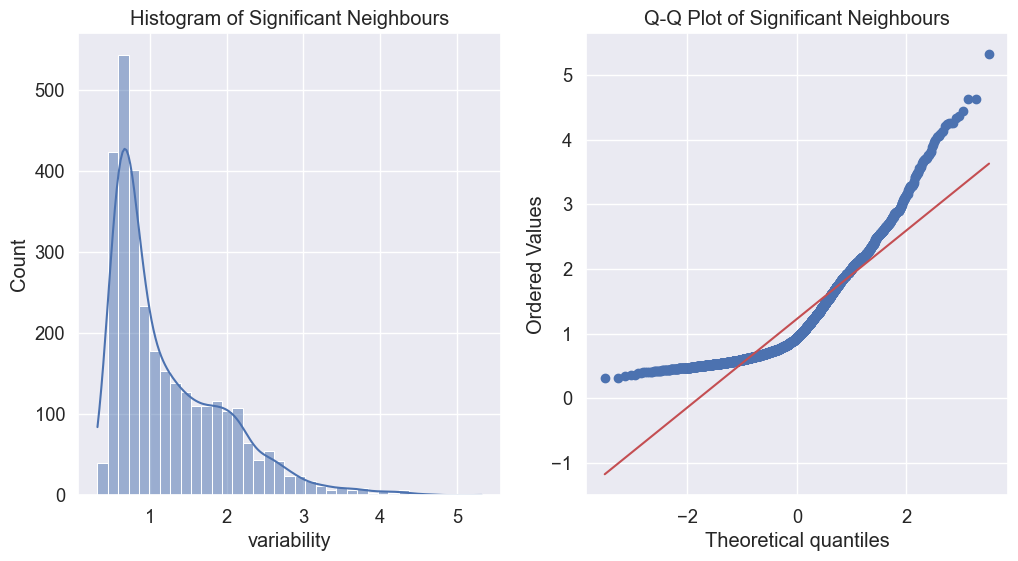

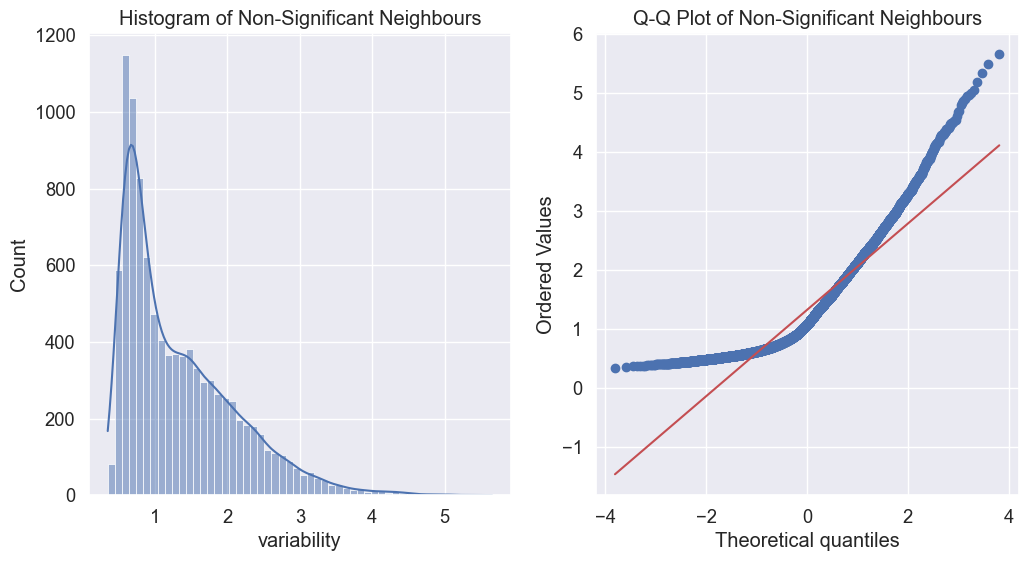

P-value for KS test (Significant): 0.0
P-value for KS test (Non-Significant): 0.0
Using Mann-Whitney U test:
U Statistic: 14188130.0
P-value: 5.734718584628933e-13


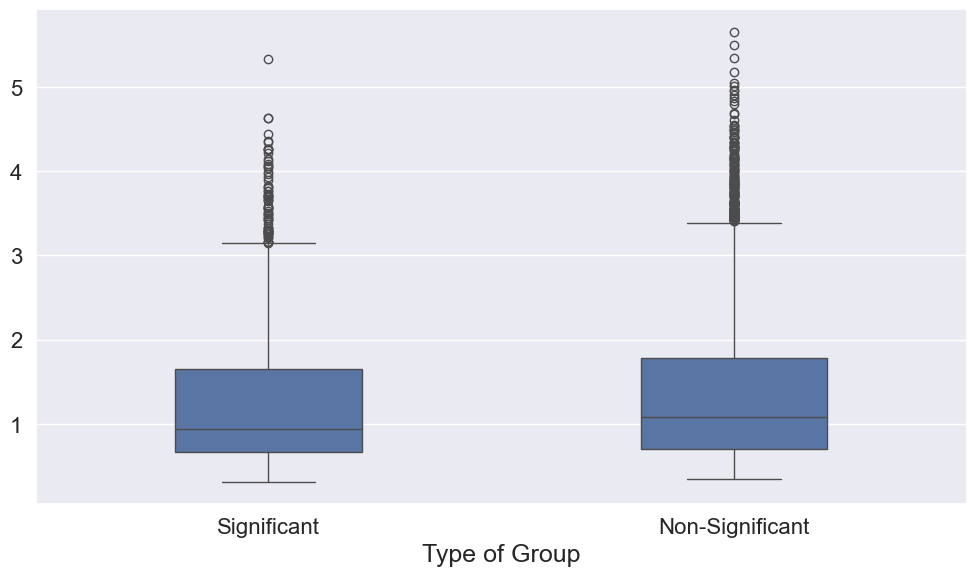

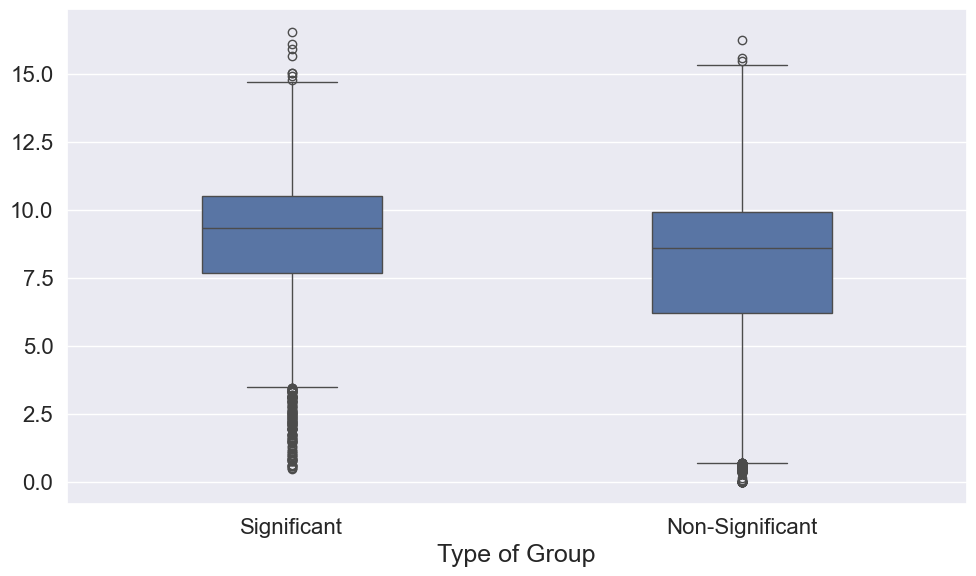

Mean gene expression (Significant): 8.8820
Mean gene expression (Non-Significant): 7.8298
Median gene expression (Significant): 9.3100
Median gene expression (Non-Significant): 8.5800
U-statistic: 18687053.0
P-value: 7.65102001197594e-67
There is a statistically significant difference in mean expression levels.
Cohen's d: 0.3852
Rank Biserial Correlation: -0.2046


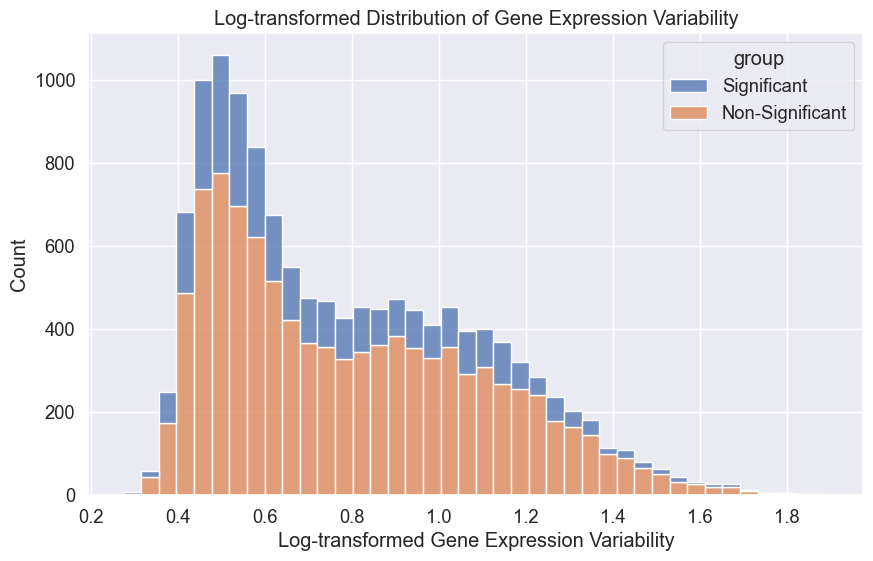

P-value for KS test after log transformation (Significant): 0.0
P-value for KS test after log transformation (Non-Significant): 0.0
P-value for homoscedasticity after log transformation: 0.0008701148809409057
Using Mann-Whitney U test after log transformation:
U Statistic: 14188130.0
P-value: 5.734718584628933e-13


In [60]:
# Main Analysis
def main():
    try:
        variability_significant = [calculate_variability(tumourexp, neighbour) for neighbour in significant_neighbours]
        variability_non_significant = [calculate_variability(tumourexp, neighbour) for neighbour in non_significant_neighbours]
        mean_expression_significant = filt_neighbours[filt_neighbours['neighbour'].isin(significant_neighbours)]['expression'].tolist()
        mean_expression_non_significant = filt_neighbours[filt_neighbours['neighbour'].isin(non_significant_neighbours)]['expression'].tolist()
    except ValueError as e:
        print(f"Error in calculating variability or mean expression: {e}")
        return

    # Create DataFrame for analysis
    variability_df = pd.DataFrame({
        'neighbour': np.concatenate([significant_neighbours, non_significant_neighbours]),
        'variability': variability_significant + variability_non_significant,
        'group': ['Significant'] * len(variability_significant) + ['Non-Significant'] * len(variability_non_significant),
        'mean_expression': mean_expression_significant + mean_expression_non_significant
    })

    # Perform group comparison
    compare_groups(variability_df)
    plot_group_comparison(variability_df, 'variability')
    plot_group_comparison(variability_df, 'mean_expression')

    # Mean Gene Expression Analysis
    mean_sig = np.mean(mean_expression_significant)
    mean_non_sig = np.mean(mean_expression_non_significant)
    median_sig = np.median(mean_expression_significant)
    median_non_sig = np.median(mean_expression_non_significant)

    print(f"Mean gene expression (Significant): {mean_sig:.4f}")
    print(f"Mean gene expression (Non-Significant): {mean_non_sig:.4f}")
    print(f"Median gene expression (Significant): {median_sig:.4f}")
    print(f"Median gene expression (Non-Significant): {median_non_sig:.4f}")

    # Statistical comparison of mean gene expression
    sig_exp_levels = tumourexp[significant_neighbours].mean(axis=0)
    non_sig_exp_levels = tumourexp[non_significant_neighbours].mean(axis=0)

    u_stat, p_value = stats.mannwhitneyu(sig_exp_levels, non_sig_exp_levels, alternative='two-sided')
    print(f"U-statistic: {u_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("There is a statistically significant difference in mean expression levels.")
    else:
        print("No statistically significant difference in mean expression levels.")

    # Calculate effect size and rank biserial correlation
    cohen_d_value = calculate_effect_size(sig_exp_levels, non_sig_exp_levels)
    rank_biserial_corr = calculate_rank_biserial_correlation(sig_exp_levels, non_sig_exp_levels)

    print(f"Cohen's d: {cohen_d_value:.4f}")
    print(f"Rank Biserial Correlation: {rank_biserial_corr:.4f}")

    # Log transformation
    variability_df['log_variability'] = np.log1p(variability_df['variability'])

    # Plot log-transformed distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=variability_df, x='log_variability', hue='group', multiple='stack')
    plt.xlabel('Log-transformed Gene Expression Variability')
    plt.ylabel('Count')
    plt.title('Log-transformed Distribution of Gene Expression Variability')
    plt.show()

    # Re-run normality and variance tests after log transformation
    ks_p_value_sig_log = test_ks(variability_df[variability_df['group'] == 'Significant']['log_variability'])
    ks_p_value_non_sig_log = test_ks(variability_df[variability_df['group'] == 'Non-Significant']['log_variability'])

    print(f"P-value for KS test after log transformation (Significant): {ks_p_value_sig_log}")
    print(f"P-value for KS test after log transformation (Non-Significant): {ks_p_value_non_sig_log}")

    # Check homogeneity of variances using Levene's test after log transformation
    p_value_variance_log = check_homogeneity_of_variances(
        variability_df[variability_df['group'] == 'Significant']['log_variability'],
        variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
    )
    print(f"P-value for homoscedasticity after log transformation: {p_value_variance_log}")

    # Perform appropriate statistical test after log transformation
    if ks_p_value_sig_log < 0.05 or ks_p_value_non_sig_log < 0.05 or p_value_variance_log < 0.05:
        u_stat_log, u_p_value_log = stats.mannwhitneyu(
            variability_df[variability_df['group'] == 'Significant']['log_variability'],
            variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
        )
        print(f"Using Mann-Whitney U test after log transformation:\nU Statistic: {u_stat_log}\nP-value: {u_p_value_log}")
    else:
        t_stat_log, t_p_value_log = stats.ttest_ind(
            variability_df[variability_df['group'] == 'Significant']['log_variability'],
            variability_df[variability_df['group'] == 'Non-Significant']['log_variability']
        )
        print(f"Using t-test after log transformation:\nt Statistic: {t_stat_log}\nP-value: {t_p_value_log}")

if __name__ == "__main__":
    main()

## Enrichment Analysis

#### POS VS NEG

In [61]:
only_pos = only_pos_variability.index.tolist()
only_neg = only_neg_variability.index.tolist()

In [62]:
print(len(only_pos))
print(len(only_neg))

1727
1378


In [63]:
# Carregar dados de hallmarks do câncer
#hallmarks_df = pd.read_excel('hallmarks_to_goterms.xlsx')

# Função para realizar análise de enriquecimento
def perform_enrichment(gene_list, background, sources):
    gp = GProfiler(return_dataframe=True)
    results = {}
    for source in sources:
        results[source] = gp.profile(
            organism='hsapiens',
            query=gene_list,
            user_threshold=0.05,
            no_evidences=False,
            sources=[source],
            all_results=False,
            domain_scope='annotated',
            background=background,
            significance_threshold_method='fdr'
        )
    return results

# Definir fontes para enriquecimento
sources = ["GO:MF", "GO:CC", "GO:BP", "KEGG", "REAC", "WP"]

# Realizar análise de enriquecimento para vizinhos positivos e negativos
pos_enrichment = perform_enrichment(only_pos, background, sources)
neg_enrichment = perform_enrichment(only_neg, background, sources)

In [64]:
all_intersections_set = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = pos_enrichment[source]
        dic_filt_pos = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set
        for intersection_list in dic_filt_pos['intersections']:
            all_intersections_set.update(intersection_list)

# Count how many values from only_pos appear in the set of intersections
count_only_pos_in_intersections = sum(1 for item in only_pos if item in all_intersections_set)

print(f"Number of values from only_pos that appear in the intersections: {count_only_pos_in_intersections}")
proportion = count_only_pos_in_intersections / len(only_pos) 
print(f"Proportion of values from only_pos that appear in the intersections: {proportion}")

Number of values from only_pos that appear in the intersections: 870
Proportion of values from only_pos that appear in the intersections: 0.5037637521713955


In [65]:
# Define the function to count intersections
def count_intersections(row, only_pos_set):
    intersections = row['intersections']
    # Convert the string of intersections to a list, if necessary
    if isinstance(intersections, str):
        intersections = intersections.strip('[]').replace("'", "").split(', ')
    return sum(1 for item in intersections if item in only_pos_set)

# Convert only_pos to a set for faster lookup
only_pos_set = set(only_pos)

# Apply the function to count intersections and store in a new column
dic_filt_pos['only_pos_count'] = dic_filt_pos.apply(count_intersections, axis=1, only_pos_set=only_pos_set)

# Sort the DataFrame by 'only_pos_count' in descending order and reset the index
dic_filt_pos_sorted = dic_filt_pos[['native', 'only_pos_count']].sort_values('only_pos_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame
print(dic_filt_pos_sorted)

        native  only_pos_count
0   GO:0007049             426
1   GO:0012501             317
2   GO:0008283             263
3   GO:0043067             252
4   GO:0006955             204
5   GO:0051301             182
6   GO:0006281             174
7   GO:0043069             149
8   GO:0009968             146
9   GO:0008284             134
10  GO:0050776             125
11  GO:0045786              99
12  GO:0045786              99
13  GO:0045787              94
14  GO:0008285              79
15  GO:0032200              68
16  GO:0000723              65
17  GO:0006282              59
18  GO:0031570              49
19  GO:0032204              42
20  GO:0090398              28
21  GO:0071456              24
22  GO:0045005              21
23  GO:0006096              15
24  GO:2000772              13


In [66]:
all_intersections_set_neg = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = neg_enrichment[source]
        dic_filt_neg = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_neg
        for intersection_list in dic_filt_neg['intersections']:
            all_intersections_set_neg.update(intersection_list)

# Count how many values from only_neg appear in the set of intersections
count_only_neg_in_intersections = sum(1 for item in only_neg if item in all_intersections_set_neg)

print(f"Number of values from only_neg that appear in the intersections: {count_only_neg_in_intersections}")
proportion = count_only_neg_in_intersections / len(only_neg) 
print(f"Proportion of values from only_neg that appear in the intersections: {proportion}")

Number of values from only_neg that appear in the intersections: 738
Proportion of values from only_neg that appear in the intersections: 0.5355587808417998


In [67]:
only_neg_set = set(only_neg)

# Apply the function to count intersections and store in a new column
dic_filt_neg['only_neg_count'] = dic_filt_neg.apply(count_intersections, axis=1, only_pos_set=only_neg_set)

# Sort the DataFrame by 'only_neg_count' in descending order and reset the index
dic_filt_neg_sorted = dic_filt_neg[['native', 'only_neg_count']].sort_values('only_neg_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean index
print(dic_filt_neg_sorted)

        native  only_neg_count
0   GO:0008283             258
1   GO:0030030             232
2   GO:0016477             221
3   GO:0012501             214
4   GO:0007155             195
5   GO:0043067             175
6   GO:0007049             162
7   GO:0009968             148
8   GO:0034330             143
9   GO:0008284             134
10  GO:0043069             106
11  GO:0030155              99
12  GO:0008285              88
13  GO:0001525              85
14  GO:0051301              62
15  GO:0050727              41
16  GO:0001837              33
17  GO:0030307              30
18  GO:0007162              30
19  GO:0045766              29
20  GO:0030308              24
21  GO:0001570              21
22  GO:0071456              20


In [69]:
# Create DataFrames with native and proportions
pos_proportions = dic_filt_pos[['native', 'only_pos_count']].copy()
neg_proportions = dic_filt_neg[['native', 'only_neg_count']].copy()

# Calculate proportions
pos_proportions['pos_proportion'] = pos_proportions['only_pos_count'] / len(only_pos)
neg_proportions['neg_proportion'] = neg_proportions['only_neg_count'] / len(only_neg)

# Merge the two DataFrames on 'native' column
combined_proportions = pd.merge(
    pos_proportions[['native', 'pos_proportion']], 
    neg_proportions[['native', 'neg_proportion']], 
    on='native', 
    how='outer'
)

# Fill NaN values with 0
combined_proportions = combined_proportions.fillna(0)

# Add the 'name' column from the hallmarks_df to the merged dataframe
combined_proportions_2 = pd.merge(
    combined_proportions,
    hallmarks_df[['Hallmarks', 'GO terms', 'Term name']].rename(columns={'GO terms': 'native', 'Term name': 'name'}),
    on='native',
    how='left'
)

# Convert proportions to percentages
combined_proportions_2['Positive Proportion (%)'] = combined_proportions_2['pos_proportion'] * 100
combined_proportions_2['Negative Proportion (%)'] = combined_proportions_2['neg_proportion'] * 100

# Sort the merged dataframe and drop duplicates based on both 'native' and 'Hallmarks'
combined_proportions_sorted_2 = combined_proportions_2[['native', 'name', 'Positive Proportion (%)', 'Negative Proportion (%)', 'Hallmarks']].sort_values(
    ['Positive Proportion (%)', 'Negative Proportion (%)'], 
    ascending=False
).drop_duplicates(subset=['native', 'Hallmarks']).reset_index(drop=True)

#drop hallmarks column
#combined_proportions_sorted_2.drop('Hallmarks', axis=1, inplace=True)

# Print the sorted DataFrame to view the table
print(combined_proportions_sorted_2)

        native                                               name  \
0   GO:0007049                                         Cell Cycle   
1   GO:0012501                              Programmed cell death   
2   GO:0008283                                 Cell Proliferation   
3   GO:0043067                Regulation of programmed cell death   
4   GO:0006955                                    Immune Response   
5   GO:0051301                                      Cell Division   
6   GO:0006281                                         DNA repair   
7   GO:0043069       Negative regualtion of programmed cell death   
8   GO:0009968         Negative regulation of signal transduction   
9   GO:0008284          Positive regulation of cell proliferation   
10  GO:0050776                      Regulation of immune response   
11  GO:0045786                  Negative regulation of cell cycle   
12  GO:0045786                  Negative regulation of cell cycle   
13  GO:0045787                  Po

In [70]:
import pandas as pd

# Assuming the merged DataFrame creation is already done

# Convert proportions to percentages (no scientific notation needed)
combined_proportions_sorted_2['Positive Proportion (%)'] = combined_proportions_sorted_2['Positive Proportion (%)'].round(2)
combined_proportions_sorted_2['Negative Proportion (%)'] = combined_proportions_sorted_2['Negative Proportion (%)'].round(2)

# Save the DataFrame to a LaTeX file without scientific notation
latex_code = combined_proportions_sorted_2.to_latex(
    buf='merged_pos_neg_table_all.tex',     # Output file name
    index=False,                        # Do not print the DataFrame's index
    column_format='|l|l|r|r|',          # Custom column alignment
    header=True,                        # Include headers
    caption='Positive and Negative Proportions for GO Terms',  # Add a caption
    label='table:pos_neg_props',        # Add a label for referencing in LaTeX
    longtable=False,                    # No need for longtable here
    float_format="%.2f"                 # Format the numbers with two decimal places
)

# Output the LaTeX code generation message
print("LaTeX code generated and saved as 'merged_pos_neg_table.tex'.")


LaTeX code generated and saved as 'merged_pos_neg_table.tex'.


In [71]:
terms_pos = dic_filt_pos['native'].tolist()
terms_neg = dic_filt_neg['native'].tolist()
terms_pos_set = set(terms_pos)
terms_neg_set = set(terms_neg)
intersection = terms_pos_set.intersection(terms_neg_set)
print(intersection)

{'GO:0043069', 'GO:0012501', 'GO:0051301', 'GO:0071456', 'GO:0007049', 'GO:0008283', 'GO:0008284', 'GO:0008285', 'GO:0043067', 'GO:0009968'}


In [72]:
dic_filt_pos = dic_filt_pos[dic_filt_pos['native'].isin(intersection)][['native', 'only_pos_count']]
dic_filt_pos['proportion'] = dic_filt_pos['only_pos_count'] / len(only_pos)
dic_filt_neg = dic_filt_neg[dic_filt_neg['native'].isin(intersection)][['native', 'only_neg_count']]
dic_filt_neg['proportion'] = dic_filt_neg['only_neg_count'] / len(only_neg)

In [73]:
merged_pos_neg = pd.merge(
    dic_filt_pos[['native', 'only_pos_count', 'proportion']].rename(columns={'proportion': 'pos_proportion'}),
    dic_filt_neg[['native', 'only_neg_count', 'proportion']].rename(columns={'proportion': 'neg_proportion'}),
    on='native',
    how='inner' 
)
merged_pos_neg_sorted = merged_pos_neg.sort_values(['pos_proportion', 'neg_proportion'], ascending=False)

# Print the merged dataframe to compare the proportions
print(merged_pos_neg_sorted)

       native  only_pos_count  pos_proportion  only_neg_count  neg_proportion
0  GO:0007049             426        0.246671             162        0.117562
2  GO:0012501             317        0.183555             214        0.155298
5  GO:0008283             263        0.152287             258        0.187228
3  GO:0043067             252        0.145918             175        0.126996
1  GO:0051301             182        0.105385              62        0.044993
4  GO:0043069             149        0.086277             106        0.076923
7  GO:0009968             146        0.084540             148        0.107402
6  GO:0008284             134        0.077591             134        0.097242
9  GO:0008285              79        0.045744              88        0.063861
8  GO:0071456              24        0.013897              20        0.014514


In [74]:
# Perform the merge to include the 'name' column
merged_pos_neg = pd.merge(
    dic_filt_pos[['native', 'only_pos_count', 'proportion']].rename(columns={'proportion': 'pos_proportion'}),
    dic_filt_neg[['native', 'only_neg_count', 'proportion']].rename(columns={'proportion': 'neg_proportion'}),
    on='native',
    how='inner'
)

# Add the 'name' column from the hallmarks_df to the merged dataframe
merged_pos_neg = pd.merge(
    merged_pos_neg,
    hallmarks_df[['GO terms', 'Term name']].rename(columns={'GO terms': 'native', 'Term name': 'name'}),
    on='native',
    how='left'
)

# Convert proportions to percentages
merged_pos_neg['Positive Proportion (%)'] = merged_pos_neg['pos_proportion'] * 100
merged_pos_neg['Negative Proportion (%)'] = merged_pos_neg['neg_proportion'] * 100

# Sort the merged dataframe by the proportions in descending order
merged_pos_neg_sorted = merged_pos_neg[['native', 'name', 'Positive Proportion (%)', 'Negative Proportion (%)']].sort_values(
    ['Positive Proportion (%)', 'Negative Proportion (%)'], 
    ascending=False
).reset_index(drop=True)

# Print the sorted DataFrame to view the table
print(merged_pos_neg_sorted)


       native                                          name  \
0  GO:0007049                                    Cell Cycle   
1  GO:0012501                         Programmed cell death   
2  GO:0008283                            Cell Proliferation   
3  GO:0043067           Regulation of programmed cell death   
4  GO:0051301                                 Cell Division   
5  GO:0043069  Negative regualtion of programmed cell death   
6  GO:0009968    Negative regulation of signal transduction   
7  GO:0008284     Positive regulation of cell proliferation   
8  GO:0008285     Negative regulation of cell proliferation   
9  GO:0071456                  Cellular response to hypoxia   

   Positive Proportion (%)  Negative Proportion (%)  
0                24.667053                11.756168  
1                18.355530                15.529753  
2                15.228720                18.722787  
3                14.591778                12.699565  
4                10.538506          

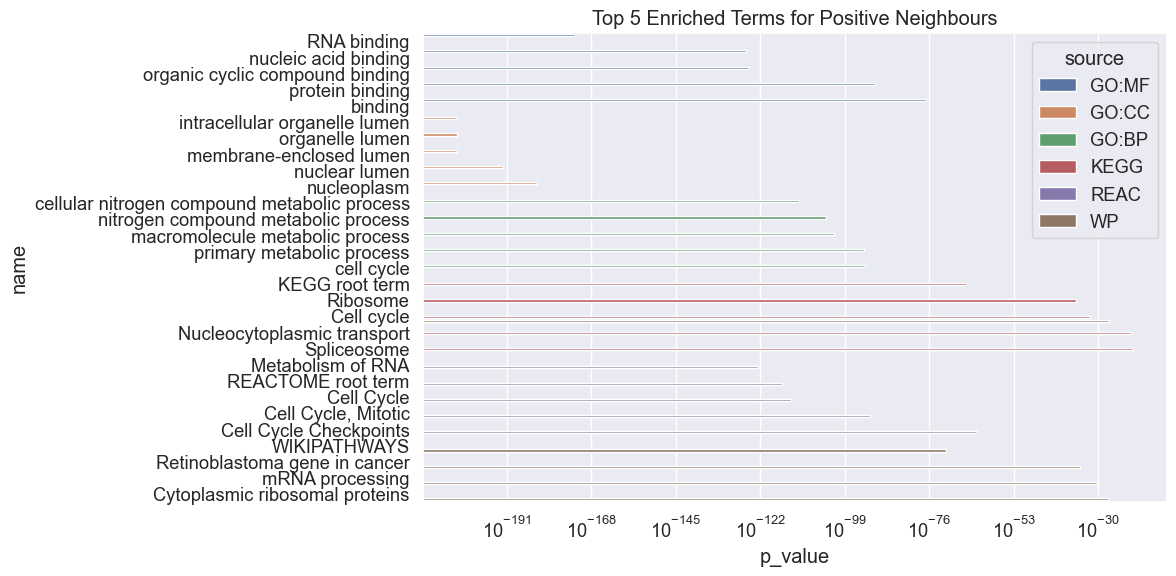

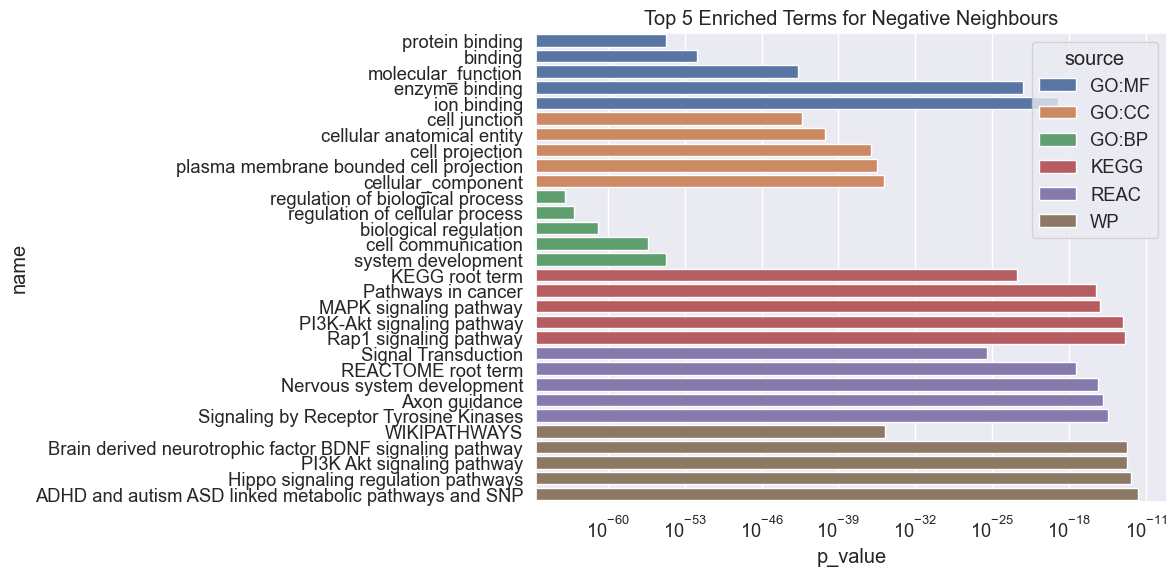

In [76]:
def plot_top_terms(enrichment_results, title):
    all_terms = pd.concat([df.sort_values('p_value').head(5) for df in enrichment_results.values()])
    plt.figure(figsize=(12, 6))
    sns.barplot(x='p_value', y='name', hue='source', data=all_terms)
    plt.title(title)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

plot_top_terms(pos_enrichment, "Top 5 Enriched Terms for Positive Neighbours")
plot_top_terms(neg_enrichment, "Top 5 Enriched Terms for Negative Neighbours")

#### SIG VS NON SIG

In [118]:
# Função para análise de enriquecimento funcional
def perform_enrichment(gene_list, background, sources):
    gp = GProfiler(return_dataframe=True)
    results = {}
    for source in sources:
        results[source] = gp.profile(
            organism='hsapiens',
            query=gene_list,
            user_threshold=0.05,
            no_evidences=False,
            sources=[source],
            all_results=False,
            domain_scope='annotated',
            background=background,
            significance_threshold_method='fdr'
        ).assign(
            fold_enrichment=lambda x: 
                x.effective_domain_size*x.intersection_size/(x.term_size*x.query_size))
    return results 

In [78]:
#significant_neighbours = resultsfiltered['neighbour'].unique()
#non_significant_neighbours = nonsignificant['neighbour'].unique() 

#print(f"Number of significant neighbours: {len(final_neighbours_list)}")
#print(f"Number of non-significant neighbours: {len(non_significant_neighbours)}")

In [119]:
# Perform enrichment for significant and non-significant neighbours
sig_enrichment_filt = perform_enrichment(significant_neighbours_filt, background, sources)
non_sig_enrichment_filt = perform_enrichment(list(non_significant_neighbours_filt), background, sources)

In [120]:
sig_enrichment = perform_enrichment(significant_neighbours, background, sources)
non_sig_enrichment = perform_enrichment(non_significant_neighbours, background, sources)

##### Filtered 

In [121]:
all_intersections_set_sig_filt = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = sig_enrichment_filt[source]
        dic_filt_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_sig
        for intersection_list in dic_filt_sig['intersections']:
            all_intersections_set_sig_filt.update(intersection_list)

# Count how many values from significant_neighbours appear in the set of intersections
count_only_sig_in_intersections = sum(1 for item in significant_neighbours_filt if item in all_intersections_set_sig_filt)

print(f"Number of values from significant_neighbours that appear in the intersections: {count_only_sig_in_intersections}")
proportion = count_only_sig_in_intersections / len(significant_neighbours_filt) 
print(f"Proportion of values from significant_neighbours that appear in the intersections: {proportion}")

Number of values from significant_neighbours that appear in the intersections: 975
Proportion of values from significant_neighbours that appear in the intersections: 0.604089219330855


In [122]:
# Define the function to count intersections
def count_intersections(row, only_set):
    intersections = row['intersections']
    # Convert the string of intersections to a list, if necessary
    if isinstance(intersections, str):
        intersections = intersections.strip('[]').replace("'", "").split(', ')
    return sum(1 for item in intersections if item in only_set)

# Apply the function to count intersections and store in a new column
dic_filt_sig['only_sig_count'] = dic_filt_sig.apply(count_intersections, axis=1, only_set=significant_neighbours_filt)

# Sort the DataFrame by 'only_sig_count' in descending order and reset the index
dic_filt_sig_sorted = dic_filt_sig[['native', 'only_sig_count']].sort_values('only_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_filt_sig_sorted)

        native  only_sig_count
0   GO:0007049             404
1   GO:0008283             293
2   GO:0012501             291
3   GO:0043067             236
4   GO:0030030             187
5   GO:0051301             175
6   GO:0006955             169
7   GO:0016477             162
8   GO:0007155             152
9   GO:0008284             149
10  GO:0009968             140
11  GO:0006281             138
12  GO:0043069             136
13  GO:0050776              97
14  GO:0034330              96
15  GO:0045787              96
16  GO:0030155              93
17  GO:0045786              92
18  GO:0045786              92
19  GO:0008285              89
20  GO:0001525              72
21  GO:0032200              51
22  GO:0000723              48
23  GO:0006282              44
24  GO:0031570              39
25  GO:0032204              30
26  GO:0071456              28
27  GO:0090398              23
28  GO:0030307              23
29  GO:0045766              22
30  GO:0045005              18
31  GO:0

In [123]:
all_intersections_set_n_sig_filt = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = non_sig_enrichment_filt[source]
        dic_filt_n_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                  left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_n_sig
        for intersection_list in dic_filt_n_sig['intersections']:
            all_intersections_set_n_sig_filt.update(intersection_list)

# Count how many values from non_significant_neighbours appear in the set of intersections
count_only_n_sig_in_intersections = sum(1 for item in non_significant_neighbours_filt if item in all_intersections_set_n_sig_filt)

print(f"Number of values from non_significant_neighbours that appear in the intersections: {count_only_n_sig_in_intersections}")
proportion = count_only_n_sig_in_intersections / len(non_significant_neighbours_filt) 
print(f"Proportion of values from non_significant_neighbours that appear in the intersections: {proportion}")

Number of values from non_significant_neighbours that appear in the intersections: 4482
Proportion of values from non_significant_neighbours that appear in the intersections: 0.3914410480349345


In [124]:
dic_filt_n_sig['only_n_sig_count'] = dic_filt_n_sig.apply(count_intersections, axis=1, only_set=non_significant_neighbours)

# Sort the DataFrame by 'only_n_sig_count' in descending order and reset the index
dic_filt_n_sig_sorted = dic_filt_n_sig[['native', 'only_n_sig_count']].sort_values('only_n_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_filt_n_sig_sorted)

        native  only_n_sig_count
0   GO:0012501              1085
1   GO:0008283              1047
2   GO:0006955               994
3   GO:0007155               902
4   GO:0030030               874
5   GO:0016477               859
6   GO:0043067               797
7   GO:0009968               763
8   GO:0050776               530
9   GO:0008284               487
10  GO:0030155               486
11  GO:0043069               464
12  GO:0034330               412
13  GO:0008285               387
14  GO:0001525               319
15  GO:0050727               215
16  GO:0007162               180
17  GO:0030308               110
18  GO:0045766               101
19  GO:0001837                93
20  GO:0030307                84
21  GO:0002367                78
22  GO:0006096                53
23  GO:0090398                52


In [125]:
# Create DataFrames with native and proportions
sig_proportions = dic_filt_sig[['native', 'only_sig_count']].copy()
n_sig_proportions = dic_filt_n_sig[['native', 'only_n_sig_count']].copy()

# Calculate proportions
sig_proportions['sig_proportion'] = sig_proportions['only_sig_count'] / len(significant_neighbours_filt)
n_sig_proportions['n_sig_proportion'] = n_sig_proportions['only_n_sig_count'] / len(non_significant_neighbours_filt)

# Merge the two DataFrames on 'native' column
combined_proportions_sig = pd.merge(
    sig_proportions[['native', 'sig_proportion']], 
    n_sig_proportions[['native', 'n_sig_proportion']], 
    on='native', 
    how='outer'
)

# Fill NaN values with 0
combined_proportions_sig = combined_proportions_sig.fillna(0)

# Add the 'name' column from the hallmarks_df to the merged dataframe
combined_proportions_sig_2 = pd.merge(
    combined_proportions_sig,
    hallmarks_df[['Hallmarks', 'GO terms', 'Term name']].rename(columns={'GO terms': 'native', 'Term name': 'name'}),
    on='native',
    how='left'
)

# Convert proportions to percentages
combined_proportions_sig_2['Sig Proportion (%)'] = combined_proportions_sig_2['sig_proportion'] * 100
combined_proportions_sig_2['Non-Sig Proportion (%)'] = combined_proportions_sig_2['n_sig_proportion'] * 100

# Sort the merged dataframe and drop duplicates based on both 'native' and 'Hallmarks'
combined_proportions_sorted_sig_2 = combined_proportions_sig_2[['native', 'name', 'Sig Proportion (%)', 'Non-Sig Proportion (%)', 'Hallmarks']].sort_values(
    ['Sig Proportion (%)', 'Non-Sig Proportion (%)'], 
    ascending=False
).drop_duplicates(subset=['native', 'Hallmarks']).reset_index(drop=True)

#drop hallmarks column
combined_proportions_sorted_sig_2.drop('Hallmarks', axis=1, inplace=True)

# Print the sorted DataFrame to view the table
print(combined_proportions_sorted_sig_2)

        native                                               name  \
0   GO:0007049                                         Cell Cycle   
1   GO:0008283                                 Cell Proliferation   
2   GO:0012501                              Programmed cell death   
3   GO:0043067                Regulation of programmed cell death   
4   GO:0030030                       Cell projection Organization   
5   GO:0051301                                      Cell Division   
6   GO:0006955                                    Immune Response   
7   GO:0016477                                     Cell migration   
8   GO:0007155                                      Cell adhesion   
9   GO:0008284          Positive regulation of cell proliferation   
10  GO:0009968         Negative regulation of signal transduction   
11  GO:0006281                                         DNA repair   
12  GO:0043069       Negative regualtion of programmed cell death   
13  GO:0050776                    

In [117]:
""" # Create DataFrames with native and proportions
sig_proportions = dic_filt_sig[['native', 'only_sig_count']].copy()
n_sig_proportions = dic_filt_n_sig[['native', 'only_n_sig_count']].copy()

# Calculate proportions
sig_proportions['sig_proportion'] = sig_proportions['only_sig_count'] / len(significant_neighbours_filt)
n_sig_proportions['n_sig_proportion'] = n_sig_proportions['only_n_sig_count'] / len(non_significant_neighbours_filt)

# Merge the two DataFrames on 'native' column
combined_proportions_sig = pd.merge(
    sig_proportions[['native', 'sig_proportion']], 
    n_sig_proportions[['native', 'n_sig_proportion']], 
    on='native', 
    how='outer'
)

# Fill NaN values with 0
combined_proportions_sig = combined_proportions_sig.fillna(0)

# Add the 'name' column from the hallmarks_df to the merged dataframe
combined_proportions_sig_2 = pd.merge(
    combined_proportions_sig,
    hallmarks_df[['Hallmarks', 'GO terms', 'Term name']].rename(columns={'GO terms': 'native', 'Term name': 'name'}),
    on='native',
    how='left'
)

# Convert proportions to percentages
combined_proportions_sig_2['Sig Proportion (%)'] = combined_proportions_sig_2['sig_proportion'] * 100
combined_proportions_sig_2['Non-Sig Proportion (%)'] = combined_proportions_sig_2['n_sig_proportion'] * 100

# Sort the merged dataframe and drop duplicates based on both 'native' and 'Hallmarks'
combined_proportions_sorted_sig_2 = combined_proportions_sig_2[['native', 'name', 'Sig Proportion (%)', 'Non-Sig Proportion (%)', 'Hallmarks']].sort_values(
    ['Sig Proportion (%)', 'Non-Sig Proportion (%)'], 
    ascending=False
).drop_duplicates(subset=['native', 'Hallmarks']).reset_index(drop=True)

#drop hallmarks column
#combined_proportions_sorted_sig_2.drop('Hallmarks', axis=1, inplace=True)

# Print the sorted DataFrame to view the table
print(combined_proportions_sorted_sig_2) """

        native                                               name  \
0   GO:0007049                                         Cell Cycle   
1   GO:0008283                                 Cell Proliferation   
2   GO:0012501                              Programmed cell death   
3   GO:0043067                Regulation of programmed cell death   
4   GO:0030030                       Cell projection Organization   
5   GO:0051301                                      Cell Division   
6   GO:0006955                                    Immune Response   
7   GO:0016477                                     Cell migration   
8   GO:0007155                                      Cell adhesion   
9   GO:0008284          Positive regulation of cell proliferation   
10  GO:0009968         Negative regulation of signal transduction   
11  GO:0006281                                         DNA repair   
12  GO:0043069       Negative regualtion of programmed cell death   
13  GO:0050776                    

In [126]:
import pandas as pd

# Assuming the merged DataFrame creation is already done

# Convert proportions to percentages (no scientific notation needed)
combined_proportions_sorted_sig_2['Sig Proportion (%)'] = combined_proportions_sorted_sig_2['Sig Proportion (%)'].round(2)
combined_proportions_sorted_sig_2['Non-Sig Proportion (%)'] = combined_proportions_sorted_sig_2['Non-Sig Proportion (%)'].round(2)

# Save the DataFrame to a LaTeX file without scientific notation
latex_code = combined_proportions_sorted_sig_2.to_latex(
    buf='merged_proportions_table_all.tex',     # Output file name
    index=False,                        # Do not print the DataFrame's index
    column_format='|l|l|r|r|',          # Custom column alignment
    header=True,                        # Include headers
    caption='Positive and Negative Proportions for GO Terms',  # Add a caption
    label='table:go_bp_enriched',        # Add a label for referencing in LaTeX
    longtable=False,                    # No need for longtable here
    float_format="%.2f"                 # Format the numbers with two decimal places
)

# Output the LaTeX code generation message
print("LaTeX code generated and saved as 'merged_pos_neg_table.tex'.")


LaTeX code generated and saved as 'merged_pos_neg_table.tex'.


In [86]:
terms_sig = dic_filt_sig['native'].tolist()
terms_n_sig = dic_filt_n_sig['native'].tolist()
terms_sig_set = set(terms_sig)
terms_n_sig_set = set(terms_n_sig)
intersection = terms_sig_set.intersection(terms_n_sig_set)
print(intersection)
print(len(intersection))

{'GO:0043069', 'GO:0006096', 'GO:0008283', 'GO:0043067', 'GO:0001525', 'GO:0008284', 'GO:0050776', 'GO:0016477', 'GO:0045766', 'GO:0006955', 'GO:0030307', 'GO:0030155', 'GO:0030030', 'GO:0034330', 'GO:0090398', 'GO:0012501', 'GO:0008285', 'GO:0009968', 'GO:0007155'}
19


In [87]:
dic_filt_sig = dic_filt_sig[dic_filt_sig['native'].isin(intersection)][['native', 'only_sig_count']]
dic_filt_sig['proportion'] = dic_filt_sig['only_sig_count'] / len(significant_neighbours_filt)
dic_filt_n_sig = dic_filt_n_sig[dic_filt_n_sig['native'].isin(intersection)][['native', 'only_n_sig_count']]
dic_filt_n_sig['proportion'] = dic_filt_n_sig['only_n_sig_count'] / len(non_significant_neighbours_filt)
merged_df = pd.merge(
    dic_filt_sig[['native', 'only_sig_count', 'proportion']].rename(columns={'proportion': 'sig_proportion'}),
    dic_filt_n_sig[['native', 'only_n_sig_count', 'proportion']].rename(columns={'proportion': 'non_sig_proportion'}),
    on='native',
    how='inner'  # Using outer join to ensure all terms from both significant and non-significant are included
)

# Sort the merged dataframe by 'sig_proportion' and 'non_sig_proportion' to make it easier to compare
merged_df_sorted = merged_df.sort_values(['sig_proportion', 'non_sig_proportion'], ascending=False)

# Print the merged dataframe to compare the proportions
print(merged_df_sorted)

        native  only_sig_count  sig_proportion  only_n_sig_count  \
1   GO:0008283             293        0.181537              1047   
0   GO:0012501             291        0.180297              1085   
2   GO:0043067             236        0.146221               797   
5   GO:0030030             187        0.115861               874   
15  GO:0006955             169        0.104709               994   
10  GO:0016477             162        0.100372               859   
14  GO:0007155             152        0.094176               902   
3   GO:0008284             149        0.092317               487   
12  GO:0009968             140        0.086741               763   
4   GO:0043069             136        0.084263               464   
13  GO:0050776              97        0.060099               530   
6   GO:0034330              96        0.059480               412   
11  GO:0030155              93        0.057621               486   
8   GO:0008285              89        0.055143  

In [88]:
import pandas as pd

# Assuming 'merged_df' and 'hallmarks_df' are already defined
# Convert proportions to percentages
merged_df['Sig Proportion (%)'] = merged_df['sig_proportion'] * 100
merged_df['Non-Sig Proportion (%)'] = merged_df['non_sig_proportion'] * 100

# Perform the merge to include the 'name' column from 'hallmarks_df'
merged_df = pd.merge(
    merged_df,
    hallmarks_df[['GO terms', 'Term name']].rename(columns={'GO terms': 'native', 'Term name': 'name'}),
    on='native',
    how='left'  # Use 'left' join to include only relevant 'native' terms
)

# Select and order the final columns
merged_df = merged_df[['native', 'name', 'Sig Proportion (%)', 'Non-Sig Proportion (%)']].sort_values(
    ['Sig Proportion (%)', 'Non-Sig Proportion (%)'], ascending=False
)

# Display the final table
print(merged_df)


        native                                          name  \
1   GO:0008283                            Cell Proliferation   
0   GO:0012501                         Programmed cell death   
2   GO:0043067           Regulation of programmed cell death   
5   GO:0030030                  Cell projection Organization   
15  GO:0006955                               Immune Response   
10  GO:0016477                                Cell migration   
14  GO:0007155                                 Cell adhesion   
3   GO:0008284     Positive regulation of cell proliferation   
12  GO:0009968    Negative regulation of signal transduction   
4   GO:0043069  Negative regualtion of programmed cell death   
13  GO:0050776                 Regulation of immune response   
6   GO:0034330                    Cell junction Organization   
11  GO:0030155                   Regulation of Cell Adhesion   
8   GO:0008285     Negative regulation of cell proliferation   
9   GO:0001525                          

In [89]:
""" # Save the final dataframe as a LaTeX file
latex_output = merged_df.to_latex(index=False, column_format='|l|l|r|r|', longtable=True, float_format="%.2f")

# Write the LaTeX code to a file
with open('merged_proportions_table.tex', 'w') as f:
    f.write(latex_output)

print("LaTeX table saved as 'merged_proportions_table.tex'")
 """

' # Save the final dataframe as a LaTeX file\nlatex_output = merged_df.to_latex(index=False, column_format=\'|l|l|r|r|\', longtable=True, float_format="%.2f")\n\n# Write the LaTeX code to a file\nwith open(\'merged_proportions_table.tex\', \'w\') as f:\n    f.write(latex_output)\n\nprint("LaTeX table saved as \'merged_proportions_table.tex\'")\n '

In [90]:
non_sig_more = merged_df_sorted[merged_df_sorted['non_sig_proportion'] > merged_df_sorted['sig_proportion']]
non_sig_more

Empty DataFrame
Columns: [native, only_sig_count, sig_proportion, only_n_sig_count, non_sig_proportion]
Index: []

##### All DINTs

In [91]:
all_intersections_set_sig = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = sig_enrichment[source]
        dic_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_sig
        for intersection_list in dic_sig['intersections']:
            all_intersections_set_sig.update(intersection_list)

# Count how many values from significant_neighbours appear in the set of intersections
count_only_sig_in_intersections = sum(1 for item in significant_neighbours if item in all_intersections_set_sig)

print(f"Number of values from significant_neighbours that appear in the intersections: {count_only_sig_in_intersections}")
proportion = count_only_sig_in_intersections / len(significant_neighbours) 
print(f"Proportion of values from significant_neighbours that appear in the intersections: {proportion}")

Number of values from significant_neighbours that appear in the intersections: 1758
Proportion of values from significant_neighbours that appear in the intersections: 0.5634615384615385


In [92]:
# Define the function to count intersections
def count_intersections(row, only_set):
    intersections = row['intersections']
    # Convert the string of intersections to a list, if necessary
    if isinstance(intersections, str):
        intersections = intersections.strip('[]').replace("'", "").split(', ')
    return sum(1 for item in intersections if item in only_set)

# Apply the function to count intersections and store in a new column
dic_sig['only_sig_count'] = dic_sig.apply(count_intersections, axis=1, only_set=significant_neighbours)

# Sort the DataFrame by 'only_sig_count' in descending order and reset the index
dic_sig_sorted = dic_sig[['native', 'only_sig_count']].sort_values('only_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_sig_sorted)

        native  only_sig_count
0   GO:0007049             593
1   GO:0012501             538
2   GO:0008283             526
3   GO:0043067             434
4   GO:0030030             350
5   GO:0016477             347
6   GO:0006955             343
7   GO:0007155             317
8   GO:0009968             299
9   GO:0008284             271
10  GO:0043069             259
11  GO:0051301             245
12  GO:0006281             199
13  GO:0050776             197
14  GO:0034330             195
15  GO:0030155             186
16  GO:0008285             170
17  GO:0001525             136
18  GO:0045786             131
19  GO:0045786             131
20  GO:0045787             128
21  GO:0050727              86
22  GO:0032200              78
23  GO:0000723              74
24  GO:0006282              72
25  GO:0007162              64
26  GO:0031570              57
27  GO:0032204              50
28  GO:0001837              49
29  GO:0030307              47
30  GO:0030308              45
31  GO:0

In [93]:
all_intersections_set_n_sig = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = non_sig_enrichment[source]
        dic_n_sig = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                  left_on='native', right_on='GO terms', how='inner')
        
        # Extract the values from the 'intersections' column and add them to the all_intersections_set_n_sig
        for intersection_list in dic_n_sig['intersections']:
            all_intersections_set_n_sig.update(intersection_list)

# Count how many values from non_significant_neighbours appear in the set of intersections
count_only_n_sig_in_intersections = sum(1 for item in non_significant_neighbours if item in all_intersections_set_n_sig)

print(f"Number of values from non_significant_neighbours that appear in the intersections: {count_only_n_sig_in_intersections}")
proportion = count_only_n_sig_in_intersections / len(non_significant_neighbours) 
print(f"Proportion of values from non_significant_neighbours that appear in the intersections: {proportion}")

Number of values from non_significant_neighbours that appear in the intersections: 3743
Proportion of values from non_significant_neighbours that appear in the intersections: 0.376407884151247


In [94]:
dic_n_sig['only_n_sig_count'] = dic_n_sig.apply(count_intersections, axis=1, only_set=non_significant_neighbours)

# Sort the DataFrame by 'only_n_sig_count' in descending order and reset the index
dic_n_sig_sorted = dic_n_sig[['native', 'only_n_sig_count']].sort_values('only_n_sig_count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame with a clean, ordered index
print(dic_n_sig_sorted)

        native  only_n_sig_count
0   GO:0012501              1085
1   GO:0008283              1047
2   GO:0006955               994
3   GO:0007155               902
4   GO:0030030               874
5   GO:0016477               859
6   GO:0043067               797
7   GO:0009968               763
8   GO:0050776               530
9   GO:0030155               486
10  GO:0034330               412
11  GO:0008285               387
12  GO:0001525               320
13  GO:0050727               215
14  GO:0007162               180
15  GO:0030308               110
16  GO:0045766               101
17  GO:0002367                78


In [95]:
terms_sig = dic_sig['native'].tolist()
terms_n_sig = dic_n_sig['native'].tolist()
terms_sig_set = set(terms_sig)
terms_n_sig_set = set(terms_n_sig)
intersection = terms_sig_set.intersection(terms_n_sig_set)
print(intersection)

{'GO:0012501', 'GO:0001525', 'GO:0030155', 'GO:0030308', 'GO:0030030', 'GO:0007162', 'GO:0008283', 'GO:0050776', 'GO:0008285', 'GO:0034330', 'GO:0016477', 'GO:0045766', 'GO:0006955', 'GO:0043067', 'GO:0009968', 'GO:0007155', 'GO:0050727'}


In [96]:
print(len(intersection))

17


In [97]:
dic_sig = dic_sig[dic_sig['native'].isin(intersection)][['native', 'only_sig_count']]
dic_sig['proportion'] = dic_sig['only_sig_count'] / len(significant_neighbours)
dic_n_sig = dic_n_sig[dic_n_sig['native'].isin(intersection)][['native', 'only_n_sig_count']]
dic_n_sig['proportion'] = dic_n_sig['only_n_sig_count'] / len(non_significant_neighbours)
merged_df = pd.merge(
    dic_filt_sig[['native', 'only_sig_count', 'proportion']].rename(columns={'proportion': 'sig_proportion'}),
    dic_n_sig[['native', 'only_n_sig_count', 'proportion']].rename(columns={'proportion': 'non_sig_proportion'}),
    on='native',
    how='inner'  # Using outer join to ensure all terms from both significant and non-significant are included
)

# Sort the merged dataframe by 'sig_proportion' and 'non_sig_proportion' to make it easier to compare
merged_df_sorted = merged_df.sort_values(['sig_proportion', 'non_sig_proportion'], ascending=False)

# Print the merged dataframe to compare the proportions
print(merged_df_sorted)

        native  only_sig_count  sig_proportion  only_n_sig_count  \
1   GO:0008283             293        0.181537              1047   
0   GO:0012501             291        0.180297              1085   
2   GO:0043067             236        0.146221               797   
3   GO:0030030             187        0.115861               874   
12  GO:0006955             169        0.104709               994   
7   GO:0016477             162        0.100372               859   
11  GO:0007155             152        0.094176               902   
9   GO:0009968             140        0.086741               763   
10  GO:0050776              97        0.060099               530   
4   GO:0034330              96        0.059480               412   
8   GO:0030155              93        0.057621               486   
5   GO:0008285              89        0.055143               387   
6   GO:0001525              72        0.044610               320   
13  GO:0045766              22        0.013631  

In [98]:
non_sig_more = merged_df_sorted[merged_df_sorted['non_sig_proportion'] > merged_df_sorted['sig_proportion']]
non_sig_more

Empty DataFrame
Columns: [native, only_sig_count, sig_proportion, only_n_sig_count, non_sig_proportion]
Index: []

## TAU

#### POS VS NEG

In [99]:
# Load TAU data
tau_df = pd.read_csv('gene_exp.csv')
tau_df = tau_df.set_index('gene_id')
tau_df_filtered = tau_df[~tau_df.index.duplicated(keep='first')]

# Obtain TAU values for positive and negative neighbours
pos_tau = tau_df_filtered.loc[tau_df_filtered.index.isin(only_pos), 'tau']
neg_tau = tau_df_filtered.loc[tau_df_filtered.index.isin(only_neg), 'tau']

# Mann-Whitney U test for comparison of TAU between positive and negative neighbours
u_stat_tau, p_value_tau = stats.mannwhitneyu(pos_tau, neg_tau)
print(f"\nComparison of TAU between positive-only and negative-only neighbours:")
print(f"U-statistic: {u_stat_tau}")
print(f"P-value: {p_value_tau}")

# Correlation between association counts and TAU
neighbour_counts_with_tau = consistent_neighbours.reset_index().merge(tau_df_filtered[['tau']], left_on='neighbour', right_index=True, how='left')
correlation = neighbour_counts_with_tau['num_associated_drivers'].corr(neighbour_counts_with_tau['tau'])
print(f"\nCorrelation between association counts and TAU: {correlation}")

""" # Visualização da distribuição de TAU para vizinhos positivos e negativos
plt.figure(figsize=(10, 6))
plt.hist(pos_tau, bins=30, alpha=0.5, label='Vizinhos Positivos')
plt.hist(neg_tau, bins=30, alpha=0.5, label='Vizinhos Negativos')
plt.xlabel('TAU')
plt.ylabel('Contagem')
plt.title('Distribuição de TAU para Vizinhos Positivos e Negativos')
plt.legend()
plt.show() """



Comparison of TAU between positive-only and negative-only neighbours:
U-statistic: 887123.5
P-value: 1.1742397188028401e-32

Correlation between association counts and TAU: 0.03788228073968786


" # Visualização da distribuição de TAU para vizinhos positivos e negativos\nplt.figure(figsize=(10, 6))\nplt.hist(pos_tau, bins=30, alpha=0.5, label='Vizinhos Positivos')\nplt.hist(neg_tau, bins=30, alpha=0.5, label='Vizinhos Negativos')\nplt.xlabel('TAU')\nplt.ylabel('Contagem')\nplt.title('Distribuição de TAU para Vizinhos Positivos e Negativos')\nplt.legend()\nplt.show() "

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_34174/946100664.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_tau, shade=True, label='Positive Neighbours', color='#1f77b4')  # Custom color for Positive Neighbours
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_34174/946100664.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_tau, shade=True, label='Negative Neighbours', color='#ff7f0e')  # Custom color for Negative Neighbours


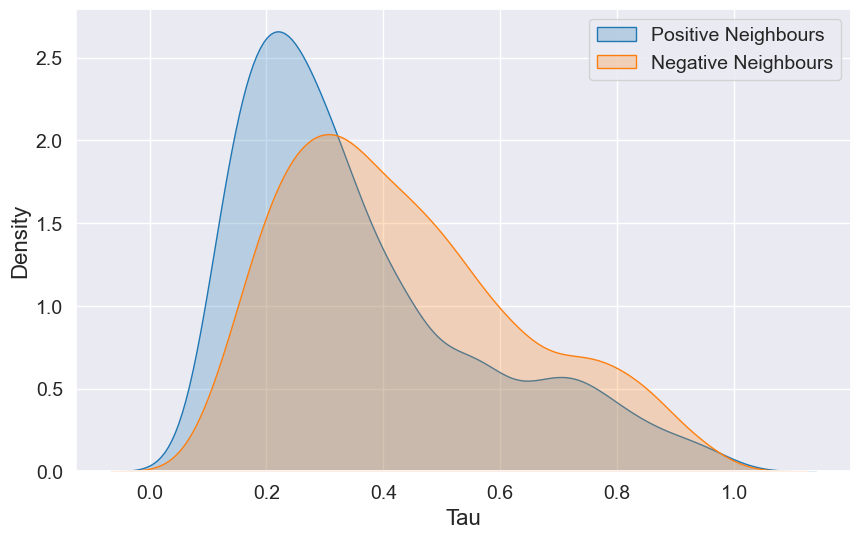

In [100]:
plt.figure(figsize=(10, 6))
sns.kdeplot(pos_tau, shade=True, label='Positive Neighbours', color='#1f77b4')  # Custom color for Positive Neighbours
sns.kdeplot(neg_tau, shade=True, label='Negative Neighbours', color='#ff7f0e')  # Custom color for Negative Neighbours
plt.xlabel('Tau', fontsize=16)
plt.ylabel('Density', fontsize=16)
#plt.title('Distribution of Tau for Positive and Negative Neighbours', fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### SIG VS NON SIG

##### Filtered

In [ ]:
meanexp = tumourexp.reset_index(drop=True).median().rename("expression")
u_stat, p_value_u = stats.mannwhitneyu(meanexp.loc[significant_neighbours_filt],
                                       meanexp.loc[non_significant_neighbours_filt],
                                       alternative='two-sided')

print(f"\nComparação de expressão génica entre vizinhos significativos e não significativos usando Mann-Whitney U:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value_u}")



Comparação de expressão génica entre vizinhos significativos e não significativos usando Mann-Whitney U:
U-statistic: 11290221.0
P-value: 2.4085830597338116e-47


In [102]:
# Convert neighbour lists to sets to remove duplicates
significant_neighbours_filt_set = set(significant_neighbours_filt)
non_significant_neighbours_filt_set = set(non_significant_neighbours_filt)

# Create sets of neighbours that exist in tau_df
significant_neighbours_filt_tau = significant_neighbours_filt_set.intersection(tau_df_filtered.index)
non_significant_neighbours_filt_tau = non_significant_neighbours_filt_set.intersection(tau_df_filtered.index)

# Convert the sets back to lists for indexing
significant_neighbours_filt_list = list(significant_neighbours_filt_tau)
non_significant_neighbours_filt_list = list(non_significant_neighbours_filt_tau)

# Obtain the tau values for significant and non-significant neighbours
sig_tau_filt = tau_df_filtered.loc[significant_neighbours_filt_list, 'tau']
non_sig_tau_filt = tau_df_filtered.loc[non_significant_neighbours_filt_list, 'tau']

# Perform the Mann-Whitney U test
u_stat, u_p_value = stats.mannwhitneyu(sig_tau_filt, non_sig_tau_filt)

print("\nComparison of TAU between significant and non-significant neighbours:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {u_p_value}")

""" # Criar o histograma
plt.figure(figsize=(10, 6))
plt.hist(sig_tau, bins=30, alpha=0.5, label='Vizinhos Significativos')
plt.hist(non_sig_tau, bins=30, alpha=0.5, label='Vizinhos Não Significativos')
plt.xlabel('TAU')
plt.ylabel('Contagem')
plt.title('Distribuição de TAU para Vizinhos Significativos e Não Significativos')
plt.legend()
plt.show() """


Comparison of TAU between significant and non-significant neighbours:
U-statistic: 7617976.5
P-value: 7.275591615971163e-26


" # Criar o histograma\nplt.figure(figsize=(10, 6))\nplt.hist(sig_tau, bins=30, alpha=0.5, label='Vizinhos Significativos')\nplt.hist(non_sig_tau, bins=30, alpha=0.5, label='Vizinhos Não Significativos')\nplt.xlabel('TAU')\nplt.ylabel('Contagem')\nplt.title('Distribuição de TAU para Vizinhos Significativos e Não Significativos')\nplt.legend()\nplt.show() "

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_34174/3708147448.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sig_tau_filt, shade=True, label='Significant Neighbours', color='#1f77b4')  # Custom color for Significant Neighbours
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_34174/3708147448.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_sig_tau_filt, shade=True, label='Non-Significant Neighbours', color='#ff7f0e')  # Custom color for Non-Significant Neighbours


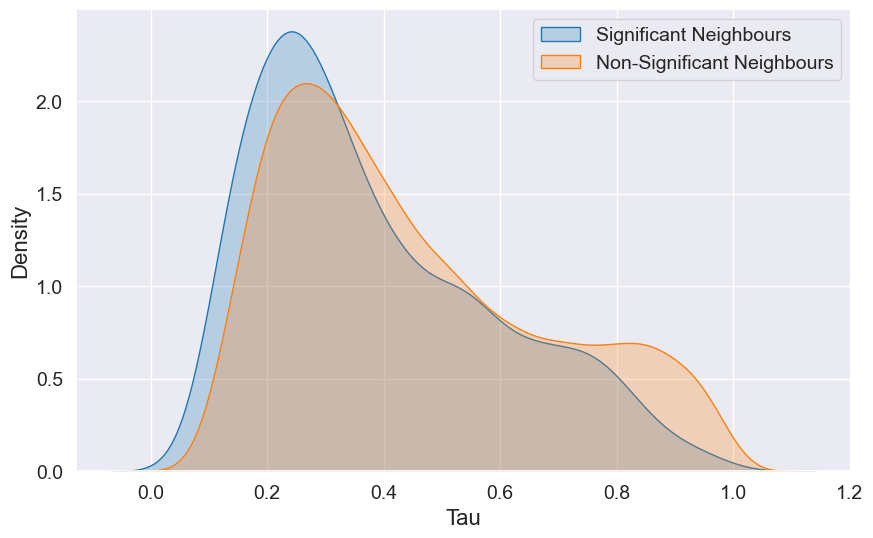

In [103]:
plt.figure(figsize=(10, 6))
sns.kdeplot(sig_tau_filt, shade=True, label='Significant Neighbours', color='#1f77b4')  # Custom color for Significant Neighbours
sns.kdeplot(non_sig_tau_filt, shade=True, label='Non-Significant Neighbours', color='#ff7f0e')  # Custom color for Non-Significant Neighbours
plt.xlabel('Tau', fontsize=16)
plt.ylabel('Density', fontsize=16)
#plt.title('Distribution of Tau for Significant and Non-Significant Neighbours', fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [104]:
def overlap_coefficient(dist1, dist2, bins=100):
    hist1, _ = np.histogram(dist1, bins=bins)
    hist2, _ = np.histogram(dist2, bins=bins)
    minima = np.minimum(hist1, hist2)
    overlap = np.true_divide(np.sum(minima), np.minimum(np.sum(hist1), np.sum(hist2)))
    return overlap

overlap = overlap_coefficient(sig_tau_filt, non_sig_tau_filt)
print(f"Overlap coefficient: {overlap}")

#Para o coeficiente de sobreposição, valores próximos a 1 indicam alta sobreposição, enquanto valores próximos a 0 indicam pouca sobreposição.


Overlap coefficient: 0.9993777224642191


In [ ]:
from numpy import array
from scipy.stats import mannwhitneyu

# Function to compute Cliff's Delta
def cliffs_delta(data1, data2):
    n1, n2 = len(data1), len(data2)
    pairs = [(x, y) for x in data1 for y in data2]
    more = sum([x > y for (x, y) in pairs])
    less = sum([x < y for (x, y) in pairs])
    return (more - less) / (n1 * n2)

# Assuming sig_tau and non_sig_tau are your TAU values for significant and non-significant neighbours
delta = cliffs_delta(sig_tau_filt, non_sig_tau_filt)
print(f"Cliff's Delta: {delta}")


In [ ]:
import numpy as np
from scipy import stats

# Perform the Mann-Whitney U test
u_stat, p_value_u = stats.mannwhitneyu(sig_tau_filt, non_sig_tau_filt)

# Calculate the rank-biserial correlation (r)
n1 = len(sig_tau_filt)
n2 = len(non_sig_tau_filt)
r = 1 - (2 * u_stat) / (n1 * n2)
print(f"Rank-Biserial Correlation (r): {r}")


Rank-Biserial Correlation (r): 0.1618642779248144


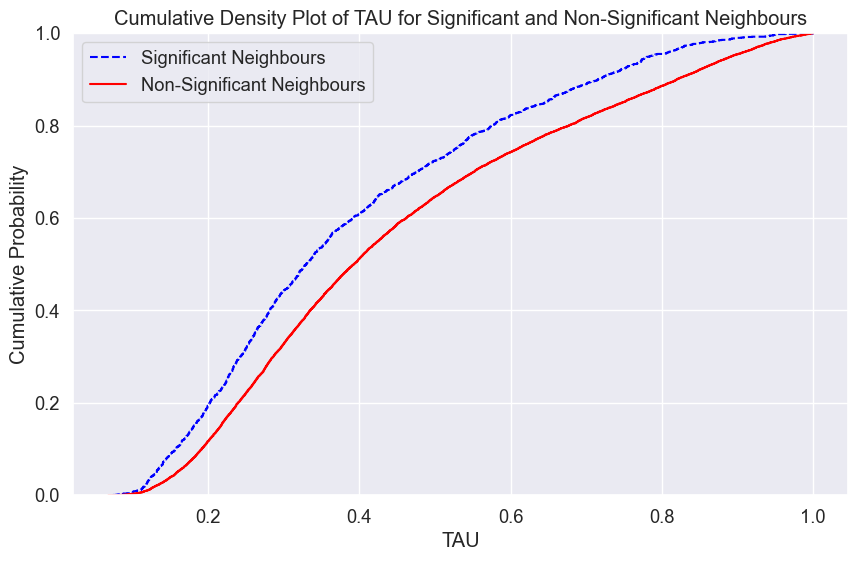

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create cumulative density plots for TAU values of significant and non-significant neighbors
plt.figure(figsize=(10, 6))
sns.ecdfplot(sig_tau_filt, label='Significant Neighbours', linestyle='--', color='blue')
sns.ecdfplot(non_sig_tau_filt, label='Non-Significant Neighbours', linestyle='-', color='red')
plt.xlabel('TAU')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Density Plot of TAU for Significant and Non-Significant Neighbours')
plt.legend()
plt.show()


##### All DINTs

In [ ]:
u_stat, p_value_u = stats.mannwhitneyu(meanexp.loc[significant_neighbours],
                                       meanexp.loc[non_significant_neighbours],
                                       alternative='two-sided')

print(f"\nComparação de expressão génica entre vizinhos significativos e não significativos usando Mann-Whitney U:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value_u}")

### NÃO FAZ SENTIDO ESTA ANÁLISE PARA AGORA ####    
                                      
""" plt.figure(figsize=(12, 6))
plt.hist(significant_expr.values.flatten(), bins=30, alpha=0.5, label='Vizinhos Significativos')
plt.hist(non_significant_expr.values.flatten(), bins=30, alpha=0.5, label='Vizinhos Não Significativos')
plt.xlabel('Valor de Expressão Génica')
plt.ylabel('Contagem')
plt.title('Distribuição da Expressão Génica para Vizinhos Significativos e Não Significativos')
plt.legend()
plt.show()
 """


Comparação de expressão génica entre vizinhos significativos e não significativos usando Mann-Whitney U:
U-statistic: 18688333.0
P-value: 6.77905723559261e-67


" plt.figure(figsize=(12, 6))\nplt.hist(significant_expr.values.flatten(), bins=30, alpha=0.5, label='Vizinhos Significativos')\nplt.hist(non_significant_expr.values.flatten(), bins=30, alpha=0.5, label='Vizinhos Não Significativos')\nplt.xlabel('Valor de Expressão Génica')\nplt.ylabel('Contagem')\nplt.title('Distribuição da Expressão Génica para Vizinhos Significativos e Não Significativos')\nplt.legend()\nplt.show()\n "

In [ ]:
# Convert neighbour lists to sets to remove duplicates
significant_neighbours_set = set(significant_neighbours)
non_significant_neighbours_set = set(non_significant_neighbours)

# Create sets of neighbours that exist in tau_df
significant_neighbours_tau = significant_neighbours_set.intersection(tau_df_filtered.index)
non_significant_neighbours_tau = non_significant_neighbours_set.intersection(tau_df_filtered.index)

# Convert the sets back to lists for indexing
significant_neighbours_list = list(significant_neighbours_tau)
non_significant_neighbours_list = list(non_significant_neighbours_tau)

# Obtain the tau values for significant and non-significant neighbours
sig_tau = tau_df_filtered.loc[significant_neighbours_list, 'tau']
non_sig_tau = tau_df_filtered.loc[non_significant_neighbours_list, 'tau']

# Perform the Mann-Whitney U test
u_stat, u_p_value = stats.mannwhitneyu(sig_tau, non_sig_tau)

print("\nComparison of TAU between significant and non-significant neighbours:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {u_p_value}")

""" # Criar o histograma
plt.figure(figsize=(10, 6))
plt.hist(sig_tau, bins=30, alpha=0.5, label='Vizinhos Significativos')
plt.hist(non_sig_tau, bins=30, alpha=0.5, label='Vizinhos Não Significativos')
plt.xlabel('TAU')
plt.ylabel('Contagem')
plt.title('Distribuição de TAU para Vizinhos Significativos e Não Significativos')
plt.legend()
plt.show() """


Comparison of TAU between significant and non-significant neighbours:
U-statistic: 12833152.5
P-value: 1.8143146583569149e-40


" # Criar o histograma\nplt.figure(figsize=(10, 6))\nplt.hist(sig_tau, bins=30, alpha=0.5, label='Vizinhos Significativos')\nplt.hist(non_sig_tau, bins=30, alpha=0.5, label='Vizinhos Não Significativos')\nplt.xlabel('TAU')\nplt.ylabel('Contagem')\nplt.title('Distribuição de TAU para Vizinhos Significativos e Não Significativos')\nplt.legend()\nplt.show() "

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_25585/1451486643.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sig_tau, shade=True, label='Significant Neighbours')
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_25585/1451486643.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_sig_tau, shade=True, label='Non-Significant Neighbours')


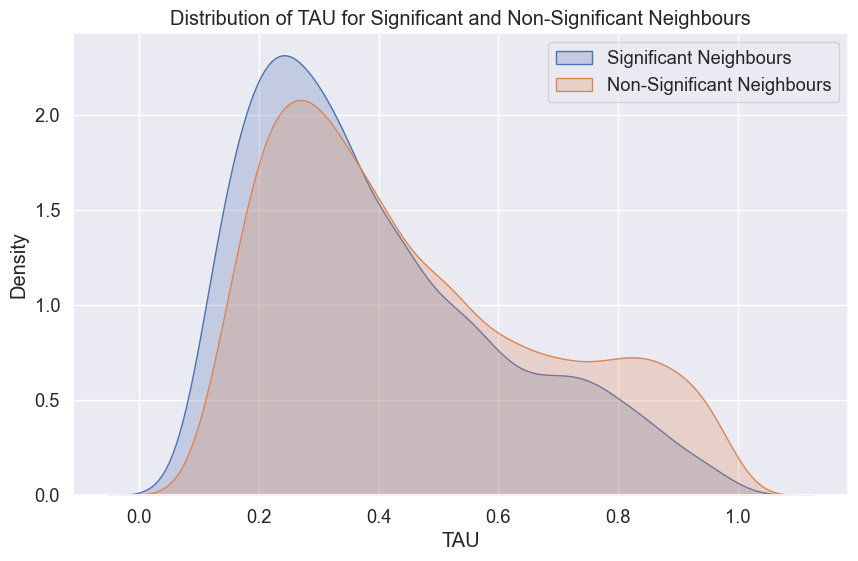

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(sig_tau, shade=True, label='Significant Neighbours')
sns.kdeplot(non_sig_tau, shade=True, label='Non-Significant Neighbours')
plt.xlabel('TAU')
plt.ylabel('Density')
plt.title('Distribution of TAU for Significant and Non-Significant Neighbours')
plt.legend()
plt.show()

In [ ]:
def overlap_coefficient(dist1, dist2, bins=100):
    hist1, _ = np.histogram(dist1, bins=bins)
    hist2, _ = np.histogram(dist2, bins=bins)
    minima = np.minimum(hist1, hist2)
    overlap = np.true_divide(np.sum(minima), np.minimum(np.sum(hist1), np.sum(hist2)))
    return overlap

overlap = overlap_coefficient(sig_tau, non_sig_tau)
print(f"Overlap coefficient: {overlap}")

#Para o coeficiente de sobreposição, valores próximos a 1 indicam alta sobreposição, enquanto valores próximos a 0 indicam pouca sobreposição.


Overlap coefficient: 0.9929214929214929


In [ ]:
from numpy import array
from scipy.stats import mannwhitneyu

# Function to compute Cliff's Delta
def cliffs_delta(data1, data2):
    n1, n2 = len(data1), len(data2)
    pairs = [(x, y) for x in data1 for y in data2]
    more = sum([x > y for (x, y) in pairs])
    less = sum([x < y for (x, y) in pairs])
    return (more - less) / (n1 * n2)

# Assuming sig_tau and non_sig_tau are your TAU values for significant and non-significant neighbours
delta = cliffs_delta(sig_tau, non_sig_tau)
print(f"Cliff's Delta: {delta}")


Cliff's Delta: -0.15827725085191194


In [ ]:
import numpy as np
from scipy import stats

# Perform the Mann-Whitney U test
u_stat, p_value_u = stats.mannwhitneyu(sig_tau, non_sig_tau)

# Calculate the rank-biserial correlation (r)
n1 = len(sig_tau)
n2 = len(non_sig_tau)
r = 1 - (2 * u_stat) / (n1 * n2)
print(f"Rank-Biserial Correlation (r): {r}")


Rank-Biserial Correlation (r): 0.1582772508519119


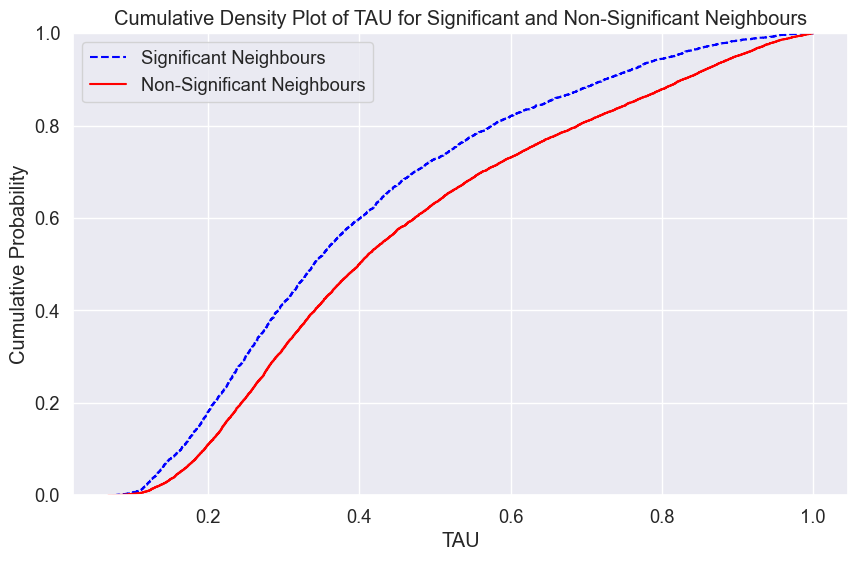

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create cumulative density plots for TAU values of significant and non-significant neighbors
plt.figure(figsize=(10, 6))
sns.ecdfplot(sig_tau, label='Significant Neighbours', linestyle='--', color='blue')
sns.ecdfplot(non_sig_tau, label='Non-Significant Neighbours', linestyle='-', color='red')
plt.xlabel('TAU')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Density Plot of TAU for Significant and Non-Significant Neighbours')
plt.legend()
plt.show()


## Neighbours Analysis

In [ ]:
import pandas as pd
import numpy as np

# Load resultsfiltered
# resultsfiltered = pd.read_csv(datadir + "DINTs.csv")

# Load the NCG file
cancerdrivers = pd.read_table('NCG_cancerdrivers_annotation_supporting_evidence.tsv')

# Filter the neighbours that are not in the NCG
non_ncg_neighbours = dints[~dints['neighbour'].isin(cancerdrivers['symbol'])]

print(f"Number of neighbours not present in the NCG: {non_ncg_neighbours['neighbour'].nunique()}")

# Function to check the consistency of the sign
def check_sign_consistency(group):
    signs = np.sign(group['coef'])
    return (signs == signs.iloc[0]).all()

# Group by neighbour and check the consistency of the sign
neighbour_consistency = non_ncg_neighbours.groupby('neighbour').apply(check_sign_consistency)

# Count the number of drivers associated with each neighbour
driver_counts = non_ncg_neighbours.groupby('neighbour')['driver'].nunique()

# Combine information
neighbour_analysis = pd.DataFrame({
    'num_associated_drivers': driver_counts,
    'is_consistent': neighbour_consistency
})

# Filter only consistent neighbours
consistent_neighbours = neighbour_analysis[neighbour_analysis['is_consistent']]

# Sort by number of associated drivers (descending) and select top 50
top_50_neighbours = consistent_neighbours.sort_values('num_associated_drivers', ascending=False).head(50)
# top_60_neighbours = consistent_neighbours.sort_values('num_associated_drivers', ascending=False).head(60)

# Add information about the type of association (positive or negative)
def get_association_type(neighbour):
    coef = non_ncg_neighbours[non_ncg_neighbours['neighbour'] == neighbour]['coef'].iloc[0]
    return 'Positive' if coef > 0 else 'Negative'

top_50_neighbours['association_type'] = top_50_neighbours.index.map(get_association_type)

# Reset the index to have the neighbour as a column
top_50_neighbours = top_50_neighbours.reset_index()

# Display the results
print(top_50_neighbours)

Number of neighbours not present in the NCG: 2345
   neighbour  num_associated_drivers  is_consistent association_type
0       CDK1                     154           True         Positive
1       CCNF                     122           True         Positive
2      KIF14                     113           True         Positive
3     KIF20A                     106           True         Positive
4      STIP1                      91           True         Positive
5      AURKB                      87           True         Positive
6      KIF23                      85           True         Positive
7      LMNB1                      79           True         Positive
8       CDK2                      72           True         Positive
9   HSP90AA1                      69           True         Positive
10     CCNB1                      65           True         Positive
11     KPNA2                      60           True         Positive
12      PRC1                      53           True  

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_25585/298129571.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neighbour_consistency = non_ncg_neighbours.groupby('neighbour').apply(check_sign_consistency)


In [ ]:
# Select the tumour expression data for non-NCG neighbours
tumourexp = pd.read_feather(datadir + "tumour_expression.feather")
selected_tumourexp = tumourexp.reset_index()[['patient', 'cancer_type'] + top_50_neighbours['neighbour'].tolist()]

# Load the survival data
clintab = pd.read_table('Survival_SupplementalTable_S1_20171025_xena_sp')
survival_data = clintab[['_PATIENT', 'OS.time', 'OS']]

# Merge the expression data with the survival data
final_data = selected_tumourexp.merge(survival_data, left_on='patient', right_on='_PATIENT', how='inner')

# Remove the duplicate 'sample' column
final_data = final_data.drop(columns=['_PATIENT'])

final_data
# Save the final dataset
# final_data.to_csv(datadir + "final_data_for_analysis.csv", index=False)

patient cancer_type   CDK1   CCNF  KIF14  KIF20A  STIP1  AURKB  \
0     TCGA-02-0047         GBM   9.07   8.12   7.30    8.28  11.33   7.67   
1     TCGA-02-0055         GBM   9.09   7.62   6.43    8.10  11.93   7.46   
2     TCGA-02-2483         GBM  10.07   9.01   8.31    8.97  12.19   9.89   
3     TCGA-02-2485         GBM   9.32   8.18   7.43    8.27  11.67   8.19   
4     TCGA-02-2486         GBM   6.30   5.98   4.31    5.00  11.53   4.07   
...            ...         ...    ...    ...    ...     ...    ...    ...   
9622  TCGA-ZS-A9CG        LIHC   5.27   4.86   4.48    2.84  11.89   3.94   
9623  TCGA-ZT-A8OM        THYM  10.33  10.94   6.61    7.27  12.15  11.86   
9624  TCGA-ZU-A8S4        CHOL  10.28   9.24   8.19    9.61  12.43   9.72   
9625  TCGA-ZU-A8S4        CHOL  10.28   9.24   8.19    9.61  12.43   9.72   
9626  TCGA-ZX-AA5X        CESC   9.95   9.72   7.94    9.52  11.22   8.20   

      KIF23  LMNB1  ...  KIF11   E2F1  DCPS  SPAG5  FANCI  SHMT2  RAD18  SNCA  \
0      7.59   9.96  ...   9.09   8.52  7.87   8.60   8.92  10.51   7.22  9.81   
1      8.53   8.87  ...   8.18   8.38  8.26   8.34   8.87  10.81   7.93  9.15   
2      9.37  11.28  ...   9.59  10.73  8.52  10.13  10.72  12.35   8.11  6.77   
3      8.67  10.93  ...   8.83   9.93  9.12   9.53   9.88  10.34   8.31  7.50   
4      5.30   7.71  ...   6.04   7.33  8.31   6.01   7.52  10.85   6.37  8.63   
...     ...    ...  ...    ...    ...   ...    ...    ...    ...    ...   ...   
9622   2.84   6.44  ...   4.96   6.74  7.77   5.67   6.18  12.82   6.82  2.97   
9623   8.30   9.95  ...  10.41  11.14  9.40  10.46  11.69  11.47   7.81  6.19   
9624   9.63  10.34  ...  10.12   9.65  9.17  10.35   9.61  11.37   8.10  8.68   
9625   9.63  10.34  ...  10.12   9.65  9.17  10.35   9.61  11.37   8.10  8.68   
9626   9.34  10.66  ...   9.86   9.13  8.37   9.58  10.40  11.14   7.97  7.35   

      OS.time   OS  
0       448.0  1.0  
1        76.0  1.0  
2       466.0  0.0  
3       470.0  0.0  
4       618.0  1.0  
...       ...  ...  
9622    341.0  0.0  
9623   1398.0  0.0  
9624     98.0  1.0  
9625     98.0  1.0  
9626    119.0  0.0  

[9627 rows x 54 columns]

In [ ]:
print(final_data.isnull().sum())

patient         0
cancer_type     0
CDK1            0
CCNF            0
KIF14           0
KIF20A          0
STIP1           0
AURKB           0
KIF23           0
LMNB1           0
CDK2            0
HSP90AA1        0
CCNB1           0
KPNA2           0
PRC1            0
CHEK1           0
XRCC6           0
PCNA            0
CENPA           0
TRIM25          0
UBE2T           0
MTA2            0
UBE2S           0
MCM2            0
LRRC59          0
OBSL1           0
RAN             0
PFN1            0
HDAC5           0
RAD51           0
UBE2I           0
GTSE1           0
TMPO            0
CCNA2           0
TFRC            0
MAD2L1          0
LYAR            0
SSRP1           0
CEP55           0
CSK             0
SNRPD1          0
DNAJC9          0
TUBG1           0
C1QBP           0
KIF11           0
E2F1            0
DCPS            0
SPAG5           0
FANCI           0
SHMT2           0
RAD18           0
SNCA            0
OS.time        32
OS              0
dtype: int64


In [ ]:
final_data.dropna(subset=['OS.time', 'OS'], inplace=True)

In [ ]:
import pandas as pd
import numpy as np

# Supondo que filt_neighbours já esteja carregado

# Filtra os vizinhos significativos usando 'significant_neighbours_filt'
significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] != 'non_sign']['neighbour'].tolist()

# Filtra os vizinhos significativos que não estão no arquivo NCG
non_ncg_neighbours = filt_neighbours[
    filt_neighbours['neighbour'].isin(significant_neighbours_filt) & 
    ~filt_neighbours['neighbour'].isin(cancerdrivers['symbol'])
]

print(f"Number of significant neighbours not present in the NCG: {non_ncg_neighbours['neighbour'].nunique()}")

# Função para verificar a consistência baseada nas colunas pos_dints e neg_dints
def check_sign_consistency(row):
    if row['pos_dints'] > 0 and row['neg_dints'] == 0:
        return 'Positive'
    elif row['neg_dints'] > 0 and row['pos_dints'] == 0:
        return 'Negative'
    else:
        return 'Inconsistent'

# Adiciona a consistência como uma nova coluna
non_ncg_neighbours['consistency'] = non_ncg_neighbours.apply(check_sign_consistency, axis=1)

# Usar a coluna n_dints para contar o número de drivers associados a cada vizinho
driver_counts = non_ncg_neighbours.set_index('neighbour')['n_dints']

# Combina as informações em um DataFrame
neighbour_analysis = pd.DataFrame({
    'num_associated_drivers': driver_counts,
    'consistency': non_ncg_neighbours.groupby('neighbour')['consistency'].first()
})

# Filtra apenas os vizinhos consistentes (Positive ou Negative)
consistent_neighbours = neighbour_analysis[neighbour_analysis['consistency'] != 'Inconsistent']

# Ordena pelo número de drivers associados e seleciona os 50 primeiros
top_50_neighbours_filt = consistent_neighbours.sort_values('num_associated_drivers', ascending=False).head(50)

# Adiciona o tipo de associação ao DataFrame (Positive ou Negative)
top_50_neighbours_filt['association_type'] = top_50_neighbours_filt['consistency']

# Reseta o índice para ter o neighbour como uma coluna
top_50_neighbours_filt = top_50_neighbours_filt.reset_index()

# Exibe os resultados
print(top_50_neighbours_filt)


Number of significant neighbours not present in the NCG: 1210
   neighbour  num_associated_drivers consistency association_type
0       CDK1                     154    Positive         Positive
1       CCNF                     122    Positive         Positive
2      KIF14                     113    Positive         Positive
3     KIF20A                     106    Positive         Positive
4      STIP1                      91    Positive         Positive
5      AURKB                      87    Positive         Positive
6      KIF23                      85    Positive         Positive
7      LMNB1                      79    Positive         Positive
8       CDK2                      72    Positive         Positive
9   HSP90AA1                      69    Positive         Positive
10     CCNB1                      65    Positive         Positive
11     KPNA2                      60    Positive         Positive
12      PRC1                      53    Positive         Positive
13     CHEK1  

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_25585/1975526075.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_ncg_neighbours['consistency'] = non_ncg_neighbours.apply(check_sign_consistency, axis=1)


In [ ]:
# Verifica os neighbours em top_50_neighbours_filt e não em top_50_neighbours
neighbours_only_in_filt = set(top_50_neighbours_filt['neighbour']) - set(top_50_neighbours['neighbour'])
print(f"Neighbours only in top_50_neighbours_filt: {neighbours_only_in_filt}")

# Verifica os neighbours em top_50_neighbours e não em top_50_neighbours_filt
neighbours_only_in_original = set(top_50_neighbours['neighbour']) - set(top_50_neighbours_filt['neighbour'])
print(f"Neighbours only in top_50_neighbours: {neighbours_only_in_original}")

# Verifica os neighbours que estão em ambos os DataFrames
neighbours_in_both = set(top_50_neighbours_filt['neighbour']).intersection(set(top_50_neighbours['neighbour']))
print(f"Neighbours in both DataFrames: {neighbours_in_both}")



Neighbours only in top_50_neighbours_filt: {'RRM2'}
Neighbours only in top_50_neighbours: {'RAD18'}
Neighbours in both DataFrames: {'FANCI', 'STIP1', 'MCM2', 'E2F1', 'KIF20A', 'CSK', 'HSP90AA1', 'MTA2', 'CCNA2', 'CDK1', 'CCNF', 'UBE2S', 'LRRC59', 'OBSL1', 'CENPA', 'RAN', 'TMPO', 'C1QBP', 'GTSE1', 'LYAR', 'PFN1', 'CCNB1', 'KIF11', 'TFRC', 'SNCA', 'CDK2', 'DCPS', 'PRC1', 'SPAG5', 'DNAJC9', 'TUBG1', 'SHMT2', 'UBE2I', 'SSRP1', 'KIF23', 'XRCC6', 'HDAC5', 'KPNA2', 'PCNA', 'RAD51', 'CEP55', 'CHEK1', 'MAD2L1', 'UBE2T', 'KIF14', 'SNRPD1', 'LMNB1', 'AURKB', 'TRIM25'}


In [ ]:
# Select the tumour expression data for non-NCG neighbours
tumourexp = pd.read_feather(datadir + "tumour_expression.feather")
selected_tumourexp_filt = tumourexp.reset_index()[['patient', 'cancer_type'] + top_50_neighbours_filt['neighbour'].tolist()]

# Load the survival data
clintab = pd.read_table('Survival_SupplementalTable_S1_20171025_xena_sp')
survival_data = clintab[['_PATIENT', 'OS.time', 'OS']]

# Merge the expression data with the survival data
final_data_filt = selected_tumourexp_filt.merge(survival_data, left_on='patient', right_on='_PATIENT', how='inner')

# Remove the duplicate 'sample' column
final_data_filt = final_data_filt.drop(columns=['_PATIENT'])

final_data_filt
# Save the final dataset
# final_data.to_csv(datadir + "final_data_for_analysis.csv", index=False)

patient cancer_type   CDK1   CCNF  KIF14  KIF20A  STIP1  AURKB  \
0     TCGA-02-0047         GBM   9.07   8.12   7.30    8.28  11.33   7.67   
1     TCGA-02-0055         GBM   9.09   7.62   6.43    8.10  11.93   7.46   
2     TCGA-02-2483         GBM  10.07   9.01   8.31    8.97  12.19   9.89   
3     TCGA-02-2485         GBM   9.32   8.18   7.43    8.27  11.67   8.19   
4     TCGA-02-2486         GBM   6.30   5.98   4.31    5.00  11.53   4.07   
...            ...         ...    ...    ...    ...     ...    ...    ...   
9622  TCGA-ZS-A9CG        LIHC   5.27   4.86   4.48    2.84  11.89   3.94   
9623  TCGA-ZT-A8OM        THYM  10.33  10.94   6.61    7.27  12.15  11.86   
9624  TCGA-ZU-A8S4        CHOL  10.28   9.24   8.19    9.61  12.43   9.72   
9625  TCGA-ZU-A8S4        CHOL  10.28   9.24   8.19    9.61  12.43   9.72   
9626  TCGA-ZX-AA5X        CESC   9.95   9.72   7.94    9.52  11.22   8.20   

      KIF23  LMNB1  ...  TUBG1  DCPS  SPAG5   E2F1  FANCI  SHMT2  SNCA   RRM2  \
0      7.59   9.96  ...   9.30  7.87   8.60   8.52   8.92  10.51  9.81   9.64   
1      8.53   8.87  ...   9.70  8.26   8.34   8.38   8.87  10.81  9.15  10.15   
2      9.37  11.28  ...  10.22  8.52  10.13  10.73  10.72  12.35  6.77  11.07   
3      8.67  10.93  ...   9.84  9.12   9.53   9.93   9.88  10.34  7.50   9.95   
4      5.30   7.71  ...   9.81  8.31   6.01   7.33   7.52  10.85  8.63   7.49   
...     ...    ...  ...    ...   ...    ...    ...    ...    ...   ...    ...   
9622   2.84   6.44  ...   9.06  7.77   5.67   6.74   6.18  12.82  2.97   6.65   
9623   8.30   9.95  ...   9.84  9.40  10.46  11.14  11.69  11.47  6.19  11.68   
9624   9.63  10.34  ...  10.97  9.17  10.35   9.65   9.61  11.37  8.68  10.27   
9625   9.63  10.34  ...  10.97  9.17  10.35   9.65   9.61  11.37  8.68  10.27   
9626   9.34  10.66  ...  10.07  8.37   9.58   9.13  10.40  11.14  7.35  11.17   

      OS.time   OS  
0       448.0  1.0  
1        76.0  1.0  
2       466.0  0.0  
3       470.0  0.0  
4       618.0  1.0  
...       ...  ...  
9622    341.0  0.0  
9623   1398.0  0.0  
9624     98.0  1.0  
9625     98.0  1.0  
9626    119.0  0.0  

[9627 rows x 54 columns]

In [ ]:
print(final_data_filt.isnull().sum())

patient         0
cancer_type     0
CDK1            0
CCNF            0
KIF14           0
KIF20A          0
STIP1           0
AURKB           0
KIF23           0
LMNB1           0
CDK2            0
HSP90AA1        0
CCNB1           0
KPNA2           0
PRC1            0
CHEK1           0
XRCC6           0
PCNA            0
CENPA           0
TRIM25          0
UBE2T           0
MTA2            0
UBE2S           0
MCM2            0
LRRC59          0
OBSL1           0
RAN             0
PFN1            0
HDAC5           0
RAD51           0
UBE2I           0
GTSE1           0
TMPO            0
CCNA2           0
TFRC            0
MAD2L1          0
CEP55           0
LYAR            0
SSRP1           0
CSK             0
SNRPD1          0
DNAJC9          0
KIF11           0
C1QBP           0
TUBG1           0
DCPS            0
SPAG5           0
E2F1            0
FANCI           0
SHMT2           0
SNCA            0
RRM2            0
OS.time        32
OS              0
dtype: int64


In [ ]:
final_data_filt.dropna(subset=['OS.time', 'OS'], inplace=True)

### Survival Analysis

#### Filtered

In [ ]:
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

top_neighbours_filt = top_50_neighbours_filt['neighbour'].tolist()

def kaplan_meier_survival(data, event, groups):
    p_values = {}
    median_survival = {}
    group_data_low = data[data['Low_Expression']]
    group_data_high = data[data['High_Expression']]
    durations_low = group_data_low['OS.time']
    event_observed_low = group_data_low[event]
    durations_high = group_data_high['OS.time']
    event_observed_high = group_data_high[event]
    log_r_result = logrank_test(durations_low, durations_high, event_observed_low, event_observed_high, alpha=0.05)
    p_values['Low_vs_High'] = log_r_result.p_value
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    kmf_low.fit(durations_low, event_observed_low)
    kmf_high.fit(durations_high, event_observed_high)
    
    median_survival['Low_Expression'] = kmf_low.median_survival_time_
    median_survival['High_Expression'] = kmf_high.median_survival_time_
    return p_values, median_survival

significant_results = []
grouped_data = final_data_filt.groupby('cancer_type')
expression_groups = ['Low_Expression', 'High_Expression']

for cancer_type, group_data in grouped_data:
    for neighbour in top_neighbours_filt:
        neighbour_data = group_data[['patient', neighbour, 'OS.time', 'OS']].copy()
        neighbour_data['Low_Expression'] = neighbour_data[neighbour] <= neighbour_data[neighbour].median()
        neighbour_data['High_Expression'] = neighbour_data[neighbour] > neighbour_data[neighbour].median()
        
        p_values, median_survival = kaplan_meier_survival(neighbour_data, 'OS', expression_groups)
        
        for comparison, p_value in p_values.items():
            if p_value < 0.05:
                low_median = median_survival['Low_Expression']
                high_median = median_survival['High_Expression']
                trend = "increase" if high_median > low_median else "decrease"
                significant_results.append((cancer_type, neighbour, comparison, p_value, trend))

print("Significant Results:")
for result in significant_results:
    print("Cancer Type: {}, Neighbour: {}, Comparison: {}, p-value: {:.4f}, Trend: {}".format(*result))

neighbour_trends = {}
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = []
    neighbour_trends[neighbour].append((cancer_type, trend))

print("\nNeighbour Trends:")
for neighbour, trends in neighbour_trends.items():
    print(f"Neighbour: {neighbour}")
    for cancer_type, trend in trends:
        print(f"  Cancer Type: {cancer_type}, Trend: {trend}")


Significant Results:
Cancer Type: ACC, Neighbour: CDK1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF14, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF20A, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: AURKB, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF23, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: LMNB1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CDK2, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: CCNB1, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: KPNA2, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: PRC1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CHEK1, Compa

In [ ]:
neighbour_to_freq_column_filt = dict(zip(top_50_neighbours_filt['neighbour'], top_50_neighbours_filt['association_type']))

# Update significant_results to include Freq_Column
updated_significant_results = []
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    freq_column = neighbour_to_freq_column_filt.get(neighbour, 'Unknown')
    updated_significant_results.append((cancer_type, neighbour, comparison, p_value, trend, freq_column))

# Update neighbour_trends to include Freq_Column
neighbour_trends = {}
for result in updated_significant_results:
    cancer_type, neighbour, comparison, p_value, trend, freq_column = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = {'trends': [], 'freq_column': freq_column}
    neighbour_trends[neighbour]['trends'].append((cancer_type, trend))

# Filter and print the results
print("Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:")
for neighbour, data in neighbour_trends.items():
    trends = data['trends']
    freq_column = data['freq_column']
    
    # Check if all trends are 'decrease' and if the freq_column contains 'Pos'
    if all(trend == 'decrease' for _, trend in trends) and 'Pos' in freq_column:
        print(f"\nNeighbour: {neighbour}")
        print(f"Freq_Column: {freq_column}")
        for cancer_type, trend in trends:
            result = next(r for r in updated_significant_results if r[0] == cancer_type and r[1] == neighbour)
            print(f"  Cancer Type: {cancer_type}, p-value: {result[3]:.5f}, Trend: {trend}")

# Statistics
total_neighbours = len(neighbour_trends)
consistent_decrease_pos = sum(1 for data in neighbour_trends.values() 
                              if all(trend == 'decrease' for _, trend in data['trends']) and 'Pos' in data['freq_column'])

print(f"\nStatistics:")
print(f"Total number of neighbours analysed: {total_neighbours}")
print(f"Neighbours with consistent 'decrease' and 'Pos' in the Freq_Column: {consistent_decrease_pos}")

Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:

Neighbour: CDK1
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: BRCA, p-value: 0.01392, Trend: decrease
  Cancer Type: KICH, p-value: 0.01743, Trend: decrease
  Cancer Type: KIRC, p-value: 0.00000, Trend: decrease
  Cancer Type: KIRP, p-value: 0.00008, Trend: decrease
  Cancer Type: LGG, p-value: 0.00000, Trend: decrease
  Cancer Type: LIHC, p-value: 0.00763, Trend: decrease
  Cancer Type: LUAD, p-value: 0.00001, Trend: decrease
  Cancer Type: MESO, p-value: 0.00000, Trend: decrease
  Cancer Type: PAAD, p-value: 0.00182, Trend: decrease
  Cancer Type: SARC, p-value: 0.03596, Trend: decrease
  Cancer Type: SKCM, p-value: 0.02948, Trend: decrease
  Cancer Type: THYM, p-value: 0.01021, Trend: decrease

Neighbour: KIF14
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: KICH, p-value: 0.01246, Trend: decrease
  Cancer Type: KIRC, p-va

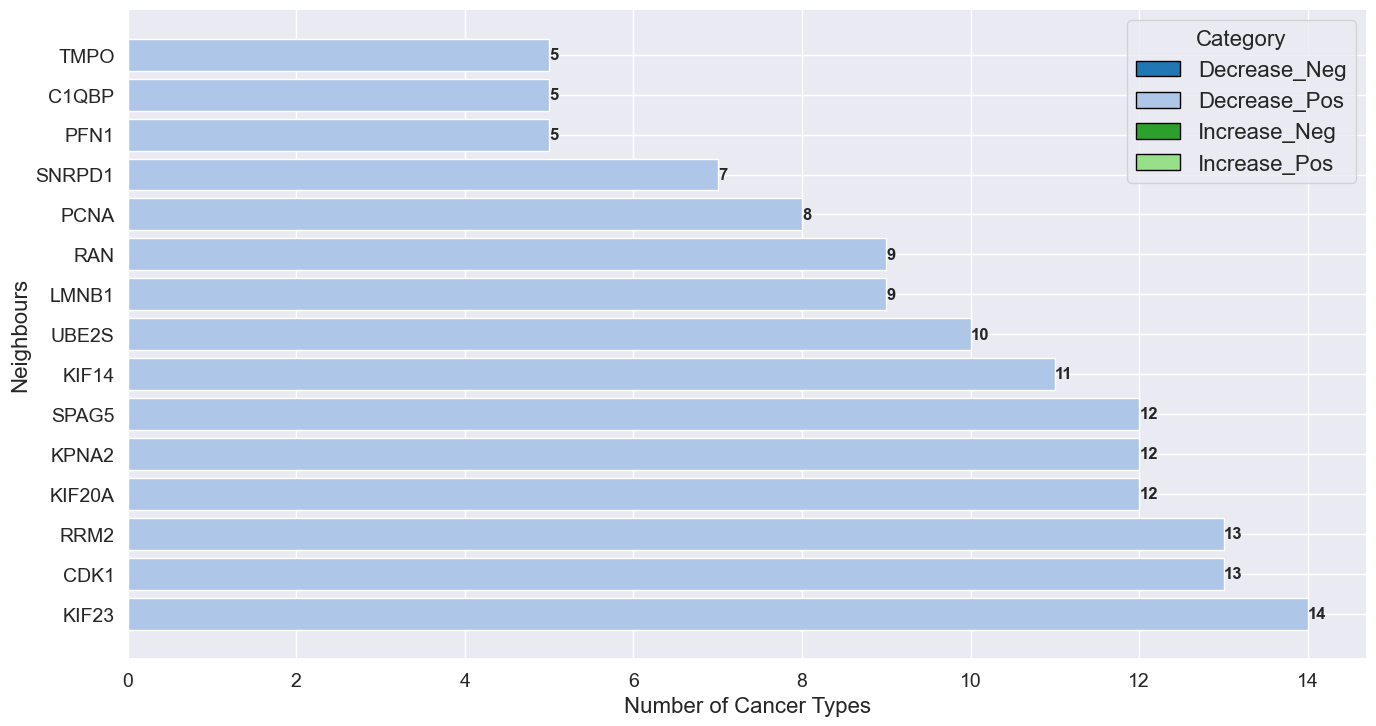


Decrease_Neg:

Decrease_Pos:
  KIF23: 14 cancer types
  CDK1: 13 cancer types
  RRM2: 13 cancer types
  KIF20A: 12 cancer types
  KPNA2: 12 cancer types
  SPAG5: 12 cancer types
  KIF14: 11 cancer types
  UBE2S: 10 cancer types
  LMNB1: 9 cancer types
  RAN: 9 cancer types
  PCNA: 8 cancer types
  SNRPD1: 7 cancer types
  PFN1: 5 cancer types
  C1QBP: 5 cancer types
  TMPO: 5 cancer types

Increase_Neg:

Increase_Pos:


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def categorise_neighbour(trends, freq_column):
    if all(trend == 'decrease' for _, trend in trends):
        return 'Decrease_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    elif all(trend == 'increase' for _, trend in trends):
        return 'Increase_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    return 'Mixed'

graph_data_filt = []
for neighbour, data in neighbour_trends.items():
    category = categorise_neighbour(data['trends'], data['freq_column'])
    if category != 'Mixed':
        cancer_types = len(data['trends'])
        graph_data_filt.append({
            'Category': category,
            'Neighbour': neighbour,
            'Cancer Types': cancer_types
        })

df_graph_filt = pd.DataFrame(graph_data_filt)
df_graph_filt = df_graph_filt.sort_values(['Category', 'Cancer Types'], ascending=[True, False])

plt.figure(figsize=(14, len(df_graph_filt) * 0.5))  # Increase the figure size

# Define colours for each category
colours = {'Decrease_Neg': '#1f77b4', 'Decrease_Pos': '#aec7e8',
           'Increase_Neg': '#2ca02c', 'Increase_Pos': '#98df8a'}

# Plot the bars
bars = plt.barh(df_graph_filt['Neighbour'], df_graph_filt['Cancer Types'], 
                color=[colours[cat] for cat in df_graph_filt['Category']])

# Add labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             ha='left', va='center', fontweight='bold', fontsize=12)  # Increase the font size

# Customise the plot
#plt.title('Neighbours by Trend Category and Number of Cancer Types', fontsize=20)  # Increase the font size
plt.xlabel('Number of Cancer Types', fontsize=16)  # Increase the font size
plt.ylabel('Neighbours', fontsize=16)  # Increase the font size
plt.xticks(fontsize=14)  # Increase the font size of x-axis ticks
plt.yticks(fontsize=14)  # Increase the font size of y-axis ticks

# Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colours[cat], edgecolor='black', label=cat) 
                   for cat in colours.keys()]
plt.legend(handles=legend_elements, title='Category', loc='upper right', 
           fontsize=16, title_fontsize=16)  # Increase the legend font size

plt.tight_layout()
plt.show()

# Print detailed information
for category in ['Decrease_Neg', 'Decrease_Pos', 'Increase_Neg', 'Increase_Pos']:
    print(f"\n{category}:")
    category_data = df_graph_filt[df_graph_filt['Category'] == category]
    for _, row in category_data.iterrows():
        print(f"  {row['Neighbour']}: {row['Cancer Types']} cancer types")

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Load the top neighbours (top_50_neighbours_filt must be pre-loaded)
top_neighbours_filt = top_50_neighbours_filt['neighbour'].tolist()

# Function to perform Kaplan-Meier survival analysis and return p-values and median survival times
def kaplan_meier_survival(data, event, groups):
    p_values = {}
    median_survival = {}

    # Split the data into low and high expression groups
    group_data_low = data[data['Low_Expression']]
    group_data_high = data[data['High_Expression']]

    # Extract durations and event observations
    durations_low = group_data_low['OS.time']
    event_observed_low = group_data_low[event]
    durations_high = group_data_high['OS.time']
    event_observed_high = group_data_high[event]

    # Perform log-rank test
    log_r_result = logrank_test(durations_low, durations_high, event_observed_low, event_observed_high, alpha=0.05)
    p_values['Low_vs_High'] = log_r_result.p_value

    # Kaplan-Meier fit for low and high expression groups
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    kmf_low.fit(durations_low, event_observed_low)
    kmf_high.fit(durations_high, event_observed_high)

    # Record median survival times
    median_survival['Low_Expression'] = kmf_low.median_survival_time_
    median_survival['High_Expression'] = kmf_high.median_survival_time_

    return p_values, median_survival

# Function to plot Kaplan-Meier survival curves
def plot_significant_kaplan_meier(data, event, neighbor, cancer_type):
    plt.figure(figsize=(8, 8))  # Larger figure size for better readability
    
    kmf = KaplanMeierFitter()
    
    # Plot for low expression group
    group_data_low = data[data['Low_Expression']]
    kmf.fit(group_data_low['OS.time'], event_observed=group_data_low[event], label=f'Low {neighbor}')
    kmf.plot(ci_show=False)
    
    # Plot for high expression group
    group_data_high = data[data['High_Expression']]
    kmf.fit(group_data_high['OS.time'], event_observed=group_data_high[event], label=f'High {neighbor}')
    kmf.plot(ci_show=False)
    
    # Set plot labels and title with increased font size
    plt.xlabel('Time (days)', fontsize=16)
    plt.ylabel('Survival Probability', fontsize=16)
    #plt.title(f'Kaplan-Meier Survival Curve\nCancer Type: {cancer_type}, Neighbor: {neighbor}', fontsize=20)
    plt.legend(title='Expression Group', fontsize=14, title_fontsize=14)

    # Increase tick label font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Conduct Kaplan-Meier survival analysis for each cancer type and neighbour
significant_results = []
grouped_data = final_data_filt.groupby('cancer_type')

for cancer_type, group_data in grouped_data:
    for neighbour in top_neighbours_filt:
        # Prepare data for Kaplan-Meier analysis
        neighbour_data = group_data[['patient', neighbour, 'OS.time', 'OS']].copy()
        neighbour_data['Low_Expression'] = neighbour_data[neighbour] <= neighbour_data[neighbour].median()
        neighbour_data['High_Expression'] = neighbour_data[neighbour] > neighbour_data[neighbour].median()

        # Perform survival analysis and get p-values and median survival times
        p_values, median_survival = kaplan_meier_survival(neighbour_data, 'OS', expression_groups)

        for comparison, p_value in p_values.items():
            if p_value < 0.05:  # Only consider significant results
                low_median = median_survival['Low_Expression']
                high_median = median_survival['High_Expression']
                trend = "increase" if high_median > low_median else "decrease"
                significant_results.append((cancer_type, neighbour, comparison, p_value, trend))

# Print significant results
print("Significant Results:")
for result in significant_results:
    print("Cancer Type: {}, Neighbour: {}, Comparison: {}, p-value: {:.4f}, Trend: {}".format(*result))

# Generate plots for significant results
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    group_data = grouped_data.get_group(cancer_type)
    neighbour_data = group_data[['patient', neighbour, 'OS.time', 'OS']].copy()
    neighbour_data['Low_Expression'] = neighbour_data[neighbour] <= neighbour_data[neighbour].median()
    neighbour_data['High_Expression'] = neighbour_data[neighbour] > neighbour_data[neighbour].median()

    plot_significant_kaplan_meier(neighbour_data, 'OS', neighbour, cancer_type)


#### All DINTs

In [ ]:
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

top_neighbours = top_50_neighbours['neighbour'].tolist()

def kaplan_meier_survival(data, event, groups):
    p_values = {}
    median_survival = {}
    group_data_low = data[data['Low_Expression']]
    group_data_high = data[data['High_Expression']]
    durations_low = group_data_low['OS.time']
    event_observed_low = group_data_low[event]
    durations_high = group_data_high['OS.time']
    event_observed_high = group_data_high[event]
    log_r_result = logrank_test(durations_low, durations_high, event_observed_low, event_observed_high, alpha=0.05)
    p_values['Low_vs_High'] = log_r_result.p_value
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    kmf_low.fit(durations_low, event_observed_low)
    kmf_high.fit(durations_high, event_observed_high)
    
    median_survival['Low_Expression'] = kmf_low.median_survival_time_
    median_survival['High_Expression'] = kmf_high.median_survival_time_
    return p_values, median_survival

significant_results = []
grouped_data = final_data.groupby('cancer_type')
expression_groups = ['Low_Expression', 'High_Expression']

for cancer_type, group_data in grouped_data:
    for neighbour in top_neighbours:
        neighbour_data = group_data[['patient', neighbour, 'OS.time', 'OS']].copy()
        neighbour_data['Low_Expression'] = neighbour_data[neighbour] <= neighbour_data[neighbour].median()
        neighbour_data['High_Expression'] = neighbour_data[neighbour] > neighbour_data[neighbour].median()
        
        p_values, median_survival = kaplan_meier_survival(neighbour_data, 'OS', expression_groups)
        
        for comparison, p_value in p_values.items():
            if p_value < 0.05:
                low_median = median_survival['Low_Expression']
                high_median = median_survival['High_Expression']
                trend = "increase" if high_median > low_median else "decrease"
                significant_results.append((cancer_type, neighbour, comparison, p_value, trend))

print("Significant Results:")
for result in significant_results:
    print("Cancer Type: {}, Neighbour: {}, Comparison: {}, p-value: {:.4f}, Trend: {}".format(*result))

neighbour_trends = {}
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = []
    neighbour_trends[neighbour].append((cancer_type, trend))

print("\nNeighbour Trends:")
for neighbour, trends in neighbour_trends.items():
    print(f"Neighbour: {neighbour}")
    for cancer_type, trend in trends:
        print(f"  Cancer Type: {cancer_type}, Trend: {trend}")


Significant Results:
Cancer Type: ACC, Neighbour: CDK1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF14, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF20A, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: AURKB, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: KIF23, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: LMNB1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CDK2, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: CCNB1, Comparison: Low_vs_High, p-value: 0.0001, Trend: decrease
Cancer Type: ACC, Neighbour: KPNA2, Comparison: Low_vs_High, p-value: 0.0005, Trend: decrease
Cancer Type: ACC, Neighbour: PRC1, Comparison: Low_vs_High, p-value: 0.0000, Trend: decrease
Cancer Type: ACC, Neighbour: CHEK1, Compa

In [ ]:
neighbour_to_freq_column = dict(zip(top_50_neighbours['neighbour'], top_50_neighbours['association_type']))

# Update significant_results to include Freq_Column
updated_significant_results = []
for result in significant_results:
    cancer_type, neighbour, comparison, p_value, trend = result
    freq_column = neighbour_to_freq_column.get(neighbour, 'Unknown')
    updated_significant_results.append((cancer_type, neighbour, comparison, p_value, trend, freq_column))

# Update neighbour_trends to include Freq_Column
neighbour_trends = {}
for result in updated_significant_results:
    cancer_type, neighbour, comparison, p_value, trend, freq_column = result
    if neighbour not in neighbour_trends:
        neighbour_trends[neighbour] = {'trends': [], 'freq_column': freq_column}
    neighbour_trends[neighbour]['trends'].append((cancer_type, trend))

# Filter and print the results
print("Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:")
for neighbour, data in neighbour_trends.items():
    trends = data['trends']
    freq_column = data['freq_column']
    
    # Check if all trends are 'decrease' and if the freq_column contains 'Pos'
    if all(trend == 'decrease' for _, trend in trends) and 'Pos' in freq_column:
        print(f"\nNeighbour: {neighbour}")
        print(f"Freq_Column: {freq_column}")
        for cancer_type, trend in trends:
            result = next(r for r in updated_significant_results if r[0] == cancer_type and r[1] == neighbour)
            print(f"  Cancer Type: {cancer_type}, p-value: {result[3]:.5f}, Trend: {trend}")

# Statistics
total_neighbours = len(neighbour_trends)
consistent_decrease_pos = sum(1 for data in neighbour_trends.values() 
                              if all(trend == 'decrease' for _, trend in data['trends']) and 'Pos' in data['freq_column'])

print(f"\nStatistics:")
print(f"Total number of neighbours analysed: {total_neighbours}")
print(f"Neighbours with consistent 'decrease' and 'Pos' in the Freq_Column: {consistent_decrease_pos}")

Neighbours with consistent 'decrease' trend and 'Pos' in the Freq_Column:

Neighbour: CDK1
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: BRCA, p-value: 0.01392, Trend: decrease
  Cancer Type: KICH, p-value: 0.01743, Trend: decrease
  Cancer Type: KIRC, p-value: 0.00000, Trend: decrease
  Cancer Type: KIRP, p-value: 0.00008, Trend: decrease
  Cancer Type: LGG, p-value: 0.00000, Trend: decrease
  Cancer Type: LIHC, p-value: 0.00763, Trend: decrease
  Cancer Type: LUAD, p-value: 0.00001, Trend: decrease
  Cancer Type: MESO, p-value: 0.00000, Trend: decrease
  Cancer Type: PAAD, p-value: 0.00182, Trend: decrease
  Cancer Type: SARC, p-value: 0.03596, Trend: decrease
  Cancer Type: SKCM, p-value: 0.02948, Trend: decrease
  Cancer Type: THYM, p-value: 0.01021, Trend: decrease

Neighbour: KIF14
Freq_Column: Positive
  Cancer Type: ACC, p-value: 0.00000, Trend: decrease
  Cancer Type: KICH, p-value: 0.01246, Trend: decrease
  Cancer Type: KIRC, p-va

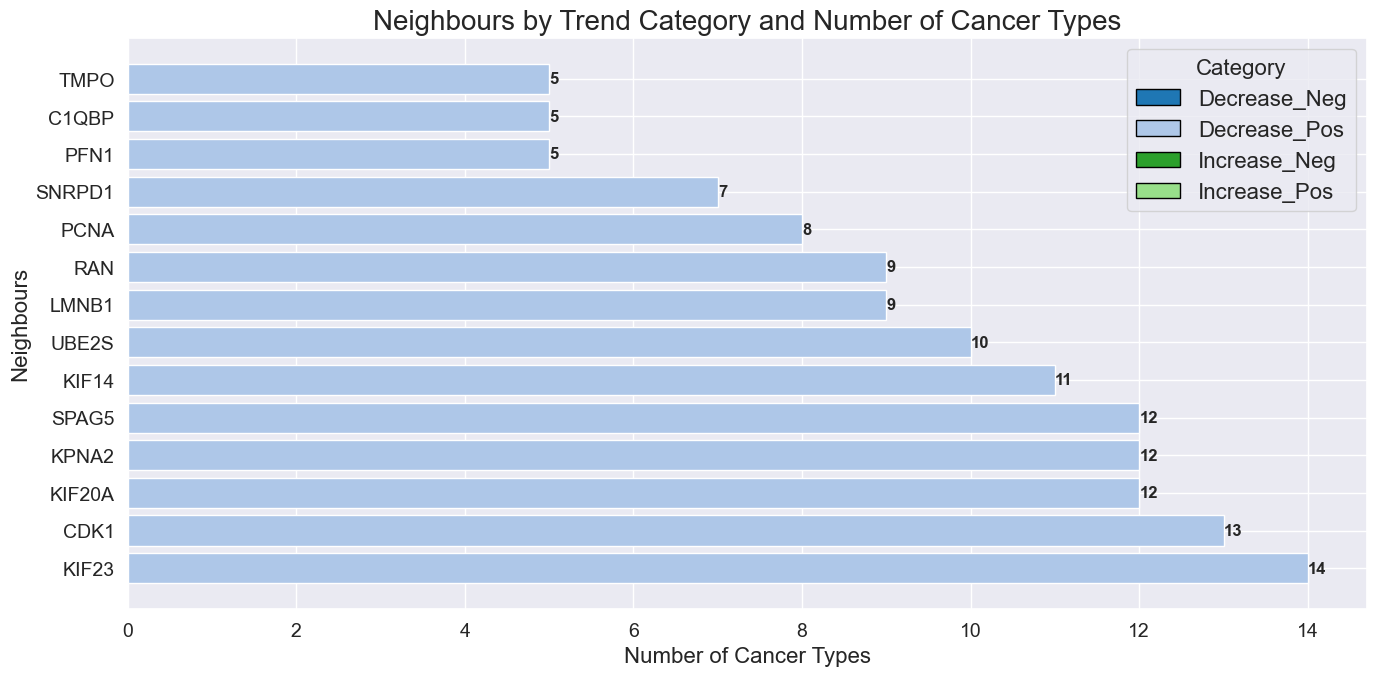


Decrease_Neg:

Decrease_Pos:
  KIF23: 14 cancer types
  CDK1: 13 cancer types
  KIF20A: 12 cancer types
  KPNA2: 12 cancer types
  SPAG5: 12 cancer types
  KIF14: 11 cancer types
  UBE2S: 10 cancer types
  LMNB1: 9 cancer types
  RAN: 9 cancer types
  PCNA: 8 cancer types
  SNRPD1: 7 cancer types
  PFN1: 5 cancer types
  C1QBP: 5 cancer types
  TMPO: 5 cancer types

Increase_Neg:

Increase_Pos:


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def categorise_neighbour(trends, freq_column):
    if all(trend == 'decrease' for _, trend in trends):
        return 'Decrease_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    elif all(trend == 'increase' for _, trend in trends):
        return 'Increase_' + ('Neg' if 'Neg' in freq_column else 'Pos')
    return 'Mixed'

graph_data = []
for neighbour, data in neighbour_trends.items():
    category = categorise_neighbour(data['trends'], data['freq_column'])
    if category != 'Mixed':
        cancer_types = len(data['trends'])
        graph_data.append({
            'Category': category,
            'Neighbour': neighbour,
            'Cancer Types': cancer_types
        })

df_graph = pd.DataFrame(graph_data)
df_graph = df_graph.sort_values(['Category', 'Cancer Types'], ascending=[True, False])

plt.figure(figsize=(14, len(df_graph) * 0.5))  # Increase the figure size

# Define colours for each category
colours = {'Decrease_Neg': '#1f77b4', 'Decrease_Pos': '#aec7e8',
           'Increase_Neg': '#2ca02c', 'Increase_Pos': '#98df8a'}

# Plot the bars
bars = plt.barh(df_graph['Neighbour'], df_graph['Cancer Types'], 
                color=[colours[cat] for cat in df_graph['Category']])

# Add labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             ha='left', va='center', fontweight='bold', fontsize=12)  # Increase the font size

# Customise the plot
plt.title('Neighbours by Trend Category and Number of Cancer Types', fontsize=20)  # Increase the font size
plt.xlabel('Number of Cancer Types', fontsize=16)  # Increase the font size
plt.ylabel('Neighbours', fontsize=16)  # Increase the font size
plt.xticks(fontsize=14)  # Increase the font size of x-axis ticks
plt.yticks(fontsize=14)  # Increase the font size of y-axis ticks

# Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colours[cat], edgecolor='black', label=cat) 
                   for cat in colours.keys()]
plt.legend(handles=legend_elements, title='Category', loc='upper right', 
           fontsize=16, title_fontsize=16)  # Increase the legend font size

plt.tight_layout()
plt.show()

# Print detailed information
for category in ['Decrease_Neg', 'Decrease_Pos', 'Increase_Neg', 'Increase_Pos']:
    print(f"\n{category}:")
    category_data = df_graph[df_graph['Category'] == category]
    for _, row in category_data.iterrows():
        print(f"  {row['Neighbour']}: {row['Cancer Types']} cancer types")

## Analyzing Drivers

In [ ]:
driver_tumour_expression = pd.read_feather(datadir+"driver_tumour_expression.feather")

#### Filtered

In [ ]:
# Step 1: Identify top and bottom 10 drivers by mutation frequency
driver_mutation_freq_filt = final_df_filt.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_10_drivers_filt = driver_mutation_freq_filt.head(10).index.tolist()
bottom_10_drivers_filt = driver_mutation_freq_filt.tail(10).index.tolist()

# Step 2: Find neighbors for these drivers
def get_neighbors(drivers, neighbourtab):
    neighbors = set()
    for driver in drivers:
        neighbors.update(neighbourtab.index[neighbourtab[driver]])
    return list(neighbors)

top_neighbors_filt = get_neighbors(top_10_drivers_filt, neighbourtab)
bottom_neighbors_filt = get_neighbors(bottom_10_drivers_filt, neighbourtab)

# Step 3: Extract expression data
top_expression_filt = tumourexp.loc[:, top_neighbors_filt]
bottom_expression_filt = tumourexp.loc[:, bottom_neighbors_filt]

""" # Step 4: Analyze and visualize
def plot_expression_heatmap(expression_data, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(expression_data.groupby('cancer_type').mean(), cmap='YlOrRd')
    plt.title(title)
    plt.show() """
""" 
plot_expression_heatmap(top_expression, "Expression of Neighbors for Top 10 Mutated Drivers")
plot_expression_heatmap(bottom_expression, "Expression of Neighbors for Bottom 10 Mutated Drivers") """

# Compare mean expression
top_mean_filt = top_expression_filt.mean()
bottom_mean_filt = bottom_expression_filt.mean()

print("Mean expression for neighbors of highly mutated drivers:")
print(top_mean_filt.sort_values(ascending=False).head())
print("\nMean expression for neighbors of lowly mutated drivers:")
print(bottom_mean_filt.sort_values(ascending=False).head())

# Statistical test
def compare_expressions(expr1, expr2):
    common_neighbors = set(expr1.columns) & set(expr2.columns) - {'cancer_type'}
    comp_results = []
    for neighbor in common_neighbors:
        u_stat, u_p_value = stats.mannwhitneyu(expr1[neighbor], expr2[neighbor], alternative='two-sided')
        comp_results.append({
            'Neighbor': neighbor,
            'U-statistic': u_stat,
            'p-value': u_p_value
        })
    return pd.DataFrame(comp_results).sort_values('p-value')

comparison_results_filt = compare_expressions(top_expression_filt, bottom_expression_filt)
print("\nTop differentially expressed neighbors:")
print(comparison_results_filt.head(10))

# Visualize top differential neighbors
""" def plot_top_differential(expr1, expr2, comparison_results, n=5):
    top_diff = comparison_results.head(n)['Neighbor']
    plt.figure(figsize=(15, 5*n))
    for i, neighbor in enumerate(top_diff, 1):
        plt.subplot(n, 1, i)
        sns.violinplot(x='cancer_type', y=neighbor, data=pd.concat([expr1, expr2]))
        plt.title(f"Expression of {neighbor}")
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_top_differential(top_expression, bottom_expression, comparison_results) """


Mean expression for neighbors of highly mutated drivers:
ACTB      16.533941
EEF1A1    16.198110
ACTG1     16.049729
GAPDH     15.945763
TPT1      15.629548
dtype: float64

Mean expression for neighbors of lowly mutated drivers:
ACTB      16.533941
UBC       15.030259
ENO1      14.675502
PABPC1    14.594079
CTSB      14.517812
dtype: float64

Top differentially expressed neighbors:
    Neighbor  U-statistic  p-value
0       CCT8   35313608.0      1.0
500    PRKCE   35313608.0      1.0
501     CDK9   35313608.0      1.0
502   HNRNPM   35313608.0      1.0
503      GHR   35313608.0      1.0
504  SLC12A2   35313608.0      1.0
505      NF2   35313608.0      1.0
506  ATP6AP2   35313608.0      1.0
507      ATM   35313608.0      1.0
508   ITGA2B   35313608.0      1.0


' def plot_top_differential(expr1, expr2, comparison_results, n=5):\n    top_diff = comparison_results.head(n)[\'Neighbor\']\n    plt.figure(figsize=(15, 5*n))\n    for i, neighbor in enumerate(top_diff, 1):\n        plt.subplot(n, 1, i)\n        sns.violinplot(x=\'cancer_type\', y=neighbor, data=pd.concat([expr1, expr2]))\n        plt.title(f"Expression of {neighbor}")\n        plt.xticks(rotation=90)\n    plt.tight_layout()\n    plt.show()\n\nplot_top_differential(top_expression, bottom_expression, comparison_results) '

In [ ]:
# Step 1: Identificar os 10 drivers com maior e menor frequência de mutação
driver_mutation_freq_filt = final_df_filt.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_10_drivers_filt = driver_mutation_freq_filt.head(10).index.tolist()
bottom_10_drivers_filt = driver_mutation_freq_filt.tail(10).index.tolist()

# Step 2: Ver o número de vizinhos diretamente da coluna 'n_neighbours' em filt_drivers
top_10_drivers_vizinhos = filt_drivers[filt_drivers['driver'].isin(top_10_drivers_filt)][['driver', 'n_neighbours']]
bottom_10_drivers_vizinhos = filt_drivers[filt_drivers['driver'].isin(bottom_10_drivers_filt)][['driver', 'n_neighbours']]

print("Top 10 drivers com maior frequência de mutação e seus vizinhos:")
print(top_10_drivers_vizinhos)

print("\nBottom 10 drivers com menor frequência de mutação e seus vizinhos:")
print(bottom_10_drivers_vizinhos)


Top 10 drivers com maior frequência de mutação e seus vizinhos:
       driver  n_neighbours
131       APC           378
155    ARID1A           236
202      ATRX           220
763   FAM135B            16
821       FLG            92
1153    KMT2D           169
1158     KRAS          2582
1655   PIK3R1           695
1781     PTEN           754
2170    SYNE1           115

Bottom 10 drivers com menor frequência de mutação e seus vizinhos:
        driver  n_neighbours
483    CREB3L3            84
775      FANCF            48
1103     KCNK1            73
1156    KNSTRN            73
1605  PDCD1LG2            52
1790     PTPN1           623
1822      RALY           291
2119       SPN            69
2242     THOC7            92
2516    ZNF384            45


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Step 1: Identify top and bottom 10 drivers by mutation frequency
driver_mutation_freq_filt = significant_results_with_cancer_df_filt.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_3_drivers_filt = driver_mutation_freq_filt.head(3).index.tolist()
bottom_3_drivers_filt = driver_mutation_freq_filt.tail(3).index.tolist()

# Step 2: Find neighbors for these drivers
def get_neighbors(drivers, neighbourtab):
    neighbors = set()
    for driver in drivers:
        neighbors.update(neighbourtab.index[neighbourtab[driver]])
    return list(neighbors)

top_neighbors_filt = get_neighbors(top_3_drivers_filt, neighbourtab)
bottom_neighbors_filt = get_neighbors(bottom_3_drivers_filt, neighbourtab)

# Step 3: Extract expression data
top_expression_filt = tumourexp[top_neighbors_filt]
bottom_expression_filt = tumourexp[bottom_neighbors_filt]
""" 
# Step 4: Analyze and visualize
def plot_expression_heatmap(expression_data, title):
    plt.figure(figsize=(12, 8))
    mean_expression = expression_data.groupby('cancer_type').mean()
    sns.heatmap(mean_expression, cmap='YlOrRd')
    plt.title(title)
    plt.show()
 """
""" plot_expression_heatmap(top_expression, "Expression of Neighbors for Top 3 Mutated Drivers")
plot_expression_heatmap(bottom_expression, "Expression of Neighbors for Bottom 3 Mutated Drivers")
 """
def separate_by_mutation_status(expression_data, driver, mutationtab):
    # Ensure the driver is in the mutationtab
    if driver not in mutationtab.columns:
        print(f"Warning: Driver {driver} not found in mutation data. Skipping...")
        return None, None

    # Merge expression data with mutation data
    merged_data = expression_data.merge(
        mutationtab[driver].rename(f"{driver}_mutation"),
        left_index=True, 
        right_index=True, 
        how='left'
    )
    
    # Separate based on mutation status
    expr_with_mutation = merged_data[merged_data[f"{driver}_mutation"] == 1].drop(columns=[f"{driver}_mutation"])
    expr_without_mutation = merged_data[merged_data[f"{driver}_mutation"] == 0].drop(columns=[f"{driver}_mutation"])

    return expr_with_mutation, expr_without_mutation

# Modify the analyze_driver_expression function to handle None returns
def analyze_driver_expression(drivers, neighbors, expression_data, mutationtab):
    for driver in drivers:
        expr_with_mutation, expr_without_mutation = separate_by_mutation_status(expression_data[neighbors], driver, mutationtab)
        
        if expr_with_mutation is None or expr_without_mutation is None:
            continue
        
        # Plot heatmaps
        #plot_expression_heatmap(expr_with_mutation, f"Expression of Neighbors for Driver {driver} (With Mutation)")
        #plot_expression_heatmap(expr_without_mutation, f"Expression of Neighbors for Driver {driver} (Without Mutation)")
        
        # Compare mean expression
        with_mean = expr_with_mutation.groupby('cancer_type').mean().mean()
        without_mean = expr_without_mutation.groupby('cancer_type').mean().mean()
        
        print(f"Mean expression for neighbors of driver {driver} (With Mutation):")
        print(with_mean.sort_values(ascending=False).head())
        print(f"\nMean expression for neighbors of driver {driver} (Without Mutation):")
        print(without_mean.sort_values(ascending=False).head())
        
        # Statistical test
        comparison_results = compare_expressions(expr_with_mutation, expr_without_mutation)
        print(f"\nTop differentially expressed neighbors for driver {driver}:")
        print(comparison_results.head(10))
        
        # Visualize top differential neighbors
        #plot_top_differential(expr_with_mutation, expr_without_mutation, comparison_results)

# Helper functions
def compare_expressions(expr1, expr2):
    common_neighbors = set(expr1.columns) & set(expr2.columns)
    results = []
    for neighbor in common_neighbors:
        u_stat, p_value_u = stats.mannwhitneyu(expr1[neighbor], expr2[neighbor], alternative='two-sided')
        results.append({'Neighbor': neighbor, 'U-statistic': u_stat, 'p-value': p_value_u})
    return pd.DataFrame(results).sort_values('p-value')
""" 
def plot_top_differential(expr1, expr2, comparison_results, n=5):
    top_diff = comparison_results.head(n)['Neighbor']
    plt.figure(figsize=(15, 5*n))
    for i, neighbor in enumerate(top_diff, 1):
        plt.subplot(n, 1, i)
        combined_data = pd.concat([expr1[[neighbor]], expr2[[neighbor]]])
        sns.violinplot(x='cancer_type', y=neighbor, data=combined_data.reset_index())
        plt.title(f"Expression of {neighbor}")
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
 """
# Run the analysis with the corrected functions
print("Analyzing top drivers:")
analyze_driver_expression(top_3_drivers_filt, top_neighbors_filt, tumourexp, mutationtab)

print("\nAnalyzing bottom drivers:")
analyze_driver_expression(bottom_3_drivers_filt, bottom_neighbors_filt, tumourexp, mutationtab)

Analyzing top drivers:
Mean expression for neighbors of driver PTEN (With Mutation):
EEF2        15.570664
UBC         15.001127
HSP90AB1    14.697151
GNAS        14.615128
HSPA8       14.613045
dtype: float64

Mean expression for neighbors of driver PTEN (Without Mutation):
EEF2        15.662662
UBC         15.010452
HSP90AB1    14.872655
RPS4X       14.814078
RPS6        14.793954
dtype: float64

Top differentially expressed neighbors for driver PTEN:
     Neighbor  U-statistic       p-value
696    MAP2K6    3717827.0  3.544667e-87
1075     EYA2    3590852.0  8.290527e-70
937      PBX3    1498144.0  4.332310e-68
882    ABLIM3    1498495.0  4.805579e-68
704     STX18    3533619.5  1.267146e-62
481      TP53    3527179.5  7.732690e-62
661      LEF1    3525576.5  1.210842e-61
1185     RCC2    3491800.0  1.270233e-57
1098      PBK    3484309.5  9.489923e-57
86       WNT3    1601725.5  1.522079e-55
Mean expression for neighbors of driver APC (With Mutation):
EEF2        15.708286
UBC     

Driver AGO4 not found in mutation or expression data. Skipping...
Driver AJUBA not found in mutation or expression data. Skipping...
Driver AMER1 not found in mutation or expression data. Skipping...
Driver APOBR not found in mutation or expression data. Skipping...
Driver ARHGAP35 not found in mutation or expression data. Skipping...
Driver BRINP3 not found in mutation or expression data. Skipping...
Driver C2CD5 not found in mutation or expression data. Skipping...
Driver CCP110 not found in mutation or expression data. Skipping...
Driver CMTR1 not found in mutation or expression data. Skipping...
Driver CNTRL not found in mutation or expression data. Skipping...
Driver CTIF not found in mutation or expression data. Skipping...
Driver DROSHA not found in mutation or expression data. Skipping...
Driver KANSL1 not found in mutation or expression data. Skipping...
Driver KAT6A not found in mutation or expression data. Skipping...
Driver KAT7 not found in mutation or expression data. Ski

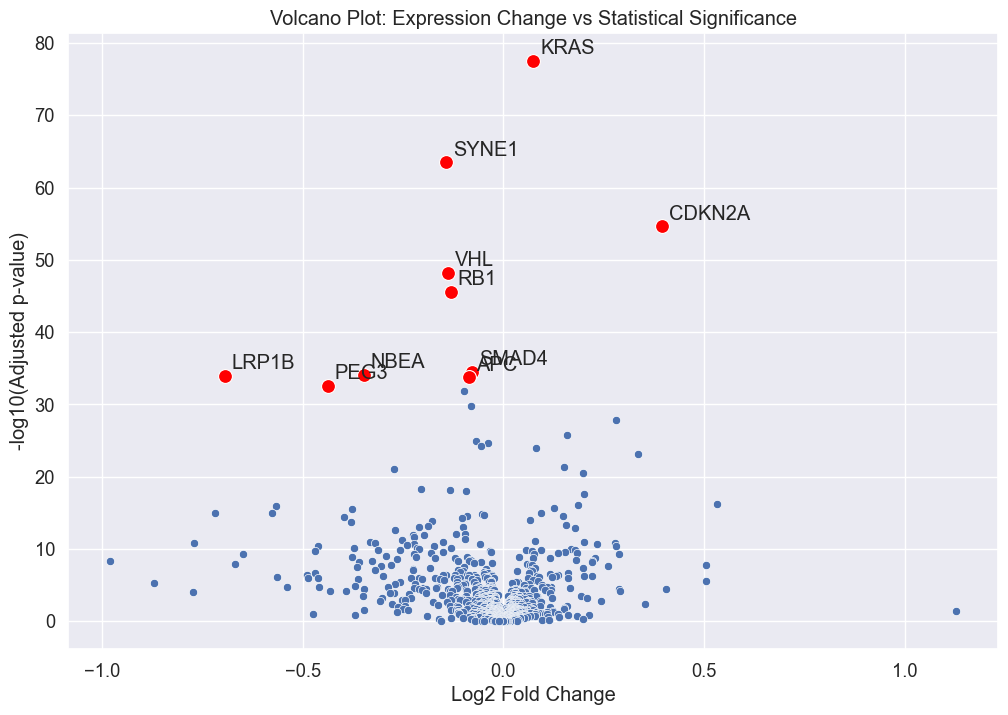

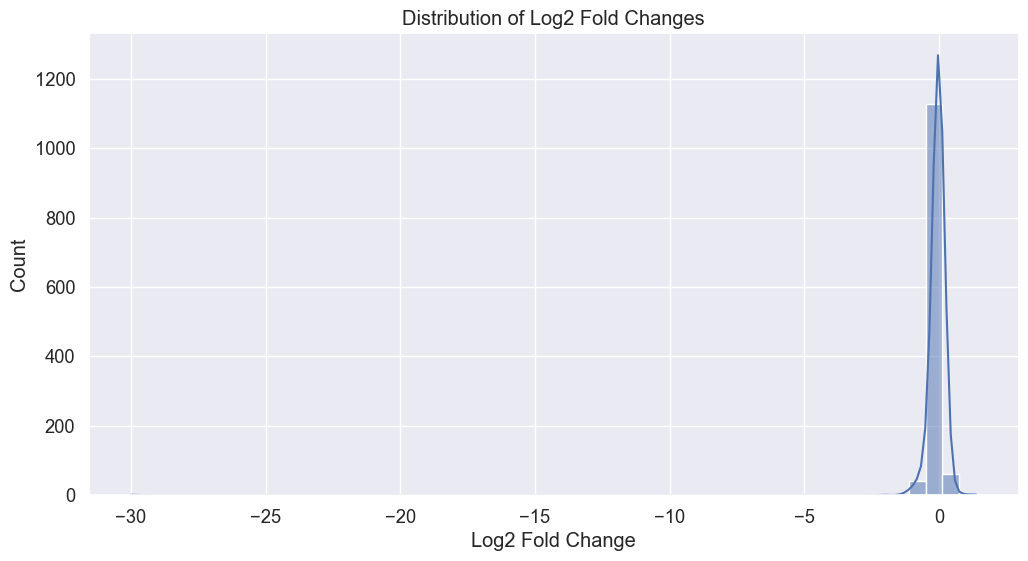

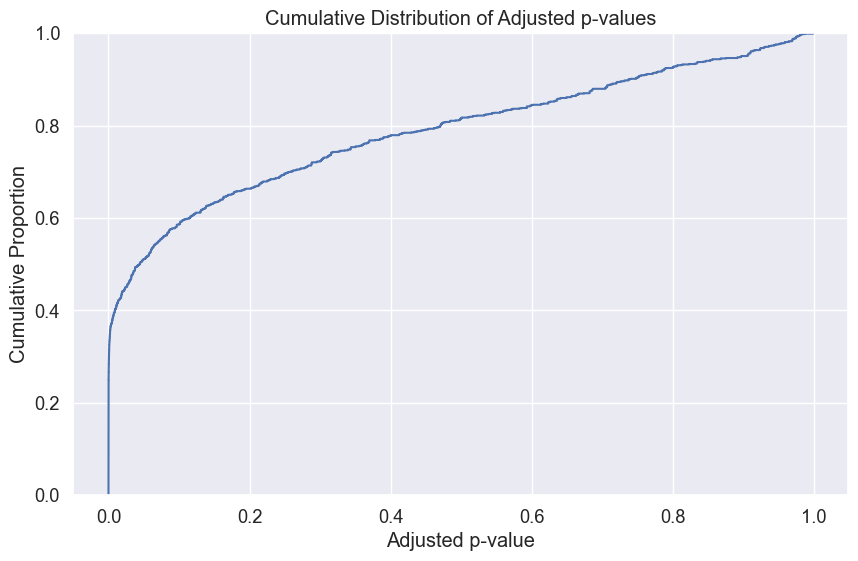

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def get_unique_drivers(filtered_results):
    return filtered_results['driver'].unique()

def analyze_driver_expression(driver, mutationtab, tumourexp):
    mutation_status = mutationtab[driver]
    expression = tumourexp[driver]
    
    combined_data = pd.DataFrame({'mutation': mutation_status, 'expression': expression})
    
    mutated_expr = combined_data[combined_data['mutation'] == 1]['expression']
    non_mutated_expr = combined_data[combined_data['mutation'] == 0]['expression']
    
    mean_expr_mutated = mutated_expr.mean()
    mean_expr_non_mutated = non_mutated_expr.mean()
    
    # Calcular log2 fold change com um pequeno epsilon para evitar divisão por zero
    epsilon = 1e-10
    log2_fold_change = np.log2((mean_expr_mutated + epsilon) / (mean_expr_non_mutated + epsilon))
    
    # Realizar o teste de Mann-Whitney apenas se houver amostras suficientes em ambos os grupos
    if len(mutated_expr) > 0 and len(non_mutated_expr) > 0:
        statistic, p_value = stats.mannwhitneyu(mutated_expr, non_mutated_expr, alternative='two-sided')
    else:
        statistic, p_value = np.nan, np.nan
    
    return {
        'driver': driver,
        'mean_expr_mutated': mean_expr_mutated,
        'mean_expr_non_mutated': mean_expr_non_mutated,
        'mann_whitney_statistic': statistic,
        'p_value': p_value,
        'log2_fold_change': log2_fold_change
    }
def benjamini_hochberg_correction(p_values):
    p_values = np.array(p_values)
    n = len(p_values)
    print(f"Number of p-values: {n}")
    print(f"Original p-values: {p_values}")

    # Remove NaN values
    valid_mask = ~np.isnan(p_values)
    valid_p_values = p_values[valid_mask]
    m = len(valid_p_values)
    print(f"Number of valid p-values: {m}")

    if m == 0:
        return np.full_like(p_values, np.nan)

    # Sort p-values
    sorted_indices = np.argsort(valid_p_values)
    sorted_p_values = valid_p_values[sorted_indices]
    print(f"Sorted p-values: {sorted_p_values}")

    # Calculate adjusted p-values
    adjusted_p_values = np.zeros(m)
    for i in range(m):
        rank = i + 1
        adjusted_p_values[i] = min(sorted_p_values[i] * m / rank, 1.0)

    # Ensure monotonicity
    for i in range(m-2, -1, -1):
        adjusted_p_values[i] = min(adjusted_p_values[i], adjusted_p_values[i+1])

    print(f"Adjusted p-values (sorted): {adjusted_p_values}")

    # Reorder to match original input
    reordered_adjusted_p_values = np.zeros(m)
    reordered_adjusted_p_values[sorted_indices] = adjusted_p_values

    # Reinsert NaN values
    final_adjusted_p_values = np.full(n, np.nan)
    final_adjusted_p_values[valid_mask] = reordered_adjusted_p_values
    
    print(f"Final adjusted p-values: {final_adjusted_p_values}")

    return final_adjusted_p_values
# As funções get_unique_drivers, analyze_driver_expression e benjamini_hochberg_correction permanecem as mesmas

def main_analysis(drivers, mutationtab, tumourexp):
    main_results = []
    
    for driver in drivers:
        if driver in mutationtab.columns and driver in tumourexp.columns:
            result = analyze_driver_expression(driver, mutationtab, driver_tumour_expression)
            main_results.append(result)
        else:
            print(f"Driver {driver} not found in mutation or expression data. Skipping...")
    
    results_df = pd.DataFrame(main_results)
    results_df['adj_p_value'] = benjamini_hochberg_correction(results_df['p_value'])
    
    # Criar a coluna -log10(adj_p_value) explicitamente
    results_df['-log10(adj_p_value)'] = -np.log10(results_df['adj_p_value'])
    
    results_df = results_df.sort_values('adj_p_value')
    
    # Print summary statistics
    print("Summary of results:")
    print(results_df.describe())
    
    # Print top 20 most significant drivers
    print("\nTop 20 most significant drivers:")
    print(results_df.head(20))
    
    # Volcano plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='log2_fold_change', y='-log10(adj_p_value)', data=results_df)
    plt.title('Volcano Plot: Expression Change vs Statistical Significance')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')
    
    # Highlight top 10 most significant points
    top_10 = results_df.nlargest(10, '-log10(adj_p_value)')
    sns.scatterplot(x='log2_fold_change', y='-log10(adj_p_value)', 
                    data=top_10, color='red', s=100)
    
    for idx, row in top_10.iterrows():
        plt.annotate(row['driver'], 
                     (row['log2_fold_change'], row['-log10(adj_p_value)']),
                     xytext=(5, 5), textcoords='offset points')
    plt.show()

    # Histogram of log2 fold changes
    plt.figure(figsize=(12, 6))
    sns.histplot(results_df['log2_fold_change'], bins=50, kde=True)
    plt.title('Distribution of Log2 Fold Changes')
    plt.xlabel('Log2 Fold Change')
    plt.show()

    # Cumulative distribution of p-values
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(results_df['adj_p_value'])
    plt.title('Cumulative Distribution of Adjusted p-values')
    plt.xlabel('Adjusted p-value')
    plt.ylabel('Cumulative Proportion')
    plt.show()

main_analysis(significant_drivers_filt, mutationtab, driver_tumour_expression)

In [ ]:
category_order = ['non_sign', 'neg', 'more_neg', 'neutral', 'more_pos', 'pos']

      driver  category  mean_expression_mutated  mean_expression_non_mutated  \
0       A1CF  non_sign                 1.364054                     1.733682   
1      A2ML1  more_pos                 3.792646                     3.984380   
2     ABCA10  non_sign                 3.434216                     3.776301   
3     ABCA13  more_pos                 4.416936                     4.238564   
4      ABCA7  non_sign                 8.592880                     8.488046   
...      ...       ...                      ...                          ...   
2462  ZSWIM3  non_sign                 6.757654                     6.826901   
2463  ZSWIM6  non_sign                 8.376133                     8.574214   
2464  ZWILCH  non_sign                 8.974727                     8.440610   
2465   ZWINT       pos                 9.697200                     8.939950   
2466   ZZEF1  more_pos                10.118257                    10.136499   

      mann_whitney_statistic   p_value 

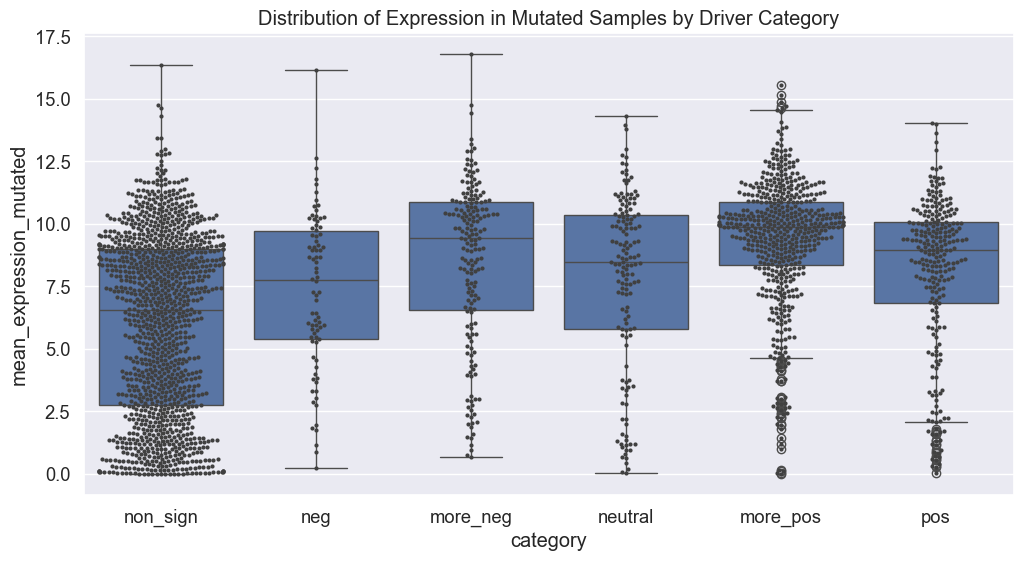

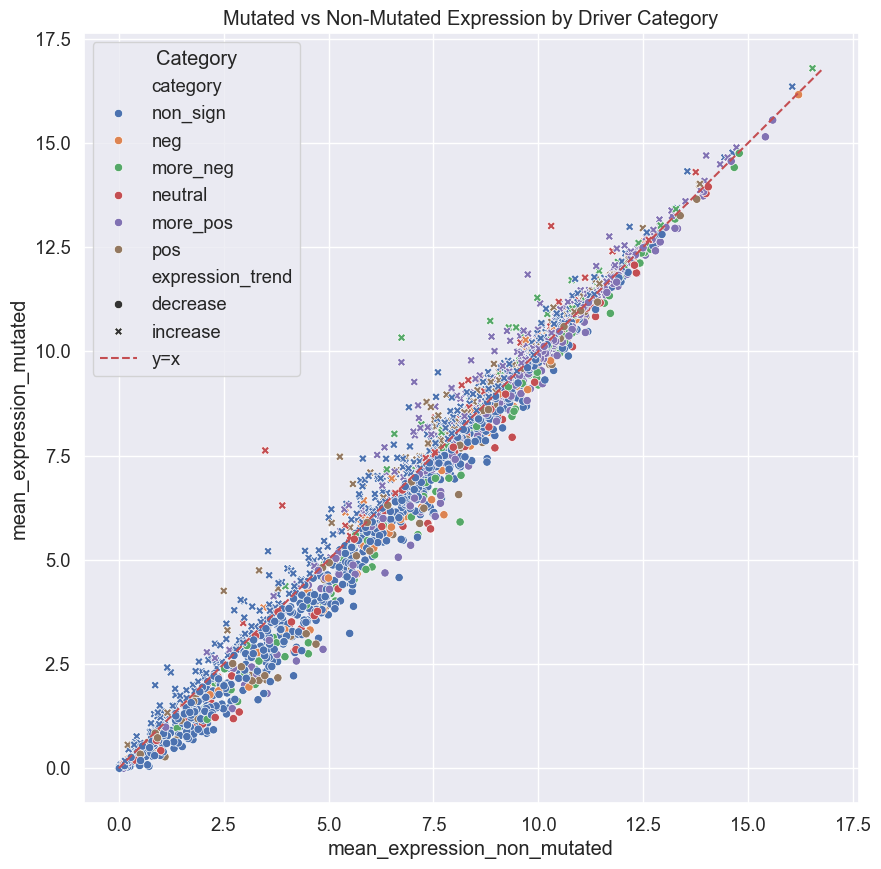


Proportion of expression trends by category:
expression_trend  decrease  increase
category                            
more_neg          0.701087  0.298913
more_pos          0.550179  0.449821
neg               0.658537  0.341463
neutral           0.621622  0.378378
non_sign          0.638281  0.361719
pos               0.519084  0.480916


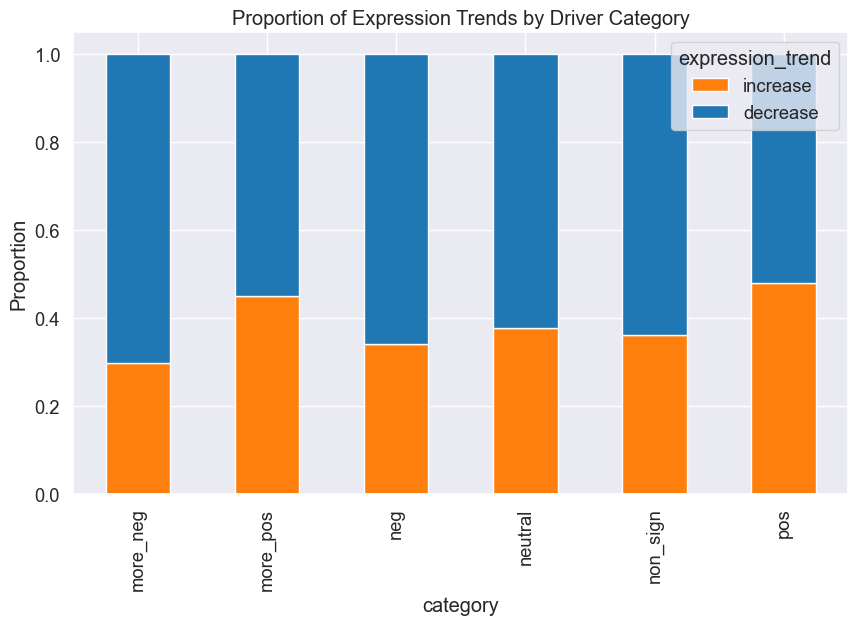


Statistical comparisons between categories:
non_sign vs pos: statistic = 132613.0000, p-value = 0.0000
neg vs non_sign: statistic = 45323.0000, p-value = 0.1163
neg vs neutral: statistic = 5408.0000, p-value = 0.1724
neg vs pos: statistic = 7917.0000, p-value = 0.0003
more_neg vs non_sign: statistic = 105164.0000, p-value = 0.1101
more_neg vs neg: statistic = 7758.0000, p-value = 0.7125
more_neg vs neutral: statistic = 12567.0000, p-value = 0.2278
more_neg vs more_pos: statistic = 39120.0000, p-value = 0.0000
more_neg vs pos: statistic = 17921.0000, p-value = 0.0000
neutral vs non_sign: statistic = 91987.0000, p-value = 0.8710
neutral vs pos: statistic = 16129.0000, p-value = 0.0047
more_pos vs non_sign: statistic = 398194.0000, p-value = 0.0000
more_pos vs neg: statistic = 28603.0000, p-value = 0.0003
more_pos vs neutral: statistic = 47293.0000, p-value = 0.0065
more_pos vs pos: statistic = 70393.0000, p-value = 0.3925

Non-significant (Category non_sign):
      driver  category  mea

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Function to analyze driver expression
def analyze_driver_expression(driver, mutationtab, driver_tumour_expression):
    if driver not in mutationtab.columns or driver not in driver_tumour_expression.columns:
        # Skip drivers that are missing in either dataset
        return None
    
    mutated_individuals = mutationtab[mutationtab[driver] == 1].index
    non_mutated_individuals = mutationtab[mutationtab[driver] == 0].index
    
    exp_mutated = driver_tumour_expression.loc[mutated_individuals, driver]
    exp_non_mutated = driver_tumour_expression.loc[non_mutated_individuals, driver]
    
    if not exp_mutated.empty and not exp_non_mutated.empty:
        statistic, p_value = stats.mannwhitneyu(exp_mutated, exp_non_mutated, alternative='two-sided')
        mean_mutated = exp_mutated.mean()
        mean_non_mutated = exp_non_mutated.mean()
        
        # Ensure correct access to the 'group' (category) column in driver_stats
        category = driver_stats.loc[driver_stats['driver'] == driver, 'group'].values[0]
        
        expression_trend = 'increase' if mean_mutated > mean_non_mutated else 'decrease' if mean_mutated < mean_non_mutated else 'no change'
        
        return {
            'driver': driver,
            'category': category,  # Use the correct driver group
            'mean_expression_mutated': mean_mutated,
            'mean_expression_non_mutated': mean_non_mutated,
            'mann_whitney_statistic': statistic,
            'p_value': p_value,
            'expression_trend': expression_trend
        }
    return None

# Function to compare categories
def compare_categories(cat1, cat2, results_df):
    group1 = results_df[results_df['category'] == cat1]['mean_expression_mutated'] - \
             results_df[results_df['category'] == cat1]['mean_expression_non_mutated']
    group2 = results_df[results_df['category'] == cat2]['mean_expression_mutated'] - \
             results_df[results_df['category'] == cat2]['mean_expression_non_mutated']
    statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    return f"{cat1} vs {cat2}: statistic = {statistic:.4f}, p-value = {p_value:.4f}"

# 1. Use data from filt_drivers to count positive and negative neighbors
driver_stats = filt_drivers[['driver', 'n_neighbours', 'pos_dints', 'neg_dints', 'pos_pct', 'neg_pct', 'group']].copy()

# Filter only drivers that exist in both mutationtab and driver_tumour_expression
common_drivers = driver_stats['driver'][driver_stats['driver'].isin(mutationtab.columns) & driver_stats['driver'].isin(driver_tumour_expression.columns)]

# Apply expression analysis to filtered common drivers
exp_results = [analyze_driver_expression(driver, mutationtab, driver_tumour_expression) for driver in common_drivers]
results_df = pd.DataFrame([r for r in exp_results if r is not None])

# 2. Analysis and visualizations
print(results_df)

category_summary = results_df.groupby('category').agg({
    'mean_expression_mutated': ['mean', 'std'],
    'mean_expression_non_mutated': ['mean', 'std'],
    'p_value': ['mean', 'median'],
    'driver': 'count'
}).rename(columns={'driver': 'count'})

print("\nStatistical summary by category:")
print(category_summary)

# Set category order as per the requested order: non_sign, neg, more_neg, more_pos, pos, neutral
category_order = ['non_sign', 'neg', 'more_neg', 'neutral', 'more_pos', 'pos']

# Boxplot and Swarmplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='mean_expression_mutated', data=results_df, order=category_order)
sns.swarmplot(x='category', y='mean_expression_mutated', data=results_df, color=".25", size=3, order=category_order)
plt.title('Distribution of Expression in Mutated Samples by Driver Category')
plt.show()

# Scatterplot of Mutated vs Non-Mutated Expression
plt.figure(figsize=(10, 10))
sns.scatterplot(x='mean_expression_non_mutated', y='mean_expression_mutated', 
                hue='category', style='expression_trend', data=results_df, hue_order=category_order)
plt.plot([0, results_df['mean_expression_mutated'].max()], 
         [0, results_df['mean_expression_mutated'].max()], 
         'r--', label='y=x')
plt.title('Mutated vs Non-Mutated Expression by Driver Category')
plt.legend(title='Category')
plt.show()

# Proportion of Expression Trends by Category
expression_trends = results_df.groupby('category')['expression_trend'].value_counts(normalize=True).unstack()
print("\nProportion of expression trends by category:")
print(expression_trends)

# Plotting the bar plot with custom colors for 'increase' and 'decrease' expression trends
colors = {'increase': '#ff7f0e', 'decrease': '#1f77b4'}

# Map the colors to the trends in the expression_trends dataframe
expression_trends = expression_trends[['increase', 'decrease']]  # Ensure only increase and decrease trends are considered
expression_trends.plot(kind='bar', stacked=True, figsize=(10, 6), 
                       color=[colors[col] for col in expression_trends.columns])
plt.title('Proportion of Expression Trends by Driver Category')
plt.ylabel('Proportion')
plt.show()


# Statistical comparisons between categories
print("\nStatistical comparisons between categories:")
for cat1 in category_order:
    for cat2 in category_order:
        if cat1 < cat2:
            print(compare_categories(cat1, cat2, results_df))

# Output detailed results by category
expected_categories = {
    'non_sign': 'Non-significant',
    'neg': 'Y-axis (Only negative neighbours)',
    'more_neg': 'Above y=x (More negative than positive neighbours)',
    'more_pos': 'Below y=x (More positive than negative neighbours)',
    'pos': 'X-axis (Only positive neighbours)',
    'neutral': 'Equal number of positive and negative neighbours'
}

for category, description in expected_categories.items():
    print(f"\n{description} (Category {category}):")
    category_df = results_df[results_df['category'] == category]
    print(category_df)


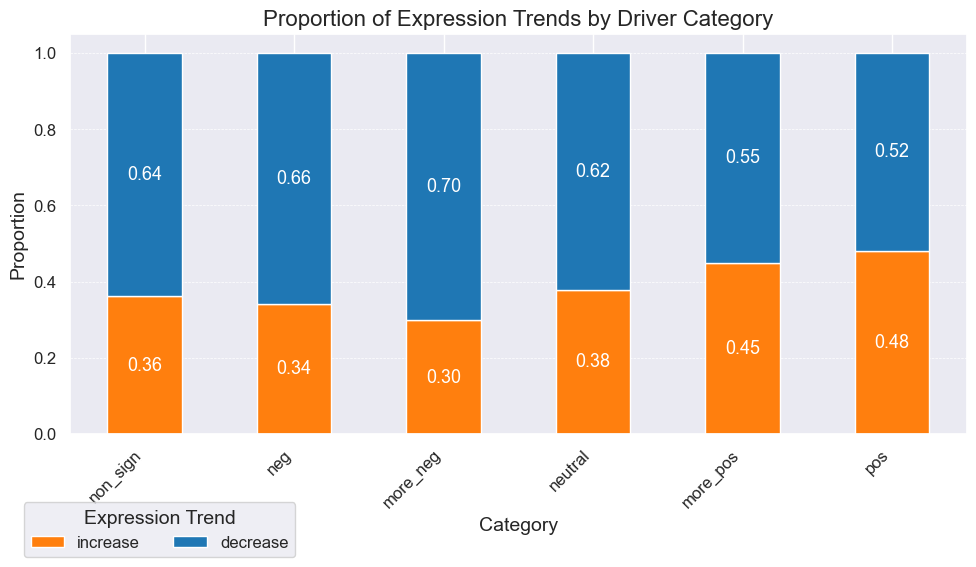

In [ ]:
# Define the colors for 'increase' and 'decrease'
colors = {'increase': '#ff7f0e', 'decrease': '#1f77b4'}

# Ensure only 'increase' and 'decrease' columns are considered in expression_trends
expression_trends = expression_trends[['increase', 'decrease']]

# Reindex the dataframe based on the desired order in 'category_order'
expression_trends = expression_trends.reindex(category_order)

# Create the stacked bar chart with custom colors
ax = expression_trends.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=[colors[col] for col in expression_trends.columns])

# Customize the plot
#plt.title('Proportion of Expression Trends by Driver Category', fontsize=16)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Category', fontsize=14)

# Adjust the x-axis category labels to match the desired style
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and align x-axis labels

plt.yticks(fontsize=12)

# Add values on top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2., f'{height:.2f}', 
                ha='center', va='center', fontsize=10, color='white')

# Move the legend closer
plt.legend(title='Expression Trend', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add gridlines for better readability
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Adjust the layout to ensure nothing overlaps
plt.tight_layout()

# Show the plot
plt.show()


      driver  mean_expr_mutated  mean_expr_non_mutated  expression_change  \
0       A1CF           1.364054               1.733682          -0.369628   
1      A2ML1           3.792646               3.984380          -0.191734   
2     ABCA10           3.434216               3.776301          -0.342086   
3     ABCA13           4.416936               4.238564           0.178372   
4      ABCA7           8.592880               8.488046           0.104834   
...      ...                ...                    ...                ...   
2462  ZSWIM3           6.757654               6.826901          -0.069247   
2463  ZSWIM6           8.376133               8.574214          -0.198081   
2464  ZWILCH           8.974727               8.440610           0.534118   
2465   ZWINT           9.697200               8.939950           0.757250   
2466   ZZEF1          10.118257              10.136499          -0.018242   

         group  num_neighbors  
0     non_sign             39  
1     more_

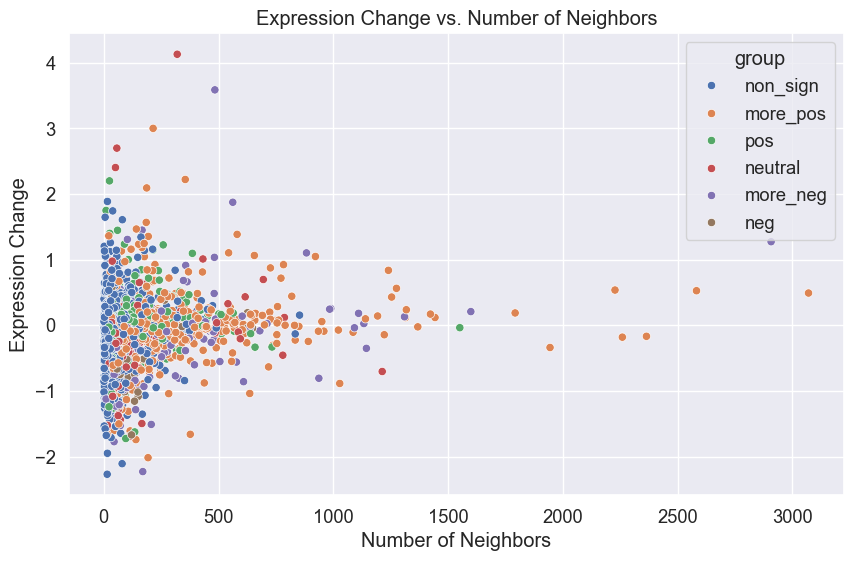

Correlation for mutated drivers: 0.6395, p-value: 0.0000
Correlation for non-mutated drivers: 0.6287, p-value: 0.0000


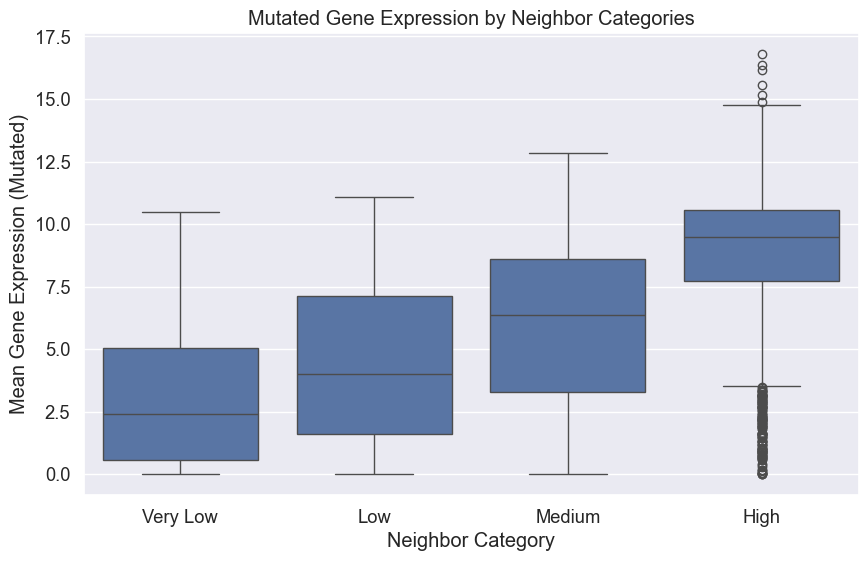

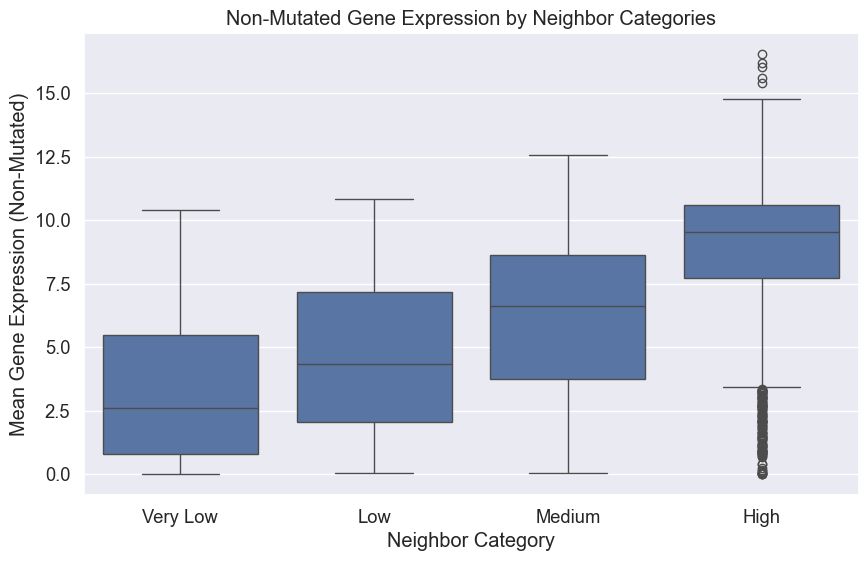

Kruskal-Wallis Test (Mutated): statistic = 746.5109, p-value = 0.0000
Kruskal-Wallis Test (Non-Mutated): statistic = 726.9406, p-value = 0.0000


In [ ]:
def analyze_driver_expression_change_and_group(driver, mutationtab, driver_tumour_expression, filt_drivers):
    mutated_individuals = mutationtab[mutationtab[driver] == 1].index
    non_mutated_individuals = mutationtab[mutationtab[driver] == 0].index
    
    exp_mutated = driver_tumour_expression.loc[mutated_individuals, driver]
    exp_non_mutated = driver_tumour_expression.loc[non_mutated_individuals, driver]
    
    if not exp_mutated.empty and not exp_non_mutated.empty:
        mean_expr_mutated = exp_mutated.mean()
        mean_expr_non_mutated = exp_non_mutated.mean()
        
        expression_change = mean_expr_mutated - mean_expr_non_mutated
        group = filt_drivers.loc[filt_drivers['driver'] == driver, 'group'].values[0]
        num_neighbors = filt_drivers.loc[filt_drivers['driver'] == driver, 'n_neighbours'].values[0]
        
        return driver, mean_expr_mutated, mean_expr_non_mutated, expression_change, group, num_neighbors

# Apply the analysis to common drivers
drivers_expr_change_and_group = []
for driver in common_drivers:
    result = analyze_driver_expression_change_and_group(driver, mutationtab, driver_tumour_expression, filt_drivers)
    if result:
        drivers_expr_change_and_group.append(result)

# Display the results
df_drivers_expr_change_and_group = pd.DataFrame(drivers_expr_change_and_group, 
                                                columns=['driver', 'mean_expr_mutated', 'mean_expr_non_mutated', 
                                                         'expression_change', 'group', 'num_neighbors'])
print(df_drivers_expr_change_and_group)

# Display drivers with increased expression when mutated
print(df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['expression_change'] > 0])

# Correlation between expression change and number of neighbors
correlation = df_drivers_expr_change_and_group['expression_change'].corr(df_drivers_expr_change_and_group['num_neighbors'])
print(f"Correlation between expression change and number of neighbors: {correlation:.2f}")

# Scatter plot of expression change vs. number of neighbors
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_neighbors', y='expression_change', hue='group', data=df_drivers_expr_change_and_group)
plt.title('Expression Change vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Expression Change')
plt.show()

# Create new neighbor categories for a more detailed separation
df_drivers_expr_change_and_group['neighbor_category'] = pd.cut(df_drivers_expr_change_and_group['num_neighbors'], 
                                                               bins=[0, 5, 15, 50, np.inf], 
                                                               labels=['Very Low', 'Low', 'Medium', 'High'])

from scipy.stats import spearmanr

# Correlation for mutated drivers
corr_mutated, p_value_mutated = spearmanr(df_drivers_expr_change_and_group['num_neighbors'], 
                                          df_drivers_expr_change_and_group['mean_expr_mutated'])

# Correlation for non-mutated drivers
corr_non_mutated, p_value_non_mutated = spearmanr(df_drivers_expr_change_and_group['num_neighbors'], 
                                                  df_drivers_expr_change_and_group['mean_expr_non_mutated'])

print(f'Correlation for mutated drivers: {corr_mutated:.4f}, p-value: {p_value_mutated:.4f}')
print(f'Correlation for non-mutated drivers: {corr_non_mutated:.4f}, p-value: {p_value_non_mutated:.4f}')

# Box plot comparison of mutated gene expression by neighbor category
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbor_category', y='mean_expr_mutated', data=df_drivers_expr_change_and_group)
plt.title('Mutated Gene Expression by Neighbor Categories')
plt.xlabel('Neighbor Category')
plt.ylabel('Mean Gene Expression (Mutated)')
plt.show()

# Box plot comparison of non-mutated gene expression by neighbor category
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbor_category', y='mean_expr_non_mutated', data=df_drivers_expr_change_and_group)
plt.title('Non-Mutated Gene Expression by Neighbor Categories')
plt.xlabel('Neighbor Category')
plt.ylabel('Mean Gene Expression (Non-Mutated)')
plt.show()

from scipy.stats import kruskal

# Kruskal-Wallis test for mutated gene expression
stat_mutated, p_mutated = kruskal(df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Very Low']['mean_expr_mutated'],
                                  df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Low']['mean_expr_mutated'],
                                  df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Medium']['mean_expr_mutated'],
                                  df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'High']['mean_expr_mutated'])

# Kruskal-Wallis test for non-mutated gene expression
stat_non_mutated, p_non_mutated = kruskal(df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Very Low']['mean_expr_non_mutated'],
                                          df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Low']['mean_expr_non_mutated'],                                    
                                          df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'Medium']['mean_expr_non_mutated'],
                                          df_drivers_expr_change_and_group[df_drivers_expr_change_and_group['neighbor_category'] == 'High']['mean_expr_non_mutated'])

print(f'Kruskal-Wallis Test (Mutated): statistic = {stat_mutated:.4f}, p-value = {p_mutated:.4f}')
print(f'Kruskal-Wallis Test (Non-Mutated): statistic = {stat_non_mutated:.4f}, p-value = {p_non_mutated:.4f}')


In [ ]:
# Initialize a list to track drivers that return NaN
nan_drivers = []

# Modified expression analysis to track NaN drivers
for driver in common_drivers:
    result = analyze_driver_expression(driver, mutationtab, driver_tumour_expression)
    if result is None:
        nan_drivers.append(driver)

# Display the drivers that resulted in NaN
nan_drivers

[]

In [ ]:
# Count the number of drivers in each category
driver_counts = driver_stats['group'].value_counts()

print("Number of drivers in each category:")
print(driver_counts)

Number of drivers in each category:
group
non_sign    1294
more_pos     576
pos          274
more_neg     185
neutral      151
neg           85
Name: count, dtype: int64


In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table for categories and expression trends
contingency_table = pd.crosstab(results_df['category'], results_df['expression_trend'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of Freedom: {dof}")

print("\nContingency Table:")
print(contingency_table)

print("\nExpected Values:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))



Chi-Square Test Results:
Chi-Square Statistic: 28.9563
P-value: 2.37e-05
Degrees of Freedom: 5

Contingency Table:
expression_trend  decrease  increase
category                            
more_neg               129        55
more_pos               307       251
neg                     54        28
neutral                 92        56
non_sign               787       446
pos                    136       126

Expected Values:
expression_trend    decrease    increase
category                                
more_neg          112.249696   71.750304
more_pos          340.409404  217.590596
neg                50.024321   31.975679
neutral            90.287799   57.712201
non_sign          752.194974  480.805026
pos               159.833806  102.166194


In [ ]:
# Step 1: Ensure mutation_frequency is not NaN and matches with drivers in driver_stats
mutation_frequency = mutationtab.mean()

# Step 2: Calculate expression change for each driver
def calculate_expression_change(row):
    if pd.notna(row['mean_expression_mutated']) and pd.notna(row['mean_expression_non_mutated']):
        return row['mean_expression_mutated'] - row['mean_expression_non_mutated']
    return np.nan

# Apply expression change calculation to results_df
results_df['expression_change'] = results_df.apply(calculate_expression_change, axis=1)

# Step 3: Ensure proper merging by aligning indices (reset index if necessary)
# Ensure that driver_info has the same index and 'driver' column
driver_info = driver_stats.set_index('driver').join(results_df.set_index('driver')[['expression_change']], how='left')

# Merge mutation_frequency based on driver index
driver_info = driver_info.join(mutation_frequency.rename('mutation_frequency'), how='left')

# Step 4: Filter out rows with all NaN values in both expression_change and mutation_frequency
driver_info = driver_info.dropna(subset=['expression_change', 'mutation_frequency'], how='all')

print(driver_info)


        n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group  \
driver                                                                     
A1CF              39          0          0  0.000000  0.000000  non_sign   
A2ML1             91          4          3  0.043956  0.032967  more_pos   
ABCA10             5          0          0  0.000000  0.000000  non_sign   
ABCA13             9          3          1  0.333333  0.111111  more_pos   
ABCA7             16          0          0  0.000000  0.000000  non_sign   
...              ...        ...        ...       ...       ...       ...   
ZSWIM3             6          0          0  0.000000  0.000000  non_sign   
ZSWIM6            22          0          0  0.000000  0.000000  non_sign   
ZWILCH            22          1          0  0.045455  0.000000  non_sign   
ZWINT            136         22          0  0.161765  0.000000       pos   
ZZEF1             89          8          2  0.089888  0.022472  more_pos   

        exp

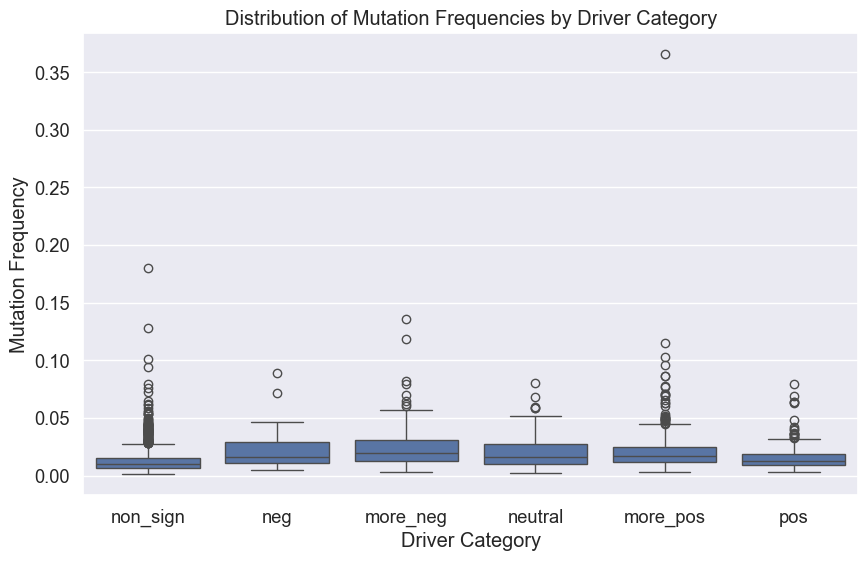

In [ ]:
# Step 4: Visualize mutation frequency by category

# Remove rows with NaN mutation frequencies
filtered_driver_info = driver_info.dropna(subset=['mutation_frequency'])

# Update the category order to only include categories present in the filtered data
present_categories = filtered_driver_info['group'].unique()
category_order_present = [cat for cat in category_order if cat in present_categories]

plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present)
plt.title('Distribution of Mutation Frequencies by Driver Category')
plt.xlabel('Driver Category')
plt.ylabel('Mutation Frequency')
plt.show()


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_25585/4066671782.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, palette='Set2')


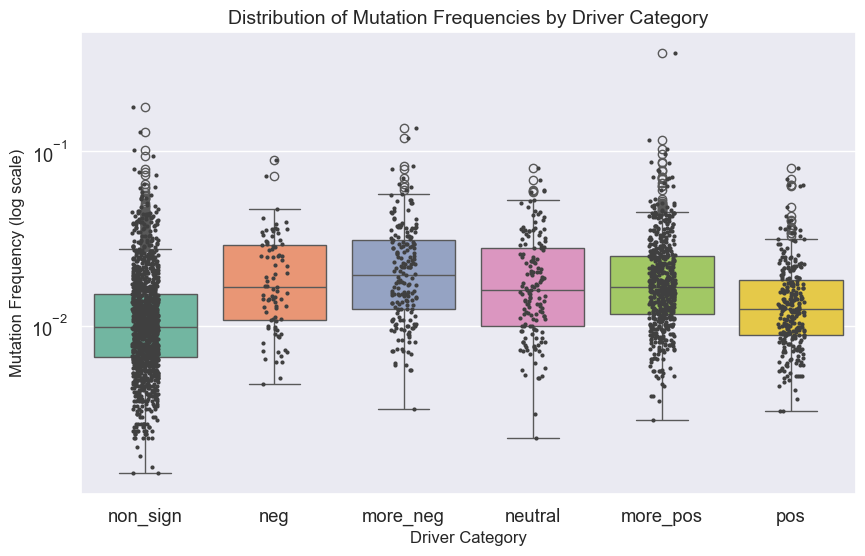

           count      mean       std       min       25%       50%       75%  \
group                                                                          
more_neg   185.0  0.024277  0.018280  0.003332  0.012375  0.019396  0.030819   
more_pos   576.0  0.021129  0.020125  0.002856  0.011661  0.016718  0.024988   
neg         85.0  0.020896  0.014046  0.004641  0.010709  0.016540  0.028915   
neutral    151.0  0.020413  0.014182  0.002261  0.009876  0.015945  0.027784   
non_sign  1294.0  0.012924  0.011736  0.001428  0.006574  0.009757  0.015082   
pos        274.0  0.015163  0.010682  0.003213  0.008805  0.012375  0.018354   

               max  
group               
more_neg  0.136245  
more_pos  0.365778  
neg       0.088767  
neutral   0.079962  
non_sign  0.179914  
pos       0.079605  


In [ ]:
plt.figure(figsize=(10, 6))

# Boxplot with a color palette
sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, palette='Set2')

# Overlay swarmplot for individual data points
#sns.swarmplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, color=".25", size=3)
sns.stripplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, color=".25", size=3)

# Apply log scale to Y-axis to better visualize the smaller frequencies
plt.yscale('log')

# Add titles and labels
plt.title('Distribution of Mutation Frequencies by Driver Category', fontsize=14)
plt.xlabel('Driver Category', fontsize=12)
plt.ylabel('Mutation Frequency (log scale)', fontsize=12)

# Show the plot
plt.show()

# Print summary statistics
summary_stats = filtered_driver_info.groupby('group')['mutation_frequency'].describe()
print(summary_stats)


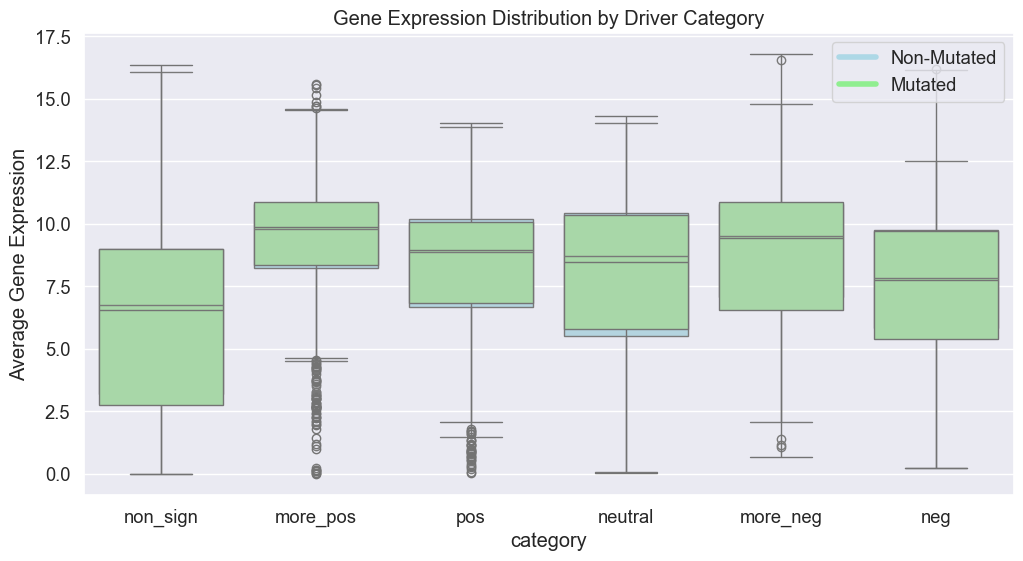

In [ ]:
# Step 3: Visualizing gene expression distribution by category
plt.figure(figsize=(12, 6))

# Plot for non-mutated expression
sns.boxplot(x='category', y='mean_expression_non_mutated', data=results_df[results_df['category'].isin(category_order)], color='lightblue')
# Plot for mutated expression
sns.boxplot(x='category', y='mean_expression_mutated', data=results_df[results_df['category'].isin(category_order)], color='lightgreen', saturation=0.5)

plt.title('Gene Expression Distribution by Driver Category')
plt.ylabel('Average Gene Expression')

# Create custom legend
handles = [
    plt.Line2D([0], [0], color='lightblue', lw=4),
    plt.Line2D([0], [0], color='lightgreen', lw=4)
]
plt.legend(handles, ['Non-Mutated', 'Mutated'], loc='upper right')

plt.show()


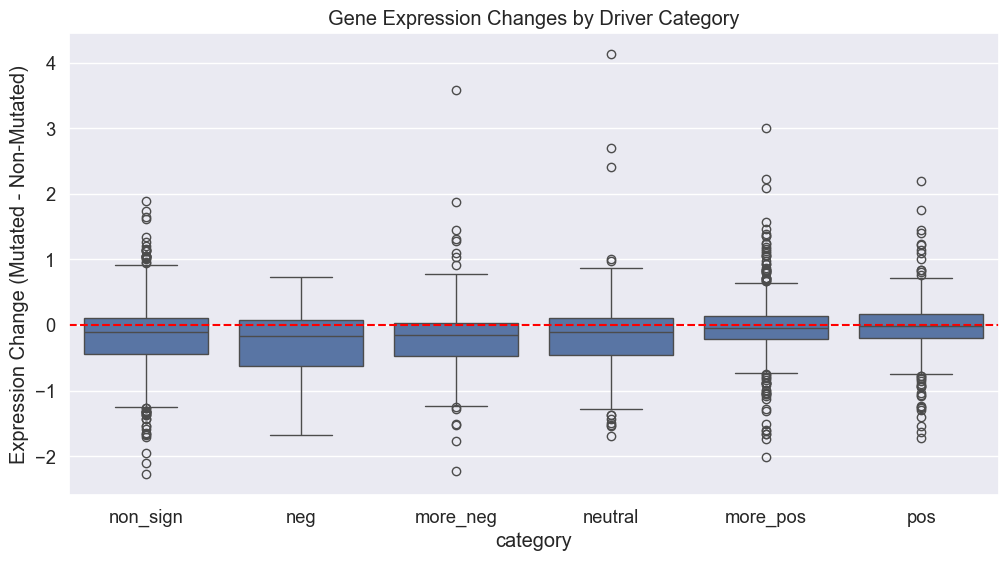

In [ ]:
# Step 5: Visualize expression changes by category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='expression_change', data=results_df, order=category_order)
plt.title('Gene Expression Changes by Driver Category')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Expression Change (Mutated - Non-Mutated)')
plt.show()


In [ ]:
# Step 6: Perform statistical comparisons for mutation frequencies
p_values = []
comparison_results = []
categories = driver_info['group'].unique()

# Pairwise comparison for mutation frequencies across categories
for cat1 in categories:
    for cat2 in categories:
        if cat1 < cat2:
            group1 = driver_info[driver_info['group'] == cat1]['mutation_frequency']
            group2 = driver_info[driver_info['group'] == cat2]['mutation_frequency']
            statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            p_values.append(p_value)
            comparison_results.append({'category1': cat1, 'category2': cat2, 'statistic': statistic, 'p_value': p_value})

# Apply Benjamini-Hochberg correction
corrected_p_values = benjamini_hochberg_correction(p_values)

# Add adjusted p-values to the comparison results
for i, result in enumerate(comparison_results):
    result['adjusted_p_value'] = corrected_p_values[i]

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)


Number of p-values: 15
Original p-values: [1.25500715e-08 7.44636857e-59 1.25048066e-12 4.10868093e-01
 9.28243032e-01 1.00054595e-15 9.37303112e-05 3.08822898e-31
 1.89752299e-02 2.66612346e-12 2.29722210e-02 1.68287295e-01
 7.67347042e-12 7.27239814e-05 6.21604785e-01]
Number of valid p-values: 15
Sorted p-values: [7.44636857e-59 3.08822898e-31 1.00054595e-15 1.25048066e-12
 2.66612346e-12 7.67347042e-12 1.25500715e-08 7.27239814e-05
 9.37303112e-05 1.89752299e-02 2.29722210e-02 1.68287295e-01
 4.10868093e-01 6.21604785e-01 9.28243032e-01]
Adjusted p-values (sorted): [1.11695528e-57 2.31617174e-30 5.00272974e-15 4.68930249e-12
 7.99837039e-12 1.91836761e-11 2.68930103e-08 1.36357465e-04
 1.56217185e-04 2.84628449e-02 3.13257559e-02 2.10359119e-01
 4.74078569e-01 6.66005127e-01 9.28243032e-01]
Final adjusted p-values: [2.68930103e-08 1.11695528e-57 4.68930249e-12 4.74078569e-01
 9.28243032e-01 5.00272974e-15 1.56217185e-04 2.31617174e-30
 2.84628449e-02 7.99837039e-12 3.13257559e-02 2

In [ ]:
# Step 7: Perform Mann-Whitney U test for expression changes across categories
for category in present_categories:
    category_data = results_df[results_df['category'] == category]
    if len(category_data) > 1:
        statistic, p_value = stats.mannwhitneyu(category_data['mean_expression_mutated'], 
                                                category_data['mean_expression_non_mutated'], alternative='two-sided')
        print(f"\nCategoria {category}:")
        print(f"Teste de Mann-Whitney U: estatística = {statistic:.4f}, p-valor = {p_value:.4e}")

# Step 8: Perform Kruskal-Wallis test to compare expression change across categories
category_groups = [group['expression_change'].dropna() for name, group in results_df.groupby('category') if name in present_categories]
kruskal_statistic, kruskal_p_value = stats.kruskal(*category_groups)

print("\nKruskal-Wallis test para comparar a mudança na expressão entre categorias:")
print(f"Kruskal-Wallis estatística: {kruskal_statistic:.4f}")
print(f"p-valor: {kruskal_p_value:.4e}")



Categoria non_sign:
Teste de Mann-Whitney U: estatística = 740041.0000, p-valor = 2.5549e-01

Categoria more_pos:
Teste de Mann-Whitney U: estatística = 156128.0000, p-valor = 9.3405e-01

Categoria pos:
Teste de Mann-Whitney U: estatística = 34426.0000, p-valor = 9.5238e-01

Categoria neutral:
Teste de Mann-Whitney U: estatística = 10755.0000, p-valor = 7.8956e-01

Categoria more_neg:
Teste de Mann-Whitney U: estatística = 16621.0000, p-valor = 7.6388e-01

Categoria neg:
Teste de Mann-Whitney U: estatística = 3185.0000, p-valor = 5.6160e-01

Kruskal-Wallis test para comparar a mudança na expressão entre categorias:
Kruskal-Wallis estatística: 56.3701
p-valor: 6.8184e-11


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_25585/809199625.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_results['abs_corr'] = significant_results['correlation'].abs()
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_25585/809199625.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=significant_results, x='gene', y='correlation', palette='coolwarm')


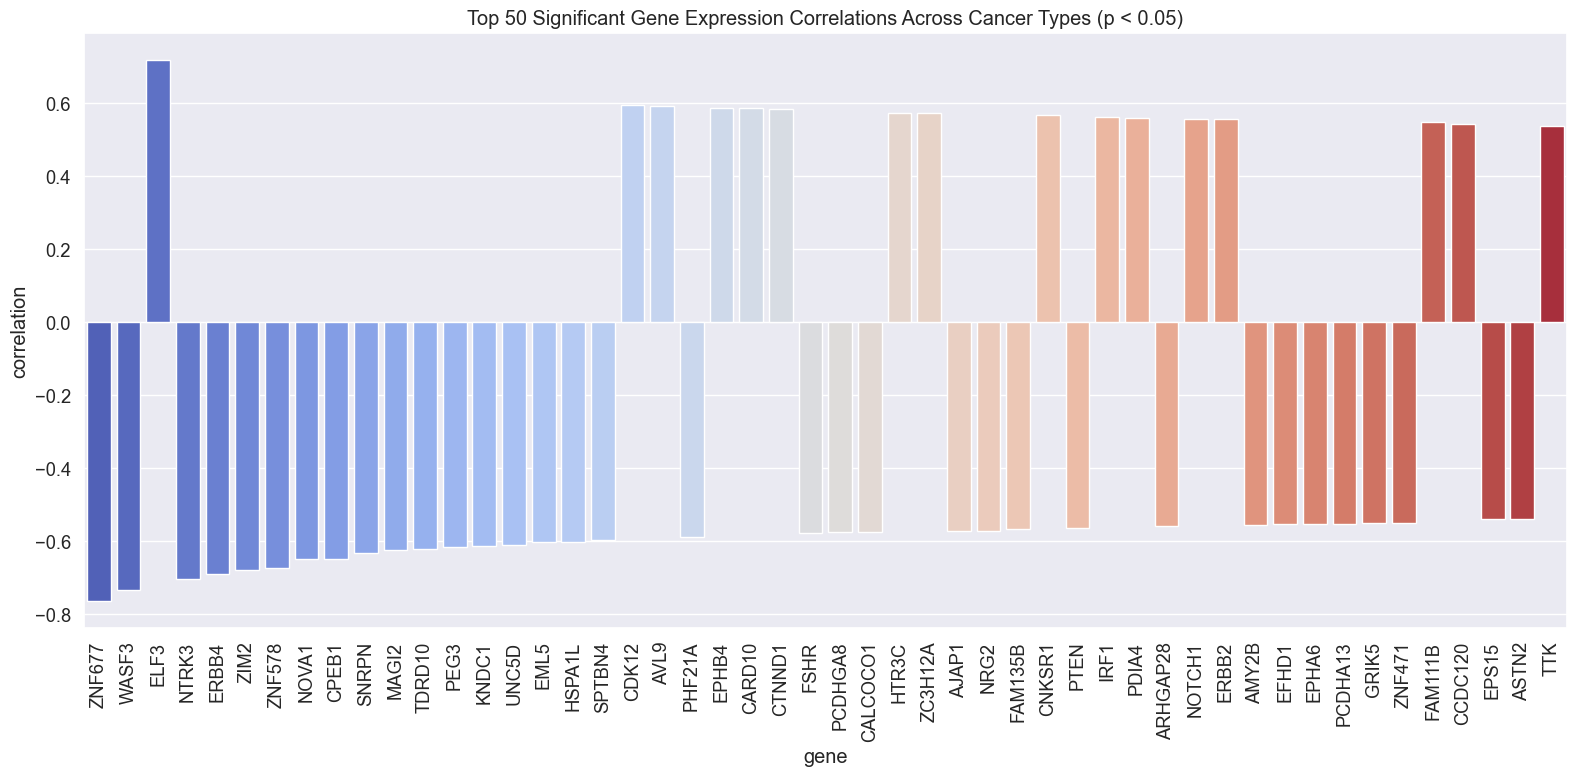

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute mutation frequencies and expression data by cancer type
def compute_cancer_type_stats(mutationtab, expression_data, cancer_type_column='cancer_type'):
    # Ensure that 'cancer_type' is the index in both mutationtab and expression_data
    mutationtab = mutationtab.reset_index().set_index(cancer_type_column)
    expression_data = expression_data.reset_index().set_index(cancer_type_column)
    
    # Select only numeric columns for mean computation
    mutation_by_cancer = mutationtab.select_dtypes(include=[np.number]).groupby(cancer_type_column).mean()
    expression_by_cancer = expression_data.select_dtypes(include=[np.number]).groupby(cancer_type_column).mean()
    
    return mutation_by_cancer, expression_by_cancer

# Step 2: Statistical comparison of mutations and expression patterns across cancer types
def compare_gene_expression_across_cancers(mutation_by_cancer, expression_by_cancer):
    results = []
    # Compare each gene's mutation and expression across cancer types using Spearman correlation
    for gene in mutation_by_cancer.columns:
        if gene in expression_by_cancer.columns:
            gene_mutation_data = mutation_by_cancer[gene]
            gene_expression_data = expression_by_cancer[gene]
            correlation, p_value = stats.spearmanr(gene_mutation_data, gene_expression_data)
            results.append({
                'gene': gene,
                'correlation': correlation,
                'p_value': p_value
            })
    return pd.DataFrame(results)

# Step 3: Visualization of significant correlations
def plot_correlation_results(results_df, p_value_threshold=0.05, top_n=50):
    # Filter results based on the p-value threshold
    significant_results = results_df[results_df['p_value'] < p_value_threshold]
    
    # Optionally, sort and limit to the top N most correlated genes
    significant_results['abs_corr'] = significant_results['correlation'].abs()
    significant_results = significant_results.sort_values(by='abs_corr', ascending=False).head(top_n)
    
    # Plotting
    plt.figure(figsize=(16, 8))  # Increased figure size
    sns.barplot(data=significant_results, x='gene', y='correlation', palette='coolwarm')
    plt.title(f'Top {top_n} Significant Gene Expression Correlations Across Cancer Types (p < {p_value_threshold})')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()
# Step 4: Putting everything together
def perform_cross_cancer_comparison(mutationtab, expression_data, cancer_type_column='cancer_type'):
    mutation_by_cancer, expression_by_cancer = compute_cancer_type_stats(mutationtab, expression_data, cancer_type_column)
    results_df = compare_gene_expression_across_cancers(mutation_by_cancer, expression_by_cancer)
    plot_correlation_results(results_df)

# Execute the analysis
perform_cross_cancer_comparison(mutationtab, tumourexp)


In [ ]:
cancerdrivers

entrez        symbol  pubmed_id                     type  \
0            23         ABCF1   31444325                  WGS-WES   
1            25          ABL1   29625053               Pan-cancer   
2            25          ABL1   14993899  Canonical Cancer Driver   
3            25          ABL1   29489755               Pan-cancer   
4            25          ABL1   23539594  Canonical Cancer Driver   
...         ...           ...        ...                      ...   
8881  100423062         IGLL5   31558468                      WGS   
8882  100423062         IGLL5   31558468                      WGS   
8883  100423062         IGLL5   32024818                      WGS   
8884  100505993       TMEM210   27311963                      WGS   
8885  100533105  C8orf44-SGK3   28362259                      WGS   

                   organ_system primary_site            cancer_type  \
0     Hematologic and lymphatic        blood       multiple_myeloma   
1                      Multiple     multiple       pan-cancer_adult   
2                      Multiple     multiple                    NaN   
3                      Multiple     multiple  pan-cancer_paediatric   
4                      Multiple     multiple                    NaN   
...                         ...          ...                    ...   
8881  Hematologic and lymphatic        blood       burkitt lymphoma   
8882  Hematologic and lymphatic        blood       burkitt lymphoma   
8883                   Multiple     multiple       pan-cancer_adult   
8884                   Multiple     multiple       pan-cancer_adult   
8885                   Multiple     multiple       pan-cancer_adult   

                                   method coding_status    cgc_annotation  \
0                                  dNdScv        coding               NaN   
1                             PanSoftWare        coding  oncogene, fusion   
2                                       -           NaN  oncogene, fusion   
3                            GRIN, MutSig        coding  oncogene, fusion   
4                                       -           NaN  oncogene, fusion   
...                                   ...           ...               ...   
8881  MutSigCV, HotNet2, Literature-based     noncoding               NaN   
8882  MutSigCV, HotNet2, Literature-based        coding               NaN   
8883                          DriverPower     noncoding               NaN   
8884                         OncodriveFML     noncoding               NaN   
8885                            ncdDetect     noncoding               NaN   

     vogelstein_annotation saito_annotation  NCG_oncogene  NCG_tsg  
0                      NaN              NaN           NaN      NaN  
1                 Oncogene              NaN           1.0      0.0  
2                 Oncogene              NaN           1.0      0.0  
3                 Oncogene              NaN           1.0      0.0  
4                 Oncogene              NaN           1.0      0.0  
...                    ...              ...           ...      ...  
8881                   NaN              NaN           NaN      NaN  
8882                   NaN              NaN           NaN      NaN  
8883                   NaN              NaN           NaN      NaN  
8884                   NaN              NaN           NaN      NaN  
8885                   NaN              NaN           NaN      NaN  

[8886 rows x 14 columns]


Chi-Square Test Results:
Chi-Square Statistic: 153.0727
P-value: 2.96e-31
Degrees of Freedom: 5

Expected Frequencies (Under Null Hypothesis):
driver_type    Candidate   Canonical
group                               
more_neg      150.668616   34.331384
more_pos      469.108772  106.891228
neg            69.226121   15.773879
neutral       122.978168   28.021832
non_sign     1053.865887  240.134113
pos           223.152437   50.847563
Driver counts by category:
driver_type  Candidate  Canonical
group                            
non_sign          1164        130
neg                 66         19
more_neg           122         63
neutral            118         33
more_pos           397        179
pos                222         52

Percentage of drivers by category:
driver_type  Candidate  Canonical
group                            
non_sign     89.953632  10.046368
neg          77.647059  22.352941
more_neg     65.945946  34.054054
neutral      78.145695  21.854305
more_pos     68.92361

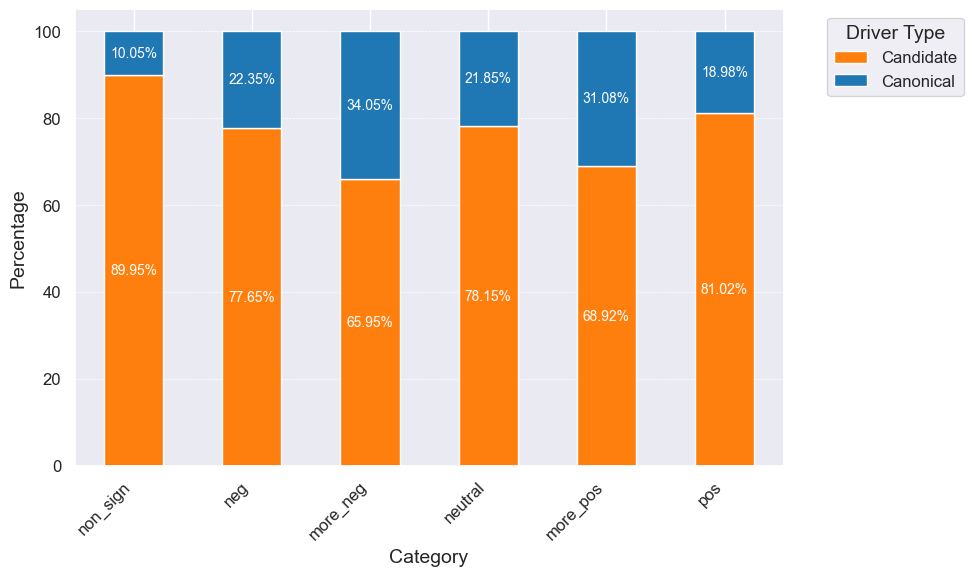

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Step 1: Classify drivers as Canonical, Candidate, or Other based on driver_stats
canonical = set(cancerdrivers[cancerdrivers['type'] == 'Canonical Cancer Driver']['symbol'].drop_duplicates())
candidate = set(cancerdrivers[cancerdrivers['type'] != 'Canonical Cancer Driver']['symbol'].drop_duplicates()) - canonical

# Step 2: Function to classify drivers
def classify_driver(driver):
    if driver in canonical:
        return 'Canonical'
    elif driver in candidate:
        return 'Candidate'
    else:
        return 'Other'

# Step 3: Add classification to driver_stats
driver_stats['driver_type'] = driver_stats['driver'].map(classify_driver)

# Step 4: Count drivers by category and type
category_counts = driver_stats.groupby(['group', 'driver_type']).size().unstack(fill_value=0)

# Step 5: Perform chi-square test on the contingency table
chi2, p_value, dof, expected = chi2_contingency(category_counts)

# Step 6: Print chi-square test results
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of Freedom: {dof}")

# Display expected values under the null hypothesis
print("\nExpected Frequencies (Under Null Hypothesis):")
expected_df = pd.DataFrame(expected, index=category_counts.index, columns=category_counts.columns)
print(expected_df)

# Step 7: Reorder categories based on category_order
category_counts = category_counts.reindex(category_order, axis=0)

# Step 8: Calculate percentages
category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

# Step 9: Display results
print("Driver counts by category:")
print(category_counts)
print("\nPercentage of drivers by category:")
print(category_percentages)

# Step 10: Totals for Canonical, Candidate, and Other
total_canonical = driver_stats['driver_type'].value_counts().get('Canonical', 0)
total_candidate = driver_stats['driver_type'].value_counts().get('Candidate', 0)
total_other = driver_stats['driver_type'].value_counts().get('Other', 0)

print(f"\nTotal Canonical Drivers: {total_canonical}")
print(f"Total Candidate Drivers: {total_candidate}")
print(f"Total Other Drivers: {total_other}")

# Step 11: Define the colors for 'Canonical', 'Candidate', and 'Other'
colors = {
    'Canonical': '#1f77b4',  # Blue for Canonical
    'Candidate': '#ff7f0e',  # Orange for Candidate
    'Other': '#2ca02c'       # Green for Other
}

# Step 12: Create the stacked bar chart with corrected colors
ax = category_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), 
                               color=[colors[col] for col in category_percentages.columns])

# Step 13: Customize the plot
#plt.title('Distribution of Driver Types by Category', fontsize=16)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Category', fontsize=14)

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adjust y-tick font size
plt.yticks(fontsize=12)

# Step 14: Add values inside each bar segment
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2., f'{height:.2f}%', 
                ha='center', va='center', fontsize=10, color='white')

# Move the legend closer
plt.legend(title='Driver Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add gridlines for better readability
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()



Chi-Square Test Results:
Chi-Square Statistic: 153.0727
P-value: 2.96e-31
Degrees of Freedom: 5

Expected Frequencies (Under Null Hypothesis):
driver_type    Candidate   Canonical
group                               
more_neg      150.668616   34.331384
more_pos      469.108772  106.891228
neg            69.226121   15.773879
neutral       122.978168   28.021832
non_sign     1053.865887  240.134113
pos           223.152437   50.847563
Driver counts by category:
driver_type  Candidate  Canonical
group                            
non_sign          1164        130
neg                 66         19
more_neg           122         63
neutral            118         33
more_pos           397        179
pos                222         52

Percentage of drivers by category:
driver_type  Candidate  Canonical
group                            
non_sign     89.953632  10.046368
neg          77.647059  22.352941
more_neg     65.945946  34.054054
neutral      78.145695  21.854305
more_pos     68.92361

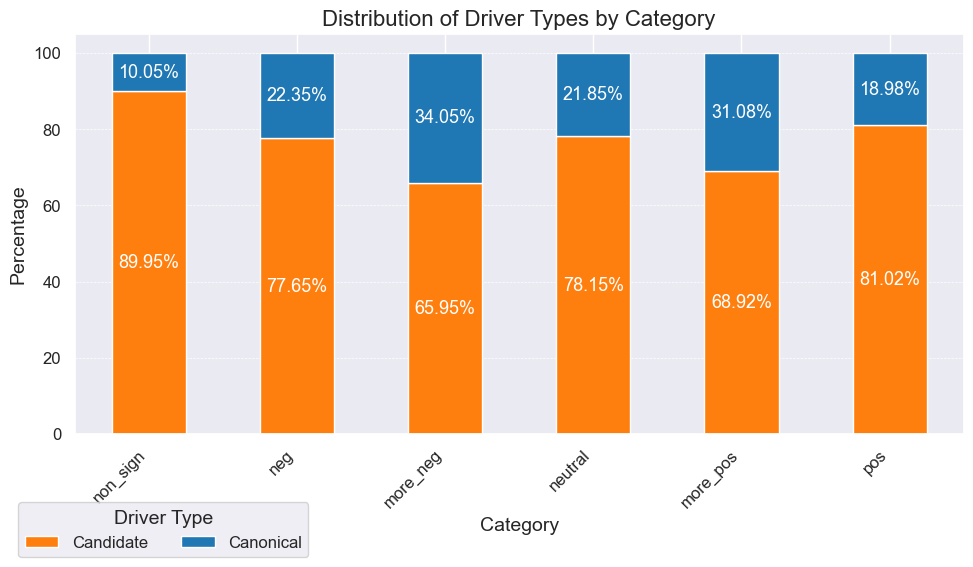

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Step 1: Classify drivers as Canonical, Candidate, or Other based on driver_stats
canonical = set(cancerdrivers[cancerdrivers['type'] == 'Canonical Cancer Driver']['symbol'].drop_duplicates())
candidate = set(cancerdrivers[cancerdrivers['type'] != 'Canonical Cancer Driver']['symbol'].drop_duplicates()) - canonical

# Step 2: Function to classify drivers
def classify_driver(driver):
    if driver in canonical:
        return 'Canonical'
    elif driver in candidate:
        return 'Candidate'
    else:
        return 'Other'

# Step 3: Add classification to driver_stats
driver_stats['driver_type'] = driver_stats['driver'].map(classify_driver)

# Step 4: Count drivers by category and type
category_counts = driver_stats.groupby(['group', 'driver_type']).size().unstack(fill_value=0)

# Step 5: Perform chi-square test on the contingency table
chi2, p_value, dof, expected = chi2_contingency(category_counts)

# Step 6: Print chi-square test results
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of Freedom: {dof}")

# Display expected values under the null hypothesis
print("\nExpected Frequencies (Under Null Hypothesis):")
expected_df = pd.DataFrame(expected, index=category_counts.index, columns=category_counts.columns)
print(expected_df)

# Step 7: Reorder categories based on category_order
category_counts = category_counts.reindex(category_order, axis=0)

# Step 8: Calculate percentages
category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

# Step 9: Display results
print("Driver counts by category:")
print(category_counts)
print("\nPercentage of drivers by category:")
print(category_percentages)

# Step 10: Totals for Canonical, Candidate, and Other
total_canonical = driver_stats['driver_type'].value_counts().get('Canonical', 0)
total_candidate = driver_stats['driver_type'].value_counts().get('Candidate', 0)
total_other = driver_stats['driver_type'].value_counts().get('Other', 0)

print(f"\nTotal Canonical Drivers: {total_canonical}")
print(f"Total Candidate Drivers: {total_candidate}")
print(f"Total Other Drivers: {total_other}")

# Step 11: Define the colors for 'Canonical', 'Candidate', and 'Other'
colors = {
    'Canonical': '#1f77b4',  # Blue for Canonical
    'Candidate': '#ff7f0e',  # Orange for Candidate
    'Other': '#2ca02c'       # Green for Other
}

# Step 12: Create the stacked bar chart with corrected colors
ax = category_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), 
                               color=[colors[col] for col in category_percentages.columns])

# Step 13: Customize the plot
plt.title('Distribution of Driver Types by Category', fontsize=16)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Category', fontsize=14)

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adjust y-tick font size
plt.yticks(fontsize=12)

# Step 14: Add values inside each bar segment
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2., f'{height:.2f}%', 
                ha='center', va='center', fontsize=13, color='white')

# Move the legend below the chart
plt.legend(title='Driver Type', bbox_to_anchor=(0.1, -0.15), loc='upper center', 
           fontsize=12, title_fontsize=14, ncol=3)  # ncol=3 for a single row of legend items

# Add gridlines for better readability
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()


### All DINTs

In [ ]:
# Step 1: Identify top and bottom 10 drivers by mutation frequency
driver_mutation_freq = final_df.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_10_drivers = driver_mutation_freq.head(10).index.tolist()
bottom_10_drivers = driver_mutation_freq.tail(10).index.tolist()

# Step 2: Find neighbors for these drivers
def get_neighbors(drivers, neighbourtab):
    neighbors = set()
    for driver in drivers:
        neighbors.update(neighbourtab.index[neighbourtab[driver]])
    return list(neighbors)

top_neighbors = get_neighbors(top_10_drivers, neighbourtab)
bottom_neighbors = get_neighbors(bottom_10_drivers, neighbourtab)

# Step 3: Extract expression data
top_expression = tumourexp.loc[:, top_neighbors]
bottom_expression = tumourexp.loc[:, bottom_neighbors]

""" # Step 4: Analyze and visualize
def plot_expression_heatmap(expression_data, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(expression_data.groupby('cancer_type').mean(), cmap='YlOrRd')
    plt.title(title)
    plt.show() """
""" 
plot_expression_heatmap(top_expression, "Expression of Neighbors for Top 10 Mutated Drivers")
plot_expression_heatmap(bottom_expression, "Expression of Neighbors for Bottom 10 Mutated Drivers") """

# Compare mean expression
top_mean = top_expression.mean()
bottom_mean = bottom_expression.mean()

print("Mean expression for neighbors of highly mutated drivers:")
print(top_mean.sort_values(ascending=False).head())
print("\nMean expression for neighbors of lowly mutated drivers:")
print(bottom_mean.sort_values(ascending=False).head())

# Statistical test
def compare_expressions(expr1, expr2):
    common_neighbors = set(expr1.columns) & set(expr2.columns) - {'cancer_type'}
    comp_results = []
    for neighbor in common_neighbors:
        u_stat, u_p_value = stats.mannwhitneyu(expr1[neighbor], expr2[neighbor], alternative='two-sided')
        comp_results.append({
            'Neighbor': neighbor,
            'U-statistic': u_stat,
            'p-value': u_p_value
        })
    return pd.DataFrame(comp_results).sort_values('p-value')

comparison_results = compare_expressions(top_expression, bottom_expression)
print("\nTop differentially expressed neighbors:")
print(comparison_results.head(10))

# Visualize top differential neighbors
""" def plot_top_differential(expr1, expr2, comparison_results, n=5):
    top_diff = comparison_results.head(n)['Neighbor']
    plt.figure(figsize=(15, 5*n))
    for i, neighbor in enumerate(top_diff, 1):
        plt.subplot(n, 1, i)
        sns.violinplot(x='cancer_type', y=neighbor, data=pd.concat([expr1, expr2]))
        plt.title(f"Expression of {neighbor}")
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_top_differential(top_expression, bottom_expression, comparison_results) """


Mean expression for neighbors of highly mutated drivers:
ACTB      16.533941
EEF1A1    16.198110
ACTG1     16.049729
GAPDH     15.945763
TPT1      15.629548
dtype: float64

Mean expression for neighbors of lowly mutated drivers:
ACTB      16.533941
UBC       15.030259
ENO1      14.675502
PABPC1    14.594079
CTSB      14.517812
dtype: float64

Top differentially expressed neighbors:
    Neighbor  U-statistic  p-value
1        HTT   35313608.0      1.0
588    CCNB1   35313608.0      1.0
589   OSBPL9   35313608.0      1.0
590    BRCA1   35313608.0      1.0
591   PABPC4   35313608.0      1.0
592    KPNA2   35313608.0      1.0
593   DCAF15   35313608.0      1.0
594    RAD50   35313608.0      1.0
595     CCT5   35313608.0      1.0
596    PSMB6   35313608.0      1.0


' def plot_top_differential(expr1, expr2, comparison_results, n=5):\n    top_diff = comparison_results.head(n)[\'Neighbor\']\n    plt.figure(figsize=(15, 5*n))\n    for i, neighbor in enumerate(top_diff, 1):\n        plt.subplot(n, 1, i)\n        sns.violinplot(x=\'cancer_type\', y=neighbor, data=pd.concat([expr1, expr2]))\n        plt.title(f"Expression of {neighbor}")\n        plt.xticks(rotation=90)\n    plt.tight_layout()\n    plt.show()\n\nplot_top_differential(top_expression, bottom_expression, comparison_results) '

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Step 1: Identify top and bottom 10 drivers by mutation frequency
driver_mutation_freq = significant_results_with_cancer_df.groupby('driver')['mutation_frequency'].max().sort_values(ascending=False)
top_3_drivers = driver_mutation_freq.head(3).index.tolist()
bottom_3_drivers = driver_mutation_freq.tail(3).index.tolist()

# Step 2: Find neighbors for these drivers
def get_neighbors(drivers, neighbourtab):
    neighbors = set()
    for driver in drivers:
        neighbors.update(neighbourtab.index[neighbourtab[driver]])
    return list(neighbors)

top_neighbors = get_neighbors(top_3_drivers, neighbourtab)
bottom_neighbors = get_neighbors(bottom_3_drivers, neighbourtab)

# Step 3: Extract expression data
top_expression = tumourexp[top_neighbors]
bottom_expression = tumourexp[bottom_neighbors]
""" 
# Step 4: Analyze and visualize
def plot_expression_heatmap(expression_data, title):
    plt.figure(figsize=(12, 8))
    mean_expression = expression_data.groupby('cancer_type').mean()
    sns.heatmap(mean_expression, cmap='YlOrRd')
    plt.title(title)
    plt.show()
 """
""" plot_expression_heatmap(top_expression, "Expression of Neighbors for Top 3 Mutated Drivers")
plot_expression_heatmap(bottom_expression, "Expression of Neighbors for Bottom 3 Mutated Drivers")
 """
def separate_by_mutation_status(expression_data, driver, mutationtab):
    # Ensure the driver is in the mutationtab
    if driver not in mutationtab.columns:
        print(f"Warning: Driver {driver} not found in mutation data. Skipping...")
        return None, None

    # Merge expression data with mutation data
    merged_data = expression_data.merge(
        mutationtab[driver].rename(f"{driver}_mutation"),
        left_index=True, 
        right_index=True, 
        how='left'
    )
    
    # Separate based on mutation status
    expr_with_mutation = merged_data[merged_data[f"{driver}_mutation"] == 1].drop(columns=[f"{driver}_mutation"])
    expr_without_mutation = merged_data[merged_data[f"{driver}_mutation"] == 0].drop(columns=[f"{driver}_mutation"])

    return expr_with_mutation, expr_without_mutation

# Modify the analyze_driver_expression function to handle None returns
def analyze_driver_expression(drivers, neighbors, expression_data, mutationtab):
    for driver in drivers:
        expr_with_mutation, expr_without_mutation = separate_by_mutation_status(expression_data[neighbors], driver, mutationtab)
        
        if expr_with_mutation is None or expr_without_mutation is None:
            continue
        
        # Plot heatmaps
        #plot_expression_heatmap(expr_with_mutation, f"Expression of Neighbors for Driver {driver} (With Mutation)")
        #plot_expression_heatmap(expr_without_mutation, f"Expression of Neighbors for Driver {driver} (Without Mutation)")
        
        # Compare mean expression
        with_mean = expr_with_mutation.groupby('cancer_type').mean().mean()
        without_mean = expr_without_mutation.groupby('cancer_type').mean().mean()
        
        print(f"Mean expression for neighbors of driver {driver} (With Mutation):")
        print(with_mean.sort_values(ascending=False).head())
        print(f"\nMean expression for neighbors of driver {driver} (Without Mutation):")
        print(without_mean.sort_values(ascending=False).head())
        
        # Statistical test
        comparison_results = compare_expressions(expr_with_mutation, expr_without_mutation)
        print(f"\nTop differentially expressed neighbors for driver {driver}:")
        print(comparison_results.head(10))
        
        # Visualize top differential neighbors
        #plot_top_differential(expr_with_mutation, expr_without_mutation, comparison_results)

# Helper functions
def compare_expressions(expr1, expr2):
    common_neighbors = set(expr1.columns) & set(expr2.columns)
    results = []
    for neighbor in common_neighbors:
        u_stat, p_value_u = stats.mannwhitneyu(expr1[neighbor], expr2[neighbor], alternative='two-sided')
        results.append({'Neighbor': neighbor, 'U-statistic': u_stat, 'p-value': p_value_u})
    return pd.DataFrame(results).sort_values('p-value')
""" 
def plot_top_differential(expr1, expr2, comparison_results, n=5):
    top_diff = comparison_results.head(n)['Neighbor']
    plt.figure(figsize=(15, 5*n))
    for i, neighbor in enumerate(top_diff, 1):
        plt.subplot(n, 1, i)
        combined_data = pd.concat([expr1[[neighbor]], expr2[[neighbor]]])
        sns.violinplot(x='cancer_type', y=neighbor, data=combined_data.reset_index())
        plt.title(f"Expression of {neighbor}")
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
 """
# Run the analysis with the corrected functions
print("Analyzing top drivers:")
analyze_driver_expression(top_3_drivers, top_neighbors, tumourexp, mutationtab)

print("\nAnalyzing bottom drivers:")
analyze_driver_expression(bottom_3_drivers, bottom_neighbors, tumourexp, mutationtab)

Analyzing top drivers:
Mean expression for neighbors of driver TP53 (With Mutation):
ACTB      16.622040
EEF1A1    16.189148
GAPDH     16.151735
ACTG1     16.045623
EEF2      15.581083
dtype: float64

Mean expression for neighbors of driver TP53 (Without Mutation):
ACTB      16.569557
EEF1A1    16.306500
ACTG1     16.121670
GAPDH     16.072009
EEF2      15.746612
dtype: float64

Top differentially expressed neighbors for driver TP53:
     Neighbor  U-statistic        p-value
2205    CIRBP    4091274.5   0.000000e+00
2501      XPC    3850141.5   0.000000e+00
1389   FAM83D   12250435.5   0.000000e+00
76     RPS27L    3502009.0   0.000000e+00
252      ANLN   12378503.0   0.000000e+00
2017   CKAP2L   12196442.0  8.616945e-306
2260     PLK1   12172631.5  3.429871e-302
815       TTK   12154632.0  1.748116e-299
331     PRR11   12137942.5  5.488826e-297
1393    KPNA4   12117912.0  5.228578e-294
Mean expression for neighbors of driver PTEN (With Mutation):
ACTB      16.686528
GAPDH     16.27526

Driver ACKR3 not found in mutation or expression data. Skipping...
Driver AGO4 not found in mutation or expression data. Skipping...
Driver AJUBA not found in mutation or expression data. Skipping...
Driver AMER1 not found in mutation or expression data. Skipping...
Driver APMAP not found in mutation or expression data. Skipping...
Driver APOBR not found in mutation or expression data. Skipping...
Driver ARHGAP35 not found in mutation or expression data. Skipping...
Driver ATG14 not found in mutation or expression data. Skipping...
Driver BPIFB1 not found in mutation or expression data. Skipping...
Driver BRINP3 not found in mutation or expression data. Skipping...
Driver C2CD5 not found in mutation or expression data. Skipping...
Driver CCDC168 not found in mutation or expression data. Skipping...
Driver CCP110 not found in mutation or expression data. Skipping...
Driver CMTR1 not found in mutation or expression data. Skipping...
Driver CNTRL not found in mutation or expression data. 

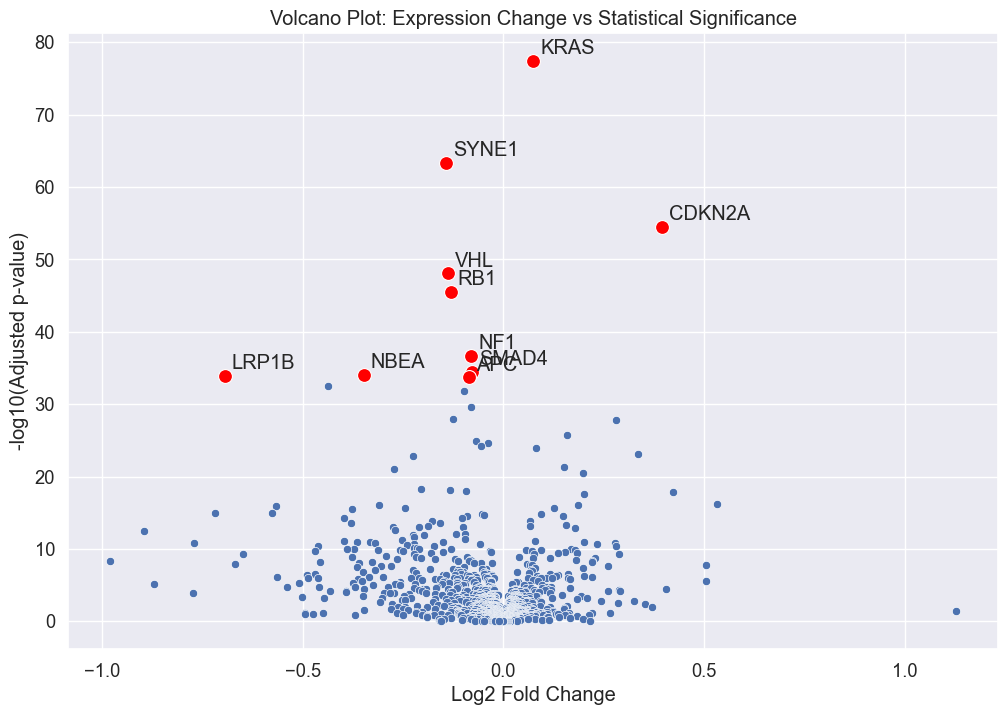

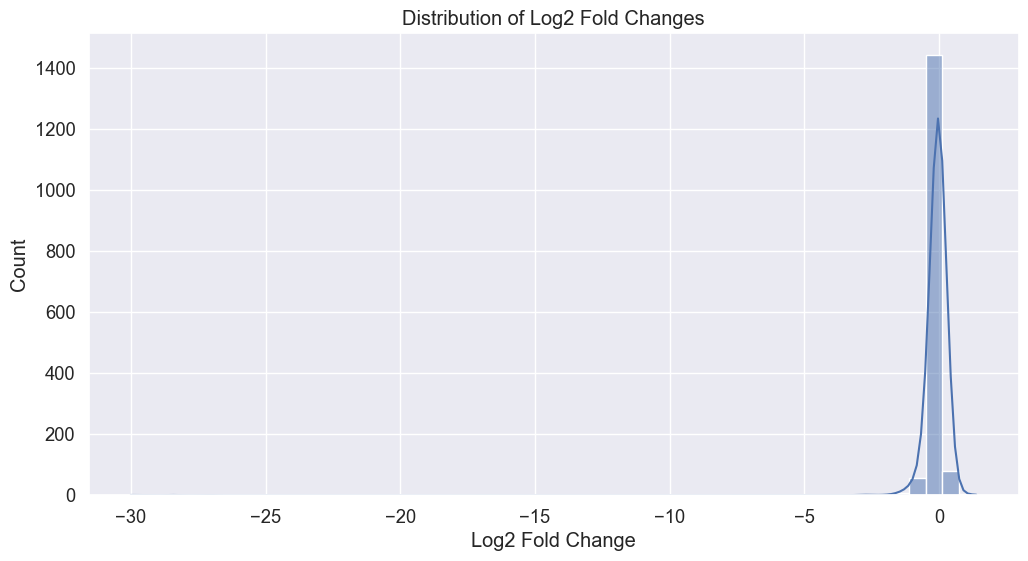

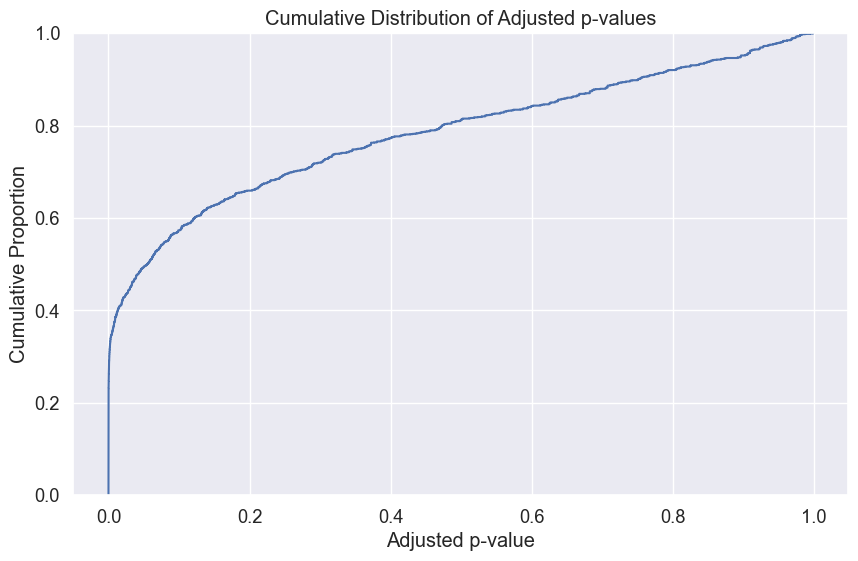

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def get_unique_drivers(filtered_results):
    return filtered_results['driver'].unique()

def analyze_driver_expression(driver, mutationtab, tumourexp):
    mutation_status = mutationtab[driver]
    expression = tumourexp[driver]
    
    combined_data = pd.DataFrame({'mutation': mutation_status, 'expression': expression})
    
    mutated_expr = combined_data[combined_data['mutation'] == 1]['expression']
    non_mutated_expr = combined_data[combined_data['mutation'] == 0]['expression']
    
    mean_expr_mutated = mutated_expr.mean()
    mean_expr_non_mutated = non_mutated_expr.mean()
    
    # Calcular log2 fold change com um pequeno epsilon para evitar divisão por zero
    epsilon = 1e-10
    log2_fold_change = np.log2((mean_expr_mutated + epsilon) / (mean_expr_non_mutated + epsilon))
    
    # Realizar o teste de Mann-Whitney apenas se houver amostras suficientes em ambos os grupos
    if len(mutated_expr) > 0 and len(non_mutated_expr) > 0:
        statistic, p_value = stats.mannwhitneyu(mutated_expr, non_mutated_expr, alternative='two-sided')
    else:
        statistic, p_value = np.nan, np.nan
    
    return {
        'driver': driver,
        'mean_expr_mutated': mean_expr_mutated,
        'mean_expr_non_mutated': mean_expr_non_mutated,
        'mann_whitney_statistic': statistic,
        'p_value': p_value,
        'log2_fold_change': log2_fold_change
    }
def benjamini_hochberg_correction(p_values):
    p_values = np.array(p_values)
    n = len(p_values)
    print(f"Number of p-values: {n}")
    print(f"Original p-values: {p_values}")

    # Remove NaN values
    valid_mask = ~np.isnan(p_values)
    valid_p_values = p_values[valid_mask]
    m = len(valid_p_values)
    print(f"Number of valid p-values: {m}")

    if m == 0:
        return np.full_like(p_values, np.nan)

    # Sort p-values
    sorted_indices = np.argsort(valid_p_values)
    sorted_p_values = valid_p_values[sorted_indices]
    print(f"Sorted p-values: {sorted_p_values}")

    # Calculate adjusted p-values
    adjusted_p_values = np.zeros(m)
    for i in range(m):
        rank = i + 1
        adjusted_p_values[i] = min(sorted_p_values[i] * m / rank, 1.0)

    # Ensure monotonicity
    for i in range(m-2, -1, -1):
        adjusted_p_values[i] = min(adjusted_p_values[i], adjusted_p_values[i+1])

    print(f"Adjusted p-values (sorted): {adjusted_p_values}")

    # Reorder to match original input
    reordered_adjusted_p_values = np.zeros(m)
    reordered_adjusted_p_values[sorted_indices] = adjusted_p_values

    # Reinsert NaN values
    final_adjusted_p_values = np.full(n, np.nan)
    final_adjusted_p_values[valid_mask] = reordered_adjusted_p_values
    
    print(f"Final adjusted p-values: {final_adjusted_p_values}")

    return final_adjusted_p_values
# As funções get_unique_drivers, analyze_driver_expression e benjamini_hochberg_correction permanecem as mesmas

def main_analysis(drivers, mutationtab, tumourexp):
    main_results = []
    
    for driver in drivers:
        if driver in mutationtab.columns and driver in tumourexp.columns:
            result = analyze_driver_expression(driver, mutationtab, driver_tumour_expression)
            main_results.append(result)
        else:
            print(f"Driver {driver} not found in mutation or expression data. Skipping...")
    
    results_df = pd.DataFrame(main_results)
    results_df['adj_p_value'] = benjamini_hochberg_correction(results_df['p_value'])
    
    # Criar a coluna -log10(adj_p_value) explicitamente
    results_df['-log10(adj_p_value)'] = -np.log10(results_df['adj_p_value'])
    
    results_df = results_df.sort_values('adj_p_value')
    
    # Print summary statistics
    print("Summary of results:")
    print(results_df.describe())
    
    # Print top 20 most significant drivers
    print("\nTop 20 most significant drivers:")
    print(results_df.head(20))
    
    # Volcano plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='log2_fold_change', y='-log10(adj_p_value)', data=results_df)
    plt.title('Volcano Plot: Expression Change vs Statistical Significance')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')
    
    # Highlight top 10 most significant points
    top_10 = results_df.nlargest(10, '-log10(adj_p_value)')
    sns.scatterplot(x='log2_fold_change', y='-log10(adj_p_value)', 
                    data=top_10, color='red', s=100)
    
    for idx, row in top_10.iterrows():
        plt.annotate(row['driver'], 
                     (row['log2_fold_change'], row['-log10(adj_p_value)']),
                     xytext=(5, 5), textcoords='offset points')
    plt.show()

    # Histogram of log2 fold changes
    plt.figure(figsize=(12, 6))
    sns.histplot(results_df['log2_fold_change'], bins=50, kde=True)
    plt.title('Distribution of Log2 Fold Changes')
    plt.xlabel('Log2 Fold Change')
    plt.show()

    # Cumulative distribution of p-values
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(results_df['adj_p_value'])
    plt.title('Cumulative Distribution of Adjusted p-values')
    plt.xlabel('Adjusted p-value')
    plt.ylabel('Cumulative Proportion')
    plt.show()

main_analysis(significant_drivers, mutationtab, driver_tumour_expression)

      driver  category  mean_expression_mutated  mean_expression_non_mutated  \
0       A1CF  non_sign                 1.364054                     1.733682   
1      A2ML1  more_pos                 3.792646                     3.984380   
2     ABCA10  non_sign                 3.434216                     3.776301   
3     ABCA13  more_pos                 4.416936                     4.238564   
4      ABCA7  non_sign                 8.592880                     8.488046   
...      ...       ...                      ...                          ...   
2462  ZSWIM3  non_sign                 6.757654                     6.826901   
2463  ZSWIM6  non_sign                 8.376133                     8.574214   
2464  ZWILCH  non_sign                 8.974727                     8.440610   
2465   ZWINT       pos                 9.697200                     8.939950   
2466   ZZEF1  more_pos                10.118257                    10.136499   

      mann_whitney_statistic   p_value 

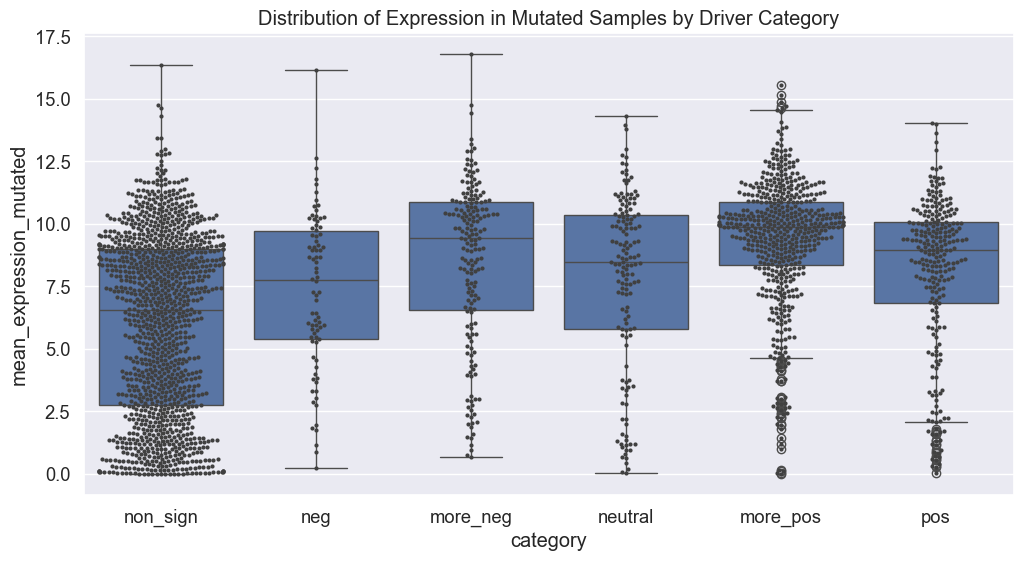

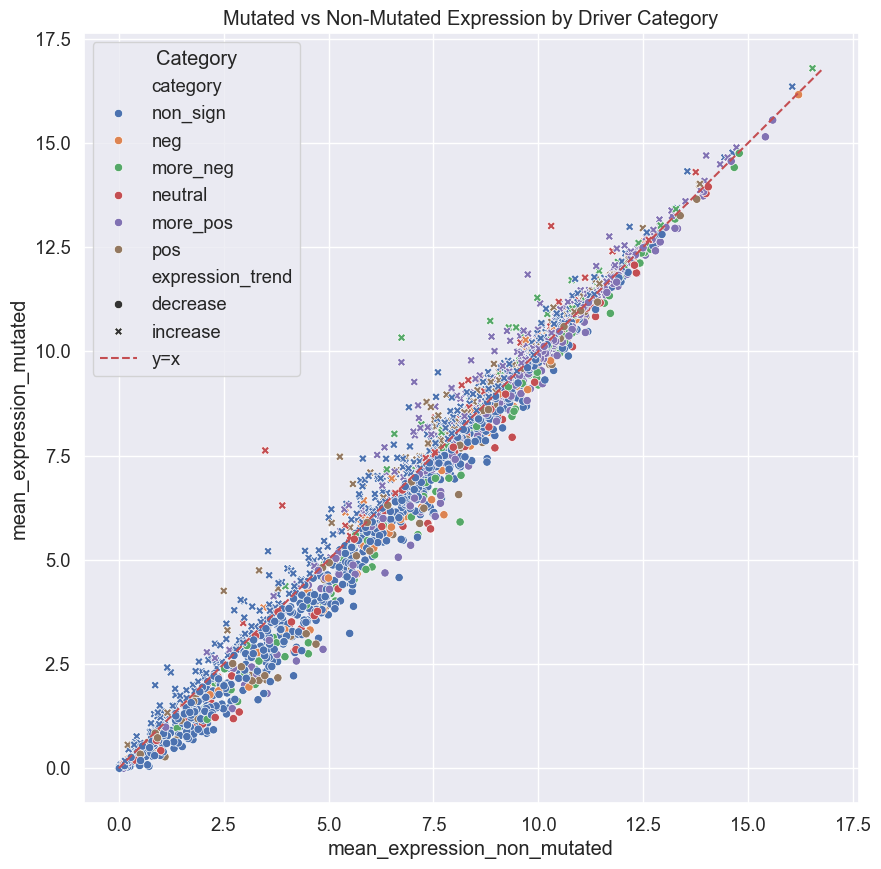


Proportion of expression trends by category:
expression_trend  decrease  increase
category                            
more_neg          0.701087  0.298913
more_pos          0.550179  0.449821
neg               0.658537  0.341463
neutral           0.621622  0.378378
non_sign          0.638281  0.361719
pos               0.519084  0.480916


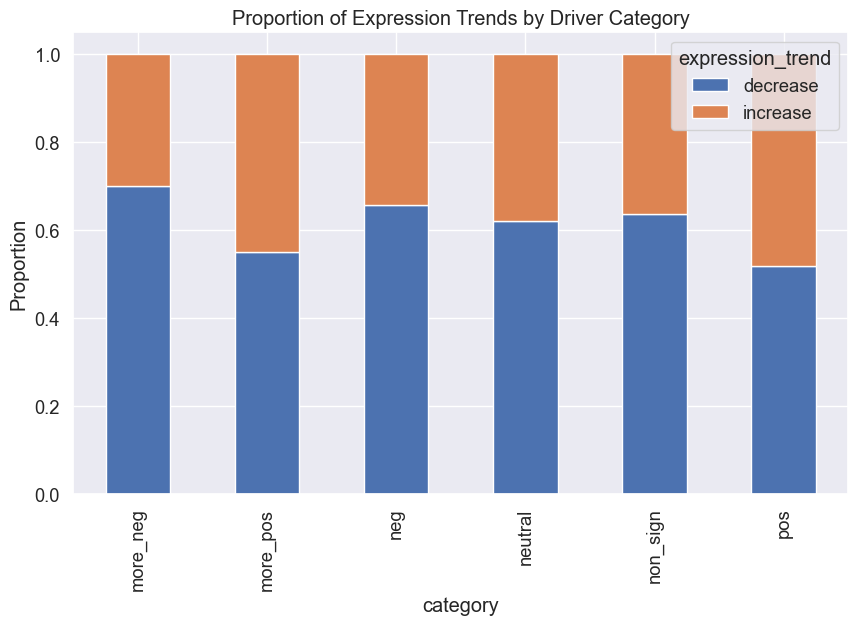


Statistical comparisons between categories:
non_sign vs pos: statistic = 132613.0000, p-value = 0.0000
neg vs non_sign: statistic = 45323.0000, p-value = 0.1163
neg vs neutral: statistic = 5408.0000, p-value = 0.1724
neg vs pos: statistic = 7917.0000, p-value = 0.0003
more_neg vs non_sign: statistic = 105164.0000, p-value = 0.1101
more_neg vs neg: statistic = 7758.0000, p-value = 0.7125
more_neg vs neutral: statistic = 12567.0000, p-value = 0.2278
more_neg vs more_pos: statistic = 39120.0000, p-value = 0.0000
more_neg vs pos: statistic = 17921.0000, p-value = 0.0000
neutral vs non_sign: statistic = 91987.0000, p-value = 0.8710
neutral vs pos: statistic = 16129.0000, p-value = 0.0047
more_pos vs non_sign: statistic = 398194.0000, p-value = 0.0000
more_pos vs neg: statistic = 28603.0000, p-value = 0.0003
more_pos vs neutral: statistic = 47293.0000, p-value = 0.0065
more_pos vs pos: statistic = 70393.0000, p-value = 0.3925

Non-significant (Category non_sign):
      driver  category  mea

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Function to analyze driver expression
def analyze_driver_expression(driver, mutationtab, driver_tumour_expression):
    if driver not in mutationtab.columns or driver not in driver_tumour_expression.columns:
        # Skip drivers that are missing in either dataset
        return None
    
    mutated_individuals = mutationtab[mutationtab[driver] == 1].index
    non_mutated_individuals = mutationtab[mutationtab[driver] == 0].index
    
    exp_mutated = driver_tumour_expression.loc[mutated_individuals, driver]
    exp_non_mutated = driver_tumour_expression.loc[non_mutated_individuals, driver]
    
    if not exp_mutated.empty and not exp_non_mutated.empty:
        statistic, p_value = stats.mannwhitneyu(exp_mutated, exp_non_mutated, alternative='two-sided')
        mean_mutated = exp_mutated.mean()
        mean_non_mutated = exp_non_mutated.mean()
        
        # Ensure correct access to the 'group' (category) column in driver_stats
        category = driver_stats.loc[driver_stats['driver'] == driver, 'group'].values[0]
        
        expression_trend = 'increase' if mean_mutated > mean_non_mutated else 'decrease' if mean_mutated < mean_non_mutated else 'no change'
        
        return {
            'driver': driver,
            'category': category,  # Use the correct driver group
            'mean_expression_mutated': mean_mutated,
            'mean_expression_non_mutated': mean_non_mutated,
            'mann_whitney_statistic': statistic,
            'p_value': p_value,
            'expression_trend': expression_trend
        }
    return None

# Function to compare categories
def compare_categories(cat1, cat2, results_df):
    group1 = results_df[results_df['category'] == cat1]['mean_expression_mutated'] - \
             results_df[results_df['category'] == cat1]['mean_expression_non_mutated']
    group2 = results_df[results_df['category'] == cat2]['mean_expression_mutated'] - \
             results_df[results_df['category'] == cat2]['mean_expression_non_mutated']
    statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    return f"{cat1} vs {cat2}: statistic = {statistic:.4f}, p-value = {p_value:.4f}"

driver_stats_all = drivers[['driver', 'n_neighbours', 'pos_dints', 'neg_dints', 'pos_pct', 'neg_pct', 'group']].copy()

# Filter only drivers that exist in both mutationtab and driver_tumour_expression
common_drivers_all = driver_stats_all['driver'][driver_stats_all['driver'].isin(mutationtab.columns) & driver_stats_all['driver'].isin(driver_tumour_expression.columns)]

# Apply expression analysis to filtered common drivers
exp_results = [analyze_driver_expression(driver, mutationtab, driver_tumour_expression) for driver in common_drivers_all]
results_df_all = pd.DataFrame([r for r in exp_results if r is not None])

# 2. Analysis and visualizations
print(results_df_all)

category_summary = results_df_all.groupby('category').agg({
    'mean_expression_mutated': ['mean', 'std'],
    'mean_expression_non_mutated': ['mean', 'std'],
    'p_value': ['mean', 'median'],
    'driver': 'count'
}).rename(columns={'driver': 'count'})

print("\nStatistical summary by category:")
print(category_summary)

# Set category order as per the requested order: non_sign, neg, more_neg, more_pos, pos, neutral
category_order = ['non_sign', 'neg', 'more_neg', 'neutral', 'more_pos', 'pos']

# Boxplot and Swarmplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='mean_expression_mutated', data=results_df_all, order=category_order)
sns.swarmplot(x='category', y='mean_expression_mutated', data=results_df_all, color=".25", size=3, order=category_order)
plt.title('Distribution of Expression in Mutated Samples by Driver Category')
plt.show()

# Scatterplot of Mutated vs Non-Mutated Expression
plt.figure(figsize=(10, 10))
sns.scatterplot(x='mean_expression_non_mutated', y='mean_expression_mutated', 
                hue='category', style='expression_trend', data=results_df_all, hue_order=category_order)
plt.plot([0, results_df_all['mean_expression_mutated'].max()], 
         [0, results_df_all['mean_expression_mutated'].max()], 
         'r--', label='y=x')
plt.title('Mutated vs Non-Mutated Expression by Driver Category')
plt.legend(title='Category')
plt.show()

# Proportion of Expression Trends by Category
expression_trends = results_df_all.groupby('category')['expression_trend'].value_counts(normalize=True).unstack()
print("\nProportion of expression trends by category:")
print(expression_trends)

# Plotting the bar plot without the 'order' argument
expression_trends.plot(kind='bar', stacked=True, figsize=(10, 6))  # Removed 'order'
plt.title('Proportion of Expression Trends by Driver Category')
plt.ylabel('Proportion')
plt.show()

# Statistical comparisons between categories
print("\nStatistical comparisons between categories:")
for cat1 in category_order:
    for cat2 in category_order:
        if cat1 < cat2:
            print(compare_categories(cat1, cat2, results_df_all))

# Output detailed results by category
expected_categories = {
    'non_sign': 'Non-significant',
    'neg': 'Y-axis (Only negative neighbours)',
    'more_neg': 'Above y=x (More negative than positive neighbours)',
    'more_pos': 'Below y=x (More positive than negative neighbours)',
    'pos': 'X-axis (Only positive neighbours)',
    'neutral': 'Equal number of positive and negative neighbours'
}

for category, description in expected_categories.items():
    print(f"\n{description} (Category {category}):")
    category_df = results_df_all[results_df_all['category'] == category]
    print(category_df)


In [ ]:
# Count the number of drivers in each category
driver_counts = driver_stats_all['group'].value_counts()

print("Number of drivers in each category:")
print(driver_counts)


""" Número de drivers em cada categoria:
category
N_Sig       1336
More_Pos     555
More_Neg     292
Pos          287
Neg           77
Name: count, dtype: int64
 """

""" Número de drivers em cada categoria:
category
N_Sig       884
More_Pos    576
Pos         489
More_Neg    336
Neg         254
Name: count, dtype: int64
 """

Number of drivers in each category:
group
non_sign    910
more_pos    576
pos         489
neg         254
more_neg    185
neutral     151
Name: count, dtype: int64


' Número de drivers em cada categoria:\ncategory\nN_Sig       884\nMore_Pos    576\nPos         489\nMore_Neg    336\nNeg         254\nName: count, dtype: int64\n '

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(results_df_all['category'], results_df_all['expression_trend'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of Freedom: {dof}")

print("\nContingency Table:")
print(contingency_table)

print("\nExpected Values:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))



Chi-Square Test Results:
Chi-Square Statistic: 28.9563
P-value: 2.37e-05
Degrees of Freedom: 5

Contingency Table:
expression_trend  decrease  increase
category                            
more_neg               129        55
more_pos               307       251
neg                     54        28
neutral                 92        56
non_sign               787       446
pos                    136       126

Expected Values:
expression_trend    decrease    increase
category                                
more_neg          112.249696   71.750304
more_pos          340.409404  217.590596
neg                50.024321   31.975679
neutral            90.287799   57.712201
non_sign          752.194974  480.805026
pos               159.833806  102.166194


In [ ]:
# Count the number of drivers for each category and expression trend
expression_trend_counts = results_df_all.groupby(['category', 'expression_trend']).size().unstack(fill_value=0)

print("\nCount of drivers by category and expression trend:")
print(expression_trend_counts) 



Count of drivers by category and expression trend:
expression_trend  decrease  increase
category                            
more_neg               129        55
more_pos               307       251
neg                     54        28
neutral                 92        56
non_sign               787       446
pos                    136       126


In [ ]:
# Step 1: Ensure mutation_frequency is not NaN and matches with drivers in driver_stats
mutation_frequency = mutationtab.mean()

# Step 2: Calculate expression change for each driver
def calculate_expression_change(row):
    if pd.notna(row['mean_expression_mutated']) and pd.notna(row['mean_expression_non_mutated']):
        return row['mean_expression_mutated'] - row['mean_expression_non_mutated']
    return np.nan

# Apply expression change calculation to results_df
results_df_all['expression_change'] = results_df_all.apply(calculate_expression_change, axis=1)

# Step 3: Ensure proper merging by aligning indices (reset index if necessary)
# Ensure that driver_info has the same index and 'driver' column
driver_info_all = driver_stats_all.set_index('driver').join(results_df_all.set_index('driver')[['expression_change']], how='left')

# Merge mutation_frequency based on driver index
driver_info_all = driver_info_all.join(mutation_frequency.rename('mutation_frequency'), how='left')

# Step 4: Filter out rows with all NaN values in both expression_change and mutation_frequency
driver_info_all = driver_info_all.dropna(subset=['expression_change', 'mutation_frequency'], how='all')

print(driver_info_all)


        n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group  \
driver                                                                     
A1CF              39          0          0  0.000000  0.000000  non_sign   
A2ML1             91          4          3  0.043956  0.032967  more_pos   
ABCA10             5          0          0  0.000000  0.000000  non_sign   
ABCA13             9          3          1  0.333333  0.111111  more_pos   
ABCA7             16          0          0  0.000000  0.000000  non_sign   
...              ...        ...        ...       ...       ...       ...   
ZSWIM3             6          0          0  0.000000  0.000000  non_sign   
ZSWIM6            22          0          0  0.000000  0.000000  non_sign   
ZWILCH            22          1          0  0.045455  0.000000       pos   
ZWINT            136         22          0  0.161765  0.000000       pos   
ZZEF1             89          8          2  0.089888  0.022472  more_pos   

        exp

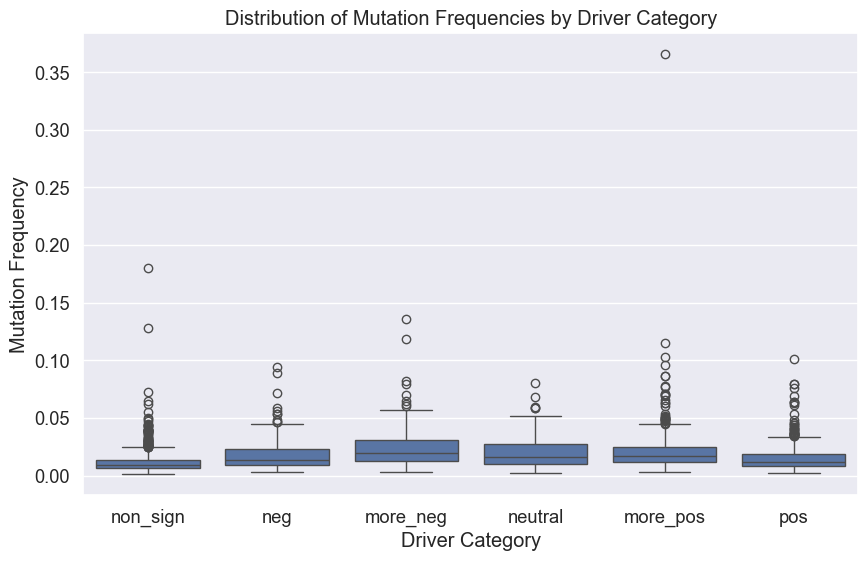

In [ ]:
# Step 4: Visualize mutation frequency by category

# Remove rows with NaN mutation frequencies
filtered_driver_info_all = driver_info_all.dropna(subset=['mutation_frequency'])

# Update the category order to only include categories present in the filtered data
present_categories = filtered_driver_info_all['group'].unique()
category_order_present = [cat for cat in category_order if cat in present_categories]

plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info_all, order=category_order_present)
plt.title('Distribution of Mutation Frequencies by Driver Category')
plt.xlabel('Driver Category')
plt.ylabel('Mutation Frequency')
plt.show()


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_22666/2372894730.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info_all, order=category_order_present, palette='Set2')


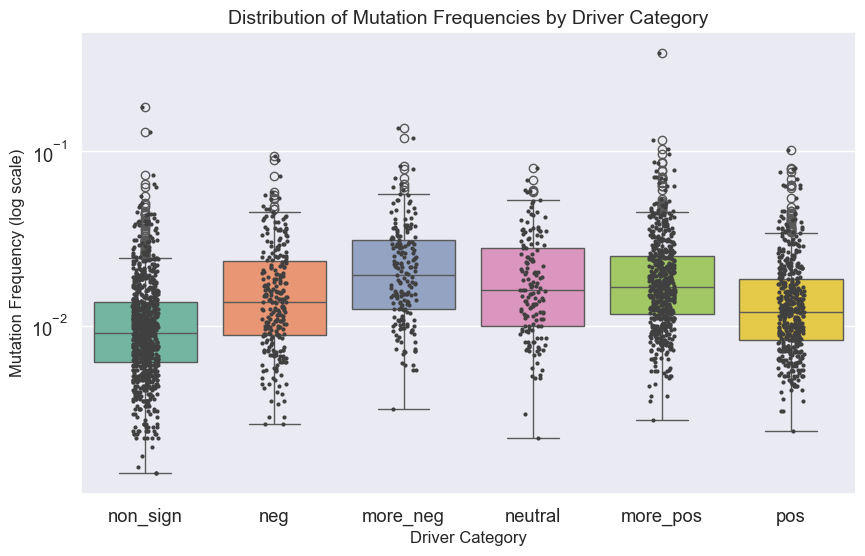

          count      mean       std       min       25%       50%       75%  \
group                                                                         
more_neg  185.0  0.024277  0.018280  0.003332  0.012375  0.019396  0.030819   
more_pos  576.0  0.021129  0.020125  0.002856  0.011661  0.016718  0.024988   
neg       254.0  0.017922  0.013755  0.002737  0.008805  0.013684  0.023411   
neutral   151.0  0.020413  0.014182  0.002261  0.009876  0.015945  0.027784   
non_sign  910.0  0.011651  0.010781  0.001428  0.006188  0.009103  0.013565   
pos       489.0  0.015337  0.011838  0.002499  0.008210  0.012018  0.018563   

               max  
group               
more_neg  0.136245  
more_pos  0.365778  
neg       0.094241  
neutral   0.079962  
non_sign  0.179914  
pos       0.101499  


In [ ]:
plt.figure(figsize=(10, 6))

# Boxplot with a color palette
sns.boxplot(x='group', y='mutation_frequency', data=filtered_driver_info_all, order=category_order_present, palette='Set2')

# Overlay swarmplot for individual data points
#sns.swarmplot(x='group', y='mutation_frequency', data=filtered_driver_info, order=category_order_present, color=".25", size=3)
sns.stripplot(x='group', y='mutation_frequency', data=filtered_driver_info_all, order=category_order_present, color=".25", size=3)

# Apply log scale to Y-axis to better visualize the smaller frequencies
plt.yscale('log')

# Add titles and labels
plt.title('Distribution of Mutation Frequencies by Driver Category', fontsize=14)
plt.xlabel('Driver Category', fontsize=12)
plt.ylabel('Mutation Frequency (log scale)', fontsize=12)

# Show the plot
plt.show()

# Print summary statistics
summary_stats = filtered_driver_info_all.groupby('group')['mutation_frequency'].describe()
print(summary_stats)



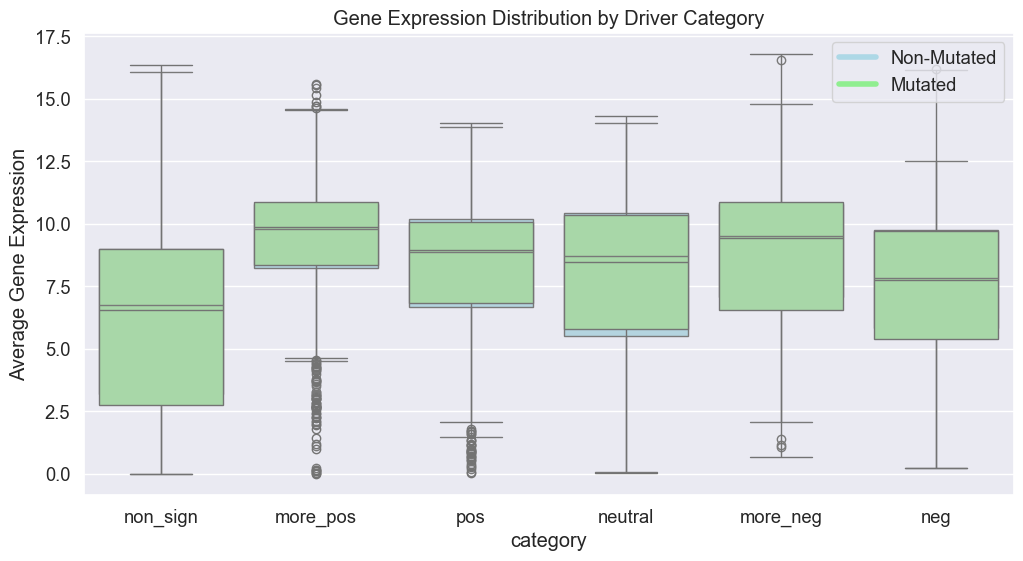

In [ ]:
# Step 3: Visualizing gene expression distribution by category
plt.figure(figsize=(12, 6))

# Plot for non-mutated expression
sns.boxplot(x='category', y='mean_expression_non_mutated', data=results_df_all[results_df_all['category'].isin(category_order)], color='lightblue')
# Plot for mutated expression
sns.boxplot(x='category', y='mean_expression_mutated', data=results_df_all[results_df_all['category'].isin(category_order)], color='lightgreen', saturation=0.5)

plt.title('Gene Expression Distribution by Driver Category')
plt.ylabel('Average Gene Expression')

# Create custom legend
handles = [
    plt.Line2D([0], [0], color='lightblue', lw=4),
    plt.Line2D([0], [0], color='lightgreen', lw=4)
]
plt.legend(handles, ['Non-Mutated', 'Mutated'], loc='upper right')

plt.show()

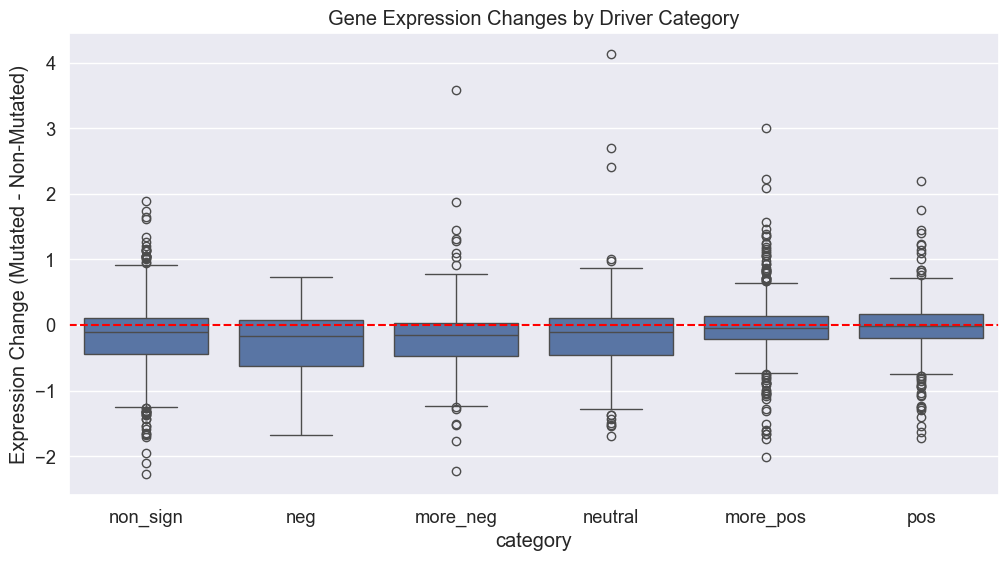

In [ ]:
# Step 5: Visualize expression changes by category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='expression_change', data=results_df_all, order=category_order)
plt.title('Gene Expression Changes by Driver Category')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Expression Change (Mutated - Non-Mutated)')
plt.show()


In [ ]:
# Step 6: Perform statistical comparisons for mutation frequencies
p_values = []
comparison_results = []
categories = driver_info_all['group'].unique()

# Pairwise comparison for mutation frequencies across categories
for cat1 in categories:
    for cat2 in categories:
        if cat1 < cat2:
            group1 = driver_info_all[driver_info_all['group'] == cat1]['mutation_frequency']
            group2 = driver_info_all[driver_info_all['group'] == cat2]['mutation_frequency']
            statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            p_values.append(p_value)
            comparison_results.append({'category1': cat1, 'category2': cat2, 'statistic': statistic, 'p_value': p_value})

# Apply Benjamini-Hochberg correction
corrected_p_values = benjamini_hochberg_correction(p_values)

# Add adjusted p-values to the comparison results
for i, result in enumerate(comparison_results):
    result['adjusted_p_value'] = corrected_p_values[i]

comparison_df_all = pd.DataFrame(comparison_results)
print(comparison_df_all)



Number of p-values: 15
Original p-values: [4.22383433e-16 1.43058634e-68 1.68723942e-18 4.10868093e-01
 4.16879468e-05 4.78004632e-20 5.91055189e-06 7.73856117e-37
 1.89752299e-02 3.58104520e-15 2.29722210e-02 1.79452463e-06
 1.02835035e-16 1.59467231e-02 3.05688400e-02]
Number of valid p-values: 15
Sorted p-values: [1.43058634e-68 7.73856117e-37 4.78004632e-20 1.68723942e-18
 1.02835035e-16 4.22383433e-16 3.58104520e-15 1.79452463e-06
 5.91055189e-06 4.16879468e-05 1.59467231e-02 1.89752299e-02
 2.29722210e-02 3.05688400e-02 4.10868093e-01]
Adjusted p-values (sorted): [2.14587951e-67 5.80392087e-36 2.39002316e-19 6.32714783e-18
 3.08505104e-16 1.05595858e-15 7.67366829e-15 3.36473368e-06
 9.85091981e-06 6.25319202e-05 2.17455315e-02 2.37190374e-02
 2.65064089e-02 3.27523285e-02 4.10868093e-01]
Final adjusted p-values: [1.05595858e-15 2.14587951e-67 6.32714783e-18 4.10868093e-01
 6.25319202e-05 2.39002316e-19 9.85091981e-06 5.80392087e-36
 2.37190374e-02 7.67366829e-15 2.65064089e-02 3

In [ ]:
# Step 7: Perform Mann-Whitney U test for expression changes across categories
for category in present_categories:
    category_data = results_df_all[results_df_all['category'] == category]
    if len(category_data) > 1:
        statistic, p_value = stats.mannwhitneyu(category_data['mean_expression_mutated'], 
                                                category_data['mean_expression_non_mutated'], alternative='two-sided')
        print(f"\nCategoria {category}:")
        print(f"Teste de Mann-Whitney U: estatística = {statistic:.4f}, p-valor = {p_value:.4e}")

# Step 8: Perform Kruskal-Wallis test to compare expression change across categories
category_groups = [group['expression_change'].dropna() for name, group in results_df_all.groupby('category') if name in present_categories]
kruskal_statistic, kruskal_p_value = stats.kruskal(*category_groups)

print("\nKruskal-Wallis test para comparar a mudança na expressão entre categorias:")
print(f"Kruskal-Wallis estatística: {kruskal_statistic:.4f}")
print(f"p-valor: {kruskal_p_value:.4e}")



Categoria non_sign:
Teste de Mann-Whitney U: estatística = 740041.0000, p-valor = 2.5549e-01

Categoria more_pos:
Teste de Mann-Whitney U: estatística = 156128.0000, p-valor = 9.3405e-01

Categoria pos:
Teste de Mann-Whitney U: estatística = 34426.0000, p-valor = 9.5238e-01

Categoria neutral:
Teste de Mann-Whitney U: estatística = 10755.0000, p-valor = 7.8956e-01

Categoria more_neg:
Teste de Mann-Whitney U: estatística = 16621.0000, p-valor = 7.6388e-01

Categoria neg:
Teste de Mann-Whitney U: estatística = 3185.0000, p-valor = 5.6160e-01

Kruskal-Wallis test para comparar a mudança na expressão entre categorias:
Kruskal-Wallis estatística: 56.3701
p-valor: 6.8184e-11


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_22666/809199625.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_results['abs_corr'] = significant_results['correlation'].abs()
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_22666/809199625.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=significant_results, x='gene', y='correlation', palette='coolwarm')


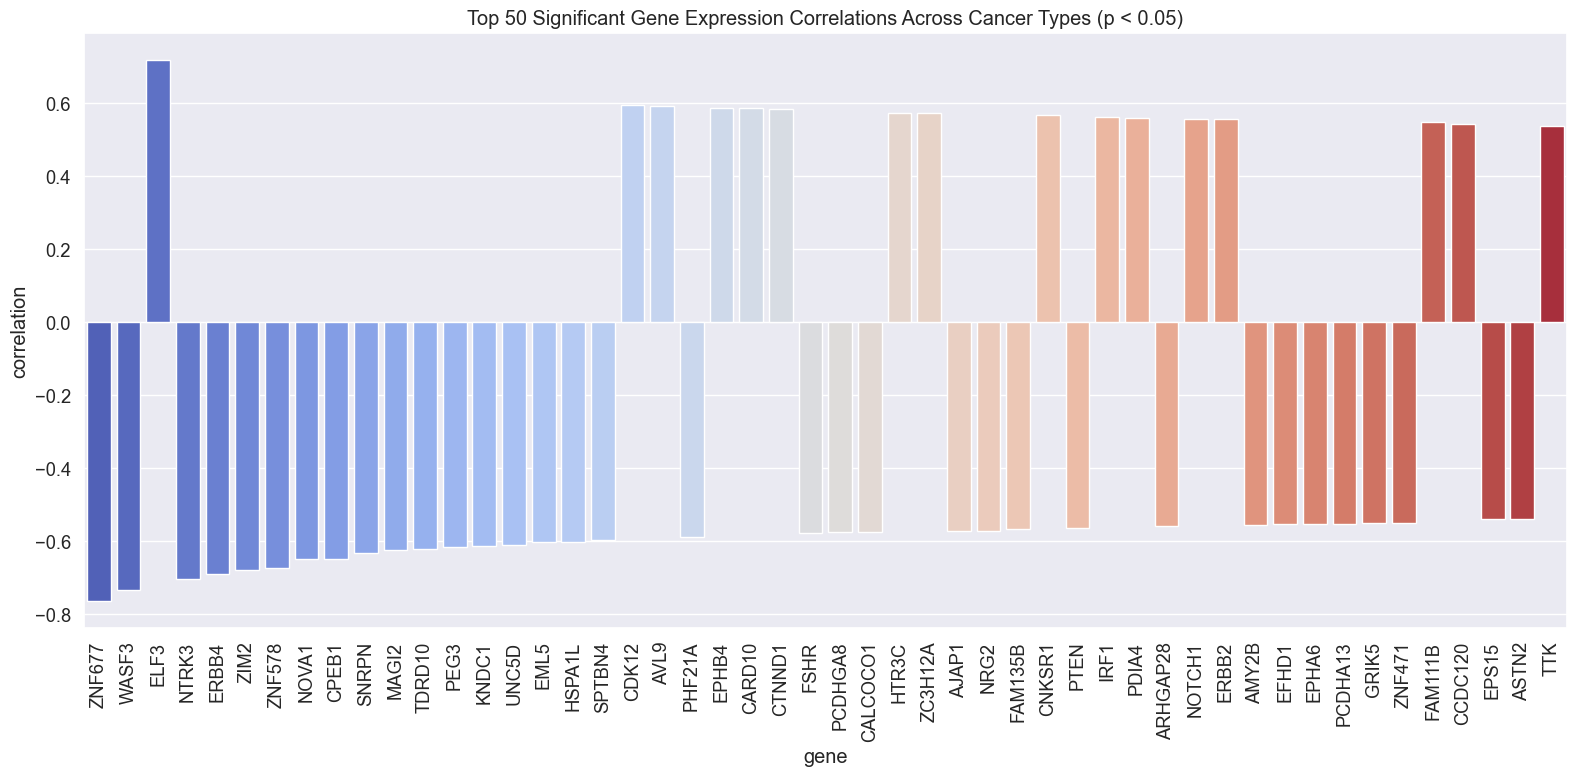

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute mutation frequencies and expression data by cancer type
def compute_cancer_type_stats(mutationtab, expression_data, cancer_type_column='cancer_type'):
    # Ensure that 'cancer_type' is the index in both mutationtab and expression_data
    mutationtab = mutationtab.reset_index().set_index(cancer_type_column)
    expression_data = expression_data.reset_index().set_index(cancer_type_column)
    
    # Select only numeric columns for mean computation
    mutation_by_cancer = mutationtab.select_dtypes(include=[np.number]).groupby(cancer_type_column).mean()
    expression_by_cancer = expression_data.select_dtypes(include=[np.number]).groupby(cancer_type_column).mean()
    
    return mutation_by_cancer, expression_by_cancer

# Step 2: Statistical comparison of mutations and expression patterns across cancer types
def compare_gene_expression_across_cancers(mutation_by_cancer, expression_by_cancer):
    results = []
    # Compare each gene's mutation and expression across cancer types using Spearman correlation
    for gene in mutation_by_cancer.columns:
        if gene in expression_by_cancer.columns:
            gene_mutation_data = mutation_by_cancer[gene]
            gene_expression_data = expression_by_cancer[gene]
            correlation, p_value = stats.spearmanr(gene_mutation_data, gene_expression_data)
            results.append({
                'gene': gene,
                'correlation': correlation,
                'p_value': p_value
            })
    return pd.DataFrame(results)

# Step 3: Visualization of significant correlations
def plot_correlation_results(results_df, p_value_threshold=0.05, top_n=50):
    # Filter results based on the p-value threshold
    significant_results = results_df[results_df['p_value'] < p_value_threshold]
    
    # Optionally, sort and limit to the top N most correlated genes
    significant_results['abs_corr'] = significant_results['correlation'].abs()
    significant_results = significant_results.sort_values(by='abs_corr', ascending=False).head(top_n)
    
    # Plotting
    plt.figure(figsize=(16, 8))  # Increased figure size
    sns.barplot(data=significant_results, x='gene', y='correlation', palette='coolwarm')
    plt.title(f'Top {top_n} Significant Gene Expression Correlations Across Cancer Types (p < {p_value_threshold})')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()
# Step 4: Putting everything together
def perform_cross_cancer_comparison(mutationtab, expression_data, cancer_type_column='cancer_type'):
    mutation_by_cancer, expression_by_cancer = compute_cancer_type_stats(mutationtab, expression_data, cancer_type_column)
    results_df = compare_gene_expression_across_cancers(mutation_by_cancer, expression_by_cancer)
    plot_correlation_results(results_df)

# Execute the analysis
perform_cross_cancer_comparison(mutationtab, tumourexp)


Cross-Cancer Comparisons: If the dataset contains multiple cancer types, you can perform comparisons of mutation and expression patterns across cancer types, identifying driver genes that behave consistently or differently between cancers.

### Oncogenes VS Tumour Supressor

#### Filtered

In [ ]:
# Split drivers into oncogenes and tumor suppressors
oncogenes = list(set(cancerdrivers[cancerdrivers['NCG_oncogene'] == 1]['symbol']))
tumor_suppressors = list(set(cancerdrivers[cancerdrivers['NCG_tsg'] == 1]['symbol']))

# Classify the drivers
results_df['driver_type'] = results_df['driver'].apply(lambda x: 'Oncogene' if x in oncogenes else ('Tumour Suppressor' if x in tumor_suppressors else 'Unknown'))
print("\nDriver types:")
print(results_df['driver_type'].value_counts())

# Get lists of drivers by type
oncogenes_info = results_df[results_df['driver_type'] == 'Oncogene']['driver'].tolist()
tumor_suppressors_info = results_df[results_df['driver_type'] == 'Tumour Suppressor']['driver'].tolist()
unknown_drivers_info = results_df[results_df['driver_type'] == 'Unknown']['driver'].tolist()

# Statistical analysis of gene expression between oncogenes and tumor suppressors
oncogene_exp = results_df[results_df['driver_type'] == 'Oncogene']['mean_expression_mutated']
tsg_exp = results_df[results_df['driver_type'] == 'Tumour Suppressor']['mean_expression_mutated']

# Mann-Whitney U test to compare gene expression between oncogenes and tumor suppressors
u_stat_onc_vs_tsg, u_p_value_onc_vs_tsg = stats.mannwhitneyu(oncogene_exp, tsg_exp, nan_policy='omit')

print(f"\nMann-Whitney U test for gene expression between Oncogenes and Tumour Suppressors:")
print(f"U-statistic: {u_stat_onc_vs_tsg}, P-value: {u_p_value_onc_vs_tsg}")


Driver types:
driver_type
Unknown              2076
Tumour Suppressor     206
Oncogene              185
Name: count, dtype: int64

Mann-Whitney U test for gene expression between Oncogenes and Tumour Suppressors:
U-statistic: 16587.0, P-value: 0.02700181913982918


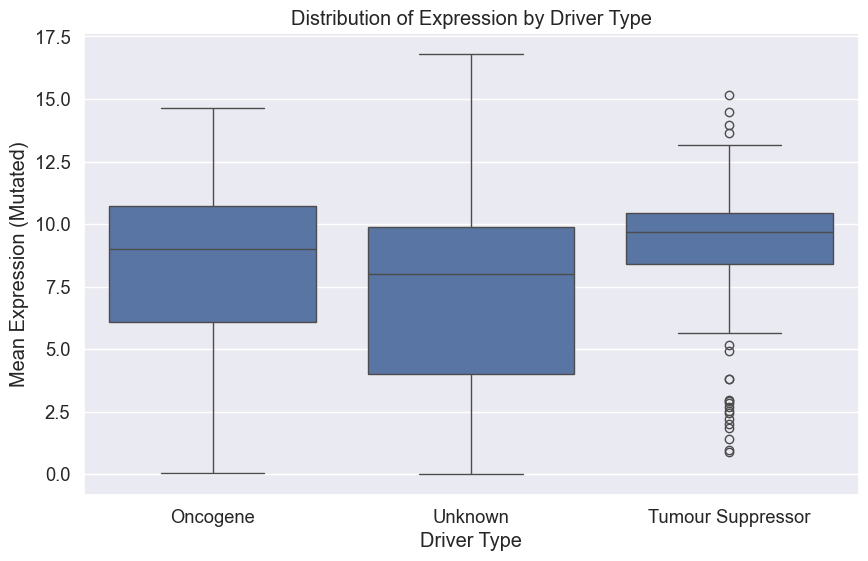

In [ ]:
# Boxplot visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='driver_type', y='mean_expression_mutated', data=results_df)
plt.title('Distribution of Expression by Driver Type')
plt.xlabel('Driver Type')
plt.ylabel('Mean Expression (Mutated)')
plt.show()


In [ ]:
results_df['expression_change'] = results_df['mean_expression_mutated'] - results_df['mean_expression_non_mutated']

mean_expression_change = results_df.groupby('driver_type')['expression_change'].mean()

# Exibindo os valores das médias
mean_expression_change


driver_type
Oncogene            -0.046555
Tumour Suppressor   -0.005412
Unknown             -0.144646
Name: expression_change, dtype: float64

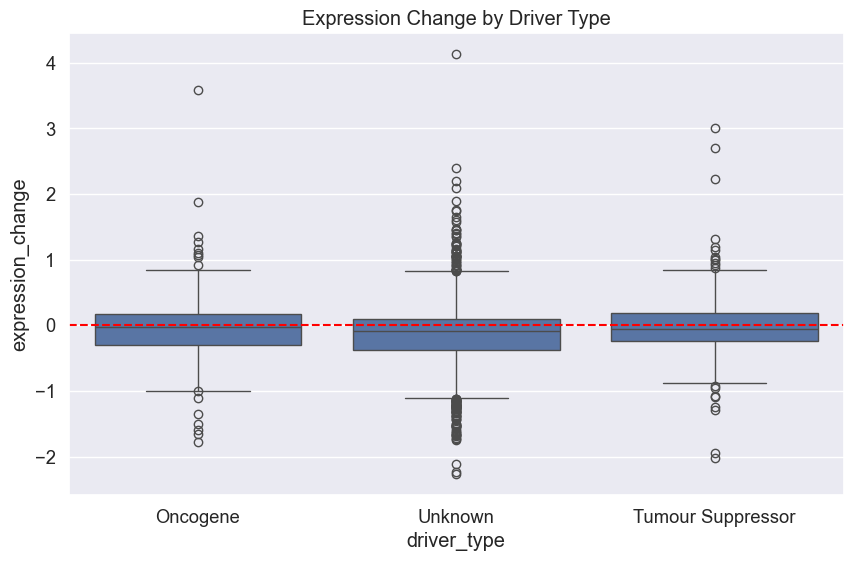

In [ ]:
# Boxplot of Expression Change by Driver Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='driver_type', y='expression_change', data=results_df)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.title('Expression Change by Driver Type')
plt.show()

<Figure size 1000x600 with 0 Axes>

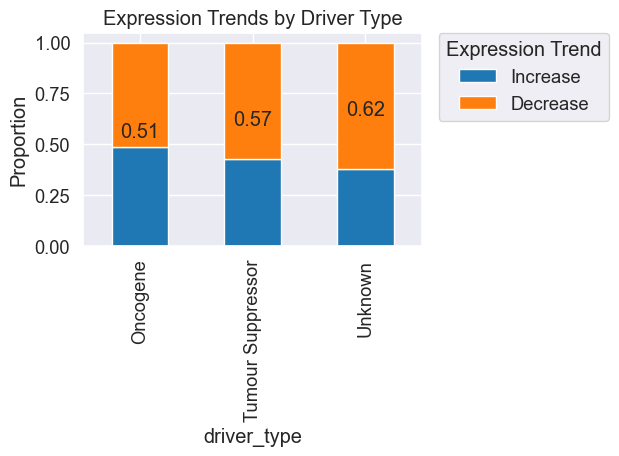

In [ ]:
# Function to categorize expression direction (Increase, Decrease, No Change)
def expression_direction(row):
    if row['expression_change'] > 0:
        return 'Increase'
    elif row['expression_change'] < 0:
        return 'Decrease'
    else:
        return 'No Change'

# Apply the function to create the 'expression_direction' column
results_df['expression_direction'] = results_df.apply(expression_direction, axis=1)

# Count and calculate proportions of expression trends for each driver type
direction_counts = results_df.groupby(['driver_type', 'expression_direction']).size().unstack(fill_value=0)
direction_proportions = direction_counts.div(direction_counts.sum(axis=1), axis=0)

# Visualize the proportions of expression trends with bar plot using custom colors
colors = {'Increase': '#1f77b4', 'Decrease': '#ff7f0e'}

plt.figure(figsize=(10, 6))
ax = direction_proportions[['Increase', 'Decrease']].plot(kind='bar', stacked=True, color=[colors['Increase'], colors['Decrease']])

# Move the legend outside the plot
ax.legend(title='Expression Trend', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('Expression Trends by Driver Type')
plt.ylabel('Proportion')

# Add annotations for clearer comparison
for index, proportion in enumerate(direction_proportions['Decrease']):
    plt.text(index, proportion + 0.02, f"{proportion:.2f}", ha='center')

plt.tight_layout()  # Adjust layout to prevent clipping of ylabel/legend
plt.show()


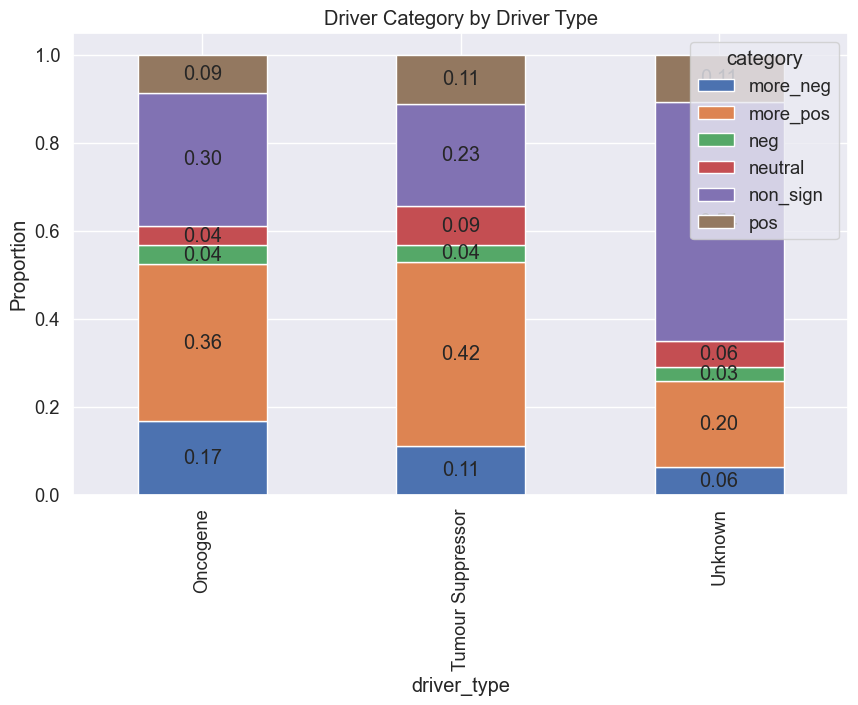

" # Cross-tabulation of driver types by category\ncategory_by_type = pd.crosstab(results_df['driver_type'], results_df['category'], normalize='index')\nax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6))\ncategory_by_type = category_by_type[category_order]\n\n# Plotar o gráfico empilhado\nax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6))\n\n# Mover a legenda para fora do gráfico\nax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)\n\n# Adicionar título e rótulo ao eixo Y\nplt.title('Driver Category by Driver Type')\nplt.ylabel('Proportion')\n\n# Anotar as barras com os rótulos de proporção\nfor c in ax.containers:\n    labels = [f'{v.get_height():.2f}' if v.get_height() > 0 else '' for v in c]\n    ax.bar_label(c, labels=labels, label_type='center')\n\n# Ajustar o layout para evitar que a legenda ou o rótulo do eixo Y seja cortado\nplt.tight_layout()\n\n# Exibir o gráfico\nplt.show() "

In [ ]:
# Cross-tabulation of driver types by category
category_by_type = pd.crosstab(results_df['driver_type'], results_df['category'], normalize='index')
ax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Driver Category by Driver Type')
plt.ylabel('Proportion')

# Annotate bars with labels
for c in ax.containers:
    labels = [f'{v.get_height():.2f}' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center') 

plt.show()

""" # Cross-tabulation of driver types by category
category_by_type = pd.crosstab(results_df['driver_type'], results_df['category'], normalize='index')
ax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6))
category_by_type = category_by_type[category_order]

# Plotar o gráfico empilhado
ax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6))

# Mover a legenda para fora do gráfico
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adicionar título e rótulo ao eixo Y
plt.title('Driver Category by Driver Type')
plt.ylabel('Proportion')

# Anotar as barras com os rótulos de proporção
for c in ax.containers:
    labels = [f'{v.get_height():.2f}' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

# Ajustar o layout para evitar que a legenda ou o rótulo do eixo Y seja cortado
plt.tight_layout()

# Exibir o gráfico
plt.show() """


In [ ]:
results_df_not_unk = results_df[results_df['driver_type'] != 'Unknown']

In [ ]:
print(category_by_type.columns)


Index(['more_neg', 'more_pos', 'neg', 'neutral', 'non_sign', 'pos'], dtype='object', name='category')


In [ ]:
results_df

driver  category  mean_expression_mutated  mean_expression_non_mutated  \
0       A1CF  non_sign                 1.364054                     1.733682   
1      A2ML1  more_pos                 3.792646                     3.984380   
2     ABCA10  non_sign                 3.434216                     3.776301   
3     ABCA13  more_pos                 4.416936                     4.238564   
4      ABCA7  non_sign                 8.592880                     8.488046   
...      ...       ...                      ...                          ...   
2462  ZSWIM3  non_sign                 6.757654                     6.826901   
2463  ZSWIM6  non_sign                 8.376133                     8.574214   
2464  ZWILCH  non_sign                 8.974727                     8.440610   
2465   ZWINT       pos                 9.697200                     8.939950   
2466   ZZEF1  more_pos                10.118257                    10.136499   

      mann_whitney_statistic   p_value expression_trend  expression_change  \
0                        NaN       NaN         decrease          -0.369628   
1                   768878.0  0.820689         decrease          -0.191734   
2                   734992.0  0.003051         decrease          -0.342086   
3                  2349323.0  0.173663         increase           0.178372   
4                   845376.0  0.065576         increase           0.104834   
...                      ...       ...              ...                ...   
2462                314347.0  0.295461         decrease          -0.069247   
2463                267416.5  0.031749         decrease          -0.198081   
2464                306038.0  0.000020         increase           0.534118   
2465                409681.5  0.000003         increase           0.757250   
2466                865696.0  0.452197         decrease          -0.018242   

     driver_type expression_direction  
0       Oncogene             Decrease  
1        Unknown             Decrease  
2        Unknown             Decrease  
3        Unknown             Increase  
4        Unknown             Increase  
...          ...                  ...  
2462     Unknown             Decrease  
2463     Unknown             Decrease  
2464     Unknown             Increase  
2465     Unknown             Increase  
2466     Unknown             Decrease  

[2467 rows x 10 columns]

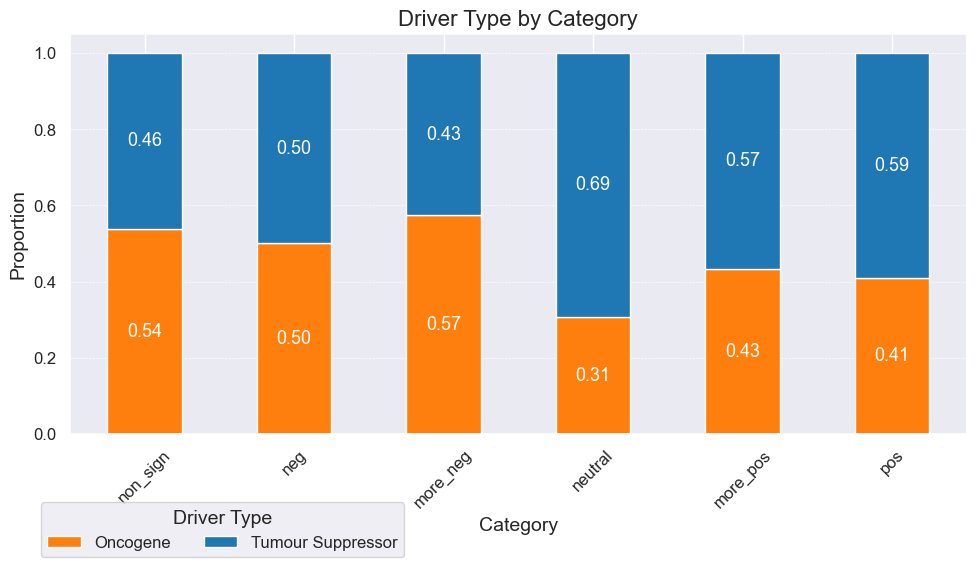

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Create a crosstab with categories on the x-axis and driver types as proportions
category_by_type = pd.crosstab(results_df['category'], results_df_not_unk['driver_type'], normalize='index')

# Step 2: Reorder the categories according to the desired order
category_by_type = category_by_type.reindex(category_order)

# Step 3: Define colors for Oncogene (orange), Tumor Suppressor (blue), and Unknown (gray)
colors = {
    'Oncogene': '#ff7f0e',  # Orange for Oncogene
    'Tumour Suppressor': '#1f77b4',  # Blue for Tumor Suppressor
    'Unknown': '#d3d3d3'  # Gray for Unknown
}

# Step 4: Create the stacked bar chart with wider bars
ax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6),
                           color=[colors[col] for col in category_by_type.columns])

# Step 5: Customize the plot
plt.title('Driver Type by Category', fontsize=16)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Category', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Step 6: Add values inside each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2., f'{height:.2f}', 
                ha='center', va='center', fontsize=13, color='white')

# Step 7: Move the legend below the chart
plt.legend(title='Driver Type', bbox_to_anchor=(0.17, -0.15), loc='upper center', 
           fontsize=12, title_fontsize=14, ncol=3)  # ncol=3 for a single row of the legend

# Step 8: Add gridlines for better readability
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Step 9: Adjust layout to avoid clipping
plt.tight_layout()

# Step 10: Show the plot
plt.show()


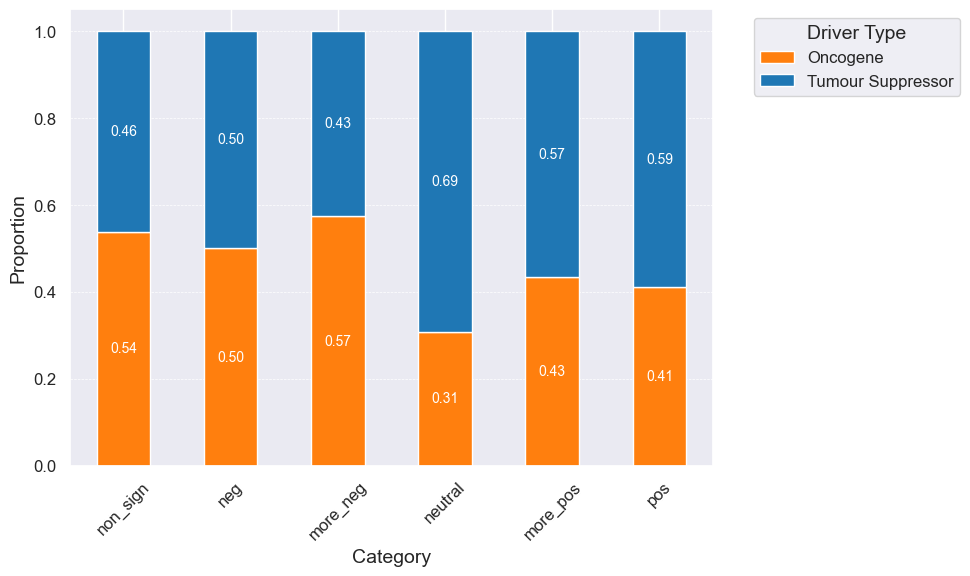

" # Reverse the X-axis and Y-axis of the previous plot\ncategory_by_type = pd.crosstab(results_df['category'], results_df['driver_type'], normalize='index')\ncategory_by_type.plot(kind='bar', stacked=True)\nplt.title('Driver Type by Category')\nplt.ylabel('Proportion')\nplt.show() "

In [ ]:
#fazer ao contrário, meter antes as categorias no eixo do x e se é oncogene e tumor supressor ou unknown como proporção
import matplotlib.pyplot as plt

# Step 1: Create a crosstab with categories on the x-axis and driver types as proportions
category_by_type = pd.crosstab(results_df['category'], results_df_not_unk['driver_type'], normalize='index')

# Step 2: Reorder the categories according to the desired order
category_by_type = category_by_type.reindex(category_order)

# Step 3: Define colors for Oncogene (orange), Tumor Suppressor (blue), and Unknown (gray)
colors = {
    'Oncogene': '#ff7f0e',  # Orange for Oncogene
    'Tumour Suppressor': '#1f77b4',  # Blue for Tumor Suppressor
    'Unknown': '#d3d3d3'  # Gray for Unknown
}

# Step 4: Create the stacked bar chart with wider bars
ax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6),
                           color=[colors[col] for col in category_by_type.columns])

# Step 5: Customize the plot
#plt.title('Driver Type by Category', fontsize=16)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Category', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Step 6: Add values inside each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2., f'{height:.2f}', 
                ha='center', va='center', fontsize=10, color='white')

# Step 7: Move the legend closer
plt.legend(title='Driver Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Step 8: Add gridlines for better readability
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Step 9: Adjust layout to avoid clipping
plt.tight_layout()

# Step 10: Show the plot
plt.show()

#tumor suppressor tendem a ter mais positive neighbours e oncogenes tendem a ter mais negative neighbours

""" # Reverse the X-axis and Y-axis of the previous plot
category_by_type = pd.crosstab(results_df['category'], results_df['driver_type'], normalize='index')
category_by_type.plot(kind='bar', stacked=True)
plt.title('Driver Type by Category')
plt.ylabel('Proportion')
plt.show() """

In [ ]:
results_df_not_unk

driver  category  mean_expression_mutated  mean_expression_non_mutated  \
0       A1CF  non_sign                 1.364054                     1.733682   
16      ABI1   neutral                10.450000                    10.495155   
17      ABL1  more_pos                11.066111                    11.078340   
18      ABL2  more_pos                 9.447234                     9.667667   
33     ACVR1  non_sign                 9.408824                     9.702548   
...      ...       ...                      ...                          ...   
2398   ZMYM3  more_pos                 9.893631                     9.980450   
2417  ZNF331  more_neg                 8.196364                     8.529653   
2430  ZNF521  more_pos                 6.477086                     7.048911   
2457   ZNRF3  non_sign                 8.905833                     8.817548   
2460   ZRSR2  non_sign                 8.030500                     7.936216   

      mann_whitney_statistic       p_value expression_trend  \
0                        NaN           NaN         decrease   
16                  164980.0  4.982615e-01         decrease   
17                  436681.0  6.518555e-01         decrease   
18                  477051.5  2.217924e-04         decrease   
33                  225559.0  3.683656e-03         decrease   
...                      ...           ...              ...   
2398                726296.0  7.592551e-01         decrease   
2417                337964.0  2.307190e-03         decrease   
2430                919908.0  1.368426e-07         decrease   
2457                413979.5  5.202915e-01         increase   
2460                181467.5  3.540376e-01         increase   

      expression_change       driver_type expression_direction  
0             -0.369628          Oncogene             Decrease  
16            -0.045155  Tumor Suppressor             Decrease  
17            -0.012229          Oncogene             Decrease  
18            -0.220433          Oncogene             Decrease  
33            -0.293724          Oncogene             Decrease  
...                 ...               ...                  ...  
2398          -0.086819  Tumor Suppressor             Decrease  
2417          -0.333290  Tumor Suppressor             Decrease  
2430          -0.571825          Oncogene             Decrease  
2457           0.088285  Tumor Suppressor             Increase  
2460           0.094284  Tumor Suppressor             Increase  

[391 rows x 10 columns]

In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table (cross-tabulation) of the driver types and categories
contingency_table_original = pd.crosstab(results_df_not_unk['driver_type'], results_df_not_unk['category'])

# Perform the chi-square test
chi2_stat_original, p_val_original, dof_original, expected_original = chi2_contingency(contingency_table_original)

# Print the results
print(f"Chi-Square Test (Original Categories):")
print(f"Chi-Square Statistic: {chi2_stat_original}, P-value: {p_val_original}")


Chi-Square Test (Original Categories):
Chi-Square Statistic: 8.431156096153542, P-value: 0.13402021240211165


In [ ]:
# Step 1: Create a new column for the merged categories
def merge_categories(category):
    if category in ['pos', 'more_pos']:
        return 'positive'
    elif category in ['neg', 'more_neg']:
        return 'negative'
    else:
        return category

# Step 2: Apply the function to create the merged category column
results_df_not_unk['merged_category'] = results_df_not_unk['category'].apply(merge_categories)

# Step 3: Create a contingency table (cross-tabulation) of the driver types and merged categories
contingency_table_merged = pd.crosstab(results_df_not_unk['driver_type'], results_df_not_unk['merged_category'])

# Step 4: Perform the chi-square test on the merged categories
chi2_stat_merged, p_val_merged, dof_merged, expected_merged = chi2_contingency(contingency_table_merged)

# Print the results
print(f"Chi-Square Test (Merged Categories):")
print(f"Chi-Square Statistic: {chi2_stat_merged}, P-value: {p_val_merged}")


Chi-Square Test (Merged Categories):
Chi-Square Statistic: 8.088031572371024, P-value: 0.044226965730473335


/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_36736/4054904026.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_not_unk['merged_category'] = results_df_not_unk['category'].apply(merge_categories)


In [ ]:
contingency_table = pd.crosstab(results_df['category'], results_df_not_unk['driver_type'])

# Step 2: Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Step 3: Print the test results
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of Freedom: {dof}")

print("\nContingency Table:")
print(contingency_table)

print("\nExpected Values (Under Null Hypothesis):")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))



Chi-Square Test Results:
Chi-Square Statistic: 8.4312
P-value: 1.34e-01
Degrees of Freedom: 5

Contingency Table:
driver_type  Oncogene  Tumor Suppressor
category                               
more_neg           31                23
more_pos           66                86
neg                 8                 8
neutral             8                18
non_sign           56                48
pos                16                23

Expected Values (Under Null Hypothesis):
driver_type   Oncogene  Tumor Suppressor
category                                
more_neg     25.549872         28.450128
more_pos     71.918159         80.081841
neg           7.570332          8.429668
neutral      12.301790         13.698210
non_sign     49.207161         54.792839
pos          18.452685         20.547315


In [ ]:
results_df

driver  category  mean_expression_mutated  mean_expression_non_mutated  \
0       A1CF  non_sign                 1.364054                     1.733682   
1      A2ML1  more_pos                 3.792646                     3.984380   
2     ABCA10  non_sign                 3.434216                     3.776301   
3     ABCA13  more_pos                 4.416936                     4.238564   
4      ABCA7  non_sign                 8.592880                     8.488046   
...      ...       ...                      ...                          ...   
2462  ZSWIM3  non_sign                 6.757654                     6.826901   
2463  ZSWIM6  non_sign                 8.376133                     8.574214   
2464  ZWILCH  non_sign                 8.974727                     8.440610   
2465   ZWINT       pos                 9.697200                     8.939950   
2466   ZZEF1  more_pos                10.118257                    10.136499   

      mann_whitney_statistic   p_value expression_trend  expression_change  \
0                        NaN       NaN         decrease          -0.369628   
1                   768878.0  0.820689         decrease          -0.191734   
2                   734992.0  0.003051         decrease          -0.342086   
3                  2349323.0  0.173663         increase           0.178372   
4                   845376.0  0.065576         increase           0.104834   
...                      ...       ...              ...                ...   
2462                314347.0  0.295461         decrease          -0.069247   
2463                267416.5  0.031749         decrease          -0.198081   
2464                306038.0  0.000020         increase           0.534118   
2465                409681.5  0.000003         increase           0.757250   
2466                865696.0  0.452197         decrease          -0.018242   

     driver_type expression_direction  
0       Oncogene             Decrease  
1        Unknown             Decrease  
2        Unknown             Decrease  
3        Unknown             Increase  
4        Unknown             Increase  
...          ...                  ...  
2462     Unknown             Decrease  
2463     Unknown             Decrease  
2464     Unknown             Increase  
2465     Unknown             Increase  
2466     Unknown             Decrease  

[2467 rows x 10 columns]

In [ ]:
driver_info


n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group  \
driver                                                                     
A1CF              39          0          0  0.000000  0.000000  non_sign   
A2ML1             91          4          3  0.043956  0.032967  more_pos   
ABCA10             5          0          0  0.000000  0.000000  non_sign   
ABCA13             9          3          1  0.333333  0.111111  more_pos   
ABCA7             16          0          0  0.000000  0.000000  non_sign   
...              ...        ...        ...       ...       ...       ...   
ZSWIM3             6          0          0  0.000000  0.000000  non_sign   
ZSWIM6            22          0          0  0.000000  0.000000  non_sign   
ZWILCH            22          1          0  0.045455  0.000000  non_sign   
ZWINT            136         22          0  0.161765  0.000000       pos   
ZZEF1             89          8          2  0.089888  0.022472  more_pos   

        expression_change  mutation_frequency  
driver                                         
A1CF            -0.369628            0.013327  
A2ML1           -0.191734            0.022489  
ABCA10          -0.342086            0.024274  
ABCA13           0.178372            0.069134  
ABCA7            0.104834            0.022727  
...                   ...                 ...  
ZSWIM3          -0.069247            0.009638  
ZSWIM6          -0.198081            0.008924  
ZWILCH           0.534118            0.006545  
ZWINT            0.757250            0.008924  
ZZEF1           -0.018242            0.025940  

[2565 rows x 8 columns]

Correlation for Oncogene: 0.2860409598884223
Correlation for Tumor Suppressor: -0.02185124706438742
Correlation for Unknown: 0.17520608403508647


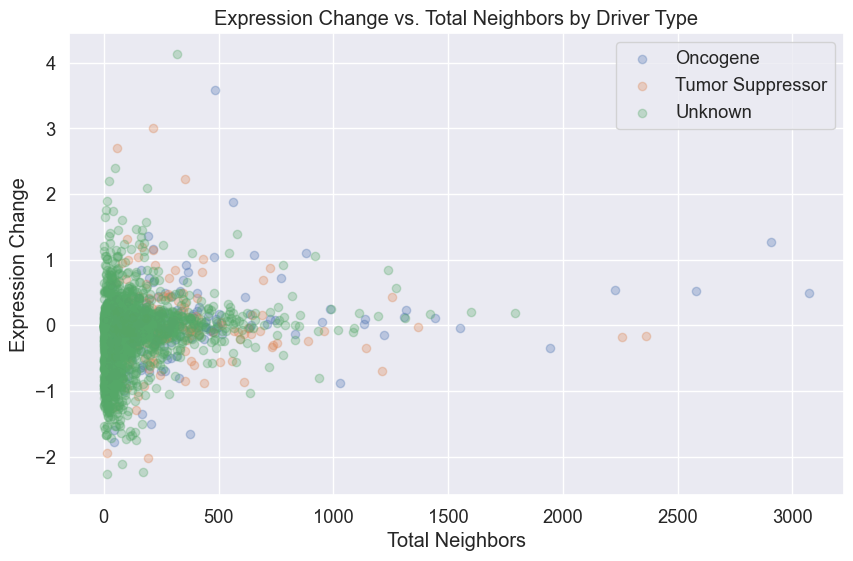

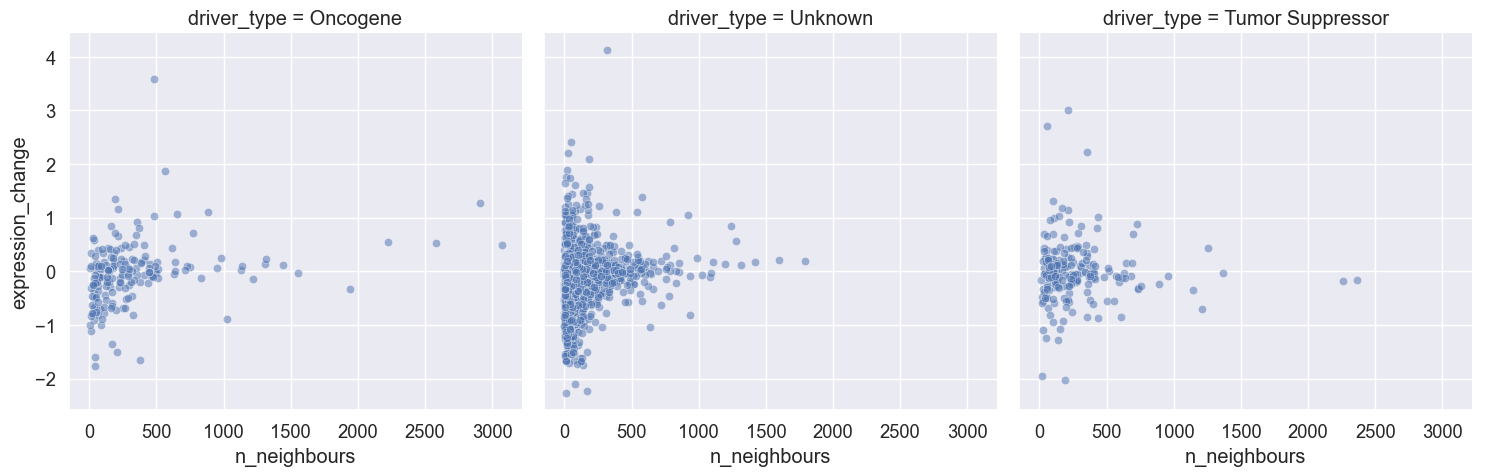

In [ ]:
# Merge n_neighbours from driver_info into results_df
results_df = results_df.merge(driver_info[['n_neighbours']], left_on='driver', right_index=True, how='left')

# Calculate the correlation between expression change and total neighbors for each driver type
for driver_type in ['Oncogene', 'Tumor Suppressor', 'Unknown']:
    subset = results_df[results_df['driver_type'] == driver_type]
    correlation = subset['expression_change'].corr(subset['n_neighbours'])
    print(f"Correlation for {driver_type}: {correlation}")

# Scatter plot: Expression change vs. total neighbors by driver type
plt.figure(figsize=(10, 6))
for driver_type in ['Oncogene', 'Tumor Suppressor', 'Unknown']:
    subset = results_df[results_df['driver_type'] == driver_type]
    plt.scatter(subset['n_neighbours'], subset['expression_change'], label=driver_type, alpha=0.3)

plt.xlabel('Total Neighbors')
plt.ylabel('Expression Change')
plt.title('Expression Change vs. Total Neighbors by Driver Type')
plt.legend()
plt.show()

# Alternatively, create separate scatter plots using FacetGrid
g = sns.FacetGrid(results_df, col="driver_type", height=5)
g.map_dataframe(sns.scatterplot, x="n_neighbours", y="expression_change", alpha=0.5)
g.add_legend()
plt.show()


In [ ]:
""" # Mean expression change by driver type
mean_change = results_df.groupby('driver_type')['expression_change'].mean()
print("Mean Expression Change by Driver Type:")
print(mean_change)

# Bar plot of mean expression change by driver type
plt.figure(figsize=(8, 6))
mean_change.plot(kind='bar')
plt.title('Mean Expression Change by Driver Type')
plt.ylabel('Mean Expression Change')
plt.show() """

' # Mean expression change by driver type\nmean_change = results_df.groupby(\'driver_type\')[\'expression_change\'].mean()\nprint("Mean Expression Change by Driver Type:")\nprint(mean_change)\n\n# Bar plot of mean expression change by driver type\nplt.figure(figsize=(8, 6))\nmean_change.plot(kind=\'bar\')\nplt.title(\'Mean Expression Change by Driver Type\')\nplt.ylabel(\'Mean Expression Change\')\nplt.show() '

In [ ]:
# Proportion of drivers with Increase vs. Decrease in expression
direction_counts = results_df.groupby(['driver_type', 'expression_direction']).size().unstack(fill_value=0)
direction_proportions = direction_counts.div(direction_counts.sum(axis=1), axis=0)

print("Proportion of drivers with increase vs. decrease in expression:")
print(direction_proportions)

Proportion of drivers with increase vs. decrease in expression:
expression_direction  Decrease  Increase
driver_type                             
Oncogene              0.513514  0.486486
Tumor Suppressor      0.572816  0.427184
Unknown               0.622351  0.377649


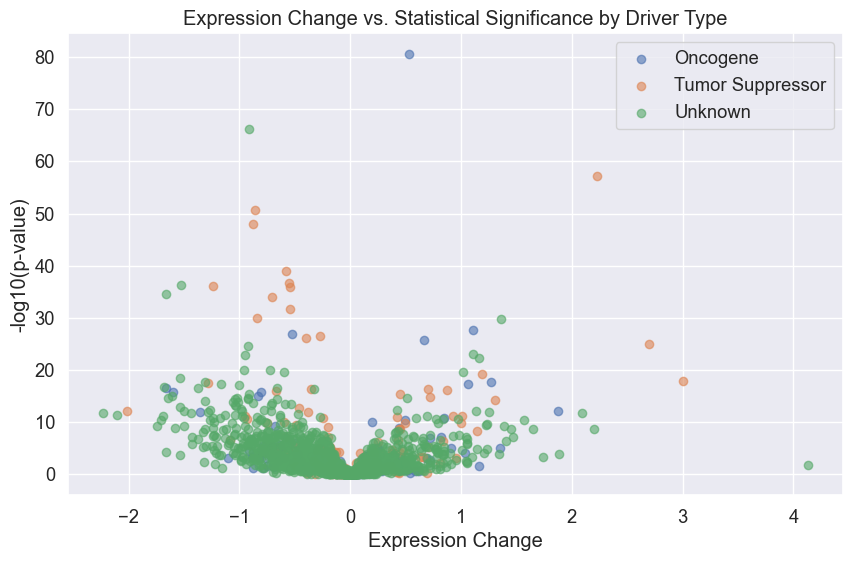

In [ ]:
# Scatter plot: Expression change vs. statistical significance (-log10(p-value))
plt.figure(figsize=(10, 6))
for driver_type in ['Oncogene', 'Tumor Suppressor', 'Unknown']:
    subset = results_df[results_df['driver_type'] == driver_type]
    plt.scatter(subset['expression_change'], -np.log10(subset['p_value']), label=driver_type, alpha=0.6)

plt.xlabel('Expression Change')
plt.ylabel('-log10(p-value)')
plt.title('Expression Change vs. Statistical Significance by Driver Type')
plt.legend()
plt.show()


In [ ]:
total_drivers = len(driver_stats)
significant_drivers = len(driver_stats[driver_stats['group'] != 'non_sign'])
non_significant_drivers = total_drivers - significant_drivers
category_counts = driver_stats['group'].value_counts()

print(f"Total drivers: {total_drivers}")
print(f"Significant drivers: {significant_drivers}")
print(f"Non-significant drivers: {non_significant_drivers}")

print("\nDriver categories:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

print("\nTop 5 drivers with most neighbors:")
print(driver_stats.sort_values('n_neighbours', ascending=False).head())


Total drivers: 2565
Significant drivers: 1271
Non-significant drivers: 1294

Driver categories:
non_sign: 1294
more_pos: 576
pos: 274
more_neg: 185
neutral: 151
neg: 85

Top 5 drivers with most neighbors:
     driver  n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group  \
1381    MYC          3070         69          2  0.022476  0.000651  more_pos   
670    EGFR          2907          6         18  0.002064  0.006192  more_neg   
1158   KRAS          2582        126         72  0.048799  0.027885  more_pos   
514    CUL3          2364         76         28  0.032149  0.011844  more_pos   
2294   TP53          2259        163         54  0.072156  0.023904  more_pos   

     driver_type  
1381   Canonical  
670    Canonical  
1158   Canonical  
514    Canonical  
2294   Canonical  


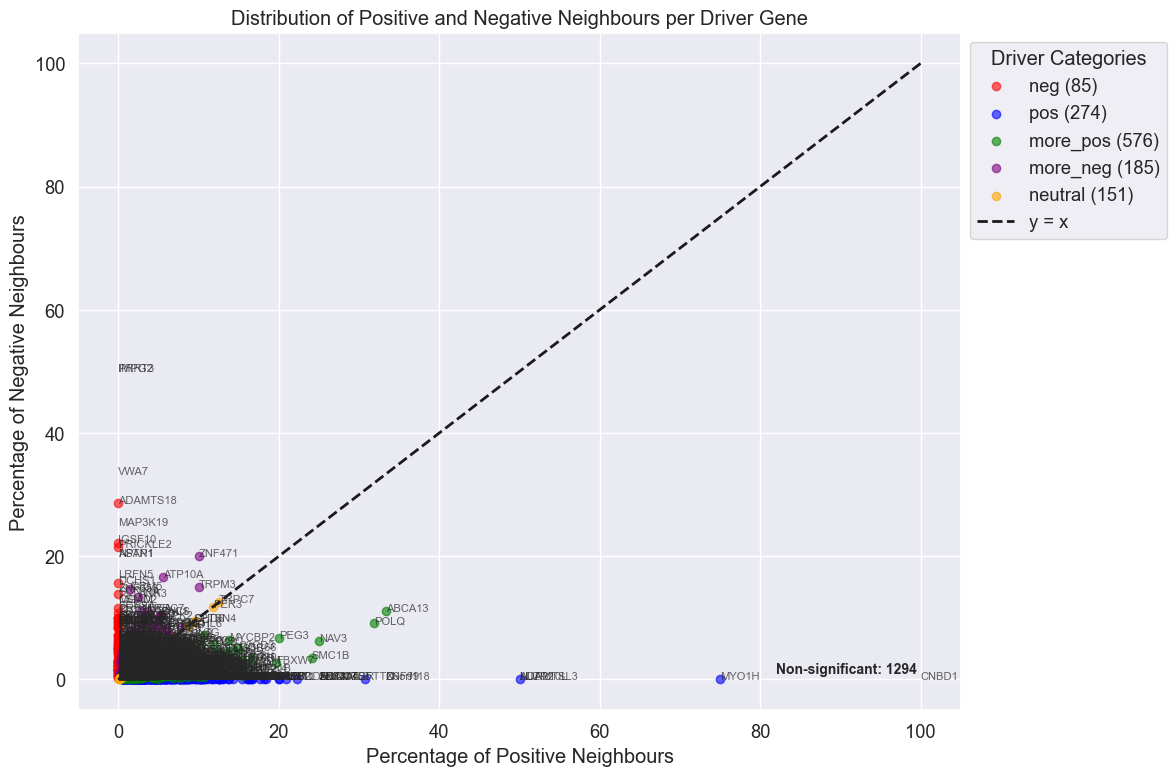

In [ ]:
# Step 4: Create the plot
plt.figure(figsize=(12, 8))

# Define colors for each category based on the 'group' column
color_map = {
    "neg": "red",
    "pos": "blue",
    "more_pos": "green",
    "more_neg": "purple",
    "neutral": "orange"
}

# Plot data points for each category
for category, color in color_map.items():
    category_data = driver_stats[driver_stats['group'] == category]
    plt.scatter(
        category_data["pos_pct"] * 100,  # Convert percentages to 0-100 scale
        category_data["neg_pct"] * 100,  # Convert percentages to 0-100 scale
        color=color,
        alpha=0.6,
        label=f"{category} ({len(category_data)})"
    )

# Add y=x line for reference
plt.plot([0, 100], [0, 100], 'k--', lw=2, label="y = x")

# Add labels and title
plt.xlabel("Percentage of Positive Neighbours")
plt.ylabel("Percentage of Negative Neighbours")
plt.title("Distribution of Positive and Negative Neighbours per Driver Gene")
plt.grid(True)

# Add driver names as annotations
for index, row in driver_stats.iterrows():
    plt.annotate(
        row['driver'],  # Use driver name for annotation
        (row["pos_pct"] * 100, row["neg_pct"] * 100),
        fontsize=8,
        alpha=0.7
    )

# Add a legend
plt.legend(title="Driver Categories", loc="upper left", bbox_to_anchor=(1, 1))

# Add non-significant driver count to the plot
plt.text(0.95, 0.05, f"Non-significant: {non_significant_drivers}", 
         horizontalalignment='right', verticalalignment='bottom', 
         transform=plt.gca().transAxes, fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

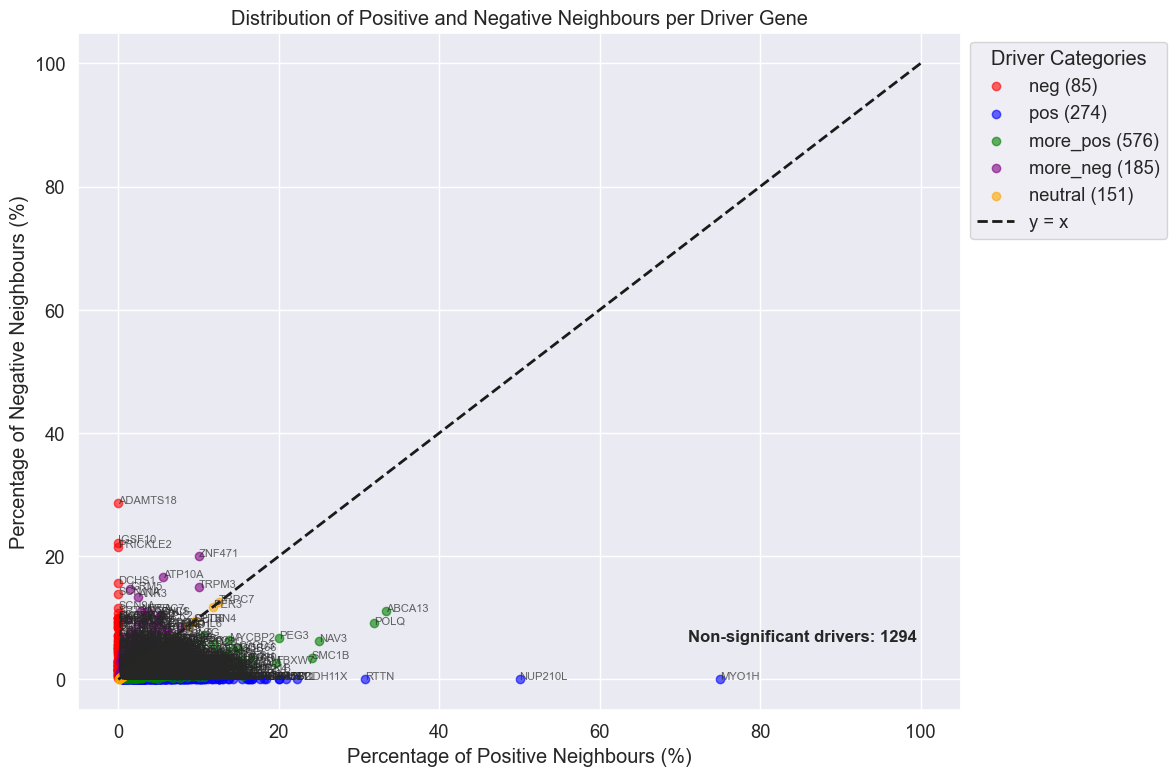

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Filter out non-significant drivers from the scatter plot data
filtered_driver_stats = driver_stats[driver_stats['group'] != "non_sign"]

# Step 2: Count the non-significant drivers
non_significant_count = len(driver_stats[driver_stats['group'] == "non_sign"])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))

# Define colors for each category based on the 'group' column
color_map = {
    "neg": "red",
    "pos": "blue",
    "more_pos": "green",
    "more_neg": "purple",
    "neutral": "orange"
}

# Step 4: Plot data points for each category excluding "non_sign"
for category, color in color_map.items():
    category_data = filtered_driver_stats[filtered_driver_stats['group'] == category]
    plt.scatter(
        category_data["pos_pct"] * 100,  # Convert percentages to 0-100 scale
        category_data["neg_pct"] * 100,  # Convert percentages to 0-100 scale
        color=color,
        alpha=0.6,
        label=f"{category} ({len(category_data)})"
    )

# Step 5: Add y=x line for reference
plt.plot([0, 100], [0, 100], 'k--', lw=2, label="y = x")

# Step 6: Add labels and title
plt.xlabel("Percentage of Positive Neighbours (%)")
plt.ylabel("Percentage of Negative Neighbours (%)")
plt.title("Distribution of Positive and Negative Neighbours per Driver Gene")
plt.grid(True)

# Step 7: Annotate drivers
for index, row in filtered_driver_stats.iterrows():
    plt.annotate(
        row['driver'],  # Use driver name for annotation
        (row["pos_pct"] * 100, row["neg_pct"] * 100),
        fontsize=8,
        alpha=0.7
    )

# Step 8: Add a legend
plt.legend(title="Driver Categories", loc="upper left", bbox_to_anchor=(1, 1))

# Step 9: Add non-significant driver count to the plot as a text annotation
plt.text(0.95, 0.12, f"Non-significant drivers: {non_significant_count}",  # Adjust y-position here
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

# Step 10: Adjust layout
plt.tight_layout()

# Step 11: Show the plot
plt.show()


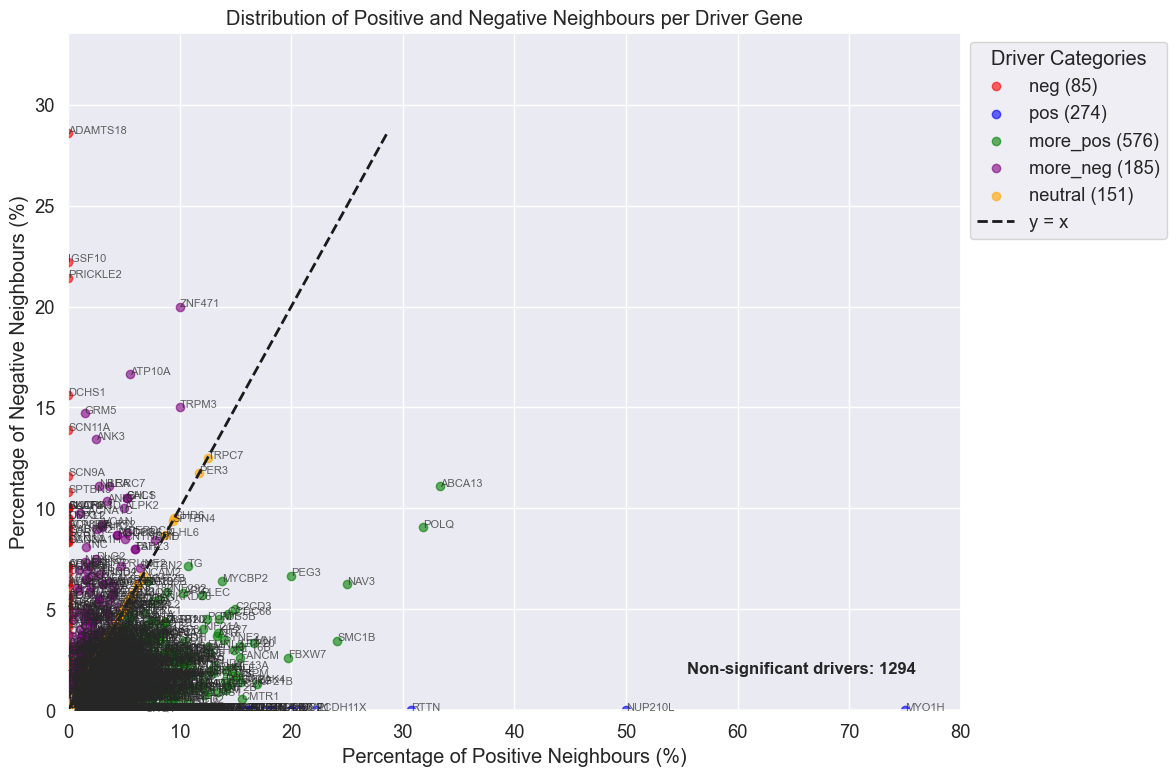

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Filter out non-significant drivers from the scatter plot data
filtered_driver_stats = driver_stats[driver_stats['group'] != "non_sign"]

# Step 2: Count the non-significant drivers
non_significant_count = len(driver_stats[driver_stats['group'] == "non_sign"])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))

# Define colors for each category based on the 'group' column
color_map = {
    "neg": "red",
    "pos": "blue",
    "more_pos": "green",
    "more_neg": "purple",
    "neutral": "orange"
}

# Step 4: Plot data points for each category excluding "non_sign"
for category, color in color_map.items():
    category_data = filtered_driver_stats[filtered_driver_stats['group'] == category]
    plt.scatter(
        category_data["pos_pct"] * 100,  # Convert percentages to 0-100 scale
        category_data["neg_pct"] * 100,  # Convert percentages to 0-100 scale
        color=color,
        alpha=0.6,
        label=f"{category} ({len(category_data)})"
    )

# Step 5: Set dynamic axis limits based on data
x_max = (filtered_driver_stats['pos_pct'].max()) * 100
y_max = (filtered_driver_stats['neg_pct'].max()) * 100

plt.xlim(0, x_max + 5)  # Add a small margin to make the plot look nicer
plt.ylim(0, y_max + 5)

# Step 6: Add y=x line for reference
plt.plot([0, min(x_max, y_max)], [0, min(x_max, y_max)], 'k--', lw=2, label="y = x")

# Step 7: Add labels and title
plt.xlabel("Percentage of Positive Neighbours (%)")
plt.ylabel("Percentage of Negative Neighbours (%)")
plt.title("Distribution of Positive and Negative Neighbours per Driver Gene")
plt.grid(True)

# Step 8: Annotate drivers
for index, row in filtered_driver_stats.iterrows():
    plt.annotate(
        row['driver'],  # Use driver name for annotation
        (row["pos_pct"] * 100, row["neg_pct"] * 100),
        fontsize=8,
        alpha=0.7
    )

# Step 9: Add a legend
plt.legend(title="Driver Categories", loc="upper left", bbox_to_anchor=(1, 1))

# Step 10: Add non-significant driver count to the plot as a text annotation
plt.text(0.95, 0.05, f"Non-significant drivers: {non_significant_count}", 
         horizontalalignment='right', verticalalignment='bottom', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

# Step 11: Adjust layout
plt.tight_layout()

# Step 12: Show the plot
plt.show()


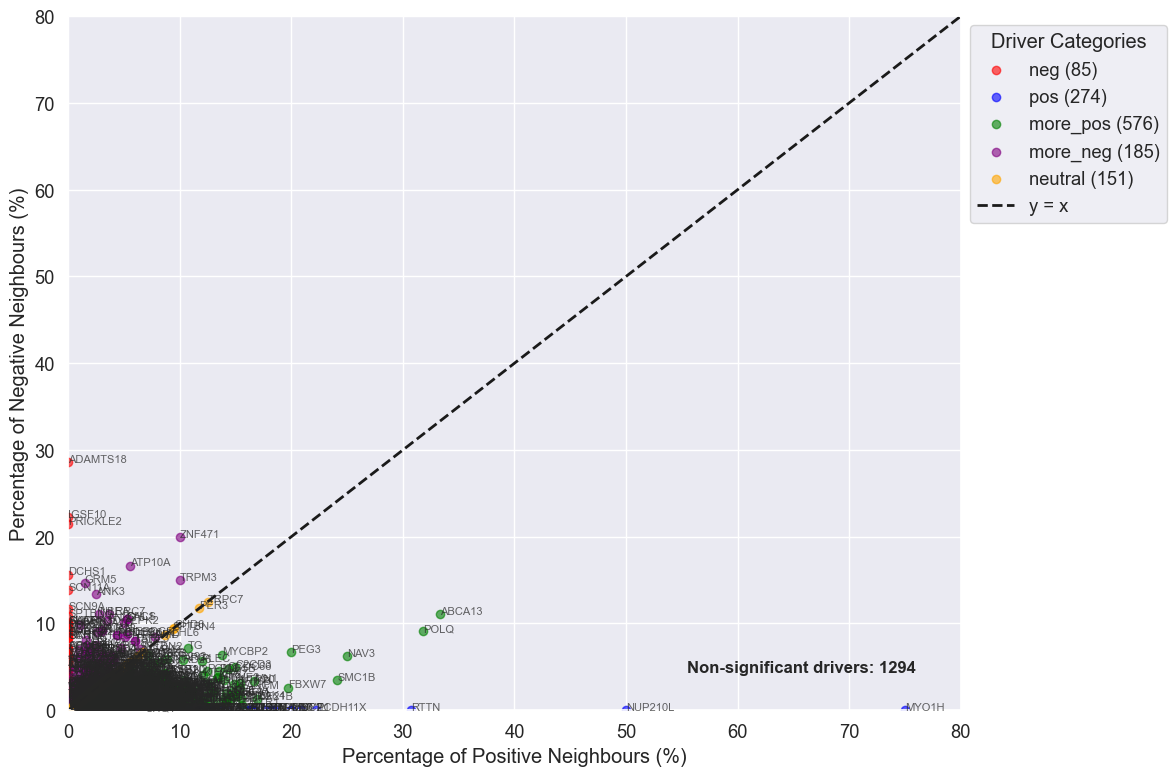

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Filter out non-significant drivers from the scatter plot data
filtered_driver_stats = driver_stats[driver_stats['group'] != "non_sign"]

# Step 2: Count the non-significant drivers
non_significant_count = len(driver_stats[driver_stats['group'] == "non_sign"])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))

# Define colors for each category based on the 'group' column
color_map = {
    "neg": "red",
    "pos": "blue",
    "more_pos": "green",
    "more_neg": "purple",
    "neutral": "orange"
}

# Step 4: Plot data points for each category excluding "non_sign"
for category, color in color_map.items():
    category_data = filtered_driver_stats[filtered_driver_stats['group'] == category]
    plt.scatter(
        category_data["pos_pct"] * 100,  # Convert percentages to 0-100 scale
        category_data["neg_pct"] * 100,  # Convert percentages to 0-100 scale
        color=color,
        alpha=0.6,
        label=f"{category} ({len(category_data)})"
    )

# Step 5: Set x and y axis limits to 80
plt.xlim(0, 80)  # Set the x-axis limit to 80
plt.ylim(0, 80)  # Set the y-axis limit to 80

# Step 6: Add y=x line for reference
plt.plot([0, 80], [0, 80], 'k--', lw=2, label="y = x")

# Step 7: Add labels and title
plt.xlabel("Percentage of Positive Neighbours (%)")
plt.ylabel("Percentage of Negative Neighbours (%)")
#plt.title("Distribution of Positive and Negative Neighbours per Driver Gene")
plt.grid(True)

# Step 8: Annotate drivers
for index, row in filtered_driver_stats.iterrows():
    plt.annotate(
        row['driver'],  # Use driver name for annotation
        (row["pos_pct"] * 100, row["neg_pct"] * 100),
        fontsize=8,
        alpha=0.7
    )

# Step 9: Add a legend
plt.legend(title="Driver Categories", loc="upper left", bbox_to_anchor=(1, 1))

# Step 10: Add non-significant driver count to the plot as a text annotation
plt.text(0.95, 0.05, f"Non-significant drivers: {non_significant_count}", 
         horizontalalignment='right', verticalalignment='bottom', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

# Step 11: Adjust layout
plt.tight_layout()

# Step 12: Show the plot
plt.show()


### Functional Enrichment Analysis

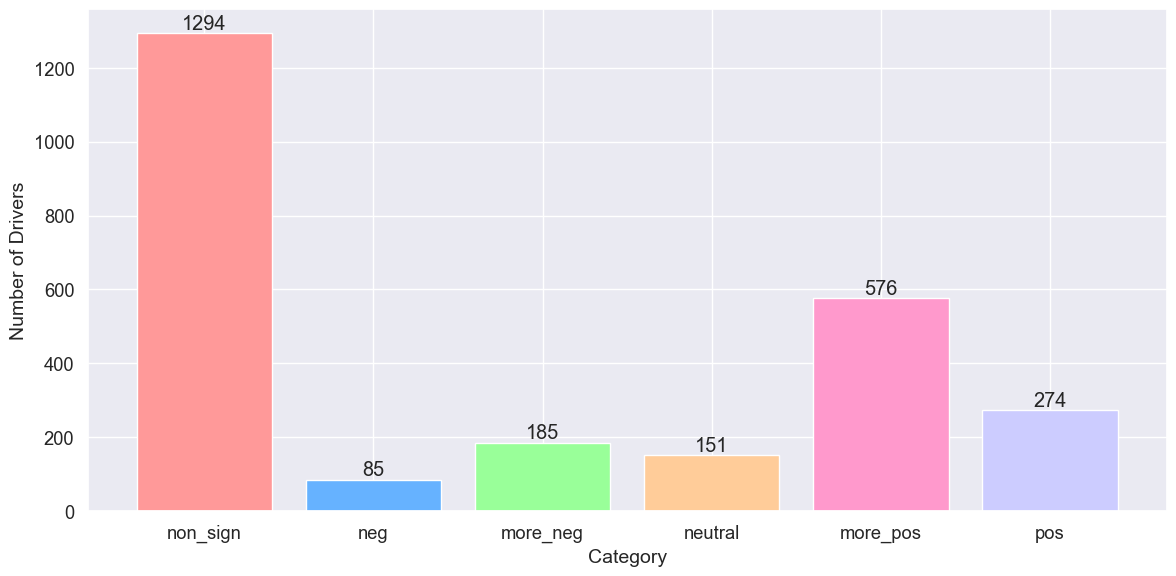


Total number of drivers: 2565


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of drivers in each category from the 'group' column
category_counts = driver_stats['group'].value_counts()
category_order = ['non_sign', 'neg', 'more_neg', 'neutral', 'more_pos', 'pos']
category_counts = category_counts.reindex(category_order).fillna(0)

# Define colors for each category, including 'neutral' and 'non_sign'
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#CCCCFF']  # Colors for 'neutral' and 'non_sign'

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(category_counts.index, category_counts.values, color=colors)

# Customize the plot
#plt.title('Distribution of Drivers Across Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Drivers', fontsize=14)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Add category descriptions
category_descriptions = {
    'non_sign': 'Not Significant',
    'neg': 'Only Negative (Y-axis)',
    'pos': 'Only Positive (X-axis)',
    'more_pos': 'More Positive (Below y=x)',
    'more_neg': 'More Negative (Above y=x)',
    'neutral': 'Equal Positive and Negative'
}

# Add the descriptions to the plot
#plt.text(1.05, 0.5, '\n'.join([f"{k}: {v}" for k, v in category_descriptions.items()]), 
#         transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

# Print the total number of drivers
total_drivers = len(driver_stats)
print(f"\nTotal number of drivers: {total_drivers}")


In [ ]:
#driver_stats.reset_index().to_csv('driver_stats.csv', index=False)
#driver_stats.to_csv('driver_stats.csv', index=False)

#### Separated Groups

In [ ]:
import pandas as pd
from gprofiler import GProfiler

# Configurar GProfiler
gp = GProfiler(return_dataframe=True)

drivers_group_by_classification = {
    category: driver_stats[driver_stats['group'] == category]['driver'].tolist()
    for category in ['non_sign', 'neg', 'pos', 'more_pos', 'more_neg', 'neutral']
}

# Realizar análise de enriquecimento
results_separated = {}
for classification, drivers_list in drivers_group_by_classification.items():
    results_separated[classification] = {}
    for source in sources:
        try:
            results_separated[classification][source] = gp.profile(
                organism='hsapiens',
                query=drivers_list,
                user_threshold=0.05,
                no_evidences=False,
                sources=[source],
                all_results=False,
                domain_scope='annotated',
                background=background,
                significance_threshold_method='fdr'
            )
        except Exception as e:
            print(f"Error in group {classification}, source {source}: {str(e)}")
            results_separated[classification][source] = pd.DataFrame()  # Empty DataFrame if error occurs

""" # Consolidar resultados
consolidated_df = pd.DataFrame()
for group, source_results in results_separated.items():
    for source, df in source_results.items():
        if not df.empty:
            df['Group'] = group
            df['source'] = source
            consolidated_df = pd.concat([consolidated_df, df], ignore_index=True)

# Analisar funções por grupo
functions_by_group = consolidated_df.groupby(['Group', 'source'])['name'].value_counts()
print("Funções mais comuns por grupo e fonte:")
print(functions_by_group) """

' # Consolidar resultados\nconsolidated_df = pd.DataFrame()\nfor group, source_results in results_separated.items():\n    for source, df in source_results.items():\n        if not df.empty:\n            df[\'Group\'] = group\n            df[\'source\'] = source\n            consolidated_df = pd.concat([consolidated_df, df], ignore_index=True)\n\n# Analisar funções por grupo\nfunctions_by_group = consolidated_df.groupby([\'Group\', \'source\'])[\'name\'].value_counts()\nprint("Funções mais comuns por grupo e fonte:")\nprint(functions_by_group) '

In [ ]:
# Consolidar resultados em termos únicos por grupo
consolidated_terms = {}
for group, source_results in results_separated.items():
    df_list = [df[['source', 'name', 'intersection_size', 'query_size', 'term_size', 'effective_domain_size']] for df in source_results.values()]
    consolidated_df = pd.concat(df_list).drop_duplicates(subset='name')
    consolidated_terms[group] = consolidated_df

In [ ]:
# Identificar funções exclusivas por grupo
exclusive_functions_by_group = {}
for group, terms_df in consolidated_terms.items():
    all_functions = set(terms_df['name'])
    unique_functions = all_functions.copy()
    for other_group, other_terms_df in consolidated_terms.items():
        if group != other_group:
            other_functions = set(other_terms_df['name'])
            unique_functions.difference_update(other_functions)
    exclusive_functions_by_group[group] = unique_functions

# Calcular fold enrichment para funções exclusivas
dfs_by_group = {}
for group, unique_functions in exclusive_functions_by_group.items():
    dfs_temp = []
    terms_df = consolidated_terms[group]
    exclusive_functions_in_df = terms_df[terms_df['name'].isin(unique_functions)]
    for index, row in exclusive_functions_in_df.iterrows():
        intersection_size = row['intersection_size']
        query_size = row['query_size']
        term_size = row['term_size']
        effective_domain_size = row['effective_domain_size']
        fold_enrichment = (intersection_size / query_size) / (term_size / effective_domain_size)
        df_temp = pd.DataFrame({'Term_name': [row['name']], 'Fold_Enrichment': [fold_enrichment], 'Source': [row['source']]})
        dfs_temp.append(df_temp)
    
    if dfs_temp:  # Check if there are any DataFrames to concatenate
        df_group = pd.concat(dfs_temp, ignore_index=True)
        df_group = df_group.sort_values(by='Fold_Enrichment', ascending=False)
        dfs_by_group[group] = df_group
    else:
        print(f"No exclusive functions with fold enrichment data for group {group}")

# Print results
for group, df_group in dfs_by_group.items():
    print(f"\nDataFrame for group {group}:")
    print(df_group)


DataFrame for group non_sign:
                                            Term_name  Fold_Enrichment Source
43  positive regulation of serine-type peptidase a...        15.771739  GO:BP
42  positive regulation of serine-type endopeptida...        15.771739  GO:BP
58       regulation of serine-type peptidase activity        11.828804  GO:BP
54  negative regulation of mesenchymal cell apopto...        11.828804  GO:BP
19                      decanoate-CoA ligase activity        11.828804  GO:MF
..                                                ...              ...    ...
48  adenylate cyclase-modulating G protein-coupled...         1.890002  GO:BP
21  secondary active transmembrane transporter act...         1.777905  GO:MF
24                   external side of plasma membrane         1.738283  GO:CC
85            Neuroactive ligand-receptor interaction         1.708605   KEGG
72       G protein-coupled receptor signaling pathway         1.349767  GO:BP

[103 rows x 3 columns]

DataFram

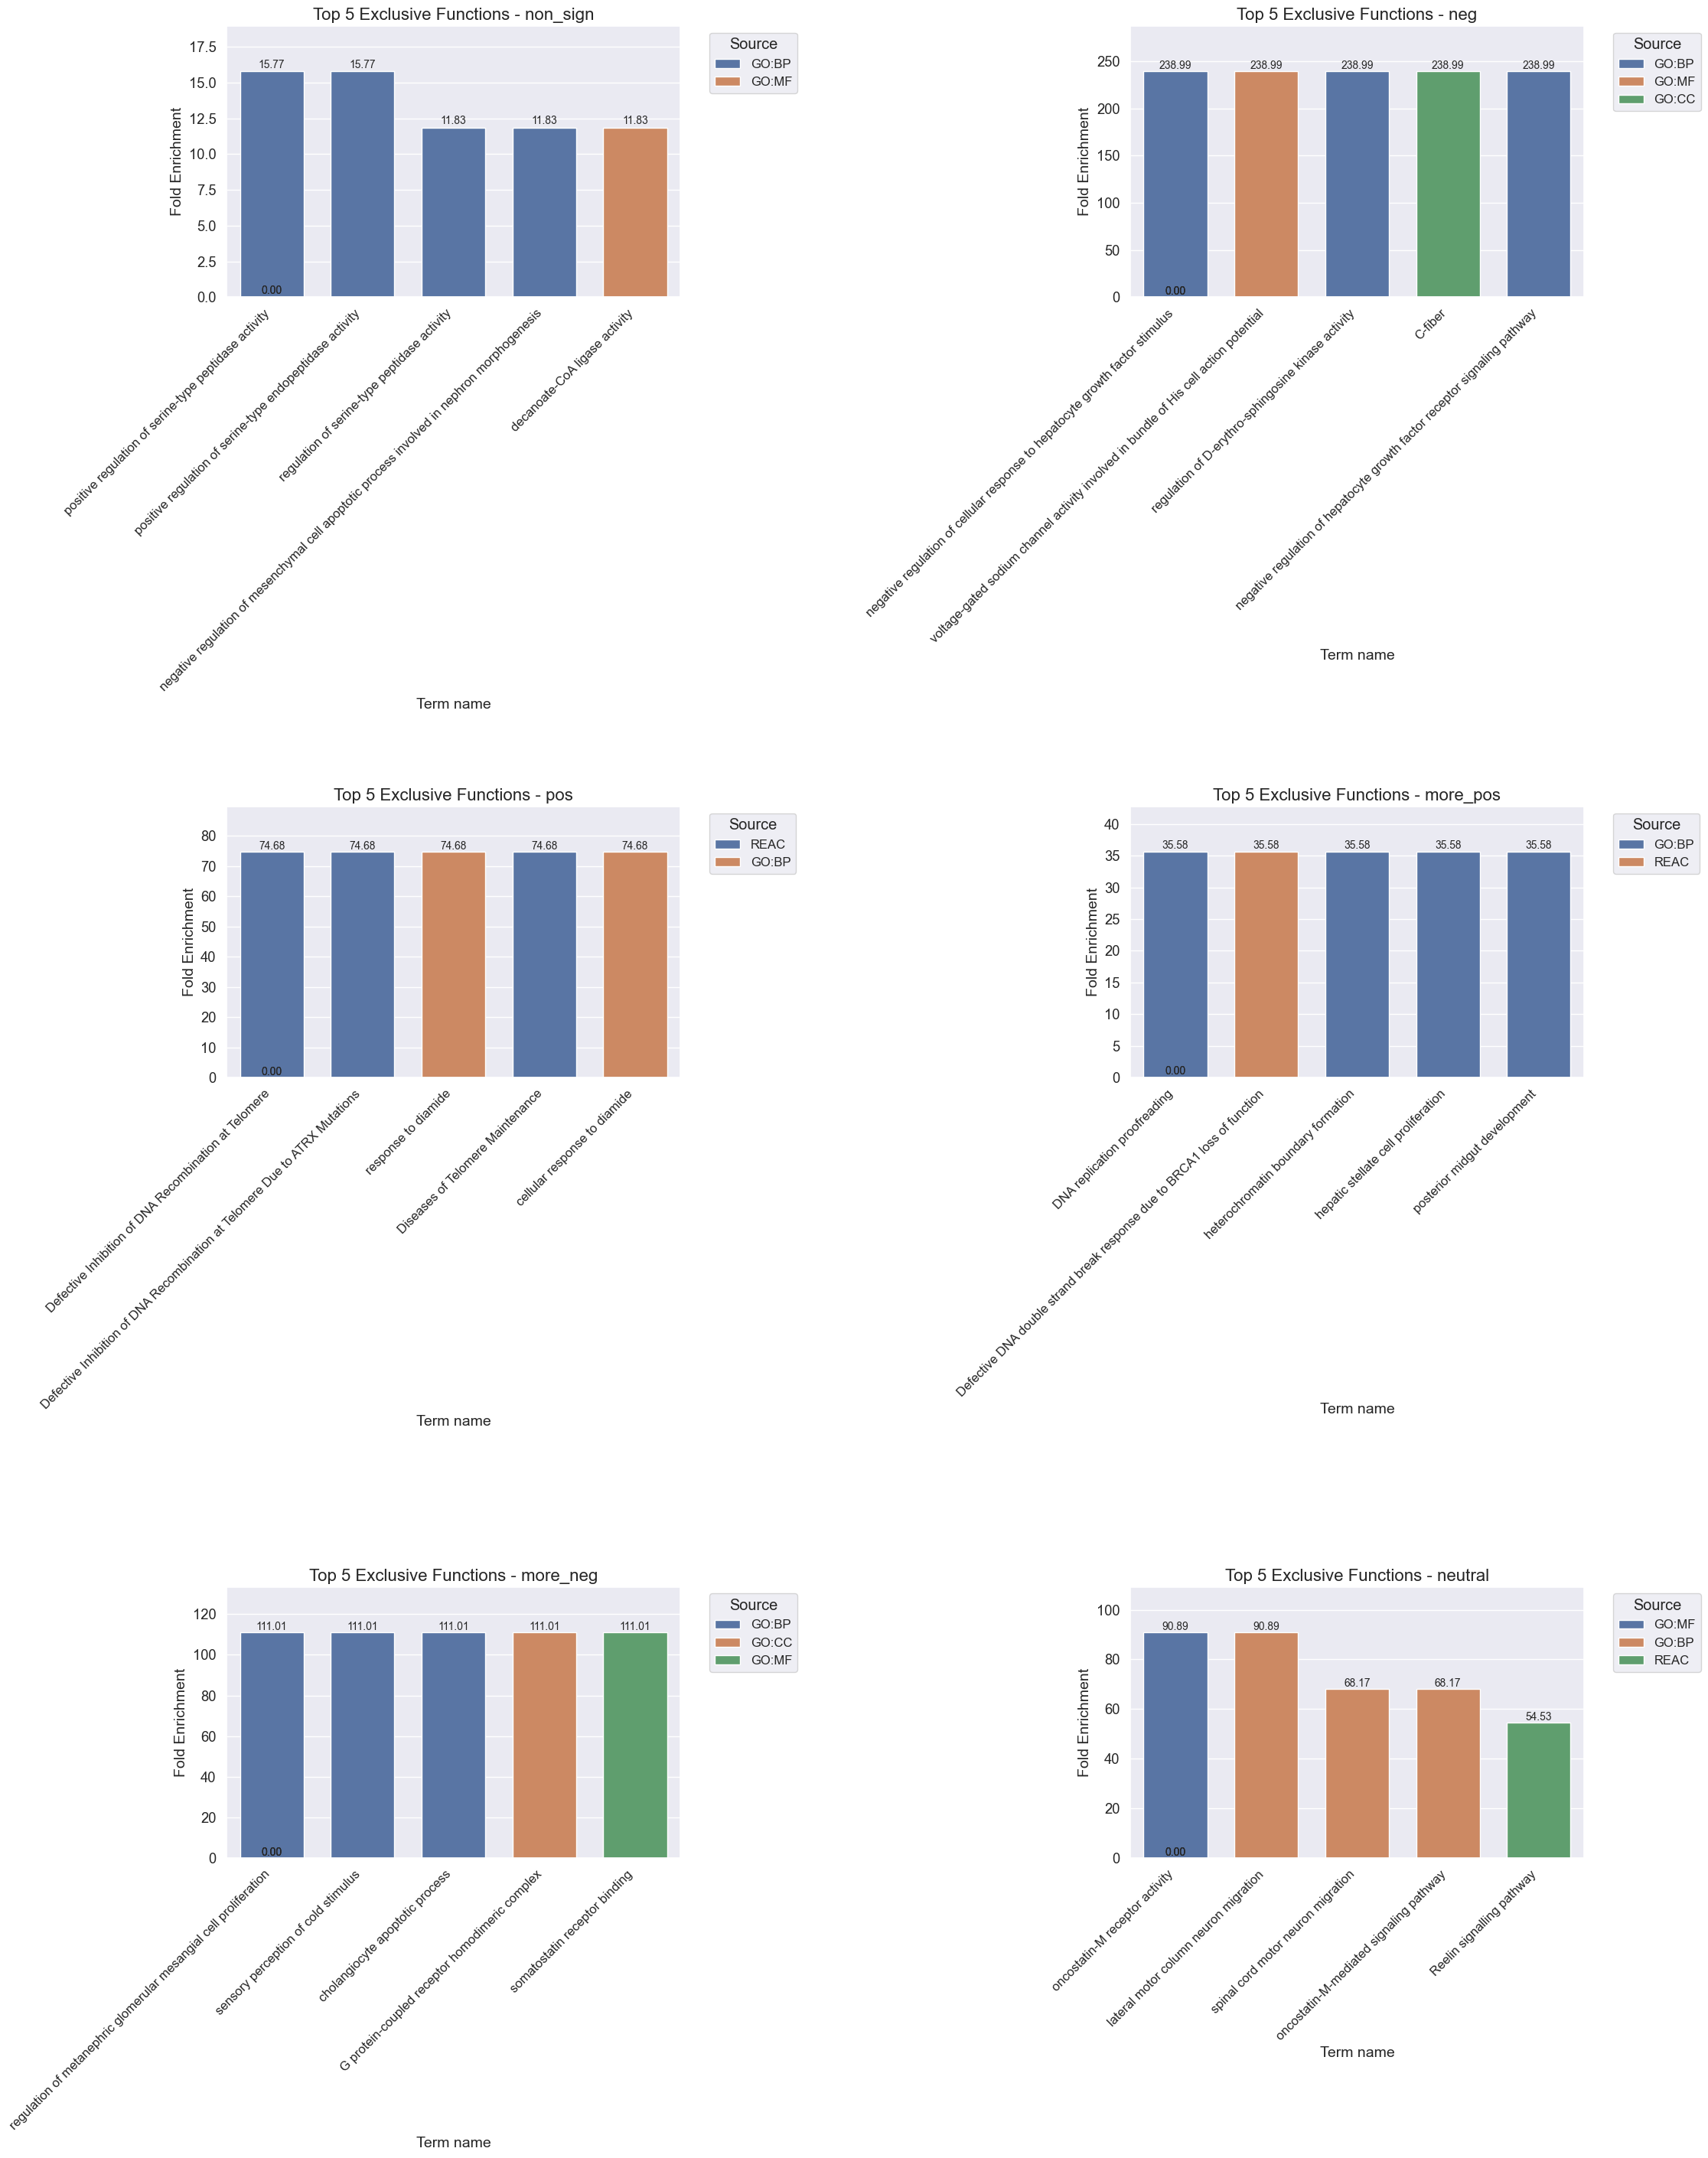

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24, 30))

# Assuming there are 5 groups, adjusting layout
for i, (group, df) in enumerate(dfs_by_group.items()):
    ax = plt.subplot(3, 2, i+1)
    
    top_5_df = df.head(5)
    
    # Plotting vertical bars
    bar_plot = sns.barplot(x='Term_name', y='Fold_Enrichment', data=top_5_df, hue='Source', dodge=False, ax=ax, width=0.7)
    
    plt.title(f'Top 5 Exclusive Functions - {group}', fontsize=16)
    plt.xlabel('Term name', fontsize=14)
    plt.ylabel('Fold Enrichment', fontsize=14)
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    
    plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    plt.ylim(0, df['Fold_Enrichment'].max() * 1.2)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.1, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout(pad=5.0)
plt.show()

#### All Groups

In [ ]:
driver_stats = pd.read_csv('driver_stats.csv', index_col='driver')
driver_stats

n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group
driver                                                                  
A1CF              39          0          0  0.000000  0.000000  non_sign
A2ML1             91          4          3  0.043956  0.032967  more_pos
ABCA10             5          0          0  0.000000  0.000000  non_sign
ABCA13             9          3          1  0.333333  0.111111  more_pos
ABCA7             16          0          0  0.000000  0.000000  non_sign
...              ...        ...        ...       ...       ...       ...
ZSWIM3             6          0          0  0.000000  0.000000  non_sign
ZSWIM6            22          0          0  0.000000  0.000000  non_sign
ZWILCH            22          1          0  0.045455  0.000000  non_sign
ZWINT            136         22          0  0.161765  0.000000       pos
ZZEF1             89          8          2  0.089888  0.022472  more_pos

[2565 rows x 6 columns]

In [ ]:
""" import pandas as pd
from gprofiler import GProfiler
import ast
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configurar GProfiler
gp = GProfiler(return_dataframe=True)
sources = ["GO:MF", "GO:CC", "GO:BP", "KEGG", "REAC", "WP", "HP"]

# Mesclar resultsfiltered com driver_stats para obter as categorias
combined_results = combined_results.merge(driver_stats[['new_category']], left_on='driver', right_index=True, how='left')

# Obter drivers únicos de resultsfiltered
all_drivers = combined_results['driver'].unique().tolist()

# Criar um dicionário para mapear drivers para suas categorias
driver_category_map = combined_results.set_index('driver')['new_category'].to_dict()

def process_source(source):
    results = gp.profile(
        organism='hsapiens',
        query=all_drivers,
        user_threshold=0.05,
        no_evidences=False,
        sources=[source],
        all_results=False,
        domain_scope='annotated',
        background=background,
        significance_threshold_method='fdr'
    )
    
    results['fold_enrichment'] = (
        results['effective_domain_size'] * results['intersection_size'] / 
        (results['term_size'] * results['query_size'])
    )
    
    results_list = []
    for _, row in results.iterrows():
        genes = ast.literal_eval(row['intersections']) if isinstance(row['intersections'], str) else row['intersections']
        
        category_counts = {'D0': 0, 'D1': 0, 'D2': 0, 'D3': 0, 'D4': 0}
        for gene in genes:
            category = driver_category_map.get(gene)
            if pd.notna(category):
                category_counts[category] += 1
        
        results_list.append({
            'Source': row['source'],
            'Name': row['name'],
            'FE': row['fold_enrichment'],
            **category_counts
        })
    
    return pd.DataFrame(results_list)

# Usar ThreadPoolExecutor para processar fontes em paralelo
with ThreadPoolExecutor(max_workers=len(sources)) as executor:
    future_to_source = {executor.submit(process_source, source): source for source in sources}
    results_df = []
    for future in as_completed(future_to_source):
        results_df.append(future.result())

final_results_df = pd.concat(results_df, ignore_index=True) """
import pandas as pd
from gprofiler import GProfiler
import ast
from concurrent.futures import ThreadPoolExecutor, as_completed

gp = GProfiler(return_dataframe=True)
#sources = ["GO:MF", "GO:CC", "GO:BP", "KEGG", "REAC", "WP"]

all_drivers = driver_stats.index.tolist()

driver_category_map = driver_stats['group'].to_dict()

def process_source(source):
    results = gp.profile(
        organism='hsapiens',
        query=all_drivers,
        user_threshold=0.05,
        no_evidences=False,
        sources=[source],
        all_results=False,
        domain_scope='annotated',
        background=background,
        significance_threshold_method='fdr'
    )
    
    results['fold_enrichment'] = (
        results['effective_domain_size'] * results['intersection_size'] / 
        (results['term_size'] * results['query_size'])
    )
    
    results_list = []
    for _, row in results.iterrows():
        genes = ast.literal_eval(row['intersections']) if isinstance(row['intersections'], str) else row['intersections']
        
        category_counts = {'non_sign': 0, 'neg': 0, 'more_neg': 0, 'more_pos': 0, 'pos': 0, 'neutral': 0}
        for gene in genes:
            category = driver_category_map.get(gene)
            if pd.notna(category):
                category_counts[category] += 1
        
        results_list.append({
            'Source': row['source'],
            'Name': row['name'],
            'FE': row['fold_enrichment'],
            'native': row['native'],
            'intersections': genes,
            'description': row['description'],              
            **category_counts
        })
    
    return pd.DataFrame(results_list)

with ThreadPoolExecutor(max_workers=len(sources)) as executor:
    future_to_source = {executor.submit(process_source, source): source for source in sources}
    results_df = []
    for future in as_completed(future_to_source):
        results_df.append(future.result())

final_results_df = pd.concat(results_df, ignore_index=True)
display(final_results_df)

Source                                               Name        FE  \
0      KEGG                                     KEGG root term  1.341649   
1      KEGG                                 Pathways in cancer  2.798705   
2      KEGG                                    Prostate cancer  4.602696   
3      KEGG                            Proteoglycans in cancer  3.321886   
4      KEGG                     Human papillomavirus infection  2.705828   
...     ...                                                ...       ...   
4616  GO:BP        regulation of biomineral tissue development  1.657654   
4617  GO:BP                multi-organism reproductive process  1.445998   
4618  GO:BP  positive regulation of pattern recognition rec...  1.839814   
4619  GO:BP                      megakaryocyte differentiation  1.839814   
4620  GO:BP  negative regulation of actin filament polymeri...  1.839814   

          native                                      intersections  \
0     KEGG:00000  [ABCA10, ABCA13, ABCA7, ABCB1, ABCB5, ABCC3, A...   
1     KEGG:05200  [ABL1, ADCY1, ADCY2, ADCY3, ADCY5, ADCY8, AKT1...   
2     KEGG:05215  [AKT1, AKT2, AKT3, AR, ARAF, BCL2, BRAF, CCND1...   
3     KEGG:05205  [ACTB, ACTG1, AKT1, AKT2, AKT3, ANK1, ANK2, AN...   
4     KEGG:05165  [AKT1, AKT2, AKT3, APC, ATM, ATP6AP1, ATP6V1B2...   
...          ...                                                ...   
4616  GO:0070167  [ACVR1, ACVR2A, BCOR, BMP7, BMPR2, DDR2, FBN2,...   
4617  GO:0044703  [A1CF, ACE, ACVR1B, ACVR2A, AKT1, AR, ASH1L, B...   
4618  GO:0062208  [ANKRD17, BRCC3, BTK, CD36, DDX3X, DHX58, LBP,...   
4619  GO:0030219  [ABI1, EP300, FLI1, FLNA, GATA2, KIT, MAF, MED...   
4620  GO:0030837  [ADD2, ADD3, FLII, SCIN, SLIT2, SPTA1, SPTAN1,...   

                                            description  non_sign  neg  \
0                                        KEGG root term       598   51   
1                                    Pathways in cancer        46    8   
2                                       Prostate cancer        16    1   
3                               Proteoglycans in cancer        21    2   
4                        Human papillomavirus infection        27    5   
...                                                 ...       ...  ...   
4616  "Any process that modulates the frequency, rat...         8    1   
4617  "A biological process that directly contribute...        17    1   
4618  "Any process that decreases the rate, frequenc...         6    0   
4619  "The process in which a myeloid precursor cell...         5    0   
4620  "Any process that stops, prevents, or reduces ...         2    1   

      more_neg  more_pos  pos  neutral  
0          137       352  140       92  
1           40        66   12       13  
2           16        17    4        2  
3           25        26    6        5  
4           29        33    6       12  
...        ...       ...  ...      ...  
4616         5         6    0        1  
4617         4         7    5        3  
4618         1         6    1        1  
4619         2         6    1        1  
4620         2         5    2        3  

[4621 rows x 12 columns]

In [ ]:
final_results_df['Source'].value_counts()

Source
GO:BP    2800
REAC      607
GO:MF     385
WP        366
GO:CC     271
KEGG      192
Name: count, dtype: int64

In [ ]:
final_results_df.to_csv('enrichment_results.csv', index=False)

In [ ]:
all_intersections_set_drivers = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = final_results_df[final_results_df['Source'] == source]
        dic_filt_drivers = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extrai os valores da coluna 'intersections' e os adiciona ao conjunto all_intersections_set
        for intersection_list in dic_filt_drivers['intersections']:
            all_intersections_set_drivers.update(intersection_list)

count_only_drivers_in_intersections = sum(1 for item in all_drivers if item in all_intersections_set_drivers)

print(f"Número de valores de all_drivers que aparecem nas interseções: {count_only_drivers_in_intersections}")
proportion = count_only_drivers_in_intersections / len(all_drivers) 
print(f"Proporção de valores que aparecem nas interseções: {proportion}")

Número de valores de all_drivers que aparecem nas interseções: 1436
Proporção de valores de only_pos que aparecem nas interseções: 0.5598440545808967


Distribution of hallmark-related drivers across categories:
non_sign: 592 drivers (41.23%)
neg: 56 drivers (3.90%)
more_neg: 134 drivers (9.33%)
neutral: 97 drivers (6.75%)
more_pos: 395 drivers (27.51%)
pos: 162 drivers (11.28%)


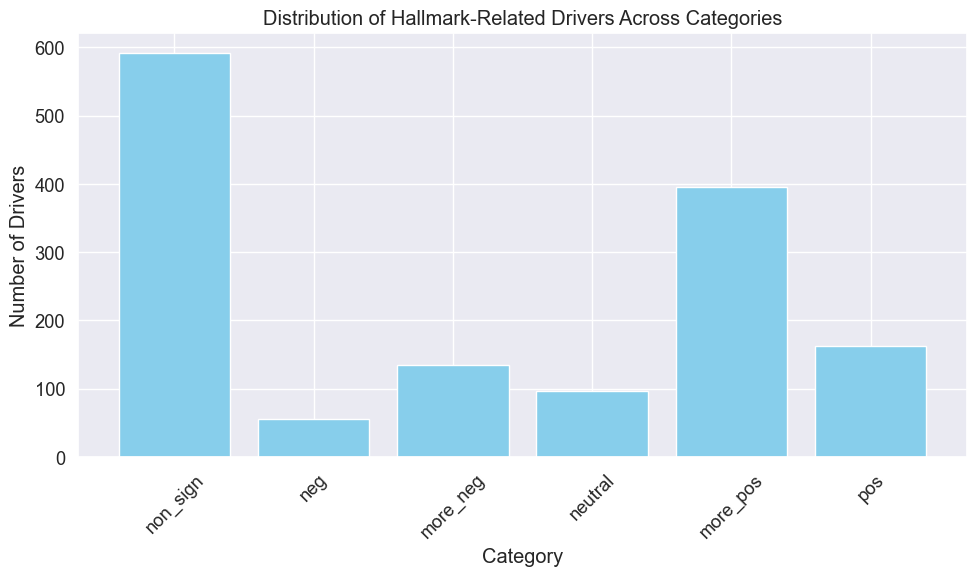

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Filter hallmark drivers from driver_stats
hallmark_drivers = set(all_intersections_set_drivers)

# Step 2: Filter driver_stats to include only hallmark-related drivers
hallmark_driver_stats = driver_stats[driver_stats.index.isin(hallmark_drivers)]

# Step 3: Create a dictionary to store the category counts
category_counts = hallmark_driver_stats['group'].value_counts().to_dict()

# Step 4: Fill in missing categories with zero counts (if needed)
category_order = ['non_sign', 'neg', 'more_neg', 'neutral', 'more_pos', 'pos']
category_counts_ordered = {category: category_counts.get(category, 0) for category in category_order}

# Step 5: Calculate the total number of hallmark drivers
total_hallmark_drivers = sum(category_counts_ordered.values())

# Step 6: Calculate percentages
category_percentages = {cat: count / total_hallmark_drivers * 100 for cat, count in category_counts_ordered.items()}

# Step 7: Print the results
print("Distribution of hallmark-related drivers across categories:")
for cat, count in category_counts_ordered.items():
    percentage = category_percentages[cat]
    print(f"{cat}: {count} drivers ({percentage:.2f}%)")

# Step 8: Create a bar plot with the specified category order
plt.figure(figsize=(10, 6))
plt.bar(category_counts_ordered.keys(), category_counts_ordered.values(), color='skyblue')
plt.title("Distribution of Hallmark-Related Drivers Across Categories")
plt.xlabel("Category")
plt.ylabel("Number of Drivers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Proportion of hallmark-related drivers in each category:
non_sign: 45.75% (592 of 1294)
neg: 65.88% (56 of 85)
more_neg: 72.43% (134 of 185)
neutral: 64.24% (97 of 151)
more_pos: 68.58% (395 of 576)
pos: 59.12% (162 of 274)


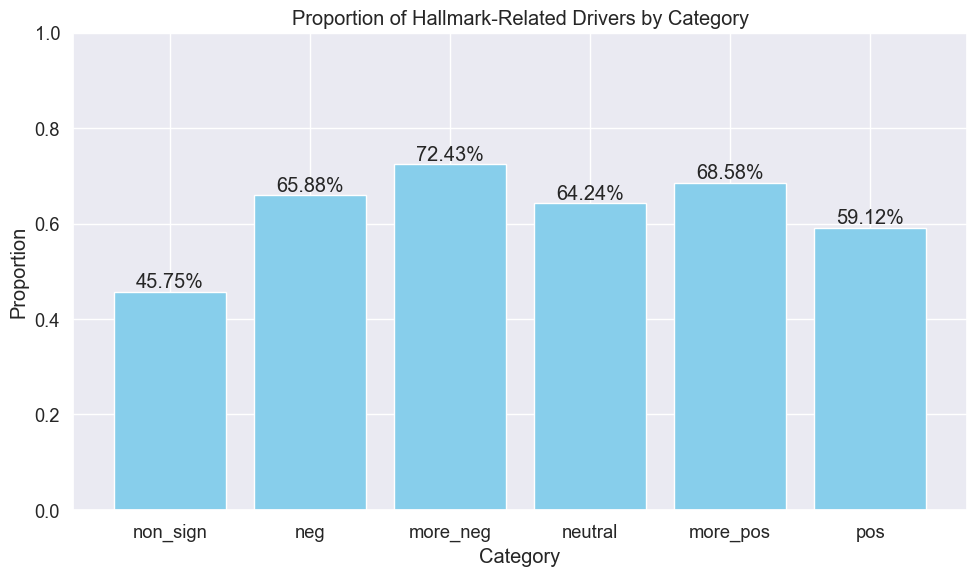

In [ ]:
# Step 1: Create dictionaries to store counts for each category
category_counts = {cat: 0 for cat in category_order}
hallmark_category_counts = {cat: 0 for cat in category_order}

# Step 2: Count the drivers in each category and the hallmark drivers
for driver in driver_stats.index:
    category = driver_stats.loc[driver, 'group']
    if pd.notna(category):
        category_counts[category] += 1
        if driver in hallmark_drivers:
            hallmark_category_counts[category] += 1

# Step 3: Calculate proportions
proportions = {}
for category in category_counts.keys():
    total = category_counts[category]
    hallmark = hallmark_category_counts[category]
    proportion = hallmark / total if total > 0 else 0
    proportions[category] = proportion

# Step 4: Print results
print("Proportion of hallmark-related drivers in each category:")
for category, proportion in proportions.items():
    print(f"{category}: {proportion:.2%} ({hallmark_category_counts[category]} of {category_counts[category]})")

# Step 5: Create bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(proportions.keys(), proportions.values(), color='skyblue')
plt.title("Proportion of Hallmark-Related Drivers by Category")
plt.xlabel("Category")
plt.ylabel("Proportion")
plt.ylim(0, 1)

# Add value labels on top of each bar
for i, (category, proportion) in enumerate(proportions.items()):
    plt.text(i, proportion, f'{proportion:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



Comparison of distributions:
Category | Hallmark Drivers % | All Drivers %
---------|---------------------|---------------
non_sign |              45.75 |         50.45
neg      |              65.88 |          3.31
more_neg |              72.43 |          7.21
neutral  |              64.24 |          5.89
more_pos |              68.58 |         22.46
pos      |              59.12 |         10.68

Enrichment of hallmark drivers in each category:
non_sign: 0.91
neg: 19.88
more_neg: 10.04
neutral: 10.91
more_pos: 3.05
pos: 5.53


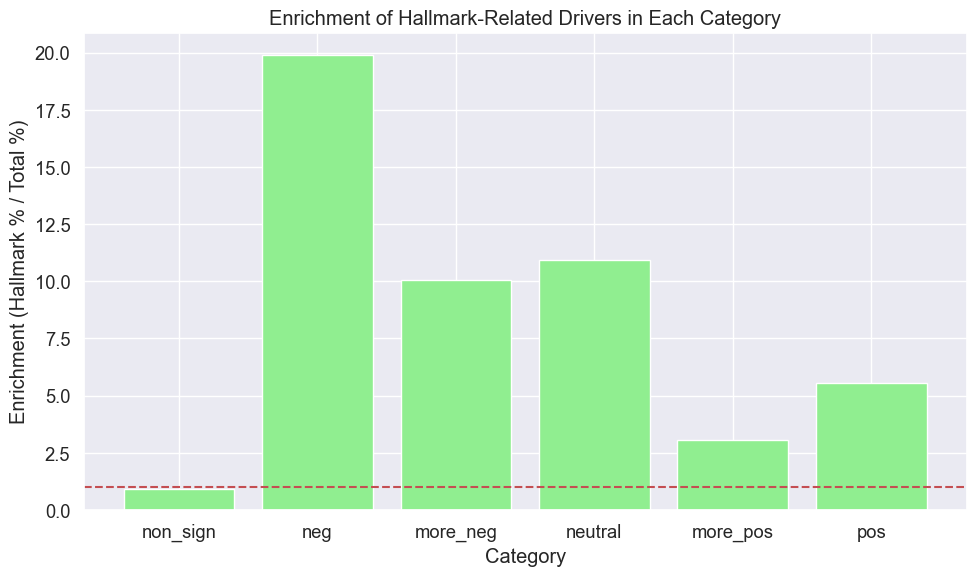

In [ ]:
# Step 1: Count total drivers in each category
total_category_counts = driver_stats['group'].value_counts().to_dict()

# Step 2: Calculate percentages for all drivers
total_drivers = sum(total_category_counts.values())
total_category_percentages = {cat: count / total_drivers * 100 for cat, count in total_category_counts.items()}

print("\nComparison of distributions:")
print("Category | Hallmark Drivers % | All Drivers %")
print("---------|---------------------|---------------")
for cat in category_order:
    hallmark_percent = proportions.get(cat, 0) * 100
    total_percent = total_category_percentages.get(cat, 0)
    print(f"{cat:8} | {hallmark_percent:18.2f} | {total_percent:13.2f}")

# Step 3: Calculate enrichment of hallmark drivers
enrichment = {cat: (proportions.get(cat, 0) / (total_category_percentages.get(cat, 1) / 100)) for cat in category_order}

print("\nEnrichment of hallmark drivers in each category:")
for cat, enrich in enrichment.items():
    print(f"{cat}: {enrich:.2f}")

# Step 4: Create a bar plot for enrichment
plt.figure(figsize=(10, 6))
plt.bar(enrichment.keys(), enrichment.values(), color='lightgreen')
plt.title("Enrichment of Hallmark-Related Drivers in Each Category")
plt.xlabel("Category")
plt.ylabel("Enrichment (Hallmark % / Total %)")
plt.axhline(y=1, color='r', linestyle='--')
plt.tight_layout()
plt.show()


### Fisher's exact test 

In [ ]:
#no fisher exact test usar os que obtive distribuição não homogénea para fazer clustering dos GO terms para semelhança semântica
#fazer clustering dos GO terms para semelhança semântica (agrupar os termos de acordo com a semelhança dos genes)
#calcular a cada 2 termos uma medida de overlap dos genes (jacard ou overlap coefficient) e fazer um dendrograma ou clustering hierárquico
#ver quais não têm uma distribuição proporcional entre essas categorias de drivers

In [ ]:
driver_stats = pd.read_csv('driver_stats.csv', index_col='driver')
driver_stats

n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group
driver                                                                  
A1CF              39          0          0  0.000000  0.000000  non_sign
A2ML1             91          4          3  0.043956  0.032967  more_pos
ABCA10             5          0          0  0.000000  0.000000  non_sign
ABCA13             9          3          1  0.333333  0.111111  more_pos
ABCA7             16          0          0  0.000000  0.000000  non_sign
...              ...        ...        ...       ...       ...       ...
ZSWIM3             6          0          0  0.000000  0.000000  non_sign
ZSWIM6            22          0          0  0.000000  0.000000  non_sign
ZWILCH            22          1          0  0.045455  0.000000  non_sign
ZWINT            136         22          0  0.161765  0.000000       pos
ZZEF1             89          8          2  0.089888  0.022472  more_pos

[2565 rows x 6 columns]

In [ ]:
final_results_df = pd.read_csv('enrichment_results.csv')

In [ ]:
combined_stat = pd.read_csv("combined_statistical_results.csv")
combined_stat_sig = combined_stat[combined_stat['adjusted.p.value'] < 0.05].copy() 
print(len(combined_stat_sig))
significant_terms = combined_stat_sig['Name'].tolist()
combined_stat_sig = final_results_df.merge(combined_stat_sig, on=['Name', 'Source'], how='inner')
print(len(combined_stat_sig))

2364
2364


In [ ]:
combined_stat_sig

Source                                               Name        FE  \
0      KEGG                                     KEGG root term  1.341649   
1      KEGG                                 Pathways in cancer  2.798705   
2      KEGG                                    Prostate cancer  4.602696   
3      KEGG                            Proteoglycans in cancer  3.321886   
4      KEGG                     Human papillomavirus infection  2.705828   
...     ...                                                ...       ...   
2359  GO:BP          early endosome to late endosome transport  2.088043   
2360  GO:BP  modification-dependent macromolecule catabolic...  1.246519   
2361  GO:BP             protein localization to cell periphery  1.328755   
2362  GO:BP    positive regulation of adaptive immune response  1.581851   
2363  GO:BP  negative regulation of actin filament polymeri...  1.839814   

          native                                      intersections  \
0     KEGG:00000  ['ABCA10', 'ABCA13', 'ABCA7', 'ABCB1', 'ABCB5'...   
1     KEGG:05200  ['ABL1', 'ADCY1', 'ADCY2', 'ADCY3', 'ADCY5', '...   
2     KEGG:05215  ['AKT1', 'AKT2', 'AKT3', 'AR', 'ARAF', 'BCL2',...   
3     KEGG:05205  ['ACTB', 'ACTG1', 'AKT1', 'AKT2', 'AKT3', 'ANK...   
4     KEGG:05165  ['AKT1', 'AKT2', 'AKT3', 'APC', 'ATM', 'ATP6AP...   
...          ...                                                ...   
2359  GO:0045022  ['ATG14', 'EZR', 'FLNA', 'KIF16B', 'MAP2K1', '...   
2360  GO:0043632  ['AKT1', 'APC', 'ARAF', 'ASCC2', 'ASCC3', 'ATX...   
2361  GO:1990778  ['ACTB', 'ADAM10', 'ADAM22', 'ADIPOQ', 'AKT1',...   
2362  GO:0002821  ['B2M', 'BTK', 'C3', 'CD1A', 'CD1B', 'CD1D', '...   
2363  GO:0030837  ['ADD2', 'ADD3', 'FLII', 'SCIN', 'SLIT2', 'SPT...   

                                            description  non_sign  neg  \
0                                        KEGG root term       598   51   
1                                    Pathways in cancer        46    8   
2                                       Prostate cancer        16    1   
3                               Proteoglycans in cancer        21    2   
4                        Human papillomavirus infection        27    5   
...                                                 ...       ...  ...   
2359  "The directed movement of substances, in membr...         2    0   
2360  "The chemical reactions and pathways resulting...        22    4   
2361  "A process in which a protein is transported t...        13    3   
2362  "Any process that activates or increases the f...         9    3   
2363  "Any process that stops, prevents, or reduces ...         2    1   

      more_neg  more_pos  pos  neutral   p.value  adjusted.p.value  \
0          137       352  140       92  0.000500          0.001899   
1           40        66   12       13  0.000500          0.001899   
2           16        17    4        2  0.000500          0.001899   
3           25        26    6        5  0.000500          0.001899   
4           29        33    6       12  0.000500          0.001899   
...        ...       ...  ...      ...       ...               ...   
2359         1         8    0        0  0.013493          0.029748   
2360        12        36   14        8  0.000500          0.001899   
2361        17        20    3        4  0.000500          0.001899   
2362         0        11    2        0  0.017991          0.037432   
2363         2         5    2        3  0.009495          0.022239   

      chi_square_p.value  cramers_v  
0               0.000500   0.174214  
1               0.000500   0.200505  
2               0.000500   0.132204  
3               0.000500   0.171601  
4               0.000500   0.180474  
...                  ...        ...  
2359            0.015992   0.081322  
2360            0.001000   0.110917  
2361            0.000500   0.144788  
2362            0.021489   0.077705  
2363            0.048976   0.066710  

[2364 rows x 16 columns]

In [ ]:
combined_stat_sig
#ver o valor máximo em cramers_v 
combined_stat_sig['cramers_v'].max()    

0.282057352896099

In [ ]:
# Sort by Fold Enrichment and Cramer's V
top_fe = combined_stat_sig.sort_values('FE', ascending=False).head(20)
top_cv = combined_stat_sig.sort_values('cramers_v', ascending=False).head(20)

# Function to calculate distribution across all categories (including neutral)
def calculate_distribution(row):
    total = row['non_sign'] + row['neg'] + row['pos'] + row['more_pos'] + row['more_neg'] + row['neutral']
    return [
        row['non_sign'] / total, 
        row['neg'] / total, 
        row['pos'] / total, 
        row['more_pos'] / total, 
        row['more_neg'] / total,
        row['neutral'] / total
    ]

# Add distribution column
combined_stat_sig['distribution'] = combined_stat_sig.apply(calculate_distribution, axis=1)

# Function to identify unusual distributions
def is_unusual_distribution(dist, threshold=0.5):
    return np.max(dist) > threshold or np.min(dist) > 0.2

# Filter for unusual distributions
unusual_dist = combined_stat_sig[combined_stat_sig['distribution'].apply(is_unusual_distribution)]


In [ ]:
# Display top results
print("Top 5 terms by Fold Enrichment:")
for _, row in top_fe.head().iterrows():
    print(f"{row['Name']} (FE: {row['FE']:.2f}, Cramer's V: {row['cramers_v']:.3f})")
    print(f"Distribution: N_Sig: {row['non_sign']}, Neg: {row['neg']}, Pos: {row['pos']}, More_Pos: {row['more_pos']}, More_Neg: {row['more_neg']}, Neutral: {row['neutral']}")
    print()

Top 5 terms by Fold Enrichment:
phosphatidylinositol 3-kinase complex, class I (FE: 7.97, Cramer's V: 0.083)
Distribution: N_Sig: 2, Neg: 1, Pos: 1, More_Pos: 0, More_Neg: 3, Neutral: 2

mismatch repair complex (FE: 7.97, Cramer's V: 0.069)
Distribution: N_Sig: 0, Neg: 0, Pos: 1, More_Pos: 5, More_Neg: 1, Neutral: 0

SOS-mediated signalling (FE: 7.97, Cramer's V: 0.102)
Distribution: N_Sig: 0, Neg: 1, Pos: 0, More_Pos: 1, More_Neg: 3, Neutral: 0

1-phosphatidylinositol-3-kinase activity (FE: 7.97, Cramer's V: 0.087)
Distribution: N_Sig: 2, Neg: 1, Pos: 0, More_Pos: 2, More_Neg: 4, Neutral: 1

Loss of Function of SMAD2/3 in Cancer (FE: 7.97, Cramer's V: 0.074)
Distribution: N_Sig: 0, Neg: 0, Pos: 0, More_Pos: 3, More_Neg: 2, Neutral: 0



In [ ]:
print("Top 5 terms by Cramer's V:")
for _, row in top_cv.head().iterrows():
    print(f"{row['Name']} (Cramer's V: {row['cramers_v']:.3f}, FE: {row['FE']:.2f})")
    print(f"Distribution: N_Sig: {row['non_sign']}, Neg: {row['neg']}, Pos: {row['pos']}, More_Pos: {row['more_pos']}, More_Neg: {row['more_neg']}, Neutral: {row['neutral']}")
    print()

Top 5 terms by Cramer's V:
cellular component organization (Cramer's V: 0.282, FE: 1.46)
Distribution: N_Sig: 431, Neg: 46, Pos: 134, More_Pos: 385, More_Neg: 110, Neutral: 80

nuclear lumen (Cramer's V: 0.282, FE: 1.52)
Distribution: N_Sig: 313, Neg: 20, Pos: 131, More_Pos: 322, More_Neg: 64, Neutral: 45

cellular component organization or biogenesis (Cramer's V: 0.280, FE: 1.44)
Distribution: N_Sig: 443, Neg: 46, Pos: 138, More_Pos: 390, More_Neg: 110, Neutral: 81

intracellular non-membrane-bounded organelle (Cramer's V: 0.280, FE: 1.39)
Distribution: N_Sig: 331, Neg: 24, Pos: 126, More_Pos: 334, More_Neg: 85, Neutral: 50

non-membrane-bounded organelle (Cramer's V: 0.280, FE: 1.39)
Distribution: N_Sig: 331, Neg: 24, Pos: 126, More_Pos: 334, More_Neg: 85, Neutral: 50



In [ ]:
print("Top 5 terms with unusual distributions:")
for _, row in unusual_dist.head().iterrows():
    print(f"{row['Name']} (FE: {row['FE']:.2f}, Cramer's V: {row['cramers_v']:.3f})")
    print(f"Distribution: N_Sig: {row['non_sign']}, Neg: {row['neg']}, Pos: {row['pos']}, More_Pos: {row['more_pos']}, More_Neg: {row['more_neg']}, Neutral: {row['neutral']}")
    print()

Top 5 terms with unusual distributions:
Cell cycle (FE: 2.44, Cramer's V: 0.129)
Distribution: N_Sig: 6, Neg: 0, Pos: 10, More_Pos: 26, More_Neg: 4, Neutral: 2

Cortisol synthesis and secretion (FE: 2.49, Cramer's V: 0.097)
Distribution: N_Sig: 11, Neg: 3, Pos: 0, More_Pos: 0, More_Neg: 5, Neutral: 1

Insulin secretion (FE: 2.16, Cramer's V: 0.073)
Distribution: N_Sig: 13, Neg: 2, Pos: 0, More_Pos: 2, More_Neg: 5, Neutral: 1

Fanconi anemia pathway (FE: 2.36, Cramer's V: 0.102)
Distribution: N_Sig: 1, Neg: 0, Pos: 5, More_Pos: 10, More_Neg: 0, Neutral: 0

Spliceosome (FE: 1.77, Cramer's V: 0.105)
Distribution: N_Sig: 6, Neg: 1, Pos: 7, More_Pos: 18, More_Neg: 1, Neutral: 0



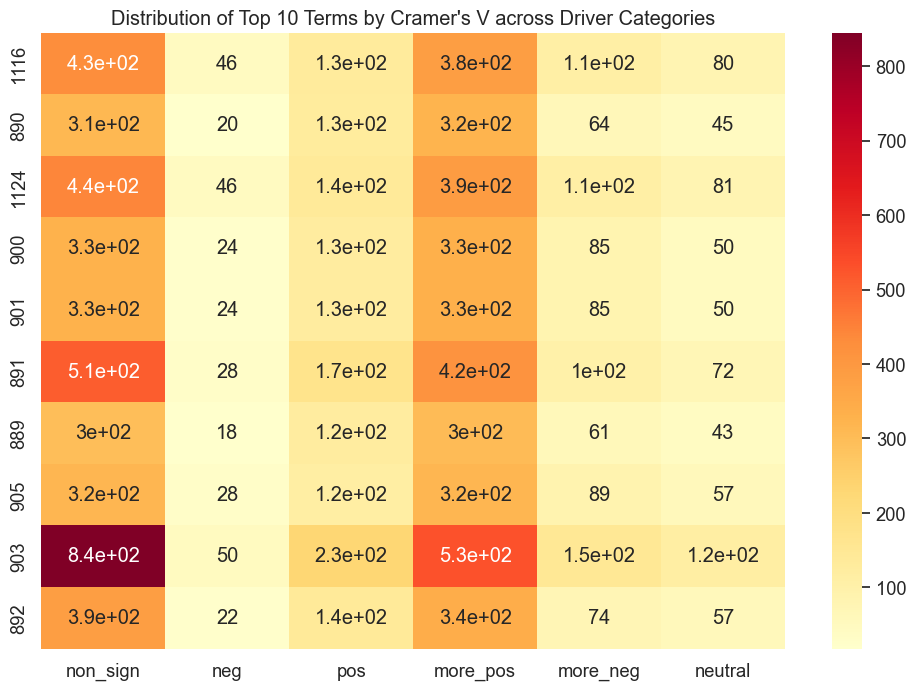

In [ ]:
# Heatmap of top 10 terms by Cramer's V
plt.figure(figsize=(12, 8))
sns.heatmap(
    top_cv.head(10)[['non_sign', 'neg', 'pos', 'more_pos', 'more_neg', 'neutral']], 
    annot=True, cmap='YlOrRd'
)
plt.title('Distribution of Top 10 Terms by Cramer\'s V across Driver Categories')
plt.show()

In [ ]:
#indices = [831, 808, 1019, 1012]  # The row indices from your heatmap
indices = [382]  # The row indices from your heatmap
# Retrieve the term names
terms = combined_stat_sig.loc[indices, 'Name']

print(terms)

382    Signaling by PDGF
Name: Name, dtype: object


#### Agglomerative Clustering 

In [ ]:
jaccard_matrix = np.load("jaccard_matrix.npy")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns

# Function to compute within-cluster sum of squares
def compute_wcss(data, labels, n_clusters):
    wcss = 0
    for i in range(n_clusters):
        cluster_data = data[labels == i]
        cluster_center = cluster_data.mean(axis=0)
        wcss += np.sum((cluster_data - cluster_center) ** 2)
    return wcss

# Function to convert string to set only if it's a string
def convert_to_set(x):
    if isinstance(x, str):
        return set(eval(x))
    return x

# Function to calculate Jaccard Similarity
def jaccard_similarity(genes_i, genes_j):
    return len(genes_i & genes_j) / len(genes_i | genes_j)

# Ensure intersections are properly converted to sets
combined_stat_sig['intersections'] = combined_stat_sig['intersections'].apply(convert_to_set)

# Sort terms by the number of genes in intersections
combined_stat_sig['num_genes'] = combined_stat_sig['intersections'].apply(len)
combined_stat_sig = combined_stat_sig.sort_values('num_genes', ascending=False)

# Initialize the Jaccard similarity matrix
n = len(combined_stat_sig)
jaccard_matrix = np.zeros((n, n))

# Function to compute rows of the Jaccard matrix
def compute_row(i):
    genes_i = combined_stat_sig.iloc[i]['intersections']
    row = np.zeros(n)
    for j in range(i+1, n):
        genes_j = combined_stat_sig.iloc[j]['intersections']
        row[j] = jaccard_similarity(genes_i, genes_j)
    return row

# Calculate Jaccard similarities in parallel
jaccard_matrix = np.array(Parallel(n_jobs=-1)(delayed(compute_row)(i) for i in range(n)))

# Make the matrix symmetric
jaccard_matrix = jaccard_matrix + jaccard_matrix.T

# Save the matrix to ensure it stays consistent across runs (if necessary)
np.save("jaccard_matrix.npy", jaccard_matrix)  # Save once, load in future runs to avoid recalculating

# Elbow method to find the optimal number of clusters
max_clusters = 100
wcss_values = []

for k in range(2, max_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='complete')
    labels = clustering.fit_predict(1 - jaccard_matrix)
    wcss = compute_wcss(jaccard_matrix, labels, k)
    wcss_values.append(wcss)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), wcss_values, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters (Complete Linkage)')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

# Clustering
n_clusters = 93  # Set the number of clusters based on your analysis
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
labels = clustering.fit_predict(1 - jaccard_matrix)

# Add the cluster labels to the dataframe
combined_stat_sig['Cluster'] = labels

# Group the terms by their clusters
clustered_terms = []
for cluster_label in np.unique(labels):
    cluster_terms = combined_stat_sig[combined_stat_sig['Cluster'] == cluster_label]
    term_names = cluster_terms['Name'].tolist()
    combined_genes = set().union(*cluster_terms['intersections'])
    clustered_terms.append({'Cluster': cluster_label, 'Terms': term_names, 'Combined Genes': combined_genes})

# Convert to DataFrame
cluster_df = pd.DataFrame(clustered_terms)

# Calculate total number of drivers per category using the `group` column in driver_stats
total_drivers = driver_stats['group'].value_counts().to_dict()

# Initialize data structure to store cluster information
heatmap_data = []

# Iterate over clusters and calculate category counts and log ratios
for idx, row in cluster_df.iterrows():
    cluster_label = row['Cluster']
    combined_genes = row['Combined Genes']
    num_combined_genes = len(combined_genes)

    # Count the number of drivers in each category for the current cluster
    category_counts = {category: 0 for category in total_drivers.keys()}
    for gene in combined_genes:
        if gene in driver_stats.index:  # Use driver as the index
            category = driver_stats.loc[gene, 'group']
            if category in category_counts:
                category_counts[category] += 1

    # Compute the log-transformed observed/expected ratio for each category
    for category in category_counts.keys():
        observed = category_counts[category]
        expected = total_drivers[category] * (num_combined_genes / len(driver_stats))  # Scale by total drivers
        log_ratio = np.log((observed + 1e-6) / (expected + 1e-6))  # Small value to avoid log(0)
        heatmap_data.append({
            'Cluster': cluster_label,
            'Category': category,
            'LogRatio': log_ratio
        })

# Convert to DataFrame and pivot for heatmap
heatmap_df = pd.DataFrame(heatmap_data)
heatmap_pivot = heatmap_df.pivot(index="Cluster", columns="Category", values="LogRatio")
heatmap_pivot = heatmap_pivot[['non_sign', 'neg', 'more_neg', 'neutral', 'more_pos', 'pos']]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_pivot, annot=False, cmap="RdYlGn", center=0, cbar_kws={'label': 'Log(Observed/Expected) Ratio'})
plt.title(f"Heatmap of Log(Observed/Expected) Ratio for Driver Categories per Cluster (n_clusters={n_clusters})")
plt.show()


In [ ]:
# Identify clusters with extreme values (very low and very high log-ratio values)
extreme_clusters_93 = heatmap_df[(heatmap_df['LogRatio'] <= -10)]
print("Clusters with extreme log-ratio values:")
print(extreme_clusters_93)

Clusters with extreme log-ratio values:
     Cluster Category   LogRatio
80        13      pos -15.586258
82        13  neutral -14.990410
286       47  neutral -13.816291
287       47      neg -13.241663
311       51      neg -13.116500
329       54      neg -13.874185
377       62      neg -14.802898
395       65      neg -14.551583
464       77      pos -14.286976


In [ ]:
# Define the clusters you want to extract terms from
selected_clusters = [13, 47, 51, 54, 62, 65, 77]

# Filter cluster_df to get the relevant clusters
selected_terms_df = cluster_df[cluster_df['Cluster'].isin(selected_clusters)]

# Extract the cluster and terms columns
selected_terms = selected_terms_df[['Cluster', 'Terms']]

# Display the result
print(selected_terms)


    Cluster                                              Terms
13       13  [glomerulus development, cell differentiation ...
47       47  [facultative heterochromatin formation, regula...
51       51  [cortical cytoskeleton organization, cortical ...
54       54  [positive regulation of cell cycle G1/S phase ...
62       62  [Clear cell renal cell carcinoma pathways, cel...
65       65  [nuclear chromosome, condensed nuclear chromos...
77       77  [regulation of hormone metabolic process, estr...


In [ ]:
# Define the clusters you want to extract terms from
selected_clusters = [13, 47, 51, 54, 62, 65, 77]

# Filter cluster_df to get the relevant clusters
selected_terms_df = cluster_df[cluster_df['Cluster'].isin(selected_clusters)]

# Save to a CSV file
file_path = 'selected_clusters_terms.csv'
selected_terms_df[['Cluster', 'Terms']].to_csv(file_path, index=False)

print(f"File saved to: {file_path}")


File saved to: selected_clusters_terms.csv


Converting intersections to sets...
Sorting terms by the number of genes in intersections...
     Source                        Name        FE      native  \
882   GO:MF          molecular_function  1.115832  GO:0003674   
366   GO:CC          cellular_component  1.094036  GO:0005575   
365   GO:CC  cellular anatomical entity  1.103251  GO:0110165   
1096  GO:BP          biological_process  1.125522  GO:0008150   
883   GO:MF                     binding  1.142440  GO:0005488   

                                          intersections  \
882   {CTIF, ANKRD17, ABCB1, HECW2, GAL3ST1, DNER, T...   
366   {CTIF, ANKRD17, ABCB1, URB2, HECW2, GAL3ST1, D...   
365   {CTIF, ANKRD17, ABCB1, URB2, HECW2, GAL3ST1, D...   
1096  {CTIF, ANKRD17, ABCB1, URB2, HECW2, GAL3ST1, D...   
883   {CTIF, ANKRD17, ABCB1, HECW2, DNER, TYSND1, MY...   

                                            description  non_sign  neg  \
882   "A molecular process that can be carried out b...      1243   85   
366   "A loca

/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Jaccard similarity matrix calculation complete.
Jaccard matrix is now symmetric.


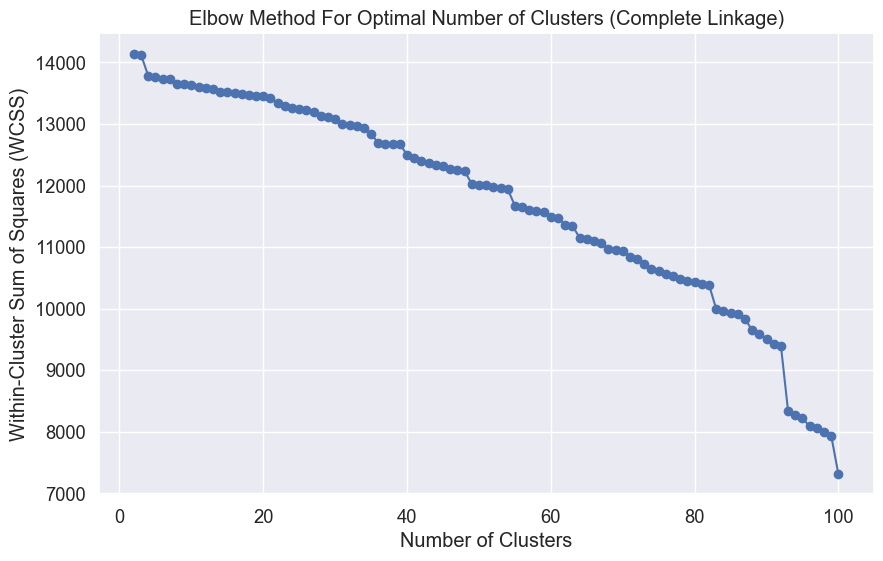

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute within-cluster sum of squares
def compute_wcss(data, labels, n_clusters):
    wcss = 0
    for i in range(n_clusters):
        cluster_data = data[labels == i]
        cluster_center = cluster_data.mean(axis=0)
        wcss += np.sum((cluster_data - cluster_center) ** 2)
    return wcss

# Function to convert string to set only if it's a string
def convert_to_set(x):
    if isinstance(x, str):
        return set(eval(x))
    return x

# Function to calculate Jaccard Similarity
def jaccard_similarity(genes_i, genes_j):
    return len(genes_i & genes_j) / len(genes_i | genes_j)

# Convert `intersections` from string representation to set if necessary
print("Converting intersections to sets...")
combined_stat_sig['intersections'] = combined_stat_sig['intersections'].apply(convert_to_set)

# Sort terms by the number of genes in the intersections
print("Sorting terms by the number of genes in intersections...")
combined_stat_sig['num_genes'] = combined_stat_sig['intersections'].apply(len)
combined_stat_sig = combined_stat_sig.sort_values('num_genes', ascending=False)
print(combined_stat_sig.head())

# Initialize the Jaccard similarity matrix
n = len(combined_stat_sig)
jaccard_matrix = np.zeros((n, n))
print(f"Initialized Jaccard matrix of size {n}x{n}")

# Calculate Jaccard Similarity in parallel
def compute_row(i):
    genes_i = combined_stat_sig.iloc[i]['intersections']
    row = np.zeros(n)
    for j in range(i+1, n):
        genes_j = combined_stat_sig.iloc[j]['intersections']
        row[j] = jaccard_similarity(genes_i, genes_j)
    return row

# Parallelize the computation
print("Calculating Jaccard similarities...")
jaccard_matrix = np.array(Parallel(n_jobs=-1)(delayed(compute_row)(i) for i in range(n)))
print("Jaccard similarity matrix calculation complete.")

# Make the matrix symmetric
jaccard_matrix = jaccard_matrix + jaccard_matrix.T
print("Jaccard matrix is now symmetric.")

# Elbow method to find the optimal number of clusters
max_clusters = 100  # You can increase this number depending on your needs
wcss_values = []

for k in range(2, max_clusters + 1):  # Start from 2 clusters
    clustering = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='complete')
    labels = clustering.fit_predict(1 - jaccard_matrix)
    wcss = compute_wcss(jaccard_matrix, labels, k)
    wcss_values.append(wcss)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), wcss_values, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters (Complete Linkage)')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()


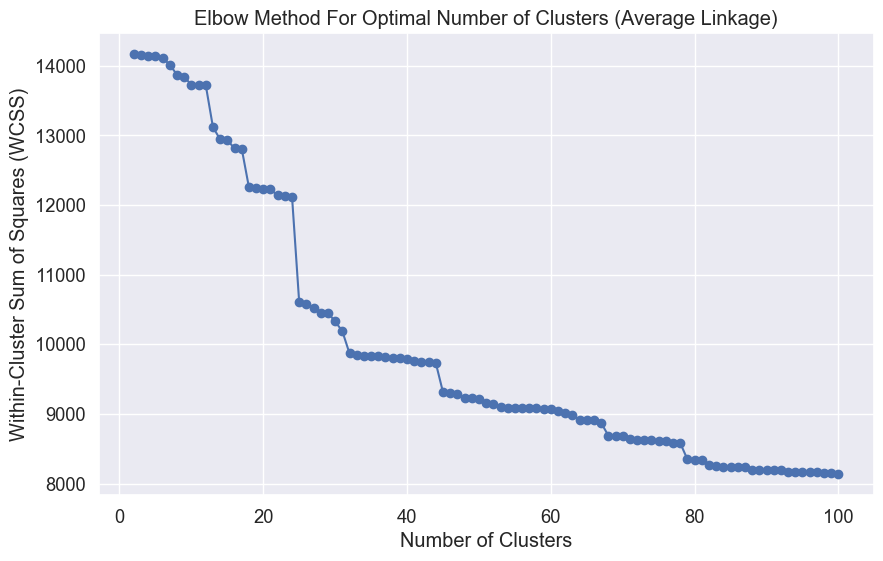

In [ ]:
wcss_values = []

for k in range(2, max_clusters + 1):  # Start from 2 clusters
    clustering = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    labels = clustering.fit_predict(1 - jaccard_matrix)
    wcss = compute_wcss(jaccard_matrix, labels, k)
    wcss_values.append(wcss)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), wcss_values, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters (Average Linkage)')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()


In [ ]:
from scipy.cluster.hierarchy import cophenet, linkage
from scipy.spatial.distance import pdist

# Calculate linkage matrix for the distance matrix using the 'average' linkage method
linkage_matrix = linkage(1 - jaccard_matrix, method='average')

# Calculate the cophenetic correlation coefficient
coph_corr, coph_dist = cophenet(linkage_matrix, pdist(1 - jaccard_matrix))

print(f"Cophenetic Correlation Coefficient (Average Linkage): {coph_corr:.4f}")

# Optionally, repeat for complete linkage or other methods
linkage_matrix_complete = linkage(1 - jaccard_matrix, method='complete')
coph_corr_complete, _ = cophenet(linkage_matrix_complete, pdist(1 - jaccard_matrix))

print(f"Cophenetic Correlation Coefficient (Complete Linkage): {coph_corr_complete:.4f}")


Cophenetic Correlation Coefficient (Average Linkage): 0.8313
Cophenetic Correlation Coefficient (Complete Linkage): 0.6871


Average Linkage: Silhouette Score = -0.9948, Davies-Bouldin Score = 1.8613
Complete Linkage: Silhouette Score = -0.9984, Davies-Bouldin Score = 2.2068


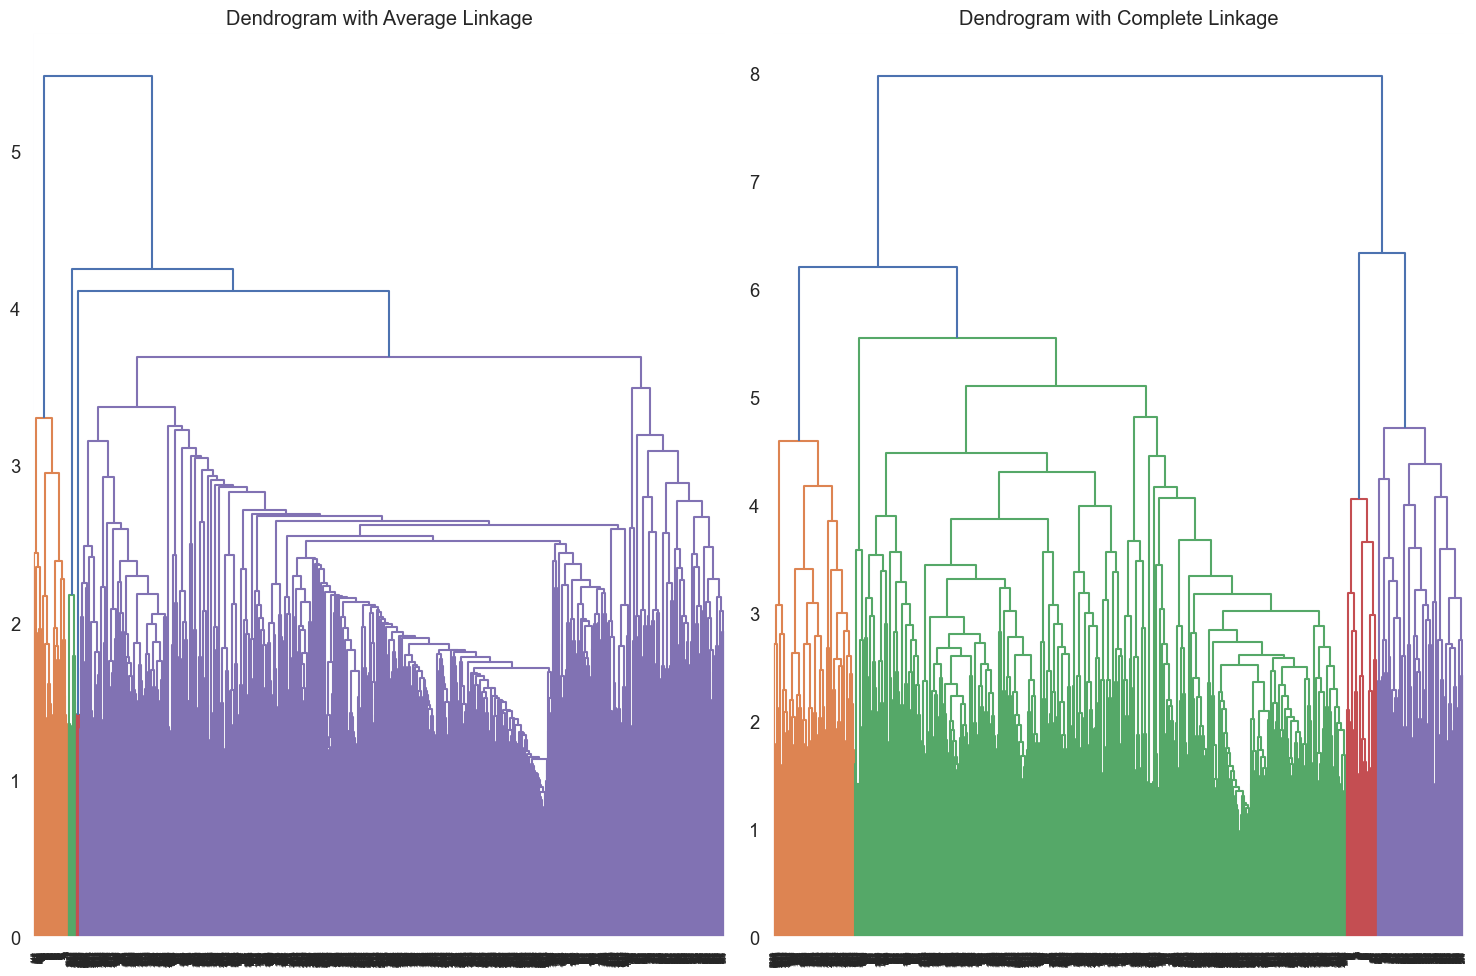

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

#  Function to perform clustering and calculate metrics
def perform_clustering(jaccard_matrix, n_clusters, linkage_method):
    distance_matrix = 1 - jaccard_matrix
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage=linkage_method)
    labels = clustering.fit_predict(distance_matrix)
    silhouette = silhouette_score(jaccard_matrix, labels, metric='precomputed')
    davies_bouldin = davies_bouldin_score(jaccard_matrix, labels)
    return labels, silhouette, davies_bouldin

n_clusters = 100

# Perform clustering with average and complete linkage
labels_avg, silhouette_avg, davies_bouldin_avg = perform_clustering(jaccard_matrix, n_clusters, 'average')
labels_complete, silhouette_complete, davies_bouldin_complete = perform_clustering(jaccard_matrix, n_clusters, 'complete')

print(f"Average Linkage: Silhouette Score = {silhouette_avg:.4f}, Davies-Bouldin Score = {davies_bouldin_avg:.4f}")
print(f"Complete Linkage: Silhouette Score = {silhouette_complete:.4f}, Davies-Bouldin Score = {davies_bouldin_complete:.4f}")

distance_matrix = 1 - jaccard_matrix
# Visual comparison of dendrograms
plt.figure(figsize=(15, 10))
plt.subplot(121)
dendrogram(linkage(distance_matrix, method='average'))
plt.title("Dendrogram with Average Linkage")
plt.subplot(122)
dendrogram(linkage(distance_matrix, method='complete'))
plt.title("Dendrogram with Complete Linkage")
plt.tight_layout()
plt.show()


In [ ]:
driver_stats

n_neighbours  pos_dints  neg_dints   pos_pct   neg_pct     group
driver                                                                  
A1CF              39          0          0  0.000000  0.000000  non_sign
A2ML1             91          4          3  0.043956  0.032967  more_pos
ABCA10             5          0          0  0.000000  0.000000  non_sign
ABCA13             9          3          1  0.333333  0.111111  more_pos
ABCA7             16          0          0  0.000000  0.000000  non_sign
...              ...        ...        ...       ...       ...       ...
ZSWIM3             6          0          0  0.000000  0.000000  non_sign
ZSWIM6            22          0          0  0.000000  0.000000  non_sign
ZWILCH            22          1          0  0.045455  0.000000  non_sign
ZWINT            136         22          0  0.161765  0.000000       pos
ZZEF1             89          8          2  0.089888  0.022472  more_pos

[2565 rows x 6 columns]

Performing Agglomerative Clustering with 93 clusters...
Clustering complete. Cluster labels assigned.
                            Name  Cluster
882           molecular_function       10
366           cellular_component       10
365   cellular anatomical entity       10
1096          biological_process       10
883                      binding       10
Clusters and their terms:
   Cluster                                              Terms  \
0        0  [response to stimulus, multicellular organisma...   
1        1  [molecular adaptor activity, protein-macromole...   
2        2  [external encapsulating structure, extracellul...   
3        3  [supramolecular fiber organization, actin fila...   
4        4  [anchoring junction, calcium ion binding, cell...   

                                      Combined Genes  
0  {CTIF, ANKRD17, ABCB1, URB2, HECW2, GAL3ST1, D...  
1  {ANKRD17, ADAM10, TLR4, SRSF2, PRKACA, MYH9, T...  
2  {NRAS, NPNT, ADAM10, DNER, GATA3, SRPX, PRKACA...  
3  {MAP3K

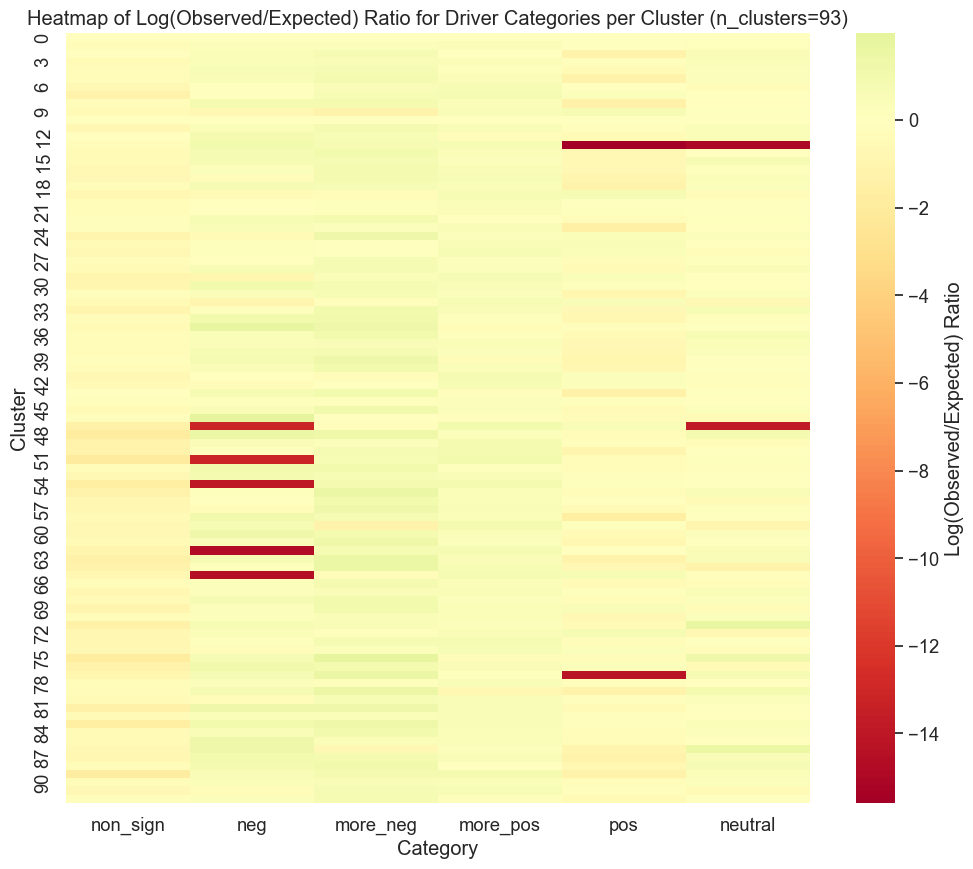

In [ ]:
# Clustering
n_clusters = 93
print(f"Performing Agglomerative Clustering with {n_clusters} clusters...")
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
labels = clustering.fit_predict(1 - jaccard_matrix)  # 1 - jaccard_matrix to convert to distance matrix
print("Clustering complete. Cluster labels assigned.")

# Add the cluster labels to the dataframe
combined_stat_sig['Cluster'] = labels
print(combined_stat_sig[['Name', 'Cluster']].head())

# Group the terms by their clusters
clustered_terms = []
for cluster_label in np.unique(labels):
    cluster_terms = combined_stat_sig[combined_stat_sig['Cluster'] == cluster_label]
    term_names = cluster_terms['Name'].tolist()
    combined_genes = set().union(*cluster_terms['intersections'])
    clustered_terms.append({'Cluster': cluster_label, 'Terms': term_names, 'Combined Genes': combined_genes})

# Convert to DataFrame
cluster_df = pd.DataFrame(clustered_terms)
print("Clusters and their terms:")
print(cluster_df.head())

# Step 2: Calculate total number of drivers per category using the `group` column in driver_stats
print("Calculating total number of drivers per category...")
total_drivers = driver_stats['group'].value_counts().to_dict()
epsilon = 1e-6  # Small value to avoid division by zero in log calculations
print(total_drivers)

# Initialize data structure to store cluster information
heatmap_data = []
print("Building heatmap data...")

# Iterate over clusters and calculate category counts and log ratios
for idx, row in cluster_df.iterrows():
    cluster_label = row['Cluster']
    combined_genes = row['Combined Genes']
    num_combined_genes = len(combined_genes)    
    
    # Count the number of drivers in each category for the current cluster
    category_counts = {category: 0 for category in total_drivers.keys()}
    for gene in combined_genes:
        if gene in driver_stats.index:  # Use driver as the index
            category = driver_stats.loc[gene, 'group']  # Access the 'group' column
            if category in category_counts:
                category_counts[category] += 1
    
    print(f"Cluster {cluster_label} - Category counts: {category_counts}")
    
    # Compute the log-transformed observed/expected ratio for each category
    for category in category_counts.keys():
        observed = category_counts[category]
        expected = total_drivers[category] * (num_combined_genes / len(driver_stats))  # Scale by total drivers
        
        # Add epsilon to avoid log(0)
        log_ratio = np.log((observed + epsilon) / (expected + epsilon))
        
        heatmap_data.append({
            'Cluster': cluster_label,  # Store cluster as integer
            'Category': category,
            'LogRatio': log_ratio
        })

# Step 3: Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data)
print("Heatmap data:")
print(heatmap_df.head())

# Pivot the DataFrame to have clusters as rows and categories as columns
heatmap_pivot = heatmap_df.pivot(index="Cluster", columns="Category", values="LogRatio")

# Ensure clusters are sorted numerically and categories are in the specified order, including 'neutral'
heatmap_pivot = heatmap_pivot.sort_index(ascending=True)
heatmap_pivot = heatmap_pivot[['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']]  # Include 'neutral' in the column order
print("Pivoted heatmap data:")
print(heatmap_pivot.head())

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_pivot, annot=False, cmap="RdYlGn", center=0, cbar_kws={'label': 'Log(Observed/Expected) Ratio'})
plt.title(f"Heatmap of Log(Observed/Expected) Ratio for Driver Categories per Cluster (n_clusters={n_clusters})")
plt.show()


In [ ]:
# Identify clusters with extreme values (very low and very high log-ratio values)
extreme_clusters_93 = heatmap_df[(heatmap_df['LogRatio'] <= -12) | (heatmap_df['LogRatio'] >= 1)]
print("Clusters with extreme log-ratio values:")
print(extreme_clusters_93)

Clusters with extreme log-ratio values:
     Cluster  Category   LogRatio
68        11       pos -15.586258
70        11   neutral -14.990410
71        11       neg   1.009167
153       25  more_neg   1.279431
159       26  more_neg   1.097882
167       27       neg   1.124680
183       30  more_neg   1.313681
213       35  more_neg   1.136454
219       36  more_neg   1.042909
237       39  more_neg   1.023498
243       40  more_neg   1.194273
263       43       neg -13.874185
285       47  more_neg   1.376594
287       47       neg   1.461151
291       48  more_neg   1.459286
311       51       neg   1.017466
315       52  more_neg   1.058760
327       54  more_neg   1.494378
339       56  more_neg   1.264117
345       57  more_neg   1.053821
371       61       neg   1.178585
381       63  more_neg   1.459286
395       65       neg -14.551583
405       67  more_neg   1.455238
423       70  more_neg   1.009449
427       71  more_pos   1.088141
431       71       neg -13.116500
435     

In [ ]:
# Identify clusters with extreme values (very low and very high log-ratio values)
extreme_clusters_75 = heatmap_df[(heatmap_df['LogRatio'] <= -19) | (heatmap_df['LogRatio'] >= 2)]
print("Clusters with extreme log-ratio values:")
print(extreme_clusters_75)

Clusters with extreme log-ratio values:
     Cluster  Category   LogRatio
195       39     N_Sig -21.027067
196       39  More_Pos -20.134479
197       39  More_Neg   2.176001
198       39       Pos -19.471502
224       44       Neg   2.078402
277       55  More_Neg -19.488834
288       57       Pos -19.471502
289       57       Neg   2.301546
307       61  More_Neg -19.488834
315       63     N_Sig -21.027067
316       63  More_Pos -20.134479
319       63       Neg   2.119224
355       71     N_Sig -21.027067
357       71  More_Neg -19.488834
358       71       Pos -19.471502


Converting intersections to sets...
Sorting terms by the number of genes in intersections...
     Source                        Name        FE      native  \
882   GO:MF          molecular_function  1.115832  GO:0003674   
366   GO:CC          cellular_component  1.094036  GO:0005575   
365   GO:CC  cellular anatomical entity  1.103251  GO:0110165   
1096  GO:BP          biological_process  1.125522  GO:0008150   
883   GO:MF                     binding  1.142440  GO:0005488   

                                          intersections  \
882   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
366   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
365   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
1096  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   
883   {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...   

                                            description  non_sign  neg  \
882   "A molecular process that can be carried out b...      1243   85   
366   "A loca

/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Jaccard similarity matrix calculation complete.
Jaccard matrix is now symmetric.
Performing Agglomerative Clustering with 100 clusters...
Clustering complete. Cluster labels assigned.
                            Name  Cluster
882           molecular_function        4
366           cellular_component        4
365   cellular anatomical entity        4
1096          biological_process        4
883                      binding        4
Clusters and their terms:
   Cluster                                              Terms  \
0        0  [response to stimulus, multicellular organisma...   
1        1  [anchoring junction, calcium ion binding, cell...   
2        2  [cellular catabolic process, transferase activ...   
3        3  [external encapsulating structure, extracellul...   
4        4  [molecular_function, cellular_component, cellu...   

                                      Combined Genes  
0  {LEPR, PPIL4, MGAT5B, MIER3, PCDHB6, PXDNL, IK...  
1  {NOTCH2, EPHA2, ITK, PLSCR4, FBLN2

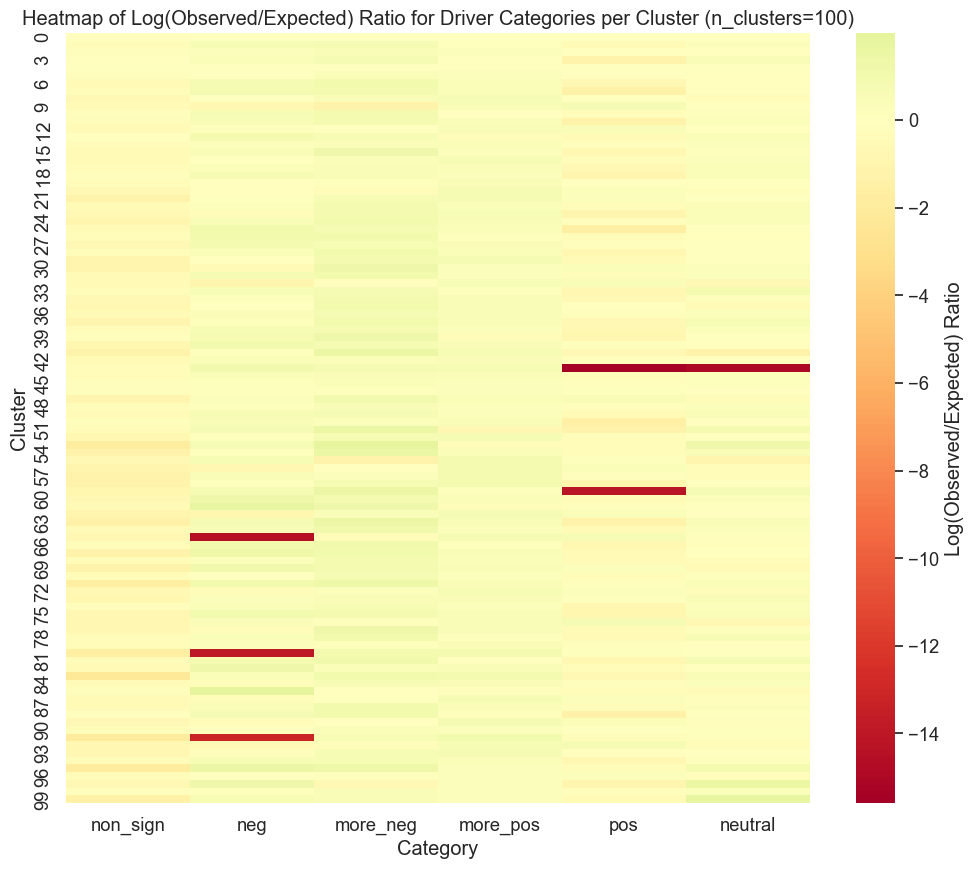

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt

# Function to convert string to set only if it's a string
def convert_to_set(x):
    if isinstance(x, str):
        return set(eval(x))
    return x
# Function to calculate Jaccard Similarity
def jaccard_similarity(genes_i, genes_j):
    return len(genes_i & genes_j) / len(genes_i | genes_j)

# Convert `intersections` from string representation to set if necessary
print("Converting intersections to sets...")
combined_stat_sig['intersections'] = combined_stat_sig['intersections'].apply(convert_to_set)

# Sort terms by the number of genes in the intersections
print("Sorting terms by the number of genes in intersections...")
combined_stat_sig['num_genes'] = combined_stat_sig['intersections'].apply(len)
combined_stat_sig = combined_stat_sig.sort_values('num_genes', ascending=False)
print(combined_stat_sig.head())

# Initialize the Jaccard similarity matrix
n = len(combined_stat_sig)
jaccard_matrix = np.zeros((n, n))
print(f"Initialized Jaccard matrix of size {n}x{n}")

# Calculate Jaccard Similarity in parallel
def compute_row(i):
    genes_i = combined_stat_sig.iloc[i]['intersections']
    row = np.zeros(n)
    for j in range(i+1, n):
        genes_j = combined_stat_sig.iloc[j]['intersections']
        row[j] = jaccard_similarity(genes_i, genes_j)
    return row

# Parallelize the computation
print("Calculating Jaccard similarities...")
jaccard_matrix = np.array(Parallel(n_jobs=-1)(delayed(compute_row)(i) for i in range(n)))
print("Jaccard similarity matrix calculation complete.")

# Make the matrix symmetric
jaccard_matrix = jaccard_matrix + jaccard_matrix.T
print("Jaccard matrix is now symmetric.")

# Clustering
n_clusters = 100
print(f"Performing Agglomerative Clustering with {n_clusters} clusters...")
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
labels = clustering.fit_predict(1 - jaccard_matrix)  # 1 - jaccard_matrix to convert to distance matrix
print("Clustering complete. Cluster labels assigned.")

# Add the cluster labels to the dataframe
combined_stat_sig['Cluster'] = labels
print(combined_stat_sig[['Name', 'Cluster']].head())

# Group the terms by their clusters
clustered_terms = []
for cluster_label in np.unique(labels):
    cluster_terms = combined_stat_sig[combined_stat_sig['Cluster'] == cluster_label]
    term_names = cluster_terms['Name'].tolist()
    combined_genes = set().union(*cluster_terms['intersections'])
    clustered_terms.append({'Cluster': cluster_label, 'Terms': term_names, 'Combined Genes': combined_genes})

# Convert to DataFrame
cluster_df = pd.DataFrame(clustered_terms)
print("Clusters and their terms:")
print(cluster_df.head())

# Step 2: Calculate total number of drivers per category using the `group` column in driver_stats
print("Calculating total number of drivers per category...")
total_drivers = driver_stats['group'].value_counts().to_dict()
epsilon = 1e-6  # Small value to avoid division by zero in log calculations
print(total_drivers)

# Initialize data structure to store cluster information
heatmap_data = []
print("Building heatmap data...")

# Iterate over clusters and calculate category counts and log ratios
for idx, row in cluster_df.iterrows():
    cluster_label = row['Cluster']
    combined_genes = row['Combined Genes']
    num_combined_genes = len(combined_genes)    
    
    # Count the number of drivers in each category for the current cluster
    category_counts = {category: 0 for category in total_drivers.keys()}
    for gene in combined_genes:
        if gene in driver_stats.index:  # Use driver as the index
            category = driver_stats.loc[gene, 'group']  # Access the 'group' column
            if category in category_counts:
                category_counts[category] += 1
    
    print(f"Cluster {cluster_label} - Category counts: {category_counts}")
    
    # Compute the log-transformed observed/expected ratio for each category
    for category in category_counts.keys():
        observed = category_counts[category]
        expected = total_drivers[category] * (num_combined_genes / len(driver_stats))  # Scale by total drivers
        
        # Add epsilon to avoid log(0)
        log_ratio = np.log((observed + epsilon) / (expected + epsilon))
        
        heatmap_data.append({
            'Cluster': cluster_label,  # Store cluster as integer
            'Category': category,
            'LogRatio': log_ratio
        })

# Step 3: Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data)
print("Heatmap data:")
print(heatmap_df.head())

# Pivot the DataFrame to have clusters as rows and categories as columns
heatmap_pivot = heatmap_df.pivot(index="Cluster", columns="Category", values="LogRatio")

# Ensure clusters are sorted numerically and categories are in the specified order, including 'neutral'
heatmap_pivot = heatmap_pivot.sort_index(ascending=True)
heatmap_pivot = heatmap_pivot[['non_sign', 'neg', 'more_neg', 'more_pos', 'pos', 'neutral']]  # Include 'neutral' in the column order
print("Pivoted heatmap data:")
print(heatmap_pivot.head())

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_pivot, annot=False, cmap="RdYlGn", center=0, cbar_kws={'label': 'Log(Observed/Expected) Ratio'})
plt.title(f"Heatmap of Log(Observed/Expected) Ratio for Driver Categories per Cluster (n_clusters={n_clusters})")
plt.show()


In [ ]:
# Identify clusters with extreme values (very low and very high log-ratio values)
extreme_clusters = heatmap_df[(heatmap_df['LogRatio'] <= -19) | (heatmap_df['LogRatio'] >= 2)]
print("Clusters with extreme log-ratio values:")
print(extreme_clusters)

Clusters with extreme log-ratio values:
     Cluster  Category   LogRatio
253       50       Pos -19.474993
295       59     N_Sig -21.012946
407       81  More_Neg -19.492264
449       89       Neg   2.071750
477       95  More_Neg -19.492264
478       95       Pos -19.474993
497       99  More_Neg -19.492264
